<table align="center">
  <td align="center"><a target="_blank" href="http://introtodeeplearning.com">
        <img src="https://i.ibb.co/Jr88sn2/mit.png" style="padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/aamini/introtodeeplearning/blob/master/lab3/Part2_BiasAndUncertainty.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/aamini/introtodeeplearning/blob/master/lab3/Part2_BiasAndUncertainty.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# Copyright Information

In [ ]:
# Copyright 2023 MIT Introduction to Deep Learning. All Rights Reserved.
# 
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of MIT Introduction
# to Deep Learning must reference:
#
# © MIT Introduction to Deep Learning
# http://introtodeeplearning.com
#

# Laboratory 3: Debiasing, Uncertainty, and Robustness

# Part 2: Mitigating Bias and Uncertainty in Facial Detection Systems

In Lab 2, we defined a semi-supervised VAE (SS-VAE) to diagnose feature representation disparities and biases in facial detection systems. In Lab 3 Part 1, we gained experience with [Capsa](https://github.com/themis-ai/capsa/) and its ability to build risk-aware models automatically through wrapping. Now in this lab, we will put these two together: using Capsa to build systems that can *automatically* uncover and mitigate bias and uncertainty in facial detection systems.

As we have seen, automatically detecting and mitigating bias and uncertainty is crucial to deploying fair and safe models. Building off our foundation with Capsa, developed by [Themis AI](https://themisai.io/), we will now use Capsa for the facial detection problem, in order to diagnose risks in facial detection models. You will then design and create strategies to mitigate these risks, with goal of improving model performance across the entire facial detection dataset.

**Your goal in this lab -- and the associated competition -- is to design a strategic solution for bias and uncertainty mitigation, using Capsa.** The approaches and solutions with oustanding performance will be recognized with outstanding prizes! Details on the submission process are at the end of this lab.

![Capsa overview](https://raw.githubusercontent.com/aamini/introtodeeplearning/2023/lab3/img/capsa_overview.png)

Let's get started by installing the necessary dependencies:

In [1]:
# Import Tensorflow 2.0
#%tensorflow_version 2.x
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Download and import the MIT 6.S191 package
!pip install git+https://github.com/aamini/introtodeeplearning.git@2023
import mitdeeplearning as mdl

# Download and import capsa
!pip install capsa
import capsa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/aamini/introtodeeplearning.git (to revision 2023) to /tmp/pip-req-build-8d8k7gc2
  Running command git clone --filter=blob:none --quiet https://github.com/aamini/introtodeeplearning.git /tmp/pip-req-build-8d8k7gc2
  Running command git checkout -b 2023 --track origin/2023
  Switched to a new branch '2023'
  Branch '2023' set up to track remote branch '2023' from 'origin'.
  Resolved https://github.com/aamini/introtodeeplearning.git to commit ed7501323f5b3f0f865db898b1ce6a0528df1586
  Preparing metadata (setup.py) ... done
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.4.0-py3-none-any.whl size=2118509 sha256=f8ba1f69f257731729ba4c5979ace15fbf880f99474febb1f9475da02e611fa6
  Stored in directory: /tmp/pip-ephem-wheel-cache-nn44r1o7/wheels/ef/52/04/ba06741bd3ca87d9d5a73710a375adad24618e18924cc54e32
Successfully built mitdeeplearning
Looking in in

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


# 3.1 Datasets

Since we are again focusing on the facial detection problem, we will use the same datasets from Lab 2. To remind you, we have a dataset of positive examples (i.e., of faces) and a dataset of negative examples (i.e., of things that are not faces).

1.   **Positive training data**: [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). A large-scale dataset (over 200K images) of celebrity faces.   
2.   **Negative training data**: [ImageNet](http://www.image-net.org/). A large-scale dataset with many images across many different categories. We will take negative examples from a variety of non-human categories.

We will evaluate trained models on an independent test dataset of face images to diagnose and mitigate potential issues with *bias, fairness, and confidence*. This will be a larger test dataset for evaluation purposes.

We begin by importing these datasets. We have defined a `DatasetLoader` class that does a bit of data pre-processing to import the training data in a usable format.

In [2]:
batch_size = 32

# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face_2023_perturbed_small.h5', 'https://www.dropbox.com/s/tbra3danrk5x8h5/train_face_2023_perturbed_small.h5?dl=1')
# Instantiate a DatasetLoader using the downloaded dataset
train_loader = mdl.lab3.DatasetLoader(path_to_training_data, training=True, batch_size=batch_size)
test_loader = mdl.lab3.DatasetLoader(path_to_training_data, training=False, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


675368621/675368621 [==============================] - 61s 0us/step
Opening /root/.keras/datasets/train_face_2023_perturbed_small.h5
Loading data into memory...
Opening /root/.keras/datasets/train_face_2023_perturbed_small.h5
Loading data into memory...


### Building robustness to bias and uncertainty

Remember that we'll be training our facial detection classifiers on the large, well-curated CelebA dataset (and ImageNet), and then evaluating their accuracy by testing them on an independent test dataset. We want to mitigate the effects of unwanted bias and uncertainty on the model's predictions and performance. Your goal is to build the best-performing, most robust model, one that achieves high classification accuracy across the entire test dataset.

To achieve this, you may want to consider the three metrics introduced with Capsa: (1) representation bias, (2) data or aleatoric uncertainty, and (3) model or epistemic uncertainty. Note that all three of these metrics are different! For example, we can have well-represented examples that still have high epistemic uncertainty. Think about how you may use these metrics to improve the performance of your model.

# 3.2 Risk-aware facial detection with Capsa

In Lab 2, we built a semi-supervised variational autoencoder (SS-VAE) to learn the latent structure of our database and to uncover feature representation disparities, inspired by the approach of [uncover hidden biases](http://introtodeeplearning.com/AAAI_MitigatingAlgorithmicBias.pdf). In this lab, we'll show that we can use Capsa to build the same VAE in one line!

This sets the foundation for quantifying a key risk metric -- representation bias -- for the facial detection problem. In working to improve your model's performance, you will want to consider representation bias carefully and think about how you could mitigate the effect of representation bias.

Just like in Lab 2, we begin by defining a standard CNN-based classifier. We will then use Capsa to wrap the model and build the risk-aware VAE variant.

In [3]:
### Define the CNN classifier model ###

'''Function to define a standard CNN model'''
def make_standard_classifier(n_outputs=1, n_filters=12):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([ 
    tf.keras.Input(shape=(64,64, 3)),
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=8*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

### Capsa's `HistogramVAEWrapper`

With our base classifier Capsa allows us to automatically define a VAE implementing that base classifier. Capsa's [`HistogramVAEWrapper`](https://themisai.io/capsa/api_documentation/HistogramVAEWrapper.html) builds this VAE to analyze the latent space distribution, just as we did in Lab 2. 

Specifically, `capsa.HistogramVAEWrapper` constructs a histogram with `num_bins` bins across every dimension of the latent space, and then calculates the joint probability of every sample according to the constructed histograms. The samples with the lowest joint probability have the lowest representation; the samples with the highest joint probability have the highest representation.

`capsa.HistogramVAEWrapper` takes in a number of arguments including:
1. `base_model`: the model to be transformed into the risk-aware variant.
2. `num_bins`: the number of bins we want to discretize our distribution into. 
2. `queue_size`: the number of samples we want to track at any given point.
3. `decoder`: the decoder architecture for the VAE.

We define the same decoder as in Lab 2:

In [4]:
### Define the decoder architecture for the facial detection VAE ###

def make_face_decoder_network(n_filters=12):
  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, 
                                      padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=2*2*8*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(2, 2, 8*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=6*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

We are ready to create the wrapped model using `capsa.HistogramVAEWrapper` by passing in the relevant arguments!

Just like in the wrappers in the Introduction to Capsa lab, we can take our standard CNN classifier, wrap it with `capsa.HistogramVAEWrapper`, build the wrapped model. The wrapper then enablings semi-supervised training for the facial detection task. As the wrapped model trains, the classifier weights are updated, and the VAE-wrapped model learns to track feature distributions over the latent space. More details of the `HistogramVAEWrapper` and how it can be used are [available here](https://themisai.io/capsa/api_documentation/HistogramVAEWrapper.html).

We can then evaluate the representation bias of the classifier on the test dataset. By calling the `wrapped_model` on our test data, we can automatically generate representation bias and uncertainty scores that are normally manually calculated. Let's wrap our base CNN classifier using Capsa, train and build the resulting model, and start to process the test data: 

In [5]:
### Estimating representation bias with Capsa HistogramVAEWrapper ###

model = make_standard_classifier()
# Wrap the CNN classifier for latent encoding with a VAE wrapper
wrapped_model = capsa.HistogramVAEWrapper(model, num_bins=5, queue_size=20000, 
    latent_dim = 32, decoder=make_face_decoder_network())

# Build the model for classification, defining the loss function, optimizer, and metrics
wrapped_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # for classification
    metrics=[tf.keras.metrics.BinaryAccuracy()], # for classification
    run_eagerly=True
)

# Train the wrapped model for 6 epochs by fitting to the training data
history = wrapped_model.fit(
        train_loader,
        epochs=6,
        batch_size=batch_size,
  )

## Evaluation

# Get all faces from the testing dataset
test_imgs = test_loader.get_all_faces()

# Call the Capsa-wrapped classifier to generate outputs: predictions, uncertainty, and bias!
predictions, uncertainty, bias = wrapped_model.predict(test_imgs, batch_size=512)

 732/1373 [==============>...............] - ETA: 2:57 - vae_compiled_loss: 0.4453 - vae_compiled_binary_accuracy: 0.7804 - vae_wrapper_loss: 459.0521

 733/1373 [===============>..............] - ETA: 2:56 - vae_compiled_loss: 0.4452 - vae_compiled_binary_accuracy: 0.7804 - vae_wrapper_loss: 458.8745

 734/1373 [===============>..............] - ETA: 2:56 - vae_compiled_loss: 0.4451 - vae_compiled_binary_accuracy: 0.7805 - vae_wrapper_loss: 458.6464

 735/1373 [===============>..............] - ETA: 2:56 - vae_compiled_loss: 0.4450 - vae_compiled_binary_accuracy: 0.7806 - vae_wrapper_loss: 458.3293

 736/1373 [===============>..............] - ETA: 2:56 - vae_compiled_loss: 0.4449 - vae_compiled_binary_accuracy: 0.7806 - vae_wrapper_loss: 458.0939

 737/1373 [===============>..............] - ETA: 2:55 - vae_compiled_loss: 0.4448 - vae_compiled_binary_accuracy: 0.7807 - vae_wrapper_loss: 457.9127

 738/1373 [===============>..............] - ETA: 2:55 - vae_compiled_loss: 0.4447 - vae_compiled_binary_accuracy: 0.7808 - vae_wrapper_loss: 457.6667

 739/1373 [===============>..............] - ETA: 2:55 - vae_compiled_loss: 0.4446 - vae_compiled_binary_accuracy: 0.7809 - vae_wrapper_loss: 457.4602

 740/1373 [===============>..............] - ETA: 2:55 - vae_compiled_loss: 0.4445 - vae_compiled_binary_accuracy: 0.7809 - vae_wrapper_loss: 457.2154

 741/1373 [===============>..............] - ETA: 2:54 - vae_compiled_loss: 0.4444 - vae_compiled_binary_accuracy: 0.7810 - vae_wrapper_loss: 456.9684

 742/1373 [===============>..............] - ETA: 2:54 - vae_compiled_loss: 0.4443 - vae_compiled_binary_accuracy: 0.7811 - vae_wrapper_loss: 456.7533

 743/1373 [===============>..............] - ETA: 2:54 - vae_compiled_loss: 0.4442 - vae_compiled_binary_accuracy: 0.7811 - vae_wrapper_loss: 456.4688

 744/1373 [===============>..............] - ETA: 2:53 - vae_compiled_loss: 0.4441 - vae_compiled_binary_accuracy: 0.7812 - vae_wrapper_loss: 456.2422

 745/1373 [===============>..............] - ETA: 2:53 - vae_compiled_loss: 0.4440 - vae_compiled_binary_accuracy: 0.7813 - vae_wrapper_loss: 455.9603

 746/1373 [===============>..............] - ETA: 2:53 - vae_compiled_loss: 0.4439 - vae_compiled_binary_accuracy: 0.7813 - vae_wrapper_loss: 455.7324

 747/1373 [===============>..............] - ETA: 2:53 - vae_compiled_loss: 0.4438 - vae_compiled_binary_accuracy: 0.7814 - vae_wrapper_loss: 455.5035

 748/1373 [===============>..............] - ETA: 2:52 - vae_compiled_loss: 0.4437 - vae_compiled_binary_accuracy: 0.7815 - vae_wrapper_loss: 455.2779

 749/1373 [===============>..............] - ETA: 2:52 - vae_compiled_loss: 0.4437 - vae_compiled_binary_accuracy: 0.7815 - vae_wrapper_loss: 455.0522

 750/1373 [===============>..............] - ETA: 2:52 - vae_compiled_loss: 0.4436 - vae_compiled_binary_accuracy: 0.7816 - vae_wrapper_loss: 454.8501

 751/1373 [===============>..............] - ETA: 2:51 - vae_compiled_loss: 0.4435 - vae_compiled_binary_accuracy: 0.7817 - vae_wrapper_loss: 454.6233

 752/1373 [===============>..............] - ETA: 2:51 - vae_compiled_loss: 0.4434 - vae_compiled_binary_accuracy: 0.7817 - vae_wrapper_loss: 454.3641

 753/1373 [===============>..............] - ETA: 2:51 - vae_compiled_loss: 0.4433 - vae_compiled_binary_accuracy: 0.7818 - vae_wrapper_loss: 454.1685

 754/1373 [===============>..............] - ETA: 2:50 - vae_compiled_loss: 0.4432 - vae_compiled_binary_accuracy: 0.7819 - vae_wrapper_loss: 453.9231

 755/1373 [===============>..............] - ETA: 2:50 - vae_compiled_loss: 0.4431 - vae_compiled_binary_accuracy: 0.7819 - vae_wrapper_loss: 453.7675

 756/1373 [===============>..............] - ETA: 2:50 - vae_compiled_loss: 0.4430 - vae_compiled_binary_accuracy: 0.7820 - vae_wrapper_loss: 453.5267

 757/1373 [===============>..............] - ETA: 2:50 - vae_compiled_loss: 0.4429 - vae_compiled_binary_accuracy: 0.7821 - vae_wrapper_loss: 453.3700

 758/1373 [===============>..............] - ETA: 2:49 - vae_compiled_loss: 0.4428 - vae_compiled_binary_accuracy: 0.7821 - vae_wrapper_loss: 453.1819

 759/1373 [===============>..............] - ETA: 2:49 - vae_compiled_loss: 0.4427 - vae_compiled_binary_accuracy: 0.7822 - vae_wrapper_loss: 452.9467

 760/1373 [===============>..............] - ETA: 2:49 - vae_compiled_loss: 0.4426 - vae_compiled_binary_accuracy: 0.7823 - vae_wrapper_loss: 452.7079

 761/1373 [===============>..............] - ETA: 2:48 - vae_compiled_loss: 0.4426 - vae_compiled_binary_accuracy: 0.7823 - vae_wrapper_loss: 452.4828

 762/1373 [===============>..............] - ETA: 2:48 - vae_compiled_loss: 0.4425 - vae_compiled_binary_accuracy: 0.7824 - vae_wrapper_loss: 452.2558

 763/1373 [===============>..............] - ETA: 2:48 - vae_compiled_loss: 0.4424 - vae_compiled_binary_accuracy: 0.7825 - vae_wrapper_loss: 452.0472

 764/1373 [===============>..............] - ETA: 2:48 - vae_compiled_loss: 0.4423 - vae_compiled_binary_accuracy: 0.7825 - vae_wrapper_loss: 451.7882

 765/1373 [===============>..............] - ETA: 2:47 - vae_compiled_loss: 0.4422 - vae_compiled_binary_accuracy: 0.7826 - vae_wrapper_loss: 451.5595

 766/1373 [===============>..............] - ETA: 2:47 - vae_compiled_loss: 0.4421 - vae_compiled_binary_accuracy: 0.7826 - vae_wrapper_loss: 451.3191

 767/1373 [===============>..............] - ETA: 2:47 - vae_compiled_loss: 0.4420 - vae_compiled_binary_accuracy: 0.7827 - vae_wrapper_loss: 451.0563

 768/1373 [===============>..............] - ETA: 2:46 - vae_compiled_loss: 0.4419 - vae_compiled_binary_accuracy: 0.7828 - vae_wrapper_loss: 450.8931

 769/1373 [===============>..............] - ETA: 2:46 - vae_compiled_loss: 0.4418 - vae_compiled_binary_accuracy: 0.7828 - vae_wrapper_loss: 450.6882

 770/1373 [===============>..............] - ETA: 2:46 - vae_compiled_loss: 0.4417 - vae_compiled_binary_accuracy: 0.7829 - vae_wrapper_loss: 450.4761

 771/1373 [===============>..............] - ETA: 2:46 - vae_compiled_loss: 0.4416 - vae_compiled_binary_accuracy: 0.7830 - vae_wrapper_loss: 450.2328

 772/1373 [===============>..............] - ETA: 2:45 - vae_compiled_loss: 0.4416 - vae_compiled_binary_accuracy: 0.7830 - vae_wrapper_loss: 449.9884

 773/1373 [===============>..............] - ETA: 2:45 - vae_compiled_loss: 0.4415 - vae_compiled_binary_accuracy: 0.7831 - vae_wrapper_loss: 449.7262

 774/1373 [===============>..............] - ETA: 2:45 - vae_compiled_loss: 0.4414 - vae_compiled_binary_accuracy: 0.7832 - vae_wrapper_loss: 449.5326

 775/1373 [===============>..............] - ETA: 2:45 - vae_compiled_loss: 0.4413 - vae_compiled_binary_accuracy: 0.7832 - vae_wrapper_loss: 449.2561

 776/1373 [===============>..............] - ETA: 2:44 - vae_compiled_loss: 0.4412 - vae_compiled_binary_accuracy: 0.7833 - vae_wrapper_loss: 449.1044

 777/1373 [===============>..............] - ETA: 2:44 - vae_compiled_loss: 0.4411 - vae_compiled_binary_accuracy: 0.7834 - vae_wrapper_loss: 448.8926

 778/1373 [===============>..............] - ETA: 2:44 - vae_compiled_loss: 0.4410 - vae_compiled_binary_accuracy: 0.7834 - vae_wrapper_loss: 448.6953

 779/1373 [================>.............] - ETA: 2:44 - vae_compiled_loss: 0.4409 - vae_compiled_binary_accuracy: 0.7835 - vae_wrapper_loss: 448.4534

 780/1373 [================>.............] - ETA: 2:44 - vae_compiled_loss: 0.4408 - vae_compiled_binary_accuracy: 0.7835 - vae_wrapper_loss: 448.1996

 781/1373 [================>.............] - ETA: 2:43 - vae_compiled_loss: 0.4408 - vae_compiled_binary_accuracy: 0.7836 - vae_wrapper_loss: 447.9583

 782/1373 [================>.............] - ETA: 2:43 - vae_compiled_loss: 0.4407 - vae_compiled_binary_accuracy: 0.7837 - vae_wrapper_loss: 447.6924

 783/1373 [================>.............] - ETA: 2:43 - vae_compiled_loss: 0.4406 - vae_compiled_binary_accuracy: 0.7837 - vae_wrapper_loss: 447.4565

 784/1373 [================>.............] - ETA: 2:42 - vae_compiled_loss: 0.4405 - vae_compiled_binary_accuracy: 0.7838 - vae_wrapper_loss: 447.2055

 785/1373 [================>.............] - ETA: 2:42 - vae_compiled_loss: 0.4404 - vae_compiled_binary_accuracy: 0.7839 - vae_wrapper_loss: 447.0324

 786/1373 [================>.............] - ETA: 2:42 - vae_compiled_loss: 0.4403 - vae_compiled_binary_accuracy: 0.7839 - vae_wrapper_loss: 446.8619

 787/1373 [================>.............] - ETA: 2:42 - vae_compiled_loss: 0.4402 - vae_compiled_binary_accuracy: 0.7840 - vae_wrapper_loss: 446.6443

 788/1373 [================>.............] - ETA: 2:41 - vae_compiled_loss: 0.4401 - vae_compiled_binary_accuracy: 0.7841 - vae_wrapper_loss: 446.5009

 789/1373 [================>.............] - ETA: 2:41 - vae_compiled_loss: 0.4400 - vae_compiled_binary_accuracy: 0.7841 - vae_wrapper_loss: 446.3264

 790/1373 [================>.............] - ETA: 2:41 - vae_compiled_loss: 0.4400 - vae_compiled_binary_accuracy: 0.7842 - vae_wrapper_loss: 446.1265

 791/1373 [================>.............] - ETA: 2:40 - vae_compiled_loss: 0.4399 - vae_compiled_binary_accuracy: 0.7842 - vae_wrapper_loss: 445.9494

 792/1373 [================>.............] - ETA: 2:40 - vae_compiled_loss: 0.4398 - vae_compiled_binary_accuracy: 0.7843 - vae_wrapper_loss: 445.7596

 793/1373 [================>.............] - ETA: 2:40 - vae_compiled_loss: 0.4397 - vae_compiled_binary_accuracy: 0.7844 - vae_wrapper_loss: 445.5248

 794/1373 [================>.............] - ETA: 2:40 - vae_compiled_loss: 0.4396 - vae_compiled_binary_accuracy: 0.7844 - vae_wrapper_loss: 445.3163

 795/1373 [================>.............] - ETA: 2:39 - vae_compiled_loss: 0.4395 - vae_compiled_binary_accuracy: 0.7845 - vae_wrapper_loss: 445.1430

 796/1373 [================>.............] - ETA: 2:39 - vae_compiled_loss: 0.4394 - vae_compiled_binary_accuracy: 0.7845 - vae_wrapper_loss: 444.9179

 797/1373 [================>.............] - ETA: 2:39 - vae_compiled_loss: 0.4393 - vae_compiled_binary_accuracy: 0.7846 - vae_wrapper_loss: 444.6899

 798/1373 [================>.............] - ETA: 2:38 - vae_compiled_loss: 0.4393 - vae_compiled_binary_accuracy: 0.7847 - vae_wrapper_loss: 444.4826

 799/1373 [================>.............] - ETA: 2:38 - vae_compiled_loss: 0.4392 - vae_compiled_binary_accuracy: 0.7847 - vae_wrapper_loss: 444.2269

 800/1373 [================>.............] - ETA: 2:38 - vae_compiled_loss: 0.4391 - vae_compiled_binary_accuracy: 0.7848 - vae_wrapper_loss: 443.9976

 801/1373 [================>.............] - ETA: 2:38 - vae_compiled_loss: 0.4390 - vae_compiled_binary_accuracy: 0.7849 - vae_wrapper_loss: 443.7815

 802/1373 [================>.............] - ETA: 2:37 - vae_compiled_loss: 0.4389 - vae_compiled_binary_accuracy: 0.7849 - vae_wrapper_loss: 443.6024

 803/1373 [================>.............] - ETA: 2:37 - vae_compiled_loss: 0.4388 - vae_compiled_binary_accuracy: 0.7850 - vae_wrapper_loss: 443.4165

 804/1373 [================>.............] - ETA: 2:37 - vae_compiled_loss: 0.4387 - vae_compiled_binary_accuracy: 0.7850 - vae_wrapper_loss: 443.2148

 805/1373 [================>.............] - ETA: 2:36 - vae_compiled_loss: 0.4387 - vae_compiled_binary_accuracy: 0.7851 - vae_wrapper_loss: 443.1229

 806/1373 [================>.............] - ETA: 2:36 - vae_compiled_loss: 0.4386 - vae_compiled_binary_accuracy: 0.7852 - vae_wrapper_loss: 442.9712

 807/1373 [================>.............] - ETA: 2:36 - vae_compiled_loss: 0.4385 - vae_compiled_binary_accuracy: 0.7852 - vae_wrapper_loss: 442.7010

 808/1373 [================>.............] - ETA: 2:36 - vae_compiled_loss: 0.4384 - vae_compiled_binary_accuracy: 0.7853 - vae_wrapper_loss: 442.4368

 809/1373 [================>.............] - ETA: 2:35 - vae_compiled_loss: 0.4383 - vae_compiled_binary_accuracy: 0.7853 - vae_wrapper_loss: 442.1891

 810/1373 [================>.............] - ETA: 2:35 - vae_compiled_loss: 0.4382 - vae_compiled_binary_accuracy: 0.7854 - vae_wrapper_loss: 441.9288

 811/1373 [================>.............] - ETA: 2:35 - vae_compiled_loss: 0.4381 - vae_compiled_binary_accuracy: 0.7855 - vae_wrapper_loss: 441.7169

 812/1373 [================>.............] - ETA: 2:34 - vae_compiled_loss: 0.4381 - vae_compiled_binary_accuracy: 0.7855 - vae_wrapper_loss: 441.4667

 813/1373 [================>.............] - ETA: 2:34 - vae_compiled_loss: 0.4380 - vae_compiled_binary_accuracy: 0.7856 - vae_wrapper_loss: 441.2208

 814/1373 [================>.............] - ETA: 2:34 - vae_compiled_loss: 0.4379 - vae_compiled_binary_accuracy: 0.7856 - vae_wrapper_loss: 441.0476

 815/1373 [================>.............] - ETA: 2:34 - vae_compiled_loss: 0.4378 - vae_compiled_binary_accuracy: 0.7857 - vae_wrapper_loss: 440.9026

 816/1373 [================>.............] - ETA: 2:33 - vae_compiled_loss: 0.4377 - vae_compiled_binary_accuracy: 0.7858 - vae_wrapper_loss: 440.7245

 817/1373 [================>.............] - ETA: 2:33 - vae_compiled_loss: 0.4376 - vae_compiled_binary_accuracy: 0.7858 - vae_wrapper_loss: 440.5129

 818/1373 [================>.............] - ETA: 2:33 - vae_compiled_loss: 0.4376 - vae_compiled_binary_accuracy: 0.7859 - vae_wrapper_loss: 440.3163

 819/1373 [================>.............] - ETA: 2:32 - vae_compiled_loss: 0.4375 - vae_compiled_binary_accuracy: 0.7859 - vae_wrapper_loss: 440.1570

 820/1373 [================>.............] - ETA: 2:32 - vae_compiled_loss: 0.4374 - vae_compiled_binary_accuracy: 0.7860 - vae_wrapper_loss: 439.9878

 821/1373 [================>.............] - ETA: 2:32 - vae_compiled_loss: 0.4373 - vae_compiled_binary_accuracy: 0.7861 - vae_wrapper_loss: 439.7620

 822/1373 [================>.............] - ETA: 2:32 - vae_compiled_loss: 0.4372 - vae_compiled_binary_accuracy: 0.7861 - vae_wrapper_loss: 439.5043

 823/1373 [================>.............] - ETA: 2:32 - vae_compiled_loss: 0.4371 - vae_compiled_binary_accuracy: 0.7862 - vae_wrapper_loss: 439.2990

 824/1373 [=================>............] - ETA: 2:31 - vae_compiled_loss: 0.4371 - vae_compiled_binary_accuracy: 0.7862 - vae_wrapper_loss: 439.0522

 825/1373 [=================>............] - ETA: 2:31 - vae_compiled_loss: 0.4370 - vae_compiled_binary_accuracy: 0.7863 - vae_wrapper_loss: 438.8506

 826/1373 [=================>............] - ETA: 2:31 - vae_compiled_loss: 0.4369 - vae_compiled_binary_accuracy: 0.7863 - vae_wrapper_loss: 438.6779

 827/1373 [=================>............] - ETA: 2:31 - vae_compiled_loss: 0.4368 - vae_compiled_binary_accuracy: 0.7864 - vae_wrapper_loss: 438.4952

 828/1373 [=================>............] - ETA: 2:30 - vae_compiled_loss: 0.4367 - vae_compiled_binary_accuracy: 0.7865 - vae_wrapper_loss: 438.2852

 829/1373 [=================>............] - ETA: 2:30 - vae_compiled_loss: 0.4367 - vae_compiled_binary_accuracy: 0.7865 - vae_wrapper_loss: 438.1348

 830/1373 [=================>............] - ETA: 2:30 - vae_compiled_loss: 0.4366 - vae_compiled_binary_accuracy: 0.7866 - vae_wrapper_loss: 437.9554

 831/1373 [=================>............] - ETA: 2:29 - vae_compiled_loss: 0.4365 - vae_compiled_binary_accuracy: 0.7866 - vae_wrapper_loss: 437.7603

 832/1373 [=================>............] - ETA: 2:29 - vae_compiled_loss: 0.4364 - vae_compiled_binary_accuracy: 0.7867 - vae_wrapper_loss: 437.5840

 833/1373 [=================>............] - ETA: 2:29 - vae_compiled_loss: 0.4363 - vae_compiled_binary_accuracy: 0.7867 - vae_wrapper_loss: 437.3781

 834/1373 [=================>............] - ETA: 2:29 - vae_compiled_loss: 0.4362 - vae_compiled_binary_accuracy: 0.7868 - vae_wrapper_loss: 437.2112

 835/1373 [=================>............] - ETA: 2:28 - vae_compiled_loss: 0.4362 - vae_compiled_binary_accuracy: 0.7869 - vae_wrapper_loss: 437.0150

 836/1373 [=================>............] - ETA: 2:28 - vae_compiled_loss: 0.4361 - vae_compiled_binary_accuracy: 0.7869 - vae_wrapper_loss: 436.7907

 837/1373 [=================>............] - ETA: 2:28 - vae_compiled_loss: 0.4360 - vae_compiled_binary_accuracy: 0.7870 - vae_wrapper_loss: 436.5437

 838/1373 [=================>............] - ETA: 2:27 - vae_compiled_loss: 0.4359 - vae_compiled_binary_accuracy: 0.7870 - vae_wrapper_loss: 436.3248

 839/1373 [=================>............] - ETA: 2:27 - vae_compiled_loss: 0.4358 - vae_compiled_binary_accuracy: 0.7871 - vae_wrapper_loss: 436.2513

 840/1373 [=================>............] - ETA: 2:27 - vae_compiled_loss: 0.4358 - vae_compiled_binary_accuracy: 0.7871 - vae_wrapper_loss: 436.0402

 841/1373 [=================>............] - ETA: 2:27 - vae_compiled_loss: 0.4357 - vae_compiled_binary_accuracy: 0.7872 - vae_wrapper_loss: 435.8431

 842/1373 [=================>............] - ETA: 2:26 - vae_compiled_loss: 0.4356 - vae_compiled_binary_accuracy: 0.7873 - vae_wrapper_loss: 435.6877

 843/1373 [=================>............] - ETA: 2:26 - vae_compiled_loss: 0.4355 - vae_compiled_binary_accuracy: 0.7873 - vae_wrapper_loss: 435.5124

 844/1373 [=================>............] - ETA: 2:26 - vae_compiled_loss: 0.4354 - vae_compiled_binary_accuracy: 0.7874 - vae_wrapper_loss: 435.3174

 845/1373 [=================>............] - ETA: 2:25 - vae_compiled_loss: 0.4354 - vae_compiled_binary_accuracy: 0.7874 - vae_wrapper_loss: 435.1457

 846/1373 [=================>............] - ETA: 2:25 - vae_compiled_loss: 0.4353 - vae_compiled_binary_accuracy: 0.7875 - vae_wrapper_loss: 434.9825

 847/1373 [=================>............] - ETA: 2:25 - vae_compiled_loss: 0.4352 - vae_compiled_binary_accuracy: 0.7875 - vae_wrapper_loss: 434.7713

 848/1373 [=================>............] - ETA: 2:25 - vae_compiled_loss: 0.4351 - vae_compiled_binary_accuracy: 0.7876 - vae_wrapper_loss: 434.6078

 849/1373 [=================>............] - ETA: 2:24 - vae_compiled_loss: 0.4351 - vae_compiled_binary_accuracy: 0.7876 - vae_wrapper_loss: 434.4093

 850/1373 [=================>............] - ETA: 2:24 - vae_compiled_loss: 0.4350 - vae_compiled_binary_accuracy: 0.7877 - vae_wrapper_loss: 434.1748

 851/1373 [=================>............] - ETA: 2:24 - vae_compiled_loss: 0.4349 - vae_compiled_binary_accuracy: 0.7878 - vae_wrapper_loss: 434.0223

 852/1373 [=================>............] - ETA: 2:23 - vae_compiled_loss: 0.4348 - vae_compiled_binary_accuracy: 0.7878 - vae_wrapper_loss: 433.8446

 853/1373 [=================>............] - ETA: 2:23 - vae_compiled_loss: 0.4347 - vae_compiled_binary_accuracy: 0.7879 - vae_wrapper_loss: 433.6483

 854/1373 [=================>............] - ETA: 2:23 - vae_compiled_loss: 0.4347 - vae_compiled_binary_accuracy: 0.7879 - vae_wrapper_loss: 433.4705

 855/1373 [=================>............] - ETA: 2:23 - vae_compiled_loss: 0.4346 - vae_compiled_binary_accuracy: 0.7880 - vae_wrapper_loss: 433.3704

 856/1373 [=================>............] - ETA: 2:22 - vae_compiled_loss: 0.4345 - vae_compiled_binary_accuracy: 0.7880 - vae_wrapper_loss: 433.1826

 857/1373 [=================>............] - ETA: 2:22 - vae_compiled_loss: 0.4344 - vae_compiled_binary_accuracy: 0.7881 - vae_wrapper_loss: 432.9777

 858/1373 [=================>............] - ETA: 2:22 - vae_compiled_loss: 0.4344 - vae_compiled_binary_accuracy: 0.7881 - vae_wrapper_loss: 432.7704

 859/1373 [=================>............] - ETA: 2:21 - vae_compiled_loss: 0.4343 - vae_compiled_binary_accuracy: 0.7882 - vae_wrapper_loss: 432.5553

 860/1373 [=================>............] - ETA: 2:21 - vae_compiled_loss: 0.4342 - vae_compiled_binary_accuracy: 0.7882 - vae_wrapper_loss: 432.3841

 861/1373 [=================>............] - ETA: 2:21 - vae_compiled_loss: 0.4341 - vae_compiled_binary_accuracy: 0.7883 - vae_wrapper_loss: 432.2276

 862/1373 [=================>............] - ETA: 2:21 - vae_compiled_loss: 0.4340 - vae_compiled_binary_accuracy: 0.7884 - vae_wrapper_loss: 432.0305

 863/1373 [=================>............] - ETA: 2:20 - vae_compiled_loss: 0.4340 - vae_compiled_binary_accuracy: 0.7884 - vae_wrapper_loss: 431.8462

 864/1373 [=================>............] - ETA: 2:20 - vae_compiled_loss: 0.4339 - vae_compiled_binary_accuracy: 0.7885 - vae_wrapper_loss: 431.6514

 865/1373 [=================>............] - ETA: 2:20 - vae_compiled_loss: 0.4338 - vae_compiled_binary_accuracy: 0.7885 - vae_wrapper_loss: 431.4301

 866/1373 [=================>............] - ETA: 2:20 - vae_compiled_loss: 0.4337 - vae_compiled_binary_accuracy: 0.7886 - vae_wrapper_loss: 431.2625

 867/1373 [=================>............] - ETA: 2:19 - vae_compiled_loss: 0.4337 - vae_compiled_binary_accuracy: 0.7886 - vae_wrapper_loss: 431.0303

 868/1373 [=================>............] - ETA: 2:19 - vae_compiled_loss: 0.4336 - vae_compiled_binary_accuracy: 0.7887 - vae_wrapper_loss: 430.8911

 869/1373 [=================>............] - ETA: 2:19 - vae_compiled_loss: 0.4335 - vae_compiled_binary_accuracy: 0.7887 - vae_wrapper_loss: 430.7558

 870/1373 [==================>...........] - ETA: 2:19 - vae_compiled_loss: 0.4334 - vae_compiled_binary_accuracy: 0.7888 - vae_wrapper_loss: 430.5715

 871/1373 [==================>...........] - ETA: 2:18 - vae_compiled_loss: 0.4334 - vae_compiled_binary_accuracy: 0.7888 - vae_wrapper_loss: 430.3834

 872/1373 [==================>...........] - ETA: 2:18 - vae_compiled_loss: 0.4333 - vae_compiled_binary_accuracy: 0.7889 - vae_wrapper_loss: 430.1799

 873/1373 [==================>...........] - ETA: 2:18 - vae_compiled_loss: 0.4332 - vae_compiled_binary_accuracy: 0.7889 - vae_wrapper_loss: 429.9756

 874/1373 [==================>...........] - ETA: 2:18 - vae_compiled_loss: 0.4331 - vae_compiled_binary_accuracy: 0.7890 - vae_wrapper_loss: 429.9444

 875/1373 [==================>...........] - ETA: 2:17 - vae_compiled_loss: 0.4331 - vae_compiled_binary_accuracy: 0.7891 - vae_wrapper_loss: 429.7789

 876/1373 [==================>...........] - ETA: 2:17 - vae_compiled_loss: 0.4330 - vae_compiled_binary_accuracy: 0.7891 - vae_wrapper_loss: 429.6249

 877/1373 [==================>...........] - ETA: 2:17 - vae_compiled_loss: 0.4329 - vae_compiled_binary_accuracy: 0.7892 - vae_wrapper_loss: 429.4951

 878/1373 [==================>...........] - ETA: 2:16 - vae_compiled_loss: 0.4328 - vae_compiled_binary_accuracy: 0.7892 - vae_wrapper_loss: 429.2739

 879/1373 [==================>...........] - ETA: 2:16 - vae_compiled_loss: 0.4328 - vae_compiled_binary_accuracy: 0.7893 - vae_wrapper_loss: 429.1471

 880/1373 [==================>...........] - ETA: 2:16 - vae_compiled_loss: 0.4327 - vae_compiled_binary_accuracy: 0.7893 - vae_wrapper_loss: 429.0170

 881/1373 [==================>...........] - ETA: 2:16 - vae_compiled_loss: 0.4326 - vae_compiled_binary_accuracy: 0.7894 - vae_wrapper_loss: 428.8690

 882/1373 [==================>...........] - ETA: 2:15 - vae_compiled_loss: 0.4325 - vae_compiled_binary_accuracy: 0.7894 - vae_wrapper_loss: 428.7335

 883/1373 [==================>...........] - ETA: 2:15 - vae_compiled_loss: 0.4325 - vae_compiled_binary_accuracy: 0.7895 - vae_wrapper_loss: 428.6032

 884/1373 [==================>...........] - ETA: 2:15 - vae_compiled_loss: 0.4324 - vae_compiled_binary_accuracy: 0.7895 - vae_wrapper_loss: 428.4475

 885/1373 [==================>...........] - ETA: 2:14 - vae_compiled_loss: 0.4323 - vae_compiled_binary_accuracy: 0.7896 - vae_wrapper_loss: 428.3060

 886/1373 [==================>...........] - ETA: 2:14 - vae_compiled_loss: 0.4323 - vae_compiled_binary_accuracy: 0.7896 - vae_wrapper_loss: 428.1384

 887/1373 [==================>...........] - ETA: 2:14 - vae_compiled_loss: 0.4322 - vae_compiled_binary_accuracy: 0.7897 - vae_wrapper_loss: 427.9582

 888/1373 [==================>...........] - ETA: 2:14 - vae_compiled_loss: 0.4321 - vae_compiled_binary_accuracy: 0.7897 - vae_wrapper_loss: 427.7647

 889/1373 [==================>...........] - ETA: 2:13 - vae_compiled_loss: 0.4320 - vae_compiled_binary_accuracy: 0.7898 - vae_wrapper_loss: 427.5765

 890/1373 [==================>...........] - ETA: 2:13 - vae_compiled_loss: 0.4320 - vae_compiled_binary_accuracy: 0.7898 - vae_wrapper_loss: 427.3732

 891/1373 [==================>...........] - ETA: 2:13 - vae_compiled_loss: 0.4319 - vae_compiled_binary_accuracy: 0.7899 - vae_wrapper_loss: 427.1817

 892/1373 [==================>...........] - ETA: 2:13 - vae_compiled_loss: 0.4318 - vae_compiled_binary_accuracy: 0.7899 - vae_wrapper_loss: 426.9573

 893/1373 [==================>...........] - ETA: 2:12 - vae_compiled_loss: 0.4317 - vae_compiled_binary_accuracy: 0.7900 - vae_wrapper_loss: 426.8466

 894/1373 [==================>...........] - ETA: 2:12 - vae_compiled_loss: 0.4317 - vae_compiled_binary_accuracy: 0.7900 - vae_wrapper_loss: 426.6505

 895/1373 [==================>...........] - ETA: 2:12 - vae_compiled_loss: 0.4316 - vae_compiled_binary_accuracy: 0.7901 - vae_wrapper_loss: 426.4798

 896/1373 [==================>...........] - ETA: 2:11 - vae_compiled_loss: 0.4315 - vae_compiled_binary_accuracy: 0.7901 - vae_wrapper_loss: 426.3044

 897/1373 [==================>...........] - ETA: 2:11 - vae_compiled_loss: 0.4315 - vae_compiled_binary_accuracy: 0.7902 - vae_wrapper_loss: 426.0696

 898/1373 [==================>...........] - ETA: 2:11 - vae_compiled_loss: 0.4314 - vae_compiled_binary_accuracy: 0.7902 - vae_wrapper_loss: 425.8231

 899/1373 [==================>...........] - ETA: 2:11 - vae_compiled_loss: 0.4313 - vae_compiled_binary_accuracy: 0.7903 - vae_wrapper_loss: 425.6384

 900/1373 [==================>...........] - ETA: 2:10 - vae_compiled_loss: 0.4312 - vae_compiled_binary_accuracy: 0.7903 - vae_wrapper_loss: 425.4727

 901/1373 [==================>...........] - ETA: 2:10 - vae_compiled_loss: 0.4312 - vae_compiled_binary_accuracy: 0.7904 - vae_wrapper_loss: 425.2761

 902/1373 [==================>...........] - ETA: 2:10 - vae_compiled_loss: 0.4311 - vae_compiled_binary_accuracy: 0.7904 - vae_wrapper_loss: 425.0862

 903/1373 [==================>...........] - ETA: 2:09 - vae_compiled_loss: 0.4310 - vae_compiled_binary_accuracy: 0.7905 - vae_wrapper_loss: 424.9276

 904/1373 [==================>...........] - ETA: 2:09 - vae_compiled_loss: 0.4310 - vae_compiled_binary_accuracy: 0.7905 - vae_wrapper_loss: 424.7901

 905/1373 [==================>...........] - ETA: 2:09 - vae_compiled_loss: 0.4309 - vae_compiled_binary_accuracy: 0.7906 - vae_wrapper_loss: 424.5903

 906/1373 [==================>...........] - ETA: 2:09 - vae_compiled_loss: 0.4308 - vae_compiled_binary_accuracy: 0.7906 - vae_wrapper_loss: 424.4497

 907/1373 [==================>...........] - ETA: 2:08 - vae_compiled_loss: 0.4307 - vae_compiled_binary_accuracy: 0.7907 - vae_wrapper_loss: 424.2953

 908/1373 [==================>...........] - ETA: 2:08 - vae_compiled_loss: 0.4307 - vae_compiled_binary_accuracy: 0.7907 - vae_wrapper_loss: 424.0642

 909/1373 [==================>...........] - ETA: 2:08 - vae_compiled_loss: 0.4306 - vae_compiled_binary_accuracy: 0.7908 - vae_wrapper_loss: 423.8666

 910/1373 [==================>...........] - ETA: 2:07 - vae_compiled_loss: 0.4305 - vae_compiled_binary_accuracy: 0.7908 - vae_wrapper_loss: 423.6849

 911/1373 [==================>...........] - ETA: 2:07 - vae_compiled_loss: 0.4305 - vae_compiled_binary_accuracy: 0.7909 - vae_wrapper_loss: 423.4754

 912/1373 [==================>...........] - ETA: 2:07 - vae_compiled_loss: 0.4304 - vae_compiled_binary_accuracy: 0.7909 - vae_wrapper_loss: 423.2827

 913/1373 [==================>...........] - ETA: 2:07 - vae_compiled_loss: 0.4303 - vae_compiled_binary_accuracy: 0.7910 - vae_wrapper_loss: 423.1082

 914/1373 [==================>...........] - ETA: 2:06 - vae_compiled_loss: 0.4303 - vae_compiled_binary_accuracy: 0.7910 - vae_wrapper_loss: 422.9435

 915/1373 [==================>...........] - ETA: 2:06 - vae_compiled_loss: 0.4302 - vae_compiled_binary_accuracy: 0.7911 - vae_wrapper_loss: 422.7657

 916/1373 [===================>..........] - ETA: 2:06 - vae_compiled_loss: 0.4301 - vae_compiled_binary_accuracy: 0.7911 - vae_wrapper_loss: 422.5919

 917/1373 [===================>..........] - ETA: 2:06 - vae_compiled_loss: 0.4300 - vae_compiled_binary_accuracy: 0.7912 - vae_wrapper_loss: 422.4319

 918/1373 [===================>..........] - ETA: 2:05 - vae_compiled_loss: 0.4300 - vae_compiled_binary_accuracy: 0.7912 - vae_wrapper_loss: 422.2501

 919/1373 [===================>..........] - ETA: 2:05 - vae_compiled_loss: 0.4299 - vae_compiled_binary_accuracy: 0.7913 - vae_wrapper_loss: 422.0370

 920/1373 [===================>..........] - ETA: 2:05 - vae_compiled_loss: 0.4298 - vae_compiled_binary_accuracy: 0.7913 - vae_wrapper_loss: 421.8570

 921/1373 [===================>..........] - ETA: 2:05 - vae_compiled_loss: 0.4298 - vae_compiled_binary_accuracy: 0.7914 - vae_wrapper_loss: 421.7111

 922/1373 [===================>..........] - ETA: 2:04 - vae_compiled_loss: 0.4297 - vae_compiled_binary_accuracy: 0.7914 - vae_wrapper_loss: 421.5718

 923/1373 [===================>..........] - ETA: 2:04 - vae_compiled_loss: 0.4296 - vae_compiled_binary_accuracy: 0.7915 - vae_wrapper_loss: 421.4330

 924/1373 [===================>..........] - ETA: 2:04 - vae_compiled_loss: 0.4296 - vae_compiled_binary_accuracy: 0.7915 - vae_wrapper_loss: 421.2293

 925/1373 [===================>..........] - ETA: 2:04 - vae_compiled_loss: 0.4295 - vae_compiled_binary_accuracy: 0.7916 - vae_wrapper_loss: 421.0510

 926/1373 [===================>..........] - ETA: 2:03 - vae_compiled_loss: 0.4294 - vae_compiled_binary_accuracy: 0.7916 - vae_wrapper_loss: 420.9556

 927/1373 [===================>..........] - ETA: 2:03 - vae_compiled_loss: 0.4294 - vae_compiled_binary_accuracy: 0.7917 - vae_wrapper_loss: 420.7889

 928/1373 [===================>..........] - ETA: 2:03 - vae_compiled_loss: 0.4293 - vae_compiled_binary_accuracy: 0.7917 - vae_wrapper_loss: 420.6255

 929/1373 [===================>..........] - ETA: 2:02 - vae_compiled_loss: 0.4292 - vae_compiled_binary_accuracy: 0.7918 - vae_wrapper_loss: 420.5103

 930/1373 [===================>..........] - ETA: 2:02 - vae_compiled_loss: 0.4291 - vae_compiled_binary_accuracy: 0.7918 - vae_wrapper_loss: 420.3543

 931/1373 [===================>..........] - ETA: 2:02 - vae_compiled_loss: 0.4291 - vae_compiled_binary_accuracy: 0.7919 - vae_wrapper_loss: 420.1832

 932/1373 [===================>..........] - ETA: 2:02 - vae_compiled_loss: 0.4290 - vae_compiled_binary_accuracy: 0.7919 - vae_wrapper_loss: 420.1040

 933/1373 [===================>..........] - ETA: 2:01 - vae_compiled_loss: 0.4289 - vae_compiled_binary_accuracy: 0.7920 - vae_wrapper_loss: 420.0016

 934/1373 [===================>..........] - ETA: 2:01 - vae_compiled_loss: 0.4289 - vae_compiled_binary_accuracy: 0.7920 - vae_wrapper_loss: 419.9425

 935/1373 [===================>..........] - ETA: 2:01 - vae_compiled_loss: 0.4288 - vae_compiled_binary_accuracy: 0.7921 - vae_wrapper_loss: 419.7734

 936/1373 [===================>..........] - ETA: 2:00 - vae_compiled_loss: 0.4287 - vae_compiled_binary_accuracy: 0.7921 - vae_wrapper_loss: 419.6598

 937/1373 [===================>..........] - ETA: 2:00 - vae_compiled_loss: 0.4287 - vae_compiled_binary_accuracy: 0.7922 - vae_wrapper_loss: 419.5364

 938/1373 [===================>..........] - ETA: 2:00 - vae_compiled_loss: 0.4286 - vae_compiled_binary_accuracy: 0.7922 - vae_wrapper_loss: 419.4121

 939/1373 [===================>..........] - ETA: 2:00 - vae_compiled_loss: 0.4285 - vae_compiled_binary_accuracy: 0.7923 - vae_wrapper_loss: 419.2323

 940/1373 [===================>..........] - ETA: 1:59 - vae_compiled_loss: 0.4285 - vae_compiled_binary_accuracy: 0.7923 - vae_wrapper_loss: 419.0606

 941/1373 [===================>..........] - ETA: 1:59 - vae_compiled_loss: 0.4284 - vae_compiled_binary_accuracy: 0.7924 - vae_wrapper_loss: 418.9664

 942/1373 [===================>..........] - ETA: 1:59 - vae_compiled_loss: 0.4283 - vae_compiled_binary_accuracy: 0.7924 - vae_wrapper_loss: 418.8282

 943/1373 [===================>..........] - ETA: 1:58 - vae_compiled_loss: 0.4283 - vae_compiled_binary_accuracy: 0.7925 - vae_wrapper_loss: 418.6721

 944/1373 [===================>..........] - ETA: 1:58 - vae_compiled_loss: 0.4282 - vae_compiled_binary_accuracy: 0.7925 - vae_wrapper_loss: 418.4953

 945/1373 [===================>..........] - ETA: 1:58 - vae_compiled_loss: 0.4281 - vae_compiled_binary_accuracy: 0.7926 - vae_wrapper_loss: 418.2921

 946/1373 [===================>..........] - ETA: 1:58 - vae_compiled_loss: 0.4281 - vae_compiled_binary_accuracy: 0.7926 - vae_wrapper_loss: 418.0598

 947/1373 [===================>..........] - ETA: 1:57 - vae_compiled_loss: 0.4280 - vae_compiled_binary_accuracy: 0.7927 - vae_wrapper_loss: 417.8521

 948/1373 [===================>..........] - ETA: 1:57 - vae_compiled_loss: 0.4279 - vae_compiled_binary_accuracy: 0.7927 - vae_wrapper_loss: 417.7172

 949/1373 [===================>..........] - ETA: 1:57 - vae_compiled_loss: 0.4279 - vae_compiled_binary_accuracy: 0.7928 - vae_wrapper_loss: 417.5711

 950/1373 [===================>..........] - ETA: 1:56 - vae_compiled_loss: 0.4278 - vae_compiled_binary_accuracy: 0.7928 - vae_wrapper_loss: 417.4295

 951/1373 [===================>..........] - ETA: 1:56 - vae_compiled_loss: 0.4277 - vae_compiled_binary_accuracy: 0.7929 - vae_wrapper_loss: 417.2601

 952/1373 [===================>..........] - ETA: 1:56 - vae_compiled_loss: 0.4277 - vae_compiled_binary_accuracy: 0.7929 - vae_wrapper_loss: 417.1035

 953/1373 [===================>..........] - ETA: 1:56 - vae_compiled_loss: 0.4276 - vae_compiled_binary_accuracy: 0.7929 - vae_wrapper_loss: 416.9256

 954/1373 [===================>..........] - ETA: 1:55 - vae_compiled_loss: 0.4275 - vae_compiled_binary_accuracy: 0.7930 - vae_wrapper_loss: 416.7701

 955/1373 [===================>..........] - ETA: 1:55 - vae_compiled_loss: 0.4274 - vae_compiled_binary_accuracy: 0.7930 - vae_wrapper_loss: 416.5990

 956/1373 [===================>..........] - ETA: 1:55 - vae_compiled_loss: 0.4274 - vae_compiled_binary_accuracy: 0.7931 - vae_wrapper_loss: 416.4064

 957/1373 [===================>..........] - ETA: 1:54 - vae_compiled_loss: 0.4273 - vae_compiled_binary_accuracy: 0.7931 - vae_wrapper_loss: 416.2080

 958/1373 [===================>..........] - ETA: 1:54 - vae_compiled_loss: 0.4272 - vae_compiled_binary_accuracy: 0.7932 - vae_wrapper_loss: 416.0088

 959/1373 [===================>..........] - ETA: 1:54 - vae_compiled_loss: 0.4272 - vae_compiled_binary_accuracy: 0.7932 - vae_wrapper_loss: 415.8078

 960/1373 [===================>..........] - ETA: 1:54 - vae_compiled_loss: 0.4271 - vae_compiled_binary_accuracy: 0.7933 - vae_wrapper_loss: 415.6657

 961/1373 [===================>..........] - ETA: 1:53 - vae_compiled_loss: 0.4270 - vae_compiled_binary_accuracy: 0.7933 - vae_wrapper_loss: 415.5024

 962/1373 [====================>.........] - ETA: 1:53 - vae_compiled_loss: 0.4270 - vae_compiled_binary_accuracy: 0.7934 - vae_wrapper_loss: 415.2719

 963/1373 [====================>.........] - ETA: 1:53 - vae_compiled_loss: 0.4269 - vae_compiled_binary_accuracy: 0.7934 - vae_wrapper_loss: 415.0928

 964/1373 [====================>.........] - ETA: 1:53 - vae_compiled_loss: 0.4268 - vae_compiled_binary_accuracy: 0.7935 - vae_wrapper_loss: 414.9894

 965/1373 [====================>.........] - ETA: 1:52 - vae_compiled_loss: 0.4268 - vae_compiled_binary_accuracy: 0.7935 - vae_wrapper_loss: 414.7921

 966/1373 [====================>.........] - ETA: 1:52 - vae_compiled_loss: 0.4267 - vae_compiled_binary_accuracy: 0.7936 - vae_wrapper_loss: 414.6609

 967/1373 [====================>.........] - ETA: 1:52 - vae_compiled_loss: 0.4266 - vae_compiled_binary_accuracy: 0.7936 - vae_wrapper_loss: 414.5291

 968/1373 [====================>.........] - ETA: 1:52 - vae_compiled_loss: 0.4266 - vae_compiled_binary_accuracy: 0.7937 - vae_wrapper_loss: 414.4146

 969/1373 [====================>.........] - ETA: 1:51 - vae_compiled_loss: 0.4265 - vae_compiled_binary_accuracy: 0.7937 - vae_wrapper_loss: 414.2494

 970/1373 [====================>.........] - ETA: 1:51 - vae_compiled_loss: 0.4265 - vae_compiled_binary_accuracy: 0.7938 - vae_wrapper_loss: 414.1047

 971/1373 [====================>.........] - ETA: 1:51 - vae_compiled_loss: 0.4264 - vae_compiled_binary_accuracy: 0.7938 - vae_wrapper_loss: 413.9606

 972/1373 [====================>.........] - ETA: 1:51 - vae_compiled_loss: 0.4263 - vae_compiled_binary_accuracy: 0.7938 - vae_wrapper_loss: 413.7380

 973/1373 [====================>.........] - ETA: 1:50 - vae_compiled_loss: 0.4263 - vae_compiled_binary_accuracy: 0.7939 - vae_wrapper_loss: 413.5906

 974/1373 [====================>.........] - ETA: 1:50 - vae_compiled_loss: 0.4262 - vae_compiled_binary_accuracy: 0.7939 - vae_wrapper_loss: 413.4529

 975/1373 [====================>.........] - ETA: 1:50 - vae_compiled_loss: 0.4261 - vae_compiled_binary_accuracy: 0.7940 - vae_wrapper_loss: 413.2475

 976/1373 [====================>.........] - ETA: 1:49 - vae_compiled_loss: 0.4261 - vae_compiled_binary_accuracy: 0.7940 - vae_wrapper_loss: 413.0332

 977/1373 [====================>.........] - ETA: 1:49 - vae_compiled_loss: 0.4260 - vae_compiled_binary_accuracy: 0.7941 - vae_wrapper_loss: 412.8466

 978/1373 [====================>.........] - ETA: 1:49 - vae_compiled_loss: 0.4259 - vae_compiled_binary_accuracy: 0.7941 - vae_wrapper_loss: 412.7048

 979/1373 [====================>.........] - ETA: 1:49 - vae_compiled_loss: 0.4259 - vae_compiled_binary_accuracy: 0.7942 - vae_wrapper_loss: 412.5250

 980/1373 [====================>.........] - ETA: 1:48 - vae_compiled_loss: 0.4258 - vae_compiled_binary_accuracy: 0.7942 - vae_wrapper_loss: 412.3459

 981/1373 [====================>.........] - ETA: 1:48 - vae_compiled_loss: 0.4257 - vae_compiled_binary_accuracy: 0.7943 - vae_wrapper_loss: 412.1601

 982/1373 [====================>.........] - ETA: 1:48 - vae_compiled_loss: 0.4257 - vae_compiled_binary_accuracy: 0.7943 - vae_wrapper_loss: 411.9669

 983/1373 [====================>.........] - ETA: 1:47 - vae_compiled_loss: 0.4256 - vae_compiled_binary_accuracy: 0.7944 - vae_wrapper_loss: 411.8450

 984/1373 [====================>.........] - ETA: 1:47 - vae_compiled_loss: 0.4255 - vae_compiled_binary_accuracy: 0.7944 - vae_wrapper_loss: 411.7170

 985/1373 [====================>.........] - ETA: 1:47 - vae_compiled_loss: 0.4255 - vae_compiled_binary_accuracy: 0.7944 - vae_wrapper_loss: 411.5103

 986/1373 [====================>.........] - ETA: 1:47 - vae_compiled_loss: 0.4254 - vae_compiled_binary_accuracy: 0.7945 - vae_wrapper_loss: 411.2854

 987/1373 [====================>.........] - ETA: 1:46 - vae_compiled_loss: 0.4253 - vae_compiled_binary_accuracy: 0.7945 - vae_wrapper_loss: 411.1839

 988/1373 [====================>.........] - ETA: 1:46 - vae_compiled_loss: 0.4253 - vae_compiled_binary_accuracy: 0.7946 - vae_wrapper_loss: 411.0585

 989/1373 [====================>.........] - ETA: 1:46 - vae_compiled_loss: 0.4252 - vae_compiled_binary_accuracy: 0.7946 - vae_wrapper_loss: 410.9359

 990/1373 [====================>.........] - ETA: 1:46 - vae_compiled_loss: 0.4252 - vae_compiled_binary_accuracy: 0.7947 - vae_wrapper_loss: 410.8013

 991/1373 [====================>.........] - ETA: 1:45 - vae_compiled_loss: 0.4251 - vae_compiled_binary_accuracy: 0.7947 - vae_wrapper_loss: 410.6348

 992/1373 [====================>.........] - ETA: 1:45 - vae_compiled_loss: 0.4250 - vae_compiled_binary_accuracy: 0.7948 - vae_wrapper_loss: 410.4763

 993/1373 [====================>.........] - ETA: 1:45 - vae_compiled_loss: 0.4250 - vae_compiled_binary_accuracy: 0.7948 - vae_wrapper_loss: 410.3151

 994/1373 [====================>.........] - ETA: 1:44 - vae_compiled_loss: 0.4249 - vae_compiled_binary_accuracy: 0.7949 - vae_wrapper_loss: 410.1747

 995/1373 [====================>.........] - ETA: 1:44 - vae_compiled_loss: 0.4248 - vae_compiled_binary_accuracy: 0.7949 - vae_wrapper_loss: 410.0527

 996/1373 [====================>.........] - ETA: 1:44 - vae_compiled_loss: 0.4248 - vae_compiled_binary_accuracy: 0.7949 - vae_wrapper_loss: 409.9319

 997/1373 [====================>.........] - ETA: 1:44 - vae_compiled_loss: 0.4247 - vae_compiled_binary_accuracy: 0.7950 - vae_wrapper_loss: 409.7684

 998/1373 [====================>.........] - ETA: 1:43 - vae_compiled_loss: 0.4246 - vae_compiled_binary_accuracy: 0.7950 - vae_wrapper_loss: 409.6030

 999/1373 [====================>.........] - ETA: 1:43 - vae_compiled_loss: 0.4246 - vae_compiled_binary_accuracy: 0.7951 - vae_wrapper_loss: 409.4812

1000/1373 [====================>.........] - ETA: 1:43 - vae_compiled_loss: 0.4245 - vae_compiled_binary_accuracy: 0.7951 - vae_wrapper_loss: 409.3313

1001/1373 [====================>.........] - ETA: 1:42 - vae_compiled_loss: 0.4245 - vae_compiled_binary_accuracy: 0.7952 - vae_wrapper_loss: 409.1887

1002/1373 [====================>.........] - ETA: 1:42 - vae_compiled_loss: 0.4244 - vae_compiled_binary_accuracy: 0.7952 - vae_wrapper_loss: 409.0298

1003/1373 [====================>.........] - ETA: 1:42 - vae_compiled_loss: 0.4243 - vae_compiled_binary_accuracy: 0.7953 - vae_wrapper_loss: 408.9030

1004/1373 [====================>.........] - ETA: 1:42 - vae_compiled_loss: 0.4243 - vae_compiled_binary_accuracy: 0.7953 - vae_wrapper_loss: 408.7770

1005/1373 [====================>.........] - ETA: 1:41 - vae_compiled_loss: 0.4242 - vae_compiled_binary_accuracy: 0.7954 - vae_wrapper_loss: 408.6217

1006/1373 [====================>.........] - ETA: 1:41 - vae_compiled_loss: 0.4241 - vae_compiled_binary_accuracy: 0.7954 - vae_wrapper_loss: 408.4457

1007/1373 [=====================>........] - ETA: 1:41 - vae_compiled_loss: 0.4241 - vae_compiled_binary_accuracy: 0.7954 - vae_wrapper_loss: 408.2941

1008/1373 [=====================>........] - ETA: 1:41 - vae_compiled_loss: 0.4240 - vae_compiled_binary_accuracy: 0.7955 - vae_wrapper_loss: 408.1171

1009/1373 [=====================>........] - ETA: 1:40 - vae_compiled_loss: 0.4239 - vae_compiled_binary_accuracy: 0.7955 - vae_wrapper_loss: 407.9305

1010/1373 [=====================>........] - ETA: 1:40 - vae_compiled_loss: 0.4239 - vae_compiled_binary_accuracy: 0.7956 - vae_wrapper_loss: 407.7586

1011/1373 [=====================>........] - ETA: 1:40 - vae_compiled_loss: 0.4238 - vae_compiled_binary_accuracy: 0.7956 - vae_wrapper_loss: 407.6259

1012/1373 [=====================>........] - ETA: 1:40 - vae_compiled_loss: 0.4238 - vae_compiled_binary_accuracy: 0.7957 - vae_wrapper_loss: 407.4611

1013/1373 [=====================>........] - ETA: 1:39 - vae_compiled_loss: 0.4237 - vae_compiled_binary_accuracy: 0.7957 - vae_wrapper_loss: 407.2455

1014/1373 [=====================>........] - ETA: 1:39 - vae_compiled_loss: 0.4236 - vae_compiled_binary_accuracy: 0.7958 - vae_wrapper_loss: 407.0790

1015/1373 [=====================>........] - ETA: 1:39 - vae_compiled_loss: 0.4236 - vae_compiled_binary_accuracy: 0.7958 - vae_wrapper_loss: 406.9092

1016/1373 [=====================>........] - ETA: 1:39 - vae_compiled_loss: 0.4235 - vae_compiled_binary_accuracy: 0.7958 - vae_wrapper_loss: 406.7109

1017/1373 [=====================>........] - ETA: 1:38 - vae_compiled_loss: 0.4235 - vae_compiled_binary_accuracy: 0.7959 - vae_wrapper_loss: 406.5275

1018/1373 [=====================>........] - ETA: 1:38 - vae_compiled_loss: 0.4234 - vae_compiled_binary_accuracy: 0.7959 - vae_wrapper_loss: 406.3611

1019/1373 [=====================>........] - ETA: 1:38 - vae_compiled_loss: 0.4233 - vae_compiled_binary_accuracy: 0.7960 - vae_wrapper_loss: 406.2082

1020/1373 [=====================>........] - ETA: 1:37 - vae_compiled_loss: 0.4233 - vae_compiled_binary_accuracy: 0.7960 - vae_wrapper_loss: 406.0778

1021/1373 [=====================>........] - ETA: 1:37 - vae_compiled_loss: 0.4232 - vae_compiled_binary_accuracy: 0.7961 - vae_wrapper_loss: 405.9309

1022/1373 [=====================>........] - ETA: 1:37 - vae_compiled_loss: 0.4231 - vae_compiled_binary_accuracy: 0.7961 - vae_wrapper_loss: 405.7595

1023/1373 [=====================>........] - ETA: 1:37 - vae_compiled_loss: 0.4231 - vae_compiled_binary_accuracy: 0.7961 - vae_wrapper_loss: 405.5984

1024/1373 [=====================>........] - ETA: 1:36 - vae_compiled_loss: 0.4230 - vae_compiled_binary_accuracy: 0.7962 - vae_wrapper_loss: 405.4293

1025/1373 [=====================>........] - ETA: 1:36 - vae_compiled_loss: 0.4230 - vae_compiled_binary_accuracy: 0.7962 - vae_wrapper_loss: 405.2500

1026/1373 [=====================>........] - ETA: 1:36 - vae_compiled_loss: 0.4229 - vae_compiled_binary_accuracy: 0.7963 - vae_wrapper_loss: 405.1125

1027/1373 [=====================>........] - ETA: 1:35 - vae_compiled_loss: 0.4228 - vae_compiled_binary_accuracy: 0.7963 - vae_wrapper_loss: 404.9675

1028/1373 [=====================>........] - ETA: 1:35 - vae_compiled_loss: 0.4228 - vae_compiled_binary_accuracy: 0.7964 - vae_wrapper_loss: 404.8578

1029/1373 [=====================>........] - ETA: 1:35 - vae_compiled_loss: 0.4227 - vae_compiled_binary_accuracy: 0.7964 - vae_wrapper_loss: 404.7422

1030/1373 [=====================>........] - ETA: 1:35 - vae_compiled_loss: 0.4227 - vae_compiled_binary_accuracy: 0.7964 - vae_wrapper_loss: 404.5735

1031/1373 [=====================>........] - ETA: 1:34 - vae_compiled_loss: 0.4226 - vae_compiled_binary_accuracy: 0.7965 - vae_wrapper_loss: 404.3954

1032/1373 [=====================>........] - ETA: 1:34 - vae_compiled_loss: 0.4225 - vae_compiled_binary_accuracy: 0.7965 - vae_wrapper_loss: 404.2091

1033/1373 [=====================>........] - ETA: 1:34 - vae_compiled_loss: 0.4225 - vae_compiled_binary_accuracy: 0.7966 - vae_wrapper_loss: 404.0843

1034/1373 [=====================>........] - ETA: 1:33 - vae_compiled_loss: 0.4224 - vae_compiled_binary_accuracy: 0.7966 - vae_wrapper_loss: 403.9580

1035/1373 [=====================>........] - ETA: 1:33 - vae_compiled_loss: 0.4223 - vae_compiled_binary_accuracy: 0.7967 - vae_wrapper_loss: 403.8437

1036/1373 [=====================>........] - ETA: 1:33 - vae_compiled_loss: 0.4223 - vae_compiled_binary_accuracy: 0.7967 - vae_wrapper_loss: 403.6458

1037/1373 [=====================>........] - ETA: 1:33 - vae_compiled_loss: 0.4222 - vae_compiled_binary_accuracy: 0.7967 - vae_wrapper_loss: 403.4959

1038/1373 [=====================>........] - ETA: 1:32 - vae_compiled_loss: 0.4222 - vae_compiled_binary_accuracy: 0.7968 - vae_wrapper_loss: 403.3521

1039/1373 [=====================>........] - ETA: 1:32 - vae_compiled_loss: 0.4221 - vae_compiled_binary_accuracy: 0.7968 - vae_wrapper_loss: 403.2134

1040/1373 [=====================>........] - ETA: 1:32 - vae_compiled_loss: 0.4220 - vae_compiled_binary_accuracy: 0.7969 - vae_wrapper_loss: 403.1003

1041/1373 [=====================>........] - ETA: 1:32 - vae_compiled_loss: 0.4220 - vae_compiled_binary_accuracy: 0.7969 - vae_wrapper_loss: 402.9281

1042/1373 [=====================>........] - ETA: 1:31 - vae_compiled_loss: 0.4219 - vae_compiled_binary_accuracy: 0.7970 - vae_wrapper_loss: 402.7928

1043/1373 [=====================>........] - ETA: 1:31 - vae_compiled_loss: 0.4219 - vae_compiled_binary_accuracy: 0.7970 - vae_wrapper_loss: 402.6577

1044/1373 [=====================>........] - ETA: 1:31 - vae_compiled_loss: 0.4218 - vae_compiled_binary_accuracy: 0.7970 - vae_wrapper_loss: 402.5039

1045/1373 [=====================>........] - ETA: 1:30 - vae_compiled_loss: 0.4217 - vae_compiled_binary_accuracy: 0.7971 - vae_wrapper_loss: 402.4250

1046/1373 [=====================>........] - ETA: 1:30 - vae_compiled_loss: 0.4217 - vae_compiled_binary_accuracy: 0.7971 - vae_wrapper_loss: 402.2822

1047/1373 [=====================>........] - ETA: 1:30 - vae_compiled_loss: 0.4216 - vae_compiled_binary_accuracy: 0.7972 - vae_wrapper_loss: 402.1522

1048/1373 [=====================>........] - ETA: 1:30 - vae_compiled_loss: 0.4216 - vae_compiled_binary_accuracy: 0.7972 - vae_wrapper_loss: 402.0203

1049/1373 [=====================>........] - ETA: 1:29 - vae_compiled_loss: 0.4215 - vae_compiled_binary_accuracy: 0.7973 - vae_wrapper_loss: 401.8819

1050/1373 [=====================>........] - ETA: 1:29 - vae_compiled_loss: 0.4214 - vae_compiled_binary_accuracy: 0.7973 - vae_wrapper_loss: 401.7253

1051/1373 [=====================>........] - ETA: 1:29 - vae_compiled_loss: 0.4214 - vae_compiled_binary_accuracy: 0.7973 - vae_wrapper_loss: 401.5499

1052/1373 [=====================>........] - ETA: 1:28 - vae_compiled_loss: 0.4213 - vae_compiled_binary_accuracy: 0.7974 - vae_wrapper_loss: 401.4357

1053/1373 [======================>.......] - ETA: 1:28 - vae_compiled_loss: 0.4213 - vae_compiled_binary_accuracy: 0.7974 - vae_wrapper_loss: 401.2841

1054/1373 [======================>.......] - ETA: 1:28 - vae_compiled_loss: 0.4212 - vae_compiled_binary_accuracy: 0.7975 - vae_wrapper_loss: 401.1166

1055/1373 [======================>.......] - ETA: 1:28 - vae_compiled_loss: 0.4211 - vae_compiled_binary_accuracy: 0.7975 - vae_wrapper_loss: 400.9709

1056/1373 [======================>.......] - ETA: 1:27 - vae_compiled_loss: 0.4211 - vae_compiled_binary_accuracy: 0.7975 - vae_wrapper_loss: 400.8367

1057/1373 [======================>.......] - ETA: 1:27 - vae_compiled_loss: 0.4210 - vae_compiled_binary_accuracy: 0.7976 - vae_wrapper_loss: 400.6613

1058/1373 [======================>.......] - ETA: 1:27 - vae_compiled_loss: 0.4210 - vae_compiled_binary_accuracy: 0.7976 - vae_wrapper_loss: 400.5128

1059/1373 [======================>.......] - ETA: 1:27 - vae_compiled_loss: 0.4209 - vae_compiled_binary_accuracy: 0.7977 - vae_wrapper_loss: 400.3452

1060/1373 [======================>.......] - ETA: 1:26 - vae_compiled_loss: 0.4209 - vae_compiled_binary_accuracy: 0.7977 - vae_wrapper_loss: 400.1908

1061/1373 [======================>.......] - ETA: 1:26 - vae_compiled_loss: 0.4208 - vae_compiled_binary_accuracy: 0.7978 - vae_wrapper_loss: 400.0636

1062/1373 [======================>.......] - ETA: 1:26 - vae_compiled_loss: 0.4207 - vae_compiled_binary_accuracy: 0.7978 - vae_wrapper_loss: 399.9259

1063/1373 [======================>.......] - ETA: 1:26 - vae_compiled_loss: 0.4207 - vae_compiled_binary_accuracy: 0.7978 - vae_wrapper_loss: 399.7800

1064/1373 [======================>.......] - ETA: 1:25 - vae_compiled_loss: 0.4206 - vae_compiled_binary_accuracy: 0.7979 - vae_wrapper_loss: 399.6396

1065/1373 [======================>.......] - ETA: 1:25 - vae_compiled_loss: 0.4206 - vae_compiled_binary_accuracy: 0.7979 - vae_wrapper_loss: 399.5144

1066/1373 [======================>.......] - ETA: 1:25 - vae_compiled_loss: 0.4205 - vae_compiled_binary_accuracy: 0.7980 - vae_wrapper_loss: 399.3633

1067/1373 [======================>.......] - ETA: 1:24 - vae_compiled_loss: 0.4204 - vae_compiled_binary_accuracy: 0.7980 - vae_wrapper_loss: 399.2147

1068/1373 [======================>.......] - ETA: 1:24 - vae_compiled_loss: 0.4204 - vae_compiled_binary_accuracy: 0.7980 - vae_wrapper_loss: 399.0973

1069/1373 [======================>.......] - ETA: 1:24 - vae_compiled_loss: 0.4203 - vae_compiled_binary_accuracy: 0.7981 - vae_wrapper_loss: 398.9623

1070/1373 [======================>.......] - ETA: 1:24 - vae_compiled_loss: 0.4203 - vae_compiled_binary_accuracy: 0.7981 - vae_wrapper_loss: 398.8000

1071/1373 [======================>.......] - ETA: 1:23 - vae_compiled_loss: 0.4202 - vae_compiled_binary_accuracy: 0.7982 - vae_wrapper_loss: 398.6733

1072/1373 [======================>.......] - ETA: 1:23 - vae_compiled_loss: 0.4202 - vae_compiled_binary_accuracy: 0.7982 - vae_wrapper_loss: 398.5327

1073/1373 [======================>.......] - ETA: 1:23 - vae_compiled_loss: 0.4201 - vae_compiled_binary_accuracy: 0.7982 - vae_wrapper_loss: 398.4284

1074/1373 [======================>.......] - ETA: 1:22 - vae_compiled_loss: 0.4200 - vae_compiled_binary_accuracy: 0.7983 - vae_wrapper_loss: 398.2559

1075/1373 [======================>.......] - ETA: 1:22 - vae_compiled_loss: 0.4200 - vae_compiled_binary_accuracy: 0.7983 - vae_wrapper_loss: 398.1486

1076/1373 [======================>.......] - ETA: 1:22 - vae_compiled_loss: 0.4199 - vae_compiled_binary_accuracy: 0.7984 - vae_wrapper_loss: 398.0411

1077/1373 [======================>.......] - ETA: 1:22 - vae_compiled_loss: 0.4199 - vae_compiled_binary_accuracy: 0.7984 - vae_wrapper_loss: 397.9371

1078/1373 [======================>.......] - ETA: 1:21 - vae_compiled_loss: 0.4198 - vae_compiled_binary_accuracy: 0.7984 - vae_wrapper_loss: 397.8131

1079/1373 [======================>.......] - ETA: 1:21 - vae_compiled_loss: 0.4198 - vae_compiled_binary_accuracy: 0.7985 - vae_wrapper_loss: 397.6740

1080/1373 [======================>.......] - ETA: 1:21 - vae_compiled_loss: 0.4197 - vae_compiled_binary_accuracy: 0.7985 - vae_wrapper_loss: 397.5124

1081/1373 [======================>.......] - ETA: 1:21 - vae_compiled_loss: 0.4196 - vae_compiled_binary_accuracy: 0.7986 - vae_wrapper_loss: 397.3552

1082/1373 [======================>.......] - ETA: 1:20 - vae_compiled_loss: 0.4196 - vae_compiled_binary_accuracy: 0.7986 - vae_wrapper_loss: 397.2008

1083/1373 [======================>.......] - ETA: 1:20 - vae_compiled_loss: 0.4195 - vae_compiled_binary_accuracy: 0.7986 - vae_wrapper_loss: 397.0361

1084/1373 [======================>.......] - ETA: 1:20 - vae_compiled_loss: 0.4195 - vae_compiled_binary_accuracy: 0.7987 - vae_wrapper_loss: 396.9208

1085/1373 [======================>.......] - ETA: 1:19 - vae_compiled_loss: 0.4194 - vae_compiled_binary_accuracy: 0.7987 - vae_wrapper_loss: 396.7812

1086/1373 [======================>.......] - ETA: 1:19 - vae_compiled_loss: 0.4194 - vae_compiled_binary_accuracy: 0.7988 - vae_wrapper_loss: 396.7082

1087/1373 [======================>.......] - ETA: 1:19 - vae_compiled_loss: 0.4193 - vae_compiled_binary_accuracy: 0.7988 - vae_wrapper_loss: 396.5250

1088/1373 [======================>.......] - ETA: 1:19 - vae_compiled_loss: 0.4192 - vae_compiled_binary_accuracy: 0.7988 - vae_wrapper_loss: 396.4011

1089/1373 [======================>.......] - ETA: 1:18 - vae_compiled_loss: 0.4192 - vae_compiled_binary_accuracy: 0.7989 - vae_wrapper_loss: 396.3030

1090/1373 [======================>.......] - ETA: 1:18 - vae_compiled_loss: 0.4191 - vae_compiled_binary_accuracy: 0.7989 - vae_wrapper_loss: 396.1376

1091/1373 [======================>.......] - ETA: 1:18 - vae_compiled_loss: 0.4191 - vae_compiled_binary_accuracy: 0.7990 - vae_wrapper_loss: 396.0070

1092/1373 [======================>.......] - ETA: 1:17 - vae_compiled_loss: 0.4190 - vae_compiled_binary_accuracy: 0.7990 - vae_wrapper_loss: 395.9438

1093/1373 [======================>.......] - ETA: 1:17 - vae_compiled_loss: 0.4190 - vae_compiled_binary_accuracy: 0.7990 - vae_wrapper_loss: 395.8050

1094/1373 [======================>.......] - ETA: 1:17 - vae_compiled_loss: 0.4189 - vae_compiled_binary_accuracy: 0.7991 - vae_wrapper_loss: 395.7032

1095/1373 [======================>.......] - ETA: 1:17 - vae_compiled_loss: 0.4189 - vae_compiled_binary_accuracy: 0.7991 - vae_wrapper_loss: 395.5410

1096/1373 [======================>.......] - ETA: 1:16 - vae_compiled_loss: 0.4188 - vae_compiled_binary_accuracy: 0.7992 - vae_wrapper_loss: 395.4327

1097/1373 [======================>.......] - ETA: 1:16 - vae_compiled_loss: 0.4187 - vae_compiled_binary_accuracy: 0.7992 - vae_wrapper_loss: 395.3208

1098/1373 [======================>.......] - ETA: 1:16 - vae_compiled_loss: 0.4187 - vae_compiled_binary_accuracy: 0.7992 - vae_wrapper_loss: 395.2494

1099/1373 [=======================>......] - ETA: 1:16 - vae_compiled_loss: 0.4186 - vae_compiled_binary_accuracy: 0.7993 - vae_wrapper_loss: 395.0634

1100/1373 [=======================>......] - ETA: 1:15 - vae_compiled_loss: 0.4186 - vae_compiled_binary_accuracy: 0.7993 - vae_wrapper_loss: 394.9568

1101/1373 [=======================>......] - ETA: 1:15 - vae_compiled_loss: 0.4185 - vae_compiled_binary_accuracy: 0.7993 - vae_wrapper_loss: 394.8375

1102/1373 [=======================>......] - ETA: 1:15 - vae_compiled_loss: 0.4185 - vae_compiled_binary_accuracy: 0.7994 - vae_wrapper_loss: 394.6909

1103/1373 [=======================>......] - ETA: 1:14 - vae_compiled_loss: 0.4184 - vae_compiled_binary_accuracy: 0.7994 - vae_wrapper_loss: 394.4936

1104/1373 [=======================>......] - ETA: 1:14 - vae_compiled_loss: 0.4184 - vae_compiled_binary_accuracy: 0.7995 - vae_wrapper_loss: 394.4017

1105/1373 [=======================>......] - ETA: 1:14 - vae_compiled_loss: 0.4183 - vae_compiled_binary_accuracy: 0.7995 - vae_wrapper_loss: 394.2799

1106/1373 [=======================>......] - ETA: 1:14 - vae_compiled_loss: 0.4183 - vae_compiled_binary_accuracy: 0.7995 - vae_wrapper_loss: 394.1235

1107/1373 [=======================>......] - ETA: 1:13 - vae_compiled_loss: 0.4182 - vae_compiled_binary_accuracy: 0.7996 - vae_wrapper_loss: 393.9577

1108/1373 [=======================>......] - ETA: 1:13 - vae_compiled_loss: 0.4182 - vae_compiled_binary_accuracy: 0.7996 - vae_wrapper_loss: 393.8415

1109/1373 [=======================>......] - ETA: 1:13 - vae_compiled_loss: 0.4181 - vae_compiled_binary_accuracy: 0.7997 - vae_wrapper_loss: 393.6821

1110/1373 [=======================>......] - ETA: 1:13 - vae_compiled_loss: 0.4180 - vae_compiled_binary_accuracy: 0.7997 - vae_wrapper_loss: 393.5297

1111/1373 [=======================>......] - ETA: 1:12 - vae_compiled_loss: 0.4180 - vae_compiled_binary_accuracy: 0.7997 - vae_wrapper_loss: 393.3751

1112/1373 [=======================>......] - ETA: 1:12 - vae_compiled_loss: 0.4179 - vae_compiled_binary_accuracy: 0.7998 - vae_wrapper_loss: 393.2072

1113/1373 [=======================>......] - ETA: 1:12 - vae_compiled_loss: 0.4179 - vae_compiled_binary_accuracy: 0.7998 - vae_wrapper_loss: 393.0474

1114/1373 [=======================>......] - ETA: 1:11 - vae_compiled_loss: 0.4178 - vae_compiled_binary_accuracy: 0.7998 - vae_wrapper_loss: 392.8943

1115/1373 [=======================>......] - ETA: 1:11 - vae_compiled_loss: 0.4178 - vae_compiled_binary_accuracy: 0.7999 - vae_wrapper_loss: 392.7094

1116/1373 [=======================>......] - ETA: 1:11 - vae_compiled_loss: 0.4177 - vae_compiled_binary_accuracy: 0.7999 - vae_wrapper_loss: 392.5433

1117/1373 [=======================>......] - ETA: 1:11 - vae_compiled_loss: 0.4177 - vae_compiled_binary_accuracy: 0.8000 - vae_wrapper_loss: 392.4436

1118/1373 [=======================>......] - ETA: 1:10 - vae_compiled_loss: 0.4176 - vae_compiled_binary_accuracy: 0.8000 - vae_wrapper_loss: 392.3439

1119/1373 [=======================>......] - ETA: 1:10 - vae_compiled_loss: 0.4176 - vae_compiled_binary_accuracy: 0.8000 - vae_wrapper_loss: 392.1631

1120/1373 [=======================>......] - ETA: 1:10 - vae_compiled_loss: 0.4175 - vae_compiled_binary_accuracy: 0.8001 - vae_wrapper_loss: 392.0251

1121/1373 [=======================>......] - ETA: 1:10 - vae_compiled_loss: 0.4175 - vae_compiled_binary_accuracy: 0.8001 - vae_wrapper_loss: 391.8702

1122/1373 [=======================>......] - ETA: 1:09 - vae_compiled_loss: 0.4174 - vae_compiled_binary_accuracy: 0.8001 - vae_wrapper_loss: 391.7328

1123/1373 [=======================>......] - ETA: 1:09 - vae_compiled_loss: 0.4173 - vae_compiled_binary_accuracy: 0.8002 - vae_wrapper_loss: 391.5971

1124/1373 [=======================>......] - ETA: 1:09 - vae_compiled_loss: 0.4173 - vae_compiled_binary_accuracy: 0.8002 - vae_wrapper_loss: 391.4728

1125/1373 [=======================>......] - ETA: 1:08 - vae_compiled_loss: 0.4172 - vae_compiled_binary_accuracy: 0.8003 - vae_wrapper_loss: 391.3744

1126/1373 [=======================>......] - ETA: 1:08 - vae_compiled_loss: 0.4172 - vae_compiled_binary_accuracy: 0.8003 - vae_wrapper_loss: 391.2212

1127/1373 [=======================>......] - ETA: 1:08 - vae_compiled_loss: 0.4171 - vae_compiled_binary_accuracy: 0.8003 - vae_wrapper_loss: 391.0866

1128/1373 [=======================>......] - ETA: 1:08 - vae_compiled_loss: 0.4171 - vae_compiled_binary_accuracy: 0.8004 - vae_wrapper_loss: 390.9403

1129/1373 [=======================>......] - ETA: 1:07 - vae_compiled_loss: 0.4170 - vae_compiled_binary_accuracy: 0.8004 - vae_wrapper_loss: 390.7742

1130/1373 [=======================>......] - ETA: 1:07 - vae_compiled_loss: 0.4170 - vae_compiled_binary_accuracy: 0.8004 - vae_wrapper_loss: 390.6435

1131/1373 [=======================>......] - ETA: 1:07 - vae_compiled_loss: 0.4169 - vae_compiled_binary_accuracy: 0.8005 - vae_wrapper_loss: 390.4938

1132/1373 [=======================>......] - ETA: 1:06 - vae_compiled_loss: 0.4169 - vae_compiled_binary_accuracy: 0.8005 - vae_wrapper_loss: 390.3580

1133/1373 [=======================>......] - ETA: 1:06 - vae_compiled_loss: 0.4168 - vae_compiled_binary_accuracy: 0.8006 - vae_wrapper_loss: 390.1884

1134/1373 [=======================>......] - ETA: 1:06 - vae_compiled_loss: 0.4168 - vae_compiled_binary_accuracy: 0.8006 - vae_wrapper_loss: 390.0240

1135/1373 [=======================>......] - ETA: 1:06 - vae_compiled_loss: 0.4167 - vae_compiled_binary_accuracy: 0.8006 - vae_wrapper_loss: 389.8521

1136/1373 [=======================>......] - ETA: 1:05 - vae_compiled_loss: 0.4167 - vae_compiled_binary_accuracy: 0.8007 - vae_wrapper_loss: 389.7250

1137/1373 [=======================>......] - ETA: 1:05 - vae_compiled_loss: 0.4166 - vae_compiled_binary_accuracy: 0.8007 - vae_wrapper_loss: 389.5776

1138/1373 [=======================>......] - ETA: 1:05 - vae_compiled_loss: 0.4166 - vae_compiled_binary_accuracy: 0.8007 - vae_wrapper_loss: 389.4557

1139/1373 [=======================>......] - ETA: 1:04 - vae_compiled_loss: 0.4165 - vae_compiled_binary_accuracy: 0.8008 - vae_wrapper_loss: 389.3651

1140/1373 [=======================>......] - ETA: 1:04 - vae_compiled_loss: 0.4165 - vae_compiled_binary_accuracy: 0.8008 - vae_wrapper_loss: 389.1897

1141/1373 [=======================>......] - ETA: 1:04 - vae_compiled_loss: 0.4164 - vae_compiled_binary_accuracy: 0.8008 - vae_wrapper_loss: 389.0581

1142/1373 [=======================>......] - ETA: 1:04 - vae_compiled_loss: 0.4164 - vae_compiled_binary_accuracy: 0.8009 - vae_wrapper_loss: 388.9247

1143/1373 [=======================>......] - ETA: 1:03 - vae_compiled_loss: 0.4163 - vae_compiled_binary_accuracy: 0.8009 - vae_wrapper_loss: 388.8229

1144/1373 [=======================>......] - ETA: 1:03 - vae_compiled_loss: 0.4162 - vae_compiled_binary_accuracy: 0.8010 - vae_wrapper_loss: 388.6691

1145/1373 [========================>.....] - ETA: 1:03 - vae_compiled_loss: 0.4162 - vae_compiled_binary_accuracy: 0.8010 - vae_wrapper_loss: 388.5106

1146/1373 [========================>.....] - ETA: 1:03 - vae_compiled_loss: 0.4161 - vae_compiled_binary_accuracy: 0.8010 - vae_wrapper_loss: 388.3837

1147/1373 [========================>.....] - ETA: 1:02 - vae_compiled_loss: 0.4161 - vae_compiled_binary_accuracy: 0.8011 - vae_wrapper_loss: 388.2915

1148/1373 [========================>.....] - ETA: 1:02 - vae_compiled_loss: 0.4160 - vae_compiled_binary_accuracy: 0.8011 - vae_wrapper_loss: 388.1571

1149/1373 [========================>.....] - ETA: 1:02 - vae_compiled_loss: 0.4160 - vae_compiled_binary_accuracy: 0.8011 - vae_wrapper_loss: 388.0269

1150/1373 [========================>.....] - ETA: 1:02 - vae_compiled_loss: 0.4159 - vae_compiled_binary_accuracy: 0.8012 - vae_wrapper_loss: 387.9142

1151/1373 [========================>.....] - ETA: 1:01 - vae_compiled_loss: 0.4159 - vae_compiled_binary_accuracy: 0.8012 - vae_wrapper_loss: 387.8094

1152/1373 [========================>.....] - ETA: 1:01 - vae_compiled_loss: 0.4158 - vae_compiled_binary_accuracy: 0.8012 - vae_wrapper_loss: 387.6632

1153/1373 [========================>.....] - ETA: 1:01 - vae_compiled_loss: 0.4158 - vae_compiled_binary_accuracy: 0.8013 - vae_wrapper_loss: 387.5378

1154/1373 [========================>.....] - ETA: 1:00 - vae_compiled_loss: 0.4157 - vae_compiled_binary_accuracy: 0.8013 - vae_wrapper_loss: 387.4187

1155/1373 [========================>.....] - ETA: 1:00 - vae_compiled_loss: 0.4157 - vae_compiled_binary_accuracy: 0.8013 - vae_wrapper_loss: 387.3101

1156/1373 [========================>.....] - ETA: 1:00 - vae_compiled_loss: 0.4156 - vae_compiled_binary_accuracy: 0.8014 - vae_wrapper_loss: 387.2137

1157/1373 [========================>.....] - ETA: 1:00 - vae_compiled_loss: 0.4156 - vae_compiled_binary_accuracy: 0.8014 - vae_wrapper_loss: 387.0921

1158/1373 [========================>.....] - ETA: 59s - vae_compiled_loss: 0.4155 - vae_compiled_binary_accuracy: 0.8015 - vae_wrapper_loss: 386.9292 

1159/1373 [========================>.....] - ETA: 59s - vae_compiled_loss: 0.4155 - vae_compiled_binary_accuracy: 0.8015 - vae_wrapper_loss: 386.7694

1160/1373 [========================>.....] - ETA: 59s - vae_compiled_loss: 0.4154 - vae_compiled_binary_accuracy: 0.8015 - vae_wrapper_loss: 386.6279

1161/1373 [========================>.....] - ETA: 58s - vae_compiled_loss: 0.4154 - vae_compiled_binary_accuracy: 0.8016 - vae_wrapper_loss: 386.4817

1162/1373 [========================>.....] - ETA: 58s - vae_compiled_loss: 0.4153 - vae_compiled_binary_accuracy: 0.8016 - vae_wrapper_loss: 386.3752

1163/1373 [========================>.....] - ETA: 58s - vae_compiled_loss: 0.4153 - vae_compiled_binary_accuracy: 0.8016 - vae_wrapper_loss: 386.2279

1164/1373 [========================>.....] - ETA: 58s - vae_compiled_loss: 0.4152 - vae_compiled_binary_accuracy: 0.8017 - vae_wrapper_loss: 386.1021

1165/1373 [========================>.....] - ETA: 57s - vae_compiled_loss: 0.4152 - vae_compiled_binary_accuracy: 0.8017 - vae_wrapper_loss: 385.9857

1166/1373 [========================>.....] - ETA: 57s - vae_compiled_loss: 0.4151 - vae_compiled_binary_accuracy: 0.8017 - vae_wrapper_loss: 385.8683

1167/1373 [========================>.....] - ETA: 57s - vae_compiled_loss: 0.4151 - vae_compiled_binary_accuracy: 0.8018 - vae_wrapper_loss: 385.7249

1168/1373 [========================>.....] - ETA: 57s - vae_compiled_loss: 0.4150 - vae_compiled_binary_accuracy: 0.8018 - vae_wrapper_loss: 385.5692

1169/1373 [========================>.....] - ETA: 56s - vae_compiled_loss: 0.4150 - vae_compiled_binary_accuracy: 0.8018 - vae_wrapper_loss: 385.4898

1170/1373 [========================>.....] - ETA: 56s - vae_compiled_loss: 0.4149 - vae_compiled_binary_accuracy: 0.8019 - vae_wrapper_loss: 385.3430

1171/1373 [========================>.....] - ETA: 56s - vae_compiled_loss: 0.4149 - vae_compiled_binary_accuracy: 0.8019 - vae_wrapper_loss: 385.2034

1172/1373 [========================>.....] - ETA: 55s - vae_compiled_loss: 0.4148 - vae_compiled_binary_accuracy: 0.8020 - vae_wrapper_loss: 385.0444

1173/1373 [========================>.....] - ETA: 55s - vae_compiled_loss: 0.4148 - vae_compiled_binary_accuracy: 0.8020 - vae_wrapper_loss: 384.8873

1174/1373 [========================>.....] - ETA: 55s - vae_compiled_loss: 0.4147 - vae_compiled_binary_accuracy: 0.8020 - vae_wrapper_loss: 384.7852

1175/1373 [========================>.....] - ETA: 55s - vae_compiled_loss: 0.4147 - vae_compiled_binary_accuracy: 0.8021 - vae_wrapper_loss: 384.6512

1176/1373 [========================>.....] - ETA: 54s - vae_compiled_loss: 0.4146 - vae_compiled_binary_accuracy: 0.8021 - vae_wrapper_loss: 384.5634

1177/1373 [========================>.....] - ETA: 54s - vae_compiled_loss: 0.4146 - vae_compiled_binary_accuracy: 0.8021 - vae_wrapper_loss: 384.4418

1178/1373 [========================>.....] - ETA: 54s - vae_compiled_loss: 0.4145 - vae_compiled_binary_accuracy: 0.8022 - vae_wrapper_loss: 384.2809

1179/1373 [========================>.....] - ETA: 53s - vae_compiled_loss: 0.4145 - vae_compiled_binary_accuracy: 0.8022 - vae_wrapper_loss: 384.1309

1180/1373 [========================>.....] - ETA: 53s - vae_compiled_loss: 0.4144 - vae_compiled_binary_accuracy: 0.8022 - vae_wrapper_loss: 384.0583

1181/1373 [========================>.....] - ETA: 53s - vae_compiled_loss: 0.4144 - vae_compiled_binary_accuracy: 0.8023 - vae_wrapper_loss: 383.9328

1182/1373 [========================>.....] - ETA: 53s - vae_compiled_loss: 0.4143 - vae_compiled_binary_accuracy: 0.8023 - vae_wrapper_loss: 383.8113

1183/1373 [========================>.....] - ETA: 52s - vae_compiled_loss: 0.4143 - vae_compiled_binary_accuracy: 0.8023 - vae_wrapper_loss: 383.6843

1184/1373 [========================>.....] - ETA: 52s - vae_compiled_loss: 0.4142 - vae_compiled_binary_accuracy: 0.8024 - vae_wrapper_loss: 383.5399

1185/1373 [========================>.....] - ETA: 52s - vae_compiled_loss: 0.4142 - vae_compiled_binary_accuracy: 0.8024 - vae_wrapper_loss: 383.3941

1186/1373 [========================>.....] - ETA: 51s - vae_compiled_loss: 0.4141 - vae_compiled_binary_accuracy: 0.8024 - vae_wrapper_loss: 383.2707

1187/1373 [========================>.....] - ETA: 51s - vae_compiled_loss: 0.4141 - vae_compiled_binary_accuracy: 0.8025 - vae_wrapper_loss: 383.1790

1188/1373 [========================>.....] - ETA: 51s - vae_compiled_loss: 0.4140 - vae_compiled_binary_accuracy: 0.8025 - vae_wrapper_loss: 383.0368

1189/1373 [========================>.....] - ETA: 51s - vae_compiled_loss: 0.4140 - vae_compiled_binary_accuracy: 0.8025 - vae_wrapper_loss: 382.9130

1190/1373 [=========================>....] - ETA: 50s - vae_compiled_loss: 0.4139 - vae_compiled_binary_accuracy: 0.8026 - vae_wrapper_loss: 382.7916

1191/1373 [=========================>....] - ETA: 50s - vae_compiled_loss: 0.4139 - vae_compiled_binary_accuracy: 0.8026 - vae_wrapper_loss: 382.6405

1192/1373 [=========================>....] - ETA: 50s - vae_compiled_loss: 0.4138 - vae_compiled_binary_accuracy: 0.8026 - vae_wrapper_loss: 382.5074

1193/1373 [=========================>....] - ETA: 50s - vae_compiled_loss: 0.4138 - vae_compiled_binary_accuracy: 0.8027 - vae_wrapper_loss: 382.3827

1194/1373 [=========================>....] - ETA: 49s - vae_compiled_loss: 0.4137 - vae_compiled_binary_accuracy: 0.8027 - vae_wrapper_loss: 382.2842

1195/1373 [=========================>....] - ETA: 49s - vae_compiled_loss: 0.4137 - vae_compiled_binary_accuracy: 0.8028 - vae_wrapper_loss: 382.1076

1196/1373 [=========================>....] - ETA: 49s - vae_compiled_loss: 0.4136 - vae_compiled_binary_accuracy: 0.8028 - vae_wrapper_loss: 381.9861

1197/1373 [=========================>....] - ETA: 48s - vae_compiled_loss: 0.4136 - vae_compiled_binary_accuracy: 0.8028 - vae_wrapper_loss: 381.8654

1198/1373 [=========================>....] - ETA: 48s - vae_compiled_loss: 0.4135 - vae_compiled_binary_accuracy: 0.8029 - vae_wrapper_loss: 381.7590

1199/1373 [=========================>....] - ETA: 48s - vae_compiled_loss: 0.4135 - vae_compiled_binary_accuracy: 0.8029 - vae_wrapper_loss: 381.6364

1200/1373 [=========================>....] - ETA: 48s - vae_compiled_loss: 0.4134 - vae_compiled_binary_accuracy: 0.8029 - vae_wrapper_loss: 381.5291

1201/1373 [=========================>....] - ETA: 47s - vae_compiled_loss: 0.4134 - vae_compiled_binary_accuracy: 0.8030 - vae_wrapper_loss: 381.4016

1202/1373 [=========================>....] - ETA: 47s - vae_compiled_loss: 0.4133 - vae_compiled_binary_accuracy: 0.8030 - vae_wrapper_loss: 381.2916

1203/1373 [=========================>....] - ETA: 47s - vae_compiled_loss: 0.4133 - vae_compiled_binary_accuracy: 0.8030 - vae_wrapper_loss: 381.2435

1204/1373 [=========================>....] - ETA: 47s - vae_compiled_loss: 0.4132 - vae_compiled_binary_accuracy: 0.8031 - vae_wrapper_loss: 381.1482

1205/1373 [=========================>....] - ETA: 46s - vae_compiled_loss: 0.4132 - vae_compiled_binary_accuracy: 0.8031 - vae_wrapper_loss: 381.0229

1206/1373 [=========================>....] - ETA: 46s - vae_compiled_loss: 0.4131 - vae_compiled_binary_accuracy: 0.8031 - vae_wrapper_loss: 380.8745

1207/1373 [=========================>....] - ETA: 46s - vae_compiled_loss: 0.4131 - vae_compiled_binary_accuracy: 0.8032 - vae_wrapper_loss: 380.7602

1208/1373 [=========================>....] - ETA: 45s - vae_compiled_loss: 0.4130 - vae_compiled_binary_accuracy: 0.8032 - vae_wrapper_loss: 380.6086

1209/1373 [=========================>....] - ETA: 45s - vae_compiled_loss: 0.4130 - vae_compiled_binary_accuracy: 0.8032 - vae_wrapper_loss: 380.5013

1210/1373 [=========================>....] - ETA: 45s - vae_compiled_loss: 0.4129 - vae_compiled_binary_accuracy: 0.8033 - vae_wrapper_loss: 380.3635

1211/1373 [=========================>....] - ETA: 45s - vae_compiled_loss: 0.4129 - vae_compiled_binary_accuracy: 0.8033 - vae_wrapper_loss: 380.2491

1212/1373 [=========================>....] - ETA: 44s - vae_compiled_loss: 0.4128 - vae_compiled_binary_accuracy: 0.8033 - vae_wrapper_loss: 380.1335

1213/1373 [=========================>....] - ETA: 44s - vae_compiled_loss: 0.4128 - vae_compiled_binary_accuracy: 0.8034 - vae_wrapper_loss: 380.0328

1214/1373 [=========================>....] - ETA: 44s - vae_compiled_loss: 0.4127 - vae_compiled_binary_accuracy: 0.8034 - vae_wrapper_loss: 379.8937

1215/1373 [=========================>....] - ETA: 43s - vae_compiled_loss: 0.4127 - vae_compiled_binary_accuracy: 0.8034 - vae_wrapper_loss: 379.7515

1216/1373 [=========================>....] - ETA: 43s - vae_compiled_loss: 0.4127 - vae_compiled_binary_accuracy: 0.8035 - vae_wrapper_loss: 379.6696

1217/1373 [=========================>....] - ETA: 43s - vae_compiled_loss: 0.4126 - vae_compiled_binary_accuracy: 0.8035 - vae_wrapper_loss: 379.6393

1218/1373 [=========================>....] - ETA: 43s - vae_compiled_loss: 0.4126 - vae_compiled_binary_accuracy: 0.8035 - vae_wrapper_loss: 379.5022

1219/1373 [=========================>....] - ETA: 42s - vae_compiled_loss: 0.4125 - vae_compiled_binary_accuracy: 0.8036 - vae_wrapper_loss: 379.3699

1220/1373 [=========================>....] - ETA: 42s - vae_compiled_loss: 0.4125 - vae_compiled_binary_accuracy: 0.8036 - vae_wrapper_loss: 379.2253

1221/1373 [=========================>....] - ETA: 42s - vae_compiled_loss: 0.4124 - vae_compiled_binary_accuracy: 0.8036 - vae_wrapper_loss: 379.0829

1222/1373 [=========================>....] - ETA: 42s - vae_compiled_loss: 0.4124 - vae_compiled_binary_accuracy: 0.8037 - vae_wrapper_loss: 378.9935

1223/1373 [=========================>....] - ETA: 41s - vae_compiled_loss: 0.4123 - vae_compiled_binary_accuracy: 0.8037 - vae_wrapper_loss: 378.8566

1224/1373 [=========================>....] - ETA: 41s - vae_compiled_loss: 0.4123 - vae_compiled_binary_accuracy: 0.8037 - vae_wrapper_loss: 378.8258

1225/1373 [=========================>....] - ETA: 41s - vae_compiled_loss: 0.4122 - vae_compiled_binary_accuracy: 0.8038 - vae_wrapper_loss: 378.6764

1226/1373 [=========================>....] - ETA: 40s - vae_compiled_loss: 0.4122 - vae_compiled_binary_accuracy: 0.8038 - vae_wrapper_loss: 378.5160

1227/1373 [=========================>....] - ETA: 40s - vae_compiled_loss: 0.4121 - vae_compiled_binary_accuracy: 0.8038 - vae_wrapper_loss: 378.3967

1228/1373 [=========================>....] - ETA: 40s - vae_compiled_loss: 0.4121 - vae_compiled_binary_accuracy: 0.8039 - vae_wrapper_loss: 378.2871

1229/1373 [=========================>....] - ETA: 40s - vae_compiled_loss: 0.4120 - vae_compiled_binary_accuracy: 0.8039 - vae_wrapper_loss: 378.1772

1230/1373 [=========================>....] - ETA: 39s - vae_compiled_loss: 0.4120 - vae_compiled_binary_accuracy: 0.8039 - vae_wrapper_loss: 378.0774

1231/1373 [=========================>....] - ETA: 39s - vae_compiled_loss: 0.4119 - vae_compiled_binary_accuracy: 0.8040 - vae_wrapper_loss: 377.9286

1232/1373 [=========================>....] - ETA: 39s - vae_compiled_loss: 0.4119 - vae_compiled_binary_accuracy: 0.8040 - vae_wrapper_loss: 377.8101

1233/1373 [=========================>....] - ETA: 38s - vae_compiled_loss: 0.4118 - vae_compiled_binary_accuracy: 0.8040 - vae_wrapper_loss: 377.6661

1234/1373 [=========================>....] - ETA: 38s - vae_compiled_loss: 0.4118 - vae_compiled_binary_accuracy: 0.8040 - vae_wrapper_loss: 377.5406

1235/1373 [=========================>....] - ETA: 38s - vae_compiled_loss: 0.4117 - vae_compiled_binary_accuracy: 0.8041 - vae_wrapper_loss: 377.4067

1236/1373 [==========================>...] - ETA: 38s - vae_compiled_loss: 0.4117 - vae_compiled_binary_accuracy: 0.8041 - vae_wrapper_loss: 377.2823

1237/1373 [==========================>...] - ETA: 37s - vae_compiled_loss: 0.4117 - vae_compiled_binary_accuracy: 0.8041 - vae_wrapper_loss: 377.1620

1238/1373 [==========================>...] - ETA: 37s - vae_compiled_loss: 0.4116 - vae_compiled_binary_accuracy: 0.8042 - vae_wrapper_loss: 377.0470

1239/1373 [==========================>...] - ETA: 37s - vae_compiled_loss: 0.4116 - vae_compiled_binary_accuracy: 0.8042 - vae_wrapper_loss: 376.9469

1240/1373 [==========================>...] - ETA: 37s - vae_compiled_loss: 0.4115 - vae_compiled_binary_accuracy: 0.8042 - vae_wrapper_loss: 376.8055

1241/1373 [==========================>...] - ETA: 36s - vae_compiled_loss: 0.4115 - vae_compiled_binary_accuracy: 0.8043 - vae_wrapper_loss: 376.6554

1242/1373 [==========================>...] - ETA: 36s - vae_compiled_loss: 0.4114 - vae_compiled_binary_accuracy: 0.8043 - vae_wrapper_loss: 376.5692

1243/1373 [==========================>...] - ETA: 36s - vae_compiled_loss: 0.4114 - vae_compiled_binary_accuracy: 0.8043 - vae_wrapper_loss: 376.4328

1244/1373 [==========================>...] - ETA: 35s - vae_compiled_loss: 0.4113 - vae_compiled_binary_accuracy: 0.8044 - vae_wrapper_loss: 376.3250

1245/1373 [==========================>...] - ETA: 35s - vae_compiled_loss: 0.4113 - vae_compiled_binary_accuracy: 0.8044 - vae_wrapper_loss: 376.2262

1246/1373 [==========================>...] - ETA: 35s - vae_compiled_loss: 0.4112 - vae_compiled_binary_accuracy: 0.8044 - vae_wrapper_loss: 376.1303

1247/1373 [==========================>...] - ETA: 35s - vae_compiled_loss: 0.4112 - vae_compiled_binary_accuracy: 0.8045 - vae_wrapper_loss: 375.9869

1248/1373 [==========================>...] - ETA: 34s - vae_compiled_loss: 0.4111 - vae_compiled_binary_accuracy: 0.8045 - vae_wrapper_loss: 375.8905

1249/1373 [==========================>...] - ETA: 34s - vae_compiled_loss: 0.4111 - vae_compiled_binary_accuracy: 0.8045 - vae_wrapper_loss: 375.7944

1250/1373 [==========================>...] - ETA: 34s - vae_compiled_loss: 0.4111 - vae_compiled_binary_accuracy: 0.8046 - vae_wrapper_loss: 375.6867

1251/1373 [==========================>...] - ETA: 34s - vae_compiled_loss: 0.4110 - vae_compiled_binary_accuracy: 0.8046 - vae_wrapper_loss: 375.5840

1252/1373 [==========================>...] - ETA: 33s - vae_compiled_loss: 0.4110 - vae_compiled_binary_accuracy: 0.8046 - vae_wrapper_loss: 375.4586

1253/1373 [==========================>...] - ETA: 33s - vae_compiled_loss: 0.4109 - vae_compiled_binary_accuracy: 0.8047 - vae_wrapper_loss: 375.3661

1254/1373 [==========================>...] - ETA: 33s - vae_compiled_loss: 0.4109 - vae_compiled_binary_accuracy: 0.8047 - vae_wrapper_loss: 375.2593

1255/1373 [==========================>...] - ETA: 32s - vae_compiled_loss: 0.4108 - vae_compiled_binary_accuracy: 0.8047 - vae_wrapper_loss: 375.1387

1256/1373 [==========================>...] - ETA: 32s - vae_compiled_loss: 0.4108 - vae_compiled_binary_accuracy: 0.8048 - vae_wrapper_loss: 375.0748

1257/1373 [==========================>...] - ETA: 32s - vae_compiled_loss: 0.4107 - vae_compiled_binary_accuracy: 0.8048 - vae_wrapper_loss: 374.9701

1258/1373 [==========================>...] - ETA: 32s - vae_compiled_loss: 0.4107 - vae_compiled_binary_accuracy: 0.8048 - vae_wrapper_loss: 374.8648

1259/1373 [==========================>...] - ETA: 31s - vae_compiled_loss: 0.4106 - vae_compiled_binary_accuracy: 0.8049 - vae_wrapper_loss: 374.7413

1260/1373 [==========================>...] - ETA: 31s - vae_compiled_loss: 0.4106 - vae_compiled_binary_accuracy: 0.8049 - vae_wrapper_loss: 374.6172

1261/1373 [==========================>...] - ETA: 31s - vae_compiled_loss: 0.4105 - vae_compiled_binary_accuracy: 0.8049 - vae_wrapper_loss: 374.5097

1262/1373 [==========================>...] - ETA: 30s - vae_compiled_loss: 0.4105 - vae_compiled_binary_accuracy: 0.8049 - vae_wrapper_loss: 374.4042

1263/1373 [==========================>...] - ETA: 30s - vae_compiled_loss: 0.4105 - vae_compiled_binary_accuracy: 0.8050 - vae_wrapper_loss: 374.2560

1264/1373 [==========================>...] - ETA: 30s - vae_compiled_loss: 0.4104 - vae_compiled_binary_accuracy: 0.8050 - vae_wrapper_loss: 374.1100

1265/1373 [==========================>...] - ETA: 30s - vae_compiled_loss: 0.4104 - vae_compiled_binary_accuracy: 0.8050 - vae_wrapper_loss: 374.0138

1266/1373 [==========================>...] - ETA: 29s - vae_compiled_loss: 0.4103 - vae_compiled_binary_accuracy: 0.8051 - vae_wrapper_loss: 373.9068

1267/1373 [==========================>...] - ETA: 29s - vae_compiled_loss: 0.4103 - vae_compiled_binary_accuracy: 0.8051 - vae_wrapper_loss: 373.7982

1268/1373 [==========================>...] - ETA: 29s - vae_compiled_loss: 0.4102 - vae_compiled_binary_accuracy: 0.8051 - vae_wrapper_loss: 373.6682

1269/1373 [==========================>...] - ETA: 28s - vae_compiled_loss: 0.4102 - vae_compiled_binary_accuracy: 0.8052 - vae_wrapper_loss: 373.5743

1270/1373 [==========================>...] - ETA: 28s - vae_compiled_loss: 0.4101 - vae_compiled_binary_accuracy: 0.8052 - vae_wrapper_loss: 373.4497

1271/1373 [==========================>...] - ETA: 28s - vae_compiled_loss: 0.4101 - vae_compiled_binary_accuracy: 0.8052 - vae_wrapper_loss: 373.3524

1272/1373 [==========================>...] - ETA: 28s - vae_compiled_loss: 0.4100 - vae_compiled_binary_accuracy: 0.8053 - vae_wrapper_loss: 373.2494

1273/1373 [==========================>...] - ETA: 27s - vae_compiled_loss: 0.4100 - vae_compiled_binary_accuracy: 0.8053 - vae_wrapper_loss: 373.1016

1274/1373 [==========================>...] - ETA: 27s - vae_compiled_loss: 0.4100 - vae_compiled_binary_accuracy: 0.8053 - vae_wrapper_loss: 372.9990

1275/1373 [==========================>...] - ETA: 27s - vae_compiled_loss: 0.4099 - vae_compiled_binary_accuracy: 0.8054 - vae_wrapper_loss: 372.9531

1276/1373 [==========================>...] - ETA: 27s - vae_compiled_loss: 0.4099 - vae_compiled_binary_accuracy: 0.8054 - vae_wrapper_loss: 372.8068

1277/1373 [==========================>...] - ETA: 26s - vae_compiled_loss: 0.4098 - vae_compiled_binary_accuracy: 0.8054 - vae_wrapper_loss: 372.7159

1278/1373 [==========================>...] - ETA: 26s - vae_compiled_loss: 0.4098 - vae_compiled_binary_accuracy: 0.8054 - vae_wrapper_loss: 372.5983

1279/1373 [==========================>...] - ETA: 26s - vae_compiled_loss: 0.4097 - vae_compiled_binary_accuracy: 0.8055 - vae_wrapper_loss: 372.4823

1280/1373 [==========================>...] - ETA: 25s - vae_compiled_loss: 0.4097 - vae_compiled_binary_accuracy: 0.8055 - vae_wrapper_loss: 372.4341

1281/1373 [==========================>...] - ETA: 25s - vae_compiled_loss: 0.4096 - vae_compiled_binary_accuracy: 0.8055 - vae_wrapper_loss: 372.3183

1282/1373 [===========================>..] - ETA: 25s - vae_compiled_loss: 0.4096 - vae_compiled_binary_accuracy: 0.8056 - vae_wrapper_loss: 372.1798

1283/1373 [===========================>..] - ETA: 25s - vae_compiled_loss: 0.4096 - vae_compiled_binary_accuracy: 0.8056 - vae_wrapper_loss: 372.0943

1284/1373 [===========================>..] - ETA: 24s - vae_compiled_loss: 0.4095 - vae_compiled_binary_accuracy: 0.8056 - vae_wrapper_loss: 372.0051

1285/1373 [===========================>..] - ETA: 24s - vae_compiled_loss: 0.4095 - vae_compiled_binary_accuracy: 0.8057 - vae_wrapper_loss: 371.9368

1286/1373 [===========================>..] - ETA: 24s - vae_compiled_loss: 0.4094 - vae_compiled_binary_accuracy: 0.8057 - vae_wrapper_loss: 371.8286

1287/1373 [===========================>..] - ETA: 23s - vae_compiled_loss: 0.4094 - vae_compiled_binary_accuracy: 0.8057 - vae_wrapper_loss: 371.6936

1288/1373 [===========================>..] - ETA: 23s - vae_compiled_loss: 0.4093 - vae_compiled_binary_accuracy: 0.8058 - vae_wrapper_loss: 371.6353

1289/1373 [===========================>..] - ETA: 23s - vae_compiled_loss: 0.4093 - vae_compiled_binary_accuracy: 0.8058 - vae_wrapper_loss: 371.5551

1290/1373 [===========================>..] - ETA: 23s - vae_compiled_loss: 0.4092 - vae_compiled_binary_accuracy: 0.8058 - vae_wrapper_loss: 371.4698

1291/1373 [===========================>..] - ETA: 22s - vae_compiled_loss: 0.4092 - vae_compiled_binary_accuracy: 0.8058 - vae_wrapper_loss: 371.3443

1292/1373 [===========================>..] - ETA: 22s - vae_compiled_loss: 0.4092 - vae_compiled_binary_accuracy: 0.8059 - vae_wrapper_loss: 371.2418

1293/1373 [===========================>..] - ETA: 22s - vae_compiled_loss: 0.4091 - vae_compiled_binary_accuracy: 0.8059 - vae_wrapper_loss: 371.1500

1294/1373 [===========================>..] - ETA: 22s - vae_compiled_loss: 0.4091 - vae_compiled_binary_accuracy: 0.8059 - vae_wrapper_loss: 371.0319

1295/1373 [===========================>..] - ETA: 21s - vae_compiled_loss: 0.4090 - vae_compiled_binary_accuracy: 0.8060 - vae_wrapper_loss: 370.9008

1296/1373 [===========================>..] - ETA: 21s - vae_compiled_loss: 0.4090 - vae_compiled_binary_accuracy: 0.8060 - vae_wrapper_loss: 370.8027

1297/1373 [===========================>..] - ETA: 21s - vae_compiled_loss: 0.4089 - vae_compiled_binary_accuracy: 0.8060 - vae_wrapper_loss: 370.7575

1298/1373 [===========================>..] - ETA: 20s - vae_compiled_loss: 0.4089 - vae_compiled_binary_accuracy: 0.8061 - vae_wrapper_loss: 370.6487

1299/1373 [===========================>..] - ETA: 20s - vae_compiled_loss: 0.4088 - vae_compiled_binary_accuracy: 0.8061 - vae_wrapper_loss: 370.5494

1300/1373 [===========================>..] - ETA: 20s - vae_compiled_loss: 0.4088 - vae_compiled_binary_accuracy: 0.8061 - vae_wrapper_loss: 370.4614

1301/1373 [===========================>..] - ETA: 20s - vae_compiled_loss: 0.4088 - vae_compiled_binary_accuracy: 0.8062 - vae_wrapper_loss: 370.3449

1302/1373 [===========================>..] - ETA: 19s - vae_compiled_loss: 0.4087 - vae_compiled_binary_accuracy: 0.8062 - vae_wrapper_loss: 370.2630

1303/1373 [===========================>..] - ETA: 19s - vae_compiled_loss: 0.4087 - vae_compiled_binary_accuracy: 0.8062 - vae_wrapper_loss: 370.1435

1304/1373 [===========================>..] - ETA: 19s - vae_compiled_loss: 0.4086 - vae_compiled_binary_accuracy: 0.8062 - vae_wrapper_loss: 370.0306

1305/1373 [===========================>..] - ETA: 18s - vae_compiled_loss: 0.4086 - vae_compiled_binary_accuracy: 0.8063 - vae_wrapper_loss: 369.9193

1306/1373 [===========================>..] - ETA: 18s - vae_compiled_loss: 0.4085 - vae_compiled_binary_accuracy: 0.8063 - vae_wrapper_loss: 369.8047

1307/1373 [===========================>..] - ETA: 18s - vae_compiled_loss: 0.4085 - vae_compiled_binary_accuracy: 0.8063 - vae_wrapper_loss: 369.6647

1308/1373 [===========================>..] - ETA: 18s - vae_compiled_loss: 0.4084 - vae_compiled_binary_accuracy: 0.8064 - vae_wrapper_loss: 369.5358

1309/1373 [===========================>..] - ETA: 17s - vae_compiled_loss: 0.4084 - vae_compiled_binary_accuracy: 0.8064 - vae_wrapper_loss: 369.3979

1310/1373 [===========================>..] - ETA: 17s - vae_compiled_loss: 0.4084 - vae_compiled_binary_accuracy: 0.8064 - vae_wrapper_loss: 369.3016

1311/1373 [===========================>..] - ETA: 17s - vae_compiled_loss: 0.4083 - vae_compiled_binary_accuracy: 0.8065 - vae_wrapper_loss: 369.2043

1312/1373 [===========================>..] - ETA: 17s - vae_compiled_loss: 0.4083 - vae_compiled_binary_accuracy: 0.8065 - vae_wrapper_loss: 369.0867

1313/1373 [===========================>..] - ETA: 16s - vae_compiled_loss: 0.4082 - vae_compiled_binary_accuracy: 0.8065 - vae_wrapper_loss: 368.9496

1314/1373 [===========================>..] - ETA: 16s - vae_compiled_loss: 0.4082 - vae_compiled_binary_accuracy: 0.8065 - vae_wrapper_loss: 368.8323

1315/1373 [===========================>..] - ETA: 16s - vae_compiled_loss: 0.4081 - vae_compiled_binary_accuracy: 0.8066 - vae_wrapper_loss: 368.7460

1316/1373 [===========================>..] - ETA: 15s - vae_compiled_loss: 0.4081 - vae_compiled_binary_accuracy: 0.8066 - vae_wrapper_loss: 368.6420

1317/1373 [===========================>..] - ETA: 15s - vae_compiled_loss: 0.4081 - vae_compiled_binary_accuracy: 0.8066 - vae_wrapper_loss: 368.5756

1318/1373 [===========================>..] - ETA: 15s - vae_compiled_loss: 0.4080 - vae_compiled_binary_accuracy: 0.8067 - vae_wrapper_loss: 368.5158

1319/1373 [===========================>..] - ETA: 15s - vae_compiled_loss: 0.4080 - vae_compiled_binary_accuracy: 0.8067 - vae_wrapper_loss: 368.3879

1320/1373 [===========================>..] - ETA: 14s - vae_compiled_loss: 0.4079 - vae_compiled_binary_accuracy: 0.8067 - vae_wrapper_loss: 368.2908

1321/1373 [===========================>..] - ETA: 14s - vae_compiled_loss: 0.4079 - vae_compiled_binary_accuracy: 0.8068 - vae_wrapper_loss: 368.1685

1322/1373 [===========================>..] - ETA: 14s - vae_compiled_loss: 0.4078 - vae_compiled_binary_accuracy: 0.8068 - vae_wrapper_loss: 368.0558

1323/1373 [===========================>..] - ETA: 13s - vae_compiled_loss: 0.4078 - vae_compiled_binary_accuracy: 0.8068 - vae_wrapper_loss: 367.9340

1324/1373 [===========================>..] - ETA: 13s - vae_compiled_loss: 0.4078 - vae_compiled_binary_accuracy: 0.8068 - vae_wrapper_loss: 367.8344

1325/1373 [===========================>..] - ETA: 13s - vae_compiled_loss: 0.4077 - vae_compiled_binary_accuracy: 0.8069 - vae_wrapper_loss: 367.7557

1326/1373 [===========================>..] - ETA: 13s - vae_compiled_loss: 0.4077 - vae_compiled_binary_accuracy: 0.8069 - vae_wrapper_loss: 367.6336

1327/1373 [===========================>..] - ETA: 12s - vae_compiled_loss: 0.4076 - vae_compiled_binary_accuracy: 0.8069 - vae_wrapper_loss: 367.5168

1328/1373 [============================>.] - ETA: 12s - vae_compiled_loss: 0.4076 - vae_compiled_binary_accuracy: 0.8070 - vae_wrapper_loss: 367.4411

1329/1373 [============================>.] - ETA: 12s - vae_compiled_loss: 0.4075 - vae_compiled_binary_accuracy: 0.8070 - vae_wrapper_loss: 367.3255

1330/1373 [============================>.] - ETA: 11s - vae_compiled_loss: 0.4075 - vae_compiled_binary_accuracy: 0.8070 - vae_wrapper_loss: 367.2073

1331/1373 [============================>.] - ETA: 11s - vae_compiled_loss: 0.4075 - vae_compiled_binary_accuracy: 0.8070 - vae_wrapper_loss: 367.0822

1332/1373 [============================>.] - ETA: 11s - vae_compiled_loss: 0.4074 - vae_compiled_binary_accuracy: 0.8071 - vae_wrapper_loss: 366.9730

1333/1373 [============================>.] - ETA: 11s - vae_compiled_loss: 0.4074 - vae_compiled_binary_accuracy: 0.8071 - vae_wrapper_loss: 366.8326

1334/1373 [============================>.] - ETA: 10s - vae_compiled_loss: 0.4073 - vae_compiled_binary_accuracy: 0.8071 - vae_wrapper_loss: 366.7424

1335/1373 [============================>.] - ETA: 10s - vae_compiled_loss: 0.4073 - vae_compiled_binary_accuracy: 0.8072 - vae_wrapper_loss: 366.6245

1336/1373 [============================>.] - ETA: 10s - vae_compiled_loss: 0.4072 - vae_compiled_binary_accuracy: 0.8072 - vae_wrapper_loss: 366.5228

1337/1373 [============================>.] - ETA: 10s - vae_compiled_loss: 0.4072 - vae_compiled_binary_accuracy: 0.8072 - vae_wrapper_loss: 366.3810

1338/1373 [============================>.] - ETA: 9s - vae_compiled_loss: 0.4072 - vae_compiled_binary_accuracy: 0.8072 - vae_wrapper_loss: 366.2793 

1339/1373 [============================>.] - ETA: 9s - vae_compiled_loss: 0.4071 - vae_compiled_binary_accuracy: 0.8073 - vae_wrapper_loss: 366.1928

1340/1373 [============================>.] - ETA: 9s - vae_compiled_loss: 0.4071 - vae_compiled_binary_accuracy: 0.8073 - vae_wrapper_loss: 366.0972

1341/1373 [============================>.] - ETA: 8s - vae_compiled_loss: 0.4070 - vae_compiled_binary_accuracy: 0.8073 - vae_wrapper_loss: 365.9624

1342/1373 [============================>.] - ETA: 8s - vae_compiled_loss: 0.4070 - vae_compiled_binary_accuracy: 0.8074 - vae_wrapper_loss: 365.8638

1343/1373 [============================>.] - ETA: 8s - vae_compiled_loss: 0.4069 - vae_compiled_binary_accuracy: 0.8074 - vae_wrapper_loss: 365.7603

1344/1373 [============================>.] - ETA: 8s - vae_compiled_loss: 0.4069 - vae_compiled_binary_accuracy: 0.8074 - vae_wrapper_loss: 365.6584

1345/1373 [============================>.] - ETA: 7s - vae_compiled_loss: 0.4069 - vae_compiled_binary_accuracy: 0.8075 - vae_wrapper_loss: 365.5254

1346/1373 [============================>.] - ETA: 7s - vae_compiled_loss: 0.4068 - vae_compiled_binary_accuracy: 0.8075 - vae_wrapper_loss: 365.4303

1347/1373 [============================>.] - ETA: 7s - vae_compiled_loss: 0.4068 - vae_compiled_binary_accuracy: 0.8075 - vae_wrapper_loss: 365.3393

1348/1373 [============================>.] - ETA: 6s - vae_compiled_loss: 0.4067 - vae_compiled_binary_accuracy: 0.8075 - vae_wrapper_loss: 365.2627

1349/1373 [============================>.] - ETA: 6s - vae_compiled_loss: 0.4067 - vae_compiled_binary_accuracy: 0.8076 - vae_wrapper_loss: 365.1414

1350/1373 [============================>.] - ETA: 6s - vae_compiled_loss: 0.4066 - vae_compiled_binary_accuracy: 0.8076 - vae_wrapper_loss: 365.0160

1351/1373 [============================>.] - ETA: 6s - vae_compiled_loss: 0.4066 - vae_compiled_binary_accuracy: 0.8076 - vae_wrapper_loss: 364.8970

1352/1373 [============================>.] - ETA: 5s - vae_compiled_loss: 0.4066 - vae_compiled_binary_accuracy: 0.8077 - vae_wrapper_loss: 364.7683

1353/1373 [============================>.] - ETA: 5s - vae_compiled_loss: 0.4065 - vae_compiled_binary_accuracy: 0.8077 - vae_wrapper_loss: 364.6313

1354/1373 [============================>.] - ETA: 5s - vae_compiled_loss: 0.4065 - vae_compiled_binary_accuracy: 0.8077 - vae_wrapper_loss: 364.5831

1355/1373 [============================>.] - ETA: 5s - vae_compiled_loss: 0.4064 - vae_compiled_binary_accuracy: 0.8077 - vae_wrapper_loss: 364.4900

1356/1373 [============================>.] - ETA: 4s - vae_compiled_loss: 0.4064 - vae_compiled_binary_accuracy: 0.8078 - vae_wrapper_loss: 364.3588

1357/1373 [============================>.] - ETA: 4s - vae_compiled_loss: 0.4064 - vae_compiled_binary_accuracy: 0.8078 - vae_wrapper_loss: 364.2433

1358/1373 [============================>.] - ETA: 4s - vae_compiled_loss: 0.4063 - vae_compiled_binary_accuracy: 0.8078 - vae_wrapper_loss: 364.1259

1359/1373 [============================>.] - ETA: 3s - vae_compiled_loss: 0.4063 - vae_compiled_binary_accuracy: 0.8079 - vae_wrapper_loss: 364.0181

1360/1373 [============================>.] - ETA: 3s - vae_compiled_loss: 0.4062 - vae_compiled_binary_accuracy: 0.8079 - vae_wrapper_loss: 363.9304

1361/1373 [============================>.] - ETA: 3s - vae_compiled_loss: 0.4062 - vae_compiled_binary_accuracy: 0.8079 - vae_wrapper_loss: 363.8219

1362/1373 [============================>.] - ETA: 3s - vae_compiled_loss: 0.4061 - vae_compiled_binary_accuracy: 0.8079 - vae_wrapper_loss: 363.7269

1363/1373 [============================>.] - ETA: 2s - vae_compiled_loss: 0.4061 - vae_compiled_binary_accuracy: 0.8080 - vae_wrapper_loss: 363.5916

1364/1373 [============================>.] - ETA: 2s - vae_compiled_loss: 0.4061 - vae_compiled_binary_accuracy: 0.8080 - vae_wrapper_loss: 363.4781

1365/1373 [============================>.] - ETA: 2s - vae_compiled_loss: 0.4060 - vae_compiled_binary_accuracy: 0.8080 - vae_wrapper_loss: 363.3564

1366/1373 [============================>.] - ETA: 1s - vae_compiled_loss: 0.4060 - vae_compiled_binary_accuracy: 0.8081 - vae_wrapper_loss: 363.2176

1367/1373 [============================>.] - ETA: 1s - vae_compiled_loss: 0.4059 - vae_compiled_binary_accuracy: 0.8081 - vae_wrapper_loss: 363.1019

1368/1373 [============================>.] - ETA: 1s - vae_compiled_loss: 0.4059 - vae_compiled_binary_accuracy: 0.8081 - vae_wrapper_loss: 362.9842

1369/1373 [============================>.] - ETA: 1s - vae_compiled_loss: 0.4059 - vae_compiled_binary_accuracy: 0.8081 - vae_wrapper_loss: 362.9077

1370/1373 [============================>.] - ETA: 0s - vae_compiled_loss: 0.4058 - vae_compiled_binary_accuracy: 0.8082 - vae_wrapper_loss: 362.8630

1371/1373 [============================>.] - ETA: 0s - vae_compiled_loss: 0.4058 - vae_compiled_binary_accuracy: 0.8082 - vae_wrapper_loss: 362.7860

1372/1373 [============================>.] - ETA: 0s - vae_compiled_loss: 0.4057 - vae_compiled_binary_accuracy: 0.8082 - vae_wrapper_loss: 362.7410

1373/1373 [==============================] - 390s 279ms/step - vae_compiled_loss: 0.4057 - vae_compiled_binary_accuracy: 0.8083 - vae_wrapper_loss: 362.5411
Epoch 2/6


   1/1373 [..............................] - ETA: 6:19 - vae_compiled_loss: 0.3801 - vae_compiled_binary_accuracy: 0.7500 - vae_wrapper_loss: 233.4234

   2/1373 [..............................] - ETA: 6:20 - vae_compiled_loss: 0.3322 - vae_compiled_binary_accuracy: 0.7812 - vae_wrapper_loss: 238.9980

   3/1373 [..............................] - ETA: 6:19 - vae_compiled_loss: 0.3235 - vae_compiled_binary_accuracy: 0.7882 - vae_wrapper_loss: 220.3701

   4/1373 [..............................] - ETA: 6:18 - vae_compiled_loss: 0.3245 - vae_compiled_binary_accuracy: 0.7865 - vae_wrapper_loss: 211.6459

   5/1373 [..............................] - ETA: 6:16 - vae_compiled_loss: 0.3179 - vae_compiled_binary_accuracy: 0.7917 - vae_wrapper_loss: 220.0649

   6/1373 [..............................] - ETA: 6:18 - vae_compiled_loss: 0.3180 - vae_compiled_binary_accuracy: 0.7925 - vae_wrapper_loss: 218.3443

   7/1373 [..............................] - ETA: 6:21 - vae_compiled_loss: 0.3169 - vae_compiled_binary_accuracy: 0.7941 - vae_wrapper_loss: 221.4062

   8/1373 [..............................] - ETA: 6:18 - vae_compiled_loss: 0.3156 - vae_compiled_binary_accuracy: 0.7974 - vae_wrapper_loss: 219.4362

   9/1373 [..............................] - ETA: 6:15 - vae_compiled_loss: 0.3146 - vae_compiled_binary_accuracy: 0.8002 - vae_wrapper_loss: 216.5346

  10/1373 [..............................] - ETA: 6:17 - vae_compiled_loss: 0.3148 - vae_compiled_binary_accuracy: 0.8027 - vae_wrapper_loss: 214.1343

  11/1373 [..............................] - ETA: 6:14 - vae_compiled_loss: 0.3146 - vae_compiled_binary_accuracy: 0.8057 - vae_wrapper_loss: 219.1087

  12/1373 [..............................] - ETA: 6:13 - vae_compiled_loss: 0.3147 - vae_compiled_binary_accuracy: 0.8086 - vae_wrapper_loss: 215.7833

  13/1373 [..............................] - ETA: 6:12 - vae_compiled_loss: 0.3152 - vae_compiled_binary_accuracy: 0.8115 - vae_wrapper_loss: 217.6566

  14/1373 [..............................] - ETA: 6:12 - vae_compiled_loss: 0.3156 - vae_compiled_binary_accuracy: 0.8138 - vae_wrapper_loss: 217.4646

  15/1373 [..............................] - ETA: 6:11 - vae_compiled_loss: 0.3167 - vae_compiled_binary_accuracy: 0.8154 - vae_wrapper_loss: 220.2520

  16/1373 [..............................] - ETA: 6:10 - vae_compiled_loss: 0.3178 - vae_compiled_binary_accuracy: 0.8168 - vae_wrapper_loss: 220.1337

  17/1373 [..............................] - ETA: 6:10 - vae_compiled_loss: 0.3186 - vae_compiled_binary_accuracy: 0.8178 - vae_wrapper_loss: 219.8171

  18/1373 [..............................] - ETA: 6:09 - vae_compiled_loss: 0.3195 - vae_compiled_binary_accuracy: 0.8188 - vae_wrapper_loss: 219.4317

  19/1373 [..............................] - ETA: 6:09 - vae_compiled_loss: 0.3204 - vae_compiled_binary_accuracy: 0.8198 - vae_wrapper_loss: 220.7979

  20/1373 [..............................] - ETA: 6:08 - vae_compiled_loss: 0.3214 - vae_compiled_binary_accuracy: 0.8206 - vae_wrapper_loss: 224.2281

  21/1373 [..............................] - ETA: 6:08 - vae_compiled_loss: 0.3224 - vae_compiled_binary_accuracy: 0.8212 - vae_wrapper_loss: 223.2071

  22/1373 [..............................] - ETA: 6:12 - vae_compiled_loss: 0.3231 - vae_compiled_binary_accuracy: 0.8220 - vae_wrapper_loss: 221.1142

  23/1373 [..............................] - ETA: 6:15 - vae_compiled_loss: 0.3237 - vae_compiled_binary_accuracy: 0.8228 - vae_wrapper_loss: 220.2579

  24/1373 [..............................] - ETA: 6:21 - vae_compiled_loss: 0.3241 - vae_compiled_binary_accuracy: 0.8235 - vae_wrapper_loss: 220.9386

  25/1373 [..............................] - ETA: 6:22 - vae_compiled_loss: 0.3242 - vae_compiled_binary_accuracy: 0.8244 - vae_wrapper_loss: 220.5747

  26/1373 [..............................] - ETA: 6:26 - vae_compiled_loss: 0.3243 - vae_compiled_binary_accuracy: 0.8252 - vae_wrapper_loss: 220.5125

  27/1373 [..............................] - ETA: 6:29 - vae_compiled_loss: 0.3242 - vae_compiled_binary_accuracy: 0.8261 - vae_wrapper_loss: 219.5328

  28/1373 [..............................] - ETA: 6:30 - vae_compiled_loss: 0.3242 - vae_compiled_binary_accuracy: 0.8268 - vae_wrapper_loss: 218.5556

  29/1373 [..............................] - ETA: 6:34 - vae_compiled_loss: 0.3241 - vae_compiled_binary_accuracy: 0.8275 - vae_wrapper_loss: 219.8102

  30/1373 [..............................] - ETA: 6:36 - vae_compiled_loss: 0.3239 - vae_compiled_binary_accuracy: 0.8284 - vae_wrapper_loss: 221.6539

  31/1373 [..............................] - ETA: 6:37 - vae_compiled_loss: 0.3235 - vae_compiled_binary_accuracy: 0.8292 - vae_wrapper_loss: 221.6052

  32/1373 [..............................] - ETA: 6:36 - vae_compiled_loss: 0.3231 - vae_compiled_binary_accuracy: 0.8300 - vae_wrapper_loss: 221.4181

  33/1373 [..............................] - ETA: 6:34 - vae_compiled_loss: 0.3228 - vae_compiled_binary_accuracy: 0.8308 - vae_wrapper_loss: 220.6593

  34/1373 [..............................] - ETA: 6:33 - vae_compiled_loss: 0.3225 - vae_compiled_binary_accuracy: 0.8315 - vae_wrapper_loss: 220.7242

  35/1373 [..............................] - ETA: 6:32 - vae_compiled_loss: 0.3222 - vae_compiled_binary_accuracy: 0.8322 - vae_wrapper_loss: 221.4365

  36/1373 [..............................] - ETA: 6:30 - vae_compiled_loss: 0.3219 - vae_compiled_binary_accuracy: 0.8328 - vae_wrapper_loss: 222.2713

  37/1373 [..............................] - ETA: 6:29 - vae_compiled_loss: 0.3216 - vae_compiled_binary_accuracy: 0.8334 - vae_wrapper_loss: 221.9276

  38/1373 [..............................] - ETA: 6:28 - vae_compiled_loss: 0.3212 - vae_compiled_binary_accuracy: 0.8341 - vae_wrapper_loss: 222.9760

  39/1373 [..............................] - ETA: 6:28 - vae_compiled_loss: 0.3210 - vae_compiled_binary_accuracy: 0.8346 - vae_wrapper_loss: 223.2906

  40/1373 [..............................] - ETA: 6:27 - vae_compiled_loss: 0.3207 - vae_compiled_binary_accuracy: 0.8352 - vae_wrapper_loss: 223.3513

  41/1373 [..............................] - ETA: 6:27 - vae_compiled_loss: 0.3204 - vae_compiled_binary_accuracy: 0.8358 - vae_wrapper_loss: 224.8180

  42/1373 [..............................] - ETA: 6:26 - vae_compiled_loss: 0.3201 - vae_compiled_binary_accuracy: 0.8364 - vae_wrapper_loss: 224.6725

  43/1373 [..............................] - ETA: 6:25 - vae_compiled_loss: 0.3197 - vae_compiled_binary_accuracy: 0.8370 - vae_wrapper_loss: 224.3766

  44/1373 [..............................] - ETA: 6:25 - vae_compiled_loss: 0.3194 - vae_compiled_binary_accuracy: 0.8376 - vae_wrapper_loss: 223.3417

  45/1373 [..............................] - ETA: 6:24 - vae_compiled_loss: 0.3191 - vae_compiled_binary_accuracy: 0.8381 - vae_wrapper_loss: 223.7899

  46/1373 [>.............................] - ETA: 6:23 - vae_compiled_loss: 0.3189 - vae_compiled_binary_accuracy: 0.8386 - vae_wrapper_loss: 225.6006

  47/1373 [>.............................] - ETA: 6:23 - vae_compiled_loss: 0.3186 - vae_compiled_binary_accuracy: 0.8391 - vae_wrapper_loss: 225.6669

  48/1373 [>.............................] - ETA: 6:23 - vae_compiled_loss: 0.3183 - vae_compiled_binary_accuracy: 0.8397 - vae_wrapper_loss: 226.0145

  49/1373 [>.............................] - ETA: 6:22 - vae_compiled_loss: 0.3180 - vae_compiled_binary_accuracy: 0.8402 - vae_wrapper_loss: 227.8641

  50/1373 [>.............................] - ETA: 6:22 - vae_compiled_loss: 0.3177 - vae_compiled_binary_accuracy: 0.8408 - vae_wrapper_loss: 228.0495

  51/1373 [>.............................] - ETA: 6:21 - vae_compiled_loss: 0.3174 - vae_compiled_binary_accuracy: 0.8413 - vae_wrapper_loss: 229.3648

  52/1373 [>.............................] - ETA: 6:20 - vae_compiled_loss: 0.3172 - vae_compiled_binary_accuracy: 0.8418 - vae_wrapper_loss: 230.5221

  53/1373 [>.............................] - ETA: 6:19 - vae_compiled_loss: 0.3170 - vae_compiled_binary_accuracy: 0.8423 - vae_wrapper_loss: 230.4158

  54/1373 [>.............................] - ETA: 6:19 - vae_compiled_loss: 0.3169 - vae_compiled_binary_accuracy: 0.8427 - vae_wrapper_loss: 230.7968

  55/1373 [>.............................] - ETA: 6:18 - vae_compiled_loss: 0.3167 - vae_compiled_binary_accuracy: 0.8432 - vae_wrapper_loss: 231.6194

  56/1373 [>.............................] - ETA: 6:18 - vae_compiled_loss: 0.3166 - vae_compiled_binary_accuracy: 0.8436 - vae_wrapper_loss: 231.2577

  57/1373 [>.............................] - ETA: 6:17 - vae_compiled_loss: 0.3165 - vae_compiled_binary_accuracy: 0.8440 - vae_wrapper_loss: 231.3159

  58/1373 [>.............................] - ETA: 6:17 - vae_compiled_loss: 0.3164 - vae_compiled_binary_accuracy: 0.8443 - vae_wrapper_loss: 231.8248

  59/1373 [>.............................] - ETA: 6:16 - vae_compiled_loss: 0.3164 - vae_compiled_binary_accuracy: 0.8447 - vae_wrapper_loss: 231.7161

  60/1373 [>.............................] - ETA: 6:16 - vae_compiled_loss: 0.3163 - vae_compiled_binary_accuracy: 0.8450 - vae_wrapper_loss: 231.2896

  61/1373 [>.............................] - ETA: 6:15 - vae_compiled_loss: 0.3162 - vae_compiled_binary_accuracy: 0.8453 - vae_wrapper_loss: 232.0713

  62/1373 [>.............................] - ETA: 6:14 - vae_compiled_loss: 0.3161 - vae_compiled_binary_accuracy: 0.8457 - vae_wrapper_loss: 232.1879

  63/1373 [>.............................] - ETA: 6:14 - vae_compiled_loss: 0.3159 - vae_compiled_binary_accuracy: 0.8460 - vae_wrapper_loss: 232.0354

  64/1373 [>.............................] - ETA: 6:13 - vae_compiled_loss: 0.3157 - vae_compiled_binary_accuracy: 0.8463 - vae_wrapper_loss: 232.2244

  65/1373 [>.............................] - ETA: 6:13 - vae_compiled_loss: 0.3156 - vae_compiled_binary_accuracy: 0.8467 - vae_wrapper_loss: 232.7891

  66/1373 [>.............................] - ETA: 6:12 - vae_compiled_loss: 0.3154 - vae_compiled_binary_accuracy: 0.8469 - vae_wrapper_loss: 233.2531

  67/1373 [>.............................] - ETA: 6:12 - vae_compiled_loss: 0.3153 - vae_compiled_binary_accuracy: 0.8472 - vae_wrapper_loss: 232.8239

  68/1373 [>.............................] - ETA: 6:13 - vae_compiled_loss: 0.3151 - vae_compiled_binary_accuracy: 0.8475 - vae_wrapper_loss: 233.3038

  69/1373 [>.............................] - ETA: 6:15 - vae_compiled_loss: 0.3150 - vae_compiled_binary_accuracy: 0.8477 - vae_wrapper_loss: 233.6982

  70/1373 [>.............................] - ETA: 6:16 - vae_compiled_loss: 0.3149 - vae_compiled_binary_accuracy: 0.8480 - vae_wrapper_loss: 234.1572

  71/1373 [>.............................] - ETA: 6:17 - vae_compiled_loss: 0.3148 - vae_compiled_binary_accuracy: 0.8482 - vae_wrapper_loss: 233.9956

  72/1373 [>.............................] - ETA: 6:18 - vae_compiled_loss: 0.3147 - vae_compiled_binary_accuracy: 0.8484 - vae_wrapper_loss: 234.4346

  73/1373 [>.............................] - ETA: 6:20 - vae_compiled_loss: 0.3146 - vae_compiled_binary_accuracy: 0.8486 - vae_wrapper_loss: 234.2298

  74/1373 [>.............................] - ETA: 6:21 - vae_compiled_loss: 0.3144 - vae_compiled_binary_accuracy: 0.8488 - vae_wrapper_loss: 234.2718

  75/1373 [>.............................] - ETA: 6:22 - vae_compiled_loss: 0.3143 - vae_compiled_binary_accuracy: 0.8490 - vae_wrapper_loss: 233.6741

  76/1373 [>.............................] - ETA: 6:22 - vae_compiled_loss: 0.3142 - vae_compiled_binary_accuracy: 0.8492 - vae_wrapper_loss: 233.4073

  77/1373 [>.............................] - ETA: 6:24 - vae_compiled_loss: 0.3140 - vae_compiled_binary_accuracy: 0.8494 - vae_wrapper_loss: 233.8174

  78/1373 [>.............................] - ETA: 6:23 - vae_compiled_loss: 0.3139 - vae_compiled_binary_accuracy: 0.8496 - vae_wrapper_loss: 233.5557

  79/1373 [>.............................] - ETA: 6:22 - vae_compiled_loss: 0.3138 - vae_compiled_binary_accuracy: 0.8498 - vae_wrapper_loss: 233.3373

  80/1373 [>.............................] - ETA: 6:22 - vae_compiled_loss: 0.3138 - vae_compiled_binary_accuracy: 0.8500 - vae_wrapper_loss: 233.0672

  81/1373 [>.............................] - ETA: 6:22 - vae_compiled_loss: 0.3138 - vae_compiled_binary_accuracy: 0.8501 - vae_wrapper_loss: 233.1211

  82/1373 [>.............................] - ETA: 6:21 - vae_compiled_loss: 0.3137 - vae_compiled_binary_accuracy: 0.8503 - vae_wrapper_loss: 233.0252

  83/1373 [>.............................] - ETA: 6:21 - vae_compiled_loss: 0.3137 - vae_compiled_binary_accuracy: 0.8505 - vae_wrapper_loss: 232.5943

  84/1373 [>.............................] - ETA: 6:20 - vae_compiled_loss: 0.3137 - vae_compiled_binary_accuracy: 0.8507 - vae_wrapper_loss: 232.7171

  85/1373 [>.............................] - ETA: 6:20 - vae_compiled_loss: 0.3137 - vae_compiled_binary_accuracy: 0.8508 - vae_wrapper_loss: 232.5127

  86/1373 [>.............................] - ETA: 6:19 - vae_compiled_loss: 0.3136 - vae_compiled_binary_accuracy: 0.8510 - vae_wrapper_loss: 232.2768

  87/1373 [>.............................] - ETA: 6:19 - vae_compiled_loss: 0.3136 - vae_compiled_binary_accuracy: 0.8512 - vae_wrapper_loss: 232.4128

  88/1373 [>.............................] - ETA: 6:18 - vae_compiled_loss: 0.3135 - vae_compiled_binary_accuracy: 0.8514 - vae_wrapper_loss: 231.7251

  89/1373 [>.............................] - ETA: 6:18 - vae_compiled_loss: 0.3134 - vae_compiled_binary_accuracy: 0.8516 - vae_wrapper_loss: 231.8120

  90/1373 [>.............................] - ETA: 6:17 - vae_compiled_loss: 0.3134 - vae_compiled_binary_accuracy: 0.8518 - vae_wrapper_loss: 231.9107

  91/1373 [>.............................] - ETA: 6:17 - vae_compiled_loss: 0.3133 - vae_compiled_binary_accuracy: 0.8520 - vae_wrapper_loss: 231.8243

  92/1373 [=>............................] - ETA: 6:16 - vae_compiled_loss: 0.3133 - vae_compiled_binary_accuracy: 0.8521 - vae_wrapper_loss: 231.6489

  93/1373 [=>............................] - ETA: 6:16 - vae_compiled_loss: 0.3132 - vae_compiled_binary_accuracy: 0.8523 - vae_wrapper_loss: 231.1382

  94/1373 [=>............................] - ETA: 6:15 - vae_compiled_loss: 0.3132 - vae_compiled_binary_accuracy: 0.8525 - vae_wrapper_loss: 230.8770

  95/1373 [=>............................] - ETA: 6:15 - vae_compiled_loss: 0.3132 - vae_compiled_binary_accuracy: 0.8526 - vae_wrapper_loss: 230.4651

  96/1373 [=>............................] - ETA: 6:14 - vae_compiled_loss: 0.3131 - vae_compiled_binary_accuracy: 0.8528 - vae_wrapper_loss: 230.6436

  97/1373 [=>............................] - ETA: 6:14 - vae_compiled_loss: 0.3130 - vae_compiled_binary_accuracy: 0.8530 - vae_wrapper_loss: 230.7545

  98/1373 [=>............................] - ETA: 6:13 - vae_compiled_loss: 0.3130 - vae_compiled_binary_accuracy: 0.8532 - vae_wrapper_loss: 230.7353

  99/1373 [=>............................] - ETA: 6:13 - vae_compiled_loss: 0.3129 - vae_compiled_binary_accuracy: 0.8533 - vae_wrapper_loss: 230.7700

 100/1373 [=>............................] - ETA: 6:12 - vae_compiled_loss: 0.3129 - vae_compiled_binary_accuracy: 0.8535 - vae_wrapper_loss: 230.2994

 101/1373 [=>............................] - ETA: 6:12 - vae_compiled_loss: 0.3129 - vae_compiled_binary_accuracy: 0.8536 - vae_wrapper_loss: 230.2167

 102/1373 [=>............................] - ETA: 6:11 - vae_compiled_loss: 0.3129 - vae_compiled_binary_accuracy: 0.8538 - vae_wrapper_loss: 230.2415

 103/1373 [=>............................] - ETA: 6:11 - vae_compiled_loss: 0.3129 - vae_compiled_binary_accuracy: 0.8539 - vae_wrapper_loss: 230.0719

 104/1373 [=>............................] - ETA: 6:10 - vae_compiled_loss: 0.3128 - vae_compiled_binary_accuracy: 0.8541 - vae_wrapper_loss: 230.1951

 105/1373 [=>............................] - ETA: 6:10 - vae_compiled_loss: 0.3128 - vae_compiled_binary_accuracy: 0.8542 - vae_wrapper_loss: 230.0007

 106/1373 [=>............................] - ETA: 6:09 - vae_compiled_loss: 0.3128 - vae_compiled_binary_accuracy: 0.8544 - vae_wrapper_loss: 230.3414

 107/1373 [=>............................] - ETA: 6:09 - vae_compiled_loss: 0.3128 - vae_compiled_binary_accuracy: 0.8545 - vae_wrapper_loss: 230.4603

 108/1373 [=>............................] - ETA: 6:08 - vae_compiled_loss: 0.3128 - vae_compiled_binary_accuracy: 0.8546 - vae_wrapper_loss: 230.2249

 109/1373 [=>............................] - ETA: 6:08 - vae_compiled_loss: 0.3128 - vae_compiled_binary_accuracy: 0.8548 - vae_wrapper_loss: 230.0476

 110/1373 [=>............................] - ETA: 6:07 - vae_compiled_loss: 0.3128 - vae_compiled_binary_accuracy: 0.8549 - vae_wrapper_loss: 229.7343

 111/1373 [=>............................] - ETA: 6:07 - vae_compiled_loss: 0.3127 - vae_compiled_binary_accuracy: 0.8551 - vae_wrapper_loss: 229.6390

 112/1373 [=>............................] - ETA: 6:08 - vae_compiled_loss: 0.3127 - vae_compiled_binary_accuracy: 0.8552 - vae_wrapper_loss: 229.6589

 113/1373 [=>............................] - ETA: 6:09 - vae_compiled_loss: 0.3127 - vae_compiled_binary_accuracy: 0.8553 - vae_wrapper_loss: 229.4232

 114/1373 [=>............................] - ETA: 6:09 - vae_compiled_loss: 0.3126 - vae_compiled_binary_accuracy: 0.8555 - vae_wrapper_loss: 229.3237

 115/1373 [=>............................] - ETA: 6:09 - vae_compiled_loss: 0.3126 - vae_compiled_binary_accuracy: 0.8556 - vae_wrapper_loss: 229.3205

 116/1373 [=>............................] - ETA: 6:10 - vae_compiled_loss: 0.3126 - vae_compiled_binary_accuracy: 0.8558 - vae_wrapper_loss: 229.2945

 117/1373 [=>............................] - ETA: 6:11 - vae_compiled_loss: 0.3125 - vae_compiled_binary_accuracy: 0.8559 - vae_wrapper_loss: 229.1589

 118/1373 [=>............................] - ETA: 6:12 - vae_compiled_loss: 0.3125 - vae_compiled_binary_accuracy: 0.8560 - vae_wrapper_loss: 228.9662

 119/1373 [=>............................] - ETA: 6:12 - vae_compiled_loss: 0.3125 - vae_compiled_binary_accuracy: 0.8562 - vae_wrapper_loss: 229.0882

 120/1373 [=>............................] - ETA: 6:13 - vae_compiled_loss: 0.3125 - vae_compiled_binary_accuracy: 0.8563 - vae_wrapper_loss: 228.8948

 121/1373 [=>............................] - ETA: 6:13 - vae_compiled_loss: 0.3124 - vae_compiled_binary_accuracy: 0.8564 - vae_wrapper_loss: 228.9274

 122/1373 [=>............................] - ETA: 6:12 - vae_compiled_loss: 0.3124 - vae_compiled_binary_accuracy: 0.8566 - vae_wrapper_loss: 228.6865

 123/1373 [=>............................] - ETA: 6:12 - vae_compiled_loss: 0.3123 - vae_compiled_binary_accuracy: 0.8567 - vae_wrapper_loss: 228.5136

 124/1373 [=>............................] - ETA: 6:11 - vae_compiled_loss: 0.3123 - vae_compiled_binary_accuracy: 0.8568 - vae_wrapper_loss: 228.8318

 125/1373 [=>............................] - ETA: 6:11 - vae_compiled_loss: 0.3122 - vae_compiled_binary_accuracy: 0.8570 - vae_wrapper_loss: 228.7895

 126/1373 [=>............................] - ETA: 6:10 - vae_compiled_loss: 0.3122 - vae_compiled_binary_accuracy: 0.8571 - vae_wrapper_loss: 228.9196

 127/1373 [=>............................] - ETA: 6:10 - vae_compiled_loss: 0.3121 - vae_compiled_binary_accuracy: 0.8573 - vae_wrapper_loss: 228.6114

 128/1373 [=>............................] - ETA: 6:09 - vae_compiled_loss: 0.3121 - vae_compiled_binary_accuracy: 0.8574 - vae_wrapper_loss: 228.5205

 129/1373 [=>............................] - ETA: 6:09 - vae_compiled_loss: 0.3120 - vae_compiled_binary_accuracy: 0.8575 - vae_wrapper_loss: 228.4474

 130/1373 [=>............................] - ETA: 6:08 - vae_compiled_loss: 0.3120 - vae_compiled_binary_accuracy: 0.8576 - vae_wrapper_loss: 228.1195

 131/1373 [=>............................] - ETA: 6:08 - vae_compiled_loss: 0.3119 - vae_compiled_binary_accuracy: 0.8577 - vae_wrapper_loss: 227.7505

 132/1373 [=>............................] - ETA: 6:07 - vae_compiled_loss: 0.3119 - vae_compiled_binary_accuracy: 0.8579 - vae_wrapper_loss: 227.5674

 133/1373 [=>............................] - ETA: 6:06 - vae_compiled_loss: 0.3119 - vae_compiled_binary_accuracy: 0.8580 - vae_wrapper_loss: 227.8507

 134/1373 [=>............................] - ETA: 6:06 - vae_compiled_loss: 0.3118 - vae_compiled_binary_accuracy: 0.8581 - vae_wrapper_loss: 227.4376

 135/1373 [=>............................] - ETA: 6:06 - vae_compiled_loss: 0.3118 - vae_compiled_binary_accuracy: 0.8582 - vae_wrapper_loss: 227.3373

 136/1373 [=>............................] - ETA: 6:05 - vae_compiled_loss: 0.3118 - vae_compiled_binary_accuracy: 0.8583 - vae_wrapper_loss: 227.4168

 137/1373 [=>............................] - ETA: 6:05 - vae_compiled_loss: 0.3117 - vae_compiled_binary_accuracy: 0.8584 - vae_wrapper_loss: 227.6323

 138/1373 [==>...........................] - ETA: 6:04 - vae_compiled_loss: 0.3117 - vae_compiled_binary_accuracy: 0.8585 - vae_wrapper_loss: 227.4917

 139/1373 [==>...........................] - ETA: 6:04 - vae_compiled_loss: 0.3117 - vae_compiled_binary_accuracy: 0.8586 - vae_wrapper_loss: 227.5789

 140/1373 [==>...........................] - ETA: 6:03 - vae_compiled_loss: 0.3116 - vae_compiled_binary_accuracy: 0.8587 - vae_wrapper_loss: 227.3426

 141/1373 [==>...........................] - ETA: 6:03 - vae_compiled_loss: 0.3116 - vae_compiled_binary_accuracy: 0.8588 - vae_wrapper_loss: 227.0033

 142/1373 [==>...........................] - ETA: 6:02 - vae_compiled_loss: 0.3116 - vae_compiled_binary_accuracy: 0.8589 - vae_wrapper_loss: 227.0296

 143/1373 [==>...........................] - ETA: 6:02 - vae_compiled_loss: 0.3115 - vae_compiled_binary_accuracy: 0.8590 - vae_wrapper_loss: 226.7762

 144/1373 [==>...........................] - ETA: 6:01 - vae_compiled_loss: 0.3115 - vae_compiled_binary_accuracy: 0.8591 - vae_wrapper_loss: 226.7050

 145/1373 [==>...........................] - ETA: 6:01 - vae_compiled_loss: 0.3114 - vae_compiled_binary_accuracy: 0.8592 - vae_wrapper_loss: 226.4940

 146/1373 [==>...........................] - ETA: 6:00 - vae_compiled_loss: 0.3114 - vae_compiled_binary_accuracy: 0.8593 - vae_wrapper_loss: 226.3156

 147/1373 [==>...........................] - ETA: 6:00 - vae_compiled_loss: 0.3114 - vae_compiled_binary_accuracy: 0.8594 - vae_wrapper_loss: 226.1781

 148/1373 [==>...........................] - ETA: 5:59 - vae_compiled_loss: 0.3113 - vae_compiled_binary_accuracy: 0.8595 - vae_wrapper_loss: 225.9902

 149/1373 [==>...........................] - ETA: 5:59 - vae_compiled_loss: 0.3113 - vae_compiled_binary_accuracy: 0.8596 - vae_wrapper_loss: 226.1068

 150/1373 [==>...........................] - ETA: 5:59 - vae_compiled_loss: 0.3112 - vae_compiled_binary_accuracy: 0.8597 - vae_wrapper_loss: 226.1553

 151/1373 [==>...........................] - ETA: 5:58 - vae_compiled_loss: 0.3112 - vae_compiled_binary_accuracy: 0.8598 - vae_wrapper_loss: 226.0244

 152/1373 [==>...........................] - ETA: 5:58 - vae_compiled_loss: 0.3112 - vae_compiled_binary_accuracy: 0.8599 - vae_wrapper_loss: 225.9018

 153/1373 [==>...........................] - ETA: 5:57 - vae_compiled_loss: 0.3112 - vae_compiled_binary_accuracy: 0.8600 - vae_wrapper_loss: 225.7764

 154/1373 [==>...........................] - ETA: 5:57 - vae_compiled_loss: 0.3111 - vae_compiled_binary_accuracy: 0.8601 - vae_wrapper_loss: 225.7379

 155/1373 [==>...........................] - ETA: 5:56 - vae_compiled_loss: 0.3111 - vae_compiled_binary_accuracy: 0.8602 - vae_wrapper_loss: 225.6534

 156/1373 [==>...........................] - ETA: 5:56 - vae_compiled_loss: 0.3111 - vae_compiled_binary_accuracy: 0.8603 - vae_wrapper_loss: 225.4896

 157/1373 [==>...........................] - ETA: 5:56 - vae_compiled_loss: 0.3111 - vae_compiled_binary_accuracy: 0.8604 - vae_wrapper_loss: 225.3353

 158/1373 [==>...........................] - ETA: 5:56 - vae_compiled_loss: 0.3111 - vae_compiled_binary_accuracy: 0.8604 - vae_wrapper_loss: 225.1373

 159/1373 [==>...........................] - ETA: 5:56 - vae_compiled_loss: 0.3110 - vae_compiled_binary_accuracy: 0.8605 - vae_wrapper_loss: 224.7952

 160/1373 [==>...........................] - ETA: 5:56 - vae_compiled_loss: 0.3110 - vae_compiled_binary_accuracy: 0.8606 - vae_wrapper_loss: 224.5547

 161/1373 [==>...........................] - ETA: 5:56 - vae_compiled_loss: 0.3110 - vae_compiled_binary_accuracy: 0.8607 - vae_wrapper_loss: 224.5010

 162/1373 [==>...........................] - ETA: 5:56 - vae_compiled_loss: 0.3110 - vae_compiled_binary_accuracy: 0.8607 - vae_wrapper_loss: 224.3840

 163/1373 [==>...........................] - ETA: 5:56 - vae_compiled_loss: 0.3109 - vae_compiled_binary_accuracy: 0.8608 - vae_wrapper_loss: 223.9894

 164/1373 [==>...........................] - ETA: 5:56 - vae_compiled_loss: 0.3109 - vae_compiled_binary_accuracy: 0.8609 - vae_wrapper_loss: 223.7342

 165/1373 [==>...........................] - ETA: 5:56 - vae_compiled_loss: 0.3109 - vae_compiled_binary_accuracy: 0.8610 - vae_wrapper_loss: 223.6982

 166/1373 [==>...........................] - ETA: 5:56 - vae_compiled_loss: 0.3109 - vae_compiled_binary_accuracy: 0.8610 - vae_wrapper_loss: 223.5989

 167/1373 [==>...........................] - ETA: 5:56 - vae_compiled_loss: 0.3109 - vae_compiled_binary_accuracy: 0.8611 - vae_wrapper_loss: 223.6945

 168/1373 [==>...........................] - ETA: 5:56 - vae_compiled_loss: 0.3109 - vae_compiled_binary_accuracy: 0.8612 - vae_wrapper_loss: 223.4260

 169/1373 [==>...........................] - ETA: 5:56 - vae_compiled_loss: 0.3108 - vae_compiled_binary_accuracy: 0.8612 - vae_wrapper_loss: 223.4963

 170/1373 [==>...........................] - ETA: 5:56 - vae_compiled_loss: 0.3108 - vae_compiled_binary_accuracy: 0.8613 - vae_wrapper_loss: 223.4583

 171/1373 [==>...........................] - ETA: 5:55 - vae_compiled_loss: 0.3108 - vae_compiled_binary_accuracy: 0.8614 - vae_wrapper_loss: 223.5330

 172/1373 [==>...........................] - ETA: 5:55 - vae_compiled_loss: 0.3108 - vae_compiled_binary_accuracy: 0.8614 - vae_wrapper_loss: 223.5804

 173/1373 [==>...........................] - ETA: 5:55 - vae_compiled_loss: 0.3108 - vae_compiled_binary_accuracy: 0.8615 - vae_wrapper_loss: 223.3638

 174/1373 [==>...........................] - ETA: 5:54 - vae_compiled_loss: 0.3108 - vae_compiled_binary_accuracy: 0.8616 - vae_wrapper_loss: 223.5175

 175/1373 [==>...........................] - ETA: 5:54 - vae_compiled_loss: 0.3107 - vae_compiled_binary_accuracy: 0.8616 - vae_wrapper_loss: 223.5632

 176/1373 [==>...........................] - ETA: 5:53 - vae_compiled_loss: 0.3107 - vae_compiled_binary_accuracy: 0.8617 - vae_wrapper_loss: 223.4103

 177/1373 [==>...........................] - ETA: 5:53 - vae_compiled_loss: 0.3107 - vae_compiled_binary_accuracy: 0.8618 - vae_wrapper_loss: 223.4306

 178/1373 [==>...........................] - ETA: 5:53 - vae_compiled_loss: 0.3107 - vae_compiled_binary_accuracy: 0.8618 - vae_wrapper_loss: 223.3285

 179/1373 [==>...........................] - ETA: 5:52 - vae_compiled_loss: 0.3107 - vae_compiled_binary_accuracy: 0.8619 - vae_wrapper_loss: 223.3433

 180/1373 [==>...........................] - ETA: 5:52 - vae_compiled_loss: 0.3107 - vae_compiled_binary_accuracy: 0.8620 - vae_wrapper_loss: 223.4936

 181/1373 [==>...........................] - ETA: 5:52 - vae_compiled_loss: 0.3106 - vae_compiled_binary_accuracy: 0.8620 - vae_wrapper_loss: 223.5317

 182/1373 [==>...........................] - ETA: 5:51 - vae_compiled_loss: 0.3106 - vae_compiled_binary_accuracy: 0.8621 - vae_wrapper_loss: 223.5388

 183/1373 [==>...........................] - ETA: 5:51 - vae_compiled_loss: 0.3106 - vae_compiled_binary_accuracy: 0.8622 - vae_wrapper_loss: 223.6332

 184/1373 [===>..........................] - ETA: 5:50 - vae_compiled_loss: 0.3106 - vae_compiled_binary_accuracy: 0.8622 - vae_wrapper_loss: 223.7912

 185/1373 [===>..........................] - ETA: 5:50 - vae_compiled_loss: 0.3106 - vae_compiled_binary_accuracy: 0.8623 - vae_wrapper_loss: 223.8259

 186/1373 [===>..........................] - ETA: 5:50 - vae_compiled_loss: 0.3105 - vae_compiled_binary_accuracy: 0.8624 - vae_wrapper_loss: 223.9603

 187/1373 [===>..........................] - ETA: 5:49 - vae_compiled_loss: 0.3105 - vae_compiled_binary_accuracy: 0.8624 - vae_wrapper_loss: 223.6553

 188/1373 [===>..........................] - ETA: 5:49 - vae_compiled_loss: 0.3105 - vae_compiled_binary_accuracy: 0.8625 - vae_wrapper_loss: 223.6161

 189/1373 [===>..........................] - ETA: 5:48 - vae_compiled_loss: 0.3105 - vae_compiled_binary_accuracy: 0.8626 - vae_wrapper_loss: 224.3778

 190/1373 [===>..........................] - ETA: 5:48 - vae_compiled_loss: 0.3104 - vae_compiled_binary_accuracy: 0.8626 - vae_wrapper_loss: 224.4429

 191/1373 [===>..........................] - ETA: 5:48 - vae_compiled_loss: 0.3104 - vae_compiled_binary_accuracy: 0.8627 - vae_wrapper_loss: 223.9708

 192/1373 [===>..........................] - ETA: 5:47 - vae_compiled_loss: 0.3104 - vae_compiled_binary_accuracy: 0.8628 - vae_wrapper_loss: 224.0176

 193/1373 [===>..........................] - ETA: 5:47 - vae_compiled_loss: 0.3103 - vae_compiled_binary_accuracy: 0.8628 - vae_wrapper_loss: 224.0975

 194/1373 [===>..........................] - ETA: 5:46 - vae_compiled_loss: 0.3103 - vae_compiled_binary_accuracy: 0.8629 - vae_wrapper_loss: 224.2359

 195/1373 [===>..........................] - ETA: 5:46 - vae_compiled_loss: 0.3103 - vae_compiled_binary_accuracy: 0.8630 - vae_wrapper_loss: 224.0172

 196/1373 [===>..........................] - ETA: 5:46 - vae_compiled_loss: 0.3102 - vae_compiled_binary_accuracy: 0.8630 - vae_wrapper_loss: 223.8954

 197/1373 [===>..........................] - ETA: 5:45 - vae_compiled_loss: 0.3102 - vae_compiled_binary_accuracy: 0.8631 - vae_wrapper_loss: 224.0045

 198/1373 [===>..........................] - ETA: 5:45 - vae_compiled_loss: 0.3102 - vae_compiled_binary_accuracy: 0.8632 - vae_wrapper_loss: 224.0963

 199/1373 [===>..........................] - ETA: 5:45 - vae_compiled_loss: 0.3101 - vae_compiled_binary_accuracy: 0.8632 - vae_wrapper_loss: 224.1656

 200/1373 [===>..........................] - ETA: 5:44 - vae_compiled_loss: 0.3101 - vae_compiled_binary_accuracy: 0.8633 - vae_wrapper_loss: 224.1481

 201/1373 [===>..........................] - ETA: 5:44 - vae_compiled_loss: 0.3100 - vae_compiled_binary_accuracy: 0.8634 - vae_wrapper_loss: 224.1537

 202/1373 [===>..........................] - ETA: 5:43 - vae_compiled_loss: 0.3100 - vae_compiled_binary_accuracy: 0.8634 - vae_wrapper_loss: 224.1181

 203/1373 [===>..........................] - ETA: 5:43 - vae_compiled_loss: 0.3100 - vae_compiled_binary_accuracy: 0.8635 - vae_wrapper_loss: 224.0290

 204/1373 [===>..........................] - ETA: 5:42 - vae_compiled_loss: 0.3099 - vae_compiled_binary_accuracy: 0.8636 - vae_wrapper_loss: 223.8311

 205/1373 [===>..........................] - ETA: 5:42 - vae_compiled_loss: 0.3099 - vae_compiled_binary_accuracy: 0.8636 - vae_wrapper_loss: 223.9136

 206/1373 [===>..........................] - ETA: 5:42 - vae_compiled_loss: 0.3098 - vae_compiled_binary_accuracy: 0.8637 - vae_wrapper_loss: 223.7149

 207/1373 [===>..........................] - ETA: 5:42 - vae_compiled_loss: 0.3098 - vae_compiled_binary_accuracy: 0.8638 - vae_wrapper_loss: 223.8372

 208/1373 [===>..........................] - ETA: 5:42 - vae_compiled_loss: 0.3097 - vae_compiled_binary_accuracy: 0.8638 - vae_wrapper_loss: 223.8528

 209/1373 [===>..........................] - ETA: 5:42 - vae_compiled_loss: 0.3097 - vae_compiled_binary_accuracy: 0.8639 - vae_wrapper_loss: 223.6648

 210/1373 [===>..........................] - ETA: 5:43 - vae_compiled_loss: 0.3096 - vae_compiled_binary_accuracy: 0.8640 - vae_wrapper_loss: 223.6722

 211/1373 [===>..........................] - ETA: 5:43 - vae_compiled_loss: 0.3096 - vae_compiled_binary_accuracy: 0.8640 - vae_wrapper_loss: 223.5715

 212/1373 [===>..........................] - ETA: 5:43 - vae_compiled_loss: 0.3096 - vae_compiled_binary_accuracy: 0.8641 - vae_wrapper_loss: 223.3643

 213/1373 [===>..........................] - ETA: 5:43 - vae_compiled_loss: 0.3095 - vae_compiled_binary_accuracy: 0.8642 - vae_wrapper_loss: 223.0895

 214/1373 [===>..........................] - ETA: 5:43 - vae_compiled_loss: 0.3095 - vae_compiled_binary_accuracy: 0.8642 - vae_wrapper_loss: 223.0495

 215/1373 [===>..........................] - ETA: 5:43 - vae_compiled_loss: 0.3095 - vae_compiled_binary_accuracy: 0.8643 - vae_wrapper_loss: 222.7795

 216/1373 [===>..........................] - ETA: 5:43 - vae_compiled_loss: 0.3095 - vae_compiled_binary_accuracy: 0.8643 - vae_wrapper_loss: 222.8228

 217/1373 [===>..........................] - ETA: 5:42 - vae_compiled_loss: 0.3094 - vae_compiled_binary_accuracy: 0.8644 - vae_wrapper_loss: 222.9617

 218/1373 [===>..........................] - ETA: 5:42 - vae_compiled_loss: 0.3094 - vae_compiled_binary_accuracy: 0.8644 - vae_wrapper_loss: 222.9785

 219/1373 [===>..........................] - ETA: 5:42 - vae_compiled_loss: 0.3094 - vae_compiled_binary_accuracy: 0.8645 - vae_wrapper_loss: 223.0948

 220/1373 [===>..........................] - ETA: 5:41 - vae_compiled_loss: 0.3094 - vae_compiled_binary_accuracy: 0.8646 - vae_wrapper_loss: 223.0569

 221/1373 [===>..........................] - ETA: 5:41 - vae_compiled_loss: 0.3093 - vae_compiled_binary_accuracy: 0.8646 - vae_wrapper_loss: 223.1204

 222/1373 [===>..........................] - ETA: 5:40 - vae_compiled_loss: 0.3093 - vae_compiled_binary_accuracy: 0.8647 - vae_wrapper_loss: 223.0849

 223/1373 [===>..........................] - ETA: 5:40 - vae_compiled_loss: 0.3093 - vae_compiled_binary_accuracy: 0.8647 - vae_wrapper_loss: 222.9744

 224/1373 [===>..........................] - ETA: 5:39 - vae_compiled_loss: 0.3093 - vae_compiled_binary_accuracy: 0.8648 - vae_wrapper_loss: 222.9400

 225/1373 [===>..........................] - ETA: 5:39 - vae_compiled_loss: 0.3093 - vae_compiled_binary_accuracy: 0.8648 - vae_wrapper_loss: 222.7594

 226/1373 [===>..........................] - ETA: 5:39 - vae_compiled_loss: 0.3093 - vae_compiled_binary_accuracy: 0.8648 - vae_wrapper_loss: 222.6300

 227/1373 [===>..........................] - ETA: 5:38 - vae_compiled_loss: 0.3093 - vae_compiled_binary_accuracy: 0.8649 - vae_wrapper_loss: 222.8535

 228/1373 [===>..........................] - ETA: 5:38 - vae_compiled_loss: 0.3093 - vae_compiled_binary_accuracy: 0.8649 - vae_wrapper_loss: 222.8081

 229/1373 [====>.........................] - ETA: 5:38 - vae_compiled_loss: 0.3092 - vae_compiled_binary_accuracy: 0.8650 - vae_wrapper_loss: 222.6803

 230/1373 [====>.........................] - ETA: 5:37 - vae_compiled_loss: 0.3092 - vae_compiled_binary_accuracy: 0.8650 - vae_wrapper_loss: 222.5710

 231/1373 [====>.........................] - ETA: 5:37 - vae_compiled_loss: 0.3092 - vae_compiled_binary_accuracy: 0.8651 - vae_wrapper_loss: 222.5571

 232/1373 [====>.........................] - ETA: 5:36 - vae_compiled_loss: 0.3092 - vae_compiled_binary_accuracy: 0.8651 - vae_wrapper_loss: 222.3796

 233/1373 [====>.........................] - ETA: 5:36 - vae_compiled_loss: 0.3092 - vae_compiled_binary_accuracy: 0.8652 - vae_wrapper_loss: 222.3257

 234/1373 [====>.........................] - ETA: 5:36 - vae_compiled_loss: 0.3092 - vae_compiled_binary_accuracy: 0.8652 - vae_wrapper_loss: 222.2725

 235/1373 [====>.........................] - ETA: 5:35 - vae_compiled_loss: 0.3092 - vae_compiled_binary_accuracy: 0.8652 - vae_wrapper_loss: 222.3107

 236/1373 [====>.........................] - ETA: 5:35 - vae_compiled_loss: 0.3092 - vae_compiled_binary_accuracy: 0.8653 - vae_wrapper_loss: 222.2164

 237/1373 [====>.........................] - ETA: 5:35 - vae_compiled_loss: 0.3091 - vae_compiled_binary_accuracy: 0.8653 - vae_wrapper_loss: 222.1357

 238/1373 [====>.........................] - ETA: 5:34 - vae_compiled_loss: 0.3091 - vae_compiled_binary_accuracy: 0.8653 - vae_wrapper_loss: 221.9518

 239/1373 [====>.........................] - ETA: 5:34 - vae_compiled_loss: 0.3091 - vae_compiled_binary_accuracy: 0.8654 - vae_wrapper_loss: 221.7635

 240/1373 [====>.........................] - ETA: 5:33 - vae_compiled_loss: 0.3091 - vae_compiled_binary_accuracy: 0.8654 - vae_wrapper_loss: 221.8037

 241/1373 [====>.........................] - ETA: 5:33 - vae_compiled_loss: 0.3091 - vae_compiled_binary_accuracy: 0.8654 - vae_wrapper_loss: 221.9431

 242/1373 [====>.........................] - ETA: 5:33 - vae_compiled_loss: 0.3091 - vae_compiled_binary_accuracy: 0.8655 - vae_wrapper_loss: 222.0549

 243/1373 [====>.........................] - ETA: 5:32 - vae_compiled_loss: 0.3091 - vae_compiled_binary_accuracy: 0.8655 - vae_wrapper_loss: 221.9475

 244/1373 [====>.........................] - ETA: 5:32 - vae_compiled_loss: 0.3091 - vae_compiled_binary_accuracy: 0.8656 - vae_wrapper_loss: 222.2527

 245/1373 [====>.........................] - ETA: 5:32 - vae_compiled_loss: 0.3091 - vae_compiled_binary_accuracy: 0.8656 - vae_wrapper_loss: 222.1740

 246/1373 [====>.........................] - ETA: 5:31 - vae_compiled_loss: 0.3091 - vae_compiled_binary_accuracy: 0.8656 - vae_wrapper_loss: 222.2004

 247/1373 [====>.........................] - ETA: 5:31 - vae_compiled_loss: 0.3090 - vae_compiled_binary_accuracy: 0.8657 - vae_wrapper_loss: 222.2185

 248/1373 [====>.........................] - ETA: 5:31 - vae_compiled_loss: 0.3090 - vae_compiled_binary_accuracy: 0.8657 - vae_wrapper_loss: 222.1465

 249/1373 [====>.........................] - ETA: 5:30 - vae_compiled_loss: 0.3090 - vae_compiled_binary_accuracy: 0.8657 - vae_wrapper_loss: 222.1021

 250/1373 [====>.........................] - ETA: 5:30 - vae_compiled_loss: 0.3090 - vae_compiled_binary_accuracy: 0.8657 - vae_wrapper_loss: 222.2771

 251/1373 [====>.........................] - ETA: 5:30 - vae_compiled_loss: 0.3090 - vae_compiled_binary_accuracy: 0.8658 - vae_wrapper_loss: 222.3672

 252/1373 [====>.........................] - ETA: 5:30 - vae_compiled_loss: 0.3090 - vae_compiled_binary_accuracy: 0.8658 - vae_wrapper_loss: 222.4229

 253/1373 [====>.........................] - ETA: 5:30 - vae_compiled_loss: 0.3090 - vae_compiled_binary_accuracy: 0.8658 - vae_wrapper_loss: 222.2207

 254/1373 [====>.........................] - ETA: 5:30 - vae_compiled_loss: 0.3090 - vae_compiled_binary_accuracy: 0.8659 - vae_wrapper_loss: 222.2350

 255/1373 [====>.........................] - ETA: 5:30 - vae_compiled_loss: 0.3090 - vae_compiled_binary_accuracy: 0.8659 - vae_wrapper_loss: 222.2590

 256/1373 [====>.........................] - ETA: 5:30 - vae_compiled_loss: 0.3090 - vae_compiled_binary_accuracy: 0.8659 - vae_wrapper_loss: 222.0890

 257/1373 [====>.........................] - ETA: 5:30 - vae_compiled_loss: 0.3090 - vae_compiled_binary_accuracy: 0.8659 - vae_wrapper_loss: 222.0256

 258/1373 [====>.........................] - ETA: 5:30 - vae_compiled_loss: 0.3090 - vae_compiled_binary_accuracy: 0.8660 - vae_wrapper_loss: 221.8698

 259/1373 [====>.........................] - ETA: 5:29 - vae_compiled_loss: 0.3090 - vae_compiled_binary_accuracy: 0.8660 - vae_wrapper_loss: 222.0647

 260/1373 [====>.........................] - ETA: 5:29 - vae_compiled_loss: 0.3090 - vae_compiled_binary_accuracy: 0.8660 - vae_wrapper_loss: 222.1257

 261/1373 [====>.........................] - ETA: 5:29 - vae_compiled_loss: 0.3090 - vae_compiled_binary_accuracy: 0.8661 - vae_wrapper_loss: 221.9723

 262/1373 [====>.........................] - ETA: 5:29 - vae_compiled_loss: 0.3090 - vae_compiled_binary_accuracy: 0.8661 - vae_wrapper_loss: 221.9000

 263/1373 [====>.........................] - ETA: 5:29 - vae_compiled_loss: 0.3090 - vae_compiled_binary_accuracy: 0.8661 - vae_wrapper_loss: 221.9518

 264/1373 [====>.........................] - ETA: 5:28 - vae_compiled_loss: 0.3090 - vae_compiled_binary_accuracy: 0.8661 - vae_wrapper_loss: 221.8537

 265/1373 [====>.........................] - ETA: 5:28 - vae_compiled_loss: 0.3090 - vae_compiled_binary_accuracy: 0.8662 - vae_wrapper_loss: 221.9611

 266/1373 [====>.........................] - ETA: 5:28 - vae_compiled_loss: 0.3089 - vae_compiled_binary_accuracy: 0.8662 - vae_wrapper_loss: 222.0383

 267/1373 [====>.........................] - ETA: 5:27 - vae_compiled_loss: 0.3089 - vae_compiled_binary_accuracy: 0.8662 - vae_wrapper_loss: 221.9972

 268/1373 [====>.........................] - ETA: 5:27 - vae_compiled_loss: 0.3089 - vae_compiled_binary_accuracy: 0.8663 - vae_wrapper_loss: 221.9765

 269/1373 [====>.........................] - ETA: 5:26 - vae_compiled_loss: 0.3089 - vae_compiled_binary_accuracy: 0.8663 - vae_wrapper_loss: 221.9379

 270/1373 [====>.........................] - ETA: 5:26 - vae_compiled_loss: 0.3089 - vae_compiled_binary_accuracy: 0.8663 - vae_wrapper_loss: 221.9173

 271/1373 [====>.........................] - ETA: 5:26 - vae_compiled_loss: 0.3089 - vae_compiled_binary_accuracy: 0.8663 - vae_wrapper_loss: 221.9559

 272/1373 [====>.........................] - ETA: 5:25 - vae_compiled_loss: 0.3089 - vae_compiled_binary_accuracy: 0.8664 - vae_wrapper_loss: 221.9334

 273/1373 [====>.........................] - ETA: 5:25 - vae_compiled_loss: 0.3089 - vae_compiled_binary_accuracy: 0.8664 - vae_wrapper_loss: 221.9055

 274/1373 [====>.........................] - ETA: 5:25 - vae_compiled_loss: 0.3088 - vae_compiled_binary_accuracy: 0.8664 - vae_wrapper_loss: 221.9746

 275/1373 [=====>........................] - ETA: 5:24 - vae_compiled_loss: 0.3088 - vae_compiled_binary_accuracy: 0.8664 - vae_wrapper_loss: 221.8628

 276/1373 [=====>........................] - ETA: 5:24 - vae_compiled_loss: 0.3088 - vae_compiled_binary_accuracy: 0.8665 - vae_wrapper_loss: 221.7620

 277/1373 [=====>........................] - ETA: 5:24 - vae_compiled_loss: 0.3088 - vae_compiled_binary_accuracy: 0.8665 - vae_wrapper_loss: 221.8166

 278/1373 [=====>........................] - ETA: 5:23 - vae_compiled_loss: 0.3088 - vae_compiled_binary_accuracy: 0.8665 - vae_wrapper_loss: 221.7686

 279/1373 [=====>........................] - ETA: 5:23 - vae_compiled_loss: 0.3088 - vae_compiled_binary_accuracy: 0.8666 - vae_wrapper_loss: 221.6110

 280/1373 [=====>........................] - ETA: 5:23 - vae_compiled_loss: 0.3088 - vae_compiled_binary_accuracy: 0.8666 - vae_wrapper_loss: 221.5923

 281/1373 [=====>........................] - ETA: 5:22 - vae_compiled_loss: 0.3088 - vae_compiled_binary_accuracy: 0.8666 - vae_wrapper_loss: 221.5138

 282/1373 [=====>........................] - ETA: 5:22 - vae_compiled_loss: 0.3087 - vae_compiled_binary_accuracy: 0.8666 - vae_wrapper_loss: 221.5422

 283/1373 [=====>........................] - ETA: 5:21 - vae_compiled_loss: 0.3087 - vae_compiled_binary_accuracy: 0.8667 - vae_wrapper_loss: 221.4491

 284/1373 [=====>........................] - ETA: 5:21 - vae_compiled_loss: 0.3087 - vae_compiled_binary_accuracy: 0.8667 - vae_wrapper_loss: 221.4634

 285/1373 [=====>........................] - ETA: 5:21 - vae_compiled_loss: 0.3087 - vae_compiled_binary_accuracy: 0.8667 - vae_wrapper_loss: 221.6384

 286/1373 [=====>........................] - ETA: 5:20 - vae_compiled_loss: 0.3087 - vae_compiled_binary_accuracy: 0.8667 - vae_wrapper_loss: 221.5130

 287/1373 [=====>........................] - ETA: 5:20 - vae_compiled_loss: 0.3087 - vae_compiled_binary_accuracy: 0.8668 - vae_wrapper_loss: 221.4557

 288/1373 [=====>........................] - ETA: 5:20 - vae_compiled_loss: 0.3087 - vae_compiled_binary_accuracy: 0.8668 - vae_wrapper_loss: 221.3273

 289/1373 [=====>........................] - ETA: 5:19 - vae_compiled_loss: 0.3087 - vae_compiled_binary_accuracy: 0.8668 - vae_wrapper_loss: 221.4471

 290/1373 [=====>........................] - ETA: 5:19 - vae_compiled_loss: 0.3087 - vae_compiled_binary_accuracy: 0.8668 - vae_wrapper_loss: 221.3443

 291/1373 [=====>........................] - ETA: 5:19 - vae_compiled_loss: 0.3087 - vae_compiled_binary_accuracy: 0.8668 - vae_wrapper_loss: 221.2329

 292/1373 [=====>........................] - ETA: 5:18 - vae_compiled_loss: 0.3087 - vae_compiled_binary_accuracy: 0.8669 - vae_wrapper_loss: 221.1457

 293/1373 [=====>........................] - ETA: 5:18 - vae_compiled_loss: 0.3087 - vae_compiled_binary_accuracy: 0.8669 - vae_wrapper_loss: 221.0880

 294/1373 [=====>........................] - ETA: 5:18 - vae_compiled_loss: 0.3087 - vae_compiled_binary_accuracy: 0.8669 - vae_wrapper_loss: 221.0521

 295/1373 [=====>........................] - ETA: 5:17 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8669 - vae_wrapper_loss: 220.9603

 296/1373 [=====>........................] - ETA: 5:17 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8669 - vae_wrapper_loss: 220.8815

 297/1373 [=====>........................] - ETA: 5:16 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8670 - vae_wrapper_loss: 221.1257

 298/1373 [=====>........................] - ETA: 5:16 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8670 - vae_wrapper_loss: 221.1828

 299/1373 [=====>........................] - ETA: 5:16 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8670 - vae_wrapper_loss: 221.2200

 300/1373 [=====>........................] - ETA: 5:16 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8670 - vae_wrapper_loss: 221.5296

 301/1373 [=====>........................] - ETA: 5:16 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8670 - vae_wrapper_loss: 221.6198

 302/1373 [=====>........................] - ETA: 5:16 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8671 - vae_wrapper_loss: 221.5642

 303/1373 [=====>........................] - ETA: 5:16 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8671 - vae_wrapper_loss: 221.7310

 304/1373 [=====>........................] - ETA: 5:16 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8671 - vae_wrapper_loss: 221.6984

 305/1373 [=====>........................] - ETA: 5:16 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8671 - vae_wrapper_loss: 221.5665

 306/1373 [=====>........................] - ETA: 5:16 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8671 - vae_wrapper_loss: 221.4405

 307/1373 [=====>........................] - ETA: 5:16 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8671 - vae_wrapper_loss: 221.3465

 308/1373 [=====>........................] - ETA: 5:16 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8671 - vae_wrapper_loss: 221.5974

 309/1373 [=====>........................] - ETA: 5:16 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8672 - vae_wrapper_loss: 221.5538

 310/1373 [=====>........................] - ETA: 5:15 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8672 - vae_wrapper_loss: 221.5073

 311/1373 [=====>........................] - ETA: 5:15 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8672 - vae_wrapper_loss: 221.6604

 312/1373 [=====>........................] - ETA: 5:15 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8672 - vae_wrapper_loss: 221.5480

 313/1373 [=====>........................] - ETA: 5:14 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8672 - vae_wrapper_loss: 221.5851

 314/1373 [=====>........................] - ETA: 5:14 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8672 - vae_wrapper_loss: 221.5172

 315/1373 [=====>........................] - ETA: 5:14 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8673 - vae_wrapper_loss: 221.4376

 316/1373 [=====>........................] - ETA: 5:13 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8673 - vae_wrapper_loss: 221.4329

 317/1373 [=====>........................] - ETA: 5:13 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8673 - vae_wrapper_loss: 221.4111

 318/1373 [=====>........................] - ETA: 5:13 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8673 - vae_wrapper_loss: 221.6237

 319/1373 [=====>........................] - ETA: 5:12 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8673 - vae_wrapper_loss: 221.5810

 320/1373 [=====>........................] - ETA: 5:12 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8673 - vae_wrapper_loss: 221.6642

 321/1373 [======>.......................] - ETA: 5:11 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8674 - vae_wrapper_loss: 221.8095

 322/1373 [======>.......................] - ETA: 5:11 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8674 - vae_wrapper_loss: 221.7232

 323/1373 [======>.......................] - ETA: 5:11 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8674 - vae_wrapper_loss: 221.8371

 324/1373 [======>.......................] - ETA: 5:10 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8674 - vae_wrapper_loss: 221.8191

 325/1373 [======>.......................] - ETA: 5:10 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8674 - vae_wrapper_loss: 221.9155

 326/1373 [======>.......................] - ETA: 5:10 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8674 - vae_wrapper_loss: 221.8682

 327/1373 [======>.......................] - ETA: 5:09 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8675 - vae_wrapper_loss: 221.8803

 328/1373 [======>.......................] - ETA: 5:09 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8675 - vae_wrapper_loss: 221.8967

 329/1373 [======>.......................] - ETA: 5:09 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8675 - vae_wrapper_loss: 221.7693

 330/1373 [======>.......................] - ETA: 5:08 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8675 - vae_wrapper_loss: 221.6147

 331/1373 [======>.......................] - ETA: 5:08 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8675 - vae_wrapper_loss: 221.4410

 332/1373 [======>.......................] - ETA: 5:08 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8675 - vae_wrapper_loss: 221.4762

 333/1373 [======>.......................] - ETA: 5:07 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8675 - vae_wrapper_loss: 221.4617

 334/1373 [======>.......................] - ETA: 5:07 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8676 - vae_wrapper_loss: 221.4958

 335/1373 [======>.......................] - ETA: 5:07 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8676 - vae_wrapper_loss: 221.5149

 336/1373 [======>.......................] - ETA: 5:06 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8676 - vae_wrapper_loss: 221.5883

 337/1373 [======>.......................] - ETA: 5:06 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8676 - vae_wrapper_loss: 221.5631

 338/1373 [======>.......................] - ETA: 5:06 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8676 - vae_wrapper_loss: 221.4459

 339/1373 [======>.......................] - ETA: 5:05 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8676 - vae_wrapper_loss: 221.3271

 340/1373 [======>.......................] - ETA: 5:05 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8677 - vae_wrapper_loss: 221.2398

 341/1373 [======>.......................] - ETA: 5:05 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8677 - vae_wrapper_loss: 221.0731

 342/1373 [======>.......................] - ETA: 5:04 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8677 - vae_wrapper_loss: 221.1150

 343/1373 [======>.......................] - ETA: 5:04 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8677 - vae_wrapper_loss: 221.0598

 344/1373 [======>.......................] - ETA: 5:04 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8677 - vae_wrapper_loss: 220.9966

 345/1373 [======>.......................] - ETA: 5:04 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8677 - vae_wrapper_loss: 221.0889

 346/1373 [======>.......................] - ETA: 5:04 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8677 - vae_wrapper_loss: 221.0473

 347/1373 [======>.......................] - ETA: 5:04 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8678 - vae_wrapper_loss: 221.1649

 348/1373 [======>.......................] - ETA: 5:04 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8678 - vae_wrapper_loss: 221.1975

 349/1373 [======>.......................] - ETA: 5:04 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8678 - vae_wrapper_loss: 221.2069

 350/1373 [======>.......................] - ETA: 5:04 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8678 - vae_wrapper_loss: 221.1310

 351/1373 [======>.......................] - ETA: 5:04 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8678 - vae_wrapper_loss: 221.1137

 352/1373 [======>.......................] - ETA: 5:04 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8678 - vae_wrapper_loss: 221.1904

 353/1373 [======>.......................] - ETA: 5:04 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8678 - vae_wrapper_loss: 221.1937

 354/1373 [======>.......................] - ETA: 5:03 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8678 - vae_wrapper_loss: 221.1900

 355/1373 [======>.......................] - ETA: 5:03 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8679 - vae_wrapper_loss: 221.1573

 356/1373 [======>.......................] - ETA: 5:03 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8679 - vae_wrapper_loss: 221.1302

 357/1373 [======>.......................] - ETA: 5:02 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8679 - vae_wrapper_loss: 221.1585

 358/1373 [======>.......................] - ETA: 5:02 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8679 - vae_wrapper_loss: 220.9926

 359/1373 [======>.......................] - ETA: 5:01 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8679 - vae_wrapper_loss: 220.9159

 360/1373 [======>.......................] - ETA: 5:01 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8679 - vae_wrapper_loss: 220.8704

 361/1373 [======>.......................] - ETA: 5:01 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8679 - vae_wrapper_loss: 220.8720

 362/1373 [======>.......................] - ETA: 5:01 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8679 - vae_wrapper_loss: 220.9102

 363/1373 [======>.......................] - ETA: 5:00 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8679 - vae_wrapper_loss: 220.9079

 364/1373 [======>.......................] - ETA: 5:00 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8680 - vae_wrapper_loss: 221.0150

 365/1373 [======>.......................] - ETA: 4:59 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8680 - vae_wrapper_loss: 220.9985

 366/1373 [======>.......................] - ETA: 4:59 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8680 - vae_wrapper_loss: 220.9591

 367/1373 [=======>......................] - ETA: 4:59 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8680 - vae_wrapper_loss: 220.8344

 368/1373 [=======>......................] - ETA: 4:59 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8680 - vae_wrapper_loss: 220.8520

 369/1373 [=======>......................] - ETA: 4:58 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8680 - vae_wrapper_loss: 220.8420

 370/1373 [=======>......................] - ETA: 4:58 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8680 - vae_wrapper_loss: 220.7509

 371/1373 [=======>......................] - ETA: 4:57 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8680 - vae_wrapper_loss: 220.6972

 372/1373 [=======>......................] - ETA: 4:57 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8680 - vae_wrapper_loss: 220.6453

 373/1373 [=======>......................] - ETA: 4:57 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8680 - vae_wrapper_loss: 220.8298

 374/1373 [=======>......................] - ETA: 4:56 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8681 - vae_wrapper_loss: 220.8432

 375/1373 [=======>......................] - ETA: 4:56 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8681 - vae_wrapper_loss: 220.9211

 376/1373 [=======>......................] - ETA: 4:56 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8681 - vae_wrapper_loss: 221.0402

 377/1373 [=======>......................] - ETA: 4:55 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8681 - vae_wrapper_loss: 220.9393

 378/1373 [=======>......................] - ETA: 4:55 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8681 - vae_wrapper_loss: 220.8638

 379/1373 [=======>......................] - ETA: 4:55 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8681 - vae_wrapper_loss: 220.8348

 380/1373 [=======>......................] - ETA: 4:54 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8681 - vae_wrapper_loss: 220.8233

 381/1373 [=======>......................] - ETA: 4:54 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8681 - vae_wrapper_loss: 220.6858

 382/1373 [=======>......................] - ETA: 4:54 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8681 - vae_wrapper_loss: 220.6454

 383/1373 [=======>......................] - ETA: 4:53 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8681 - vae_wrapper_loss: 220.6339

 384/1373 [=======>......................] - ETA: 4:53 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8682 - vae_wrapper_loss: 220.6960

 385/1373 [=======>......................] - ETA: 4:53 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8682 - vae_wrapper_loss: 220.5903

 386/1373 [=======>......................] - ETA: 4:52 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8682 - vae_wrapper_loss: 220.6046

 387/1373 [=======>......................] - ETA: 4:52 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8682 - vae_wrapper_loss: 220.5580

 388/1373 [=======>......................] - ETA: 4:52 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8682 - vae_wrapper_loss: 220.6367

 389/1373 [=======>......................] - ETA: 4:52 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8682 - vae_wrapper_loss: 220.5630

 390/1373 [=======>......................] - ETA: 4:52 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8682 - vae_wrapper_loss: 220.6143

 391/1373 [=======>......................] - ETA: 4:51 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8682 - vae_wrapper_loss: 220.7012

 392/1373 [=======>......................] - ETA: 4:51 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8682 - vae_wrapper_loss: 221.0792

 393/1373 [=======>......................] - ETA: 4:51 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8682 - vae_wrapper_loss: 221.0146

 394/1373 [=======>......................] - ETA: 4:51 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8683 - vae_wrapper_loss: 220.9596

 395/1373 [=======>......................] - ETA: 4:51 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8683 - vae_wrapper_loss: 220.9245

 396/1373 [=======>......................] - ETA: 4:51 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8683 - vae_wrapper_loss: 221.0310

 397/1373 [=======>......................] - ETA: 4:51 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8683 - vae_wrapper_loss: 221.0492

 398/1373 [=======>......................] - ETA: 4:50 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8683 - vae_wrapper_loss: 221.0820

 399/1373 [=======>......................] - ETA: 4:50 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8683 - vae_wrapper_loss: 221.0136

 400/1373 [=======>......................] - ETA: 4:50 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8683 - vae_wrapper_loss: 221.0506

 401/1373 [=======>......................] - ETA: 4:49 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8683 - vae_wrapper_loss: 221.1092

 402/1373 [=======>......................] - ETA: 4:49 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8683 - vae_wrapper_loss: 221.0007

 403/1373 [=======>......................] - ETA: 4:49 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8684 - vae_wrapper_loss: 221.0145

 404/1373 [=======>......................] - ETA: 4:48 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8684 - vae_wrapper_loss: 220.9124

 405/1373 [=======>......................] - ETA: 4:48 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8684 - vae_wrapper_loss: 220.9085

 406/1373 [=======>......................] - ETA: 4:48 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8684 - vae_wrapper_loss: 221.1977

 407/1373 [=======>......................] - ETA: 4:47 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8684 - vae_wrapper_loss: 221.1732

 408/1373 [=======>......................] - ETA: 4:47 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8684 - vae_wrapper_loss: 221.1608

 409/1373 [=======>......................] - ETA: 4:47 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8684 - vae_wrapper_loss: 221.1573

 410/1373 [=======>......................] - ETA: 4:46 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8684 - vae_wrapper_loss: 221.2762

 411/1373 [=======>......................] - ETA: 4:46 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8685 - vae_wrapper_loss: 221.1898

 412/1373 [========>.....................] - ETA: 4:46 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8685 - vae_wrapper_loss: 221.1662

 413/1373 [========>.....................] - ETA: 4:45 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8685 - vae_wrapper_loss: 221.1760

 414/1373 [========>.....................] - ETA: 4:45 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8685 - vae_wrapper_loss: 221.0991

 415/1373 [========>.....................] - ETA: 4:45 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8685 - vae_wrapper_loss: 220.9801

 416/1373 [========>.....................] - ETA: 4:44 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8685 - vae_wrapper_loss: 220.9356

 417/1373 [========>.....................] - ETA: 4:44 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8685 - vae_wrapper_loss: 220.9983

 418/1373 [========>.....................] - ETA: 4:44 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8685 - vae_wrapper_loss: 220.8997

 419/1373 [========>.....................] - ETA: 4:43 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8685 - vae_wrapper_loss: 220.7873

 420/1373 [========>.....................] - ETA: 4:43 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8686 - vae_wrapper_loss: 220.7525

 421/1373 [========>.....................] - ETA: 4:43 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8686 - vae_wrapper_loss: 220.7243

 422/1373 [========>.....................] - ETA: 4:42 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8686 - vae_wrapper_loss: 220.7624

 423/1373 [========>.....................] - ETA: 4:42 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8686 - vae_wrapper_loss: 220.8925

 424/1373 [========>.....................] - ETA: 4:42 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8686 - vae_wrapper_loss: 220.9133

 425/1373 [========>.....................] - ETA: 4:41 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8686 - vae_wrapper_loss: 220.7787

 426/1373 [========>.....................] - ETA: 4:41 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8686 - vae_wrapper_loss: 220.7271

 427/1373 [========>.....................] - ETA: 4:41 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8686 - vae_wrapper_loss: 220.6870

 428/1373 [========>.....................] - ETA: 4:40 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8686 - vae_wrapper_loss: 220.6376

 429/1373 [========>.....................] - ETA: 4:40 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8686 - vae_wrapper_loss: 220.6452

 430/1373 [========>.....................] - ETA: 4:40 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8687 - vae_wrapper_loss: 220.6230

 431/1373 [========>.....................] - ETA: 4:39 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8687 - vae_wrapper_loss: 220.6759

 432/1373 [========>.....................] - ETA: 4:39 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8687 - vae_wrapper_loss: 220.7415

 433/1373 [========>.....................] - ETA: 4:39 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8687 - vae_wrapper_loss: 220.7626

 434/1373 [========>.....................] - ETA: 4:39 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8687 - vae_wrapper_loss: 220.8649

 435/1373 [========>.....................] - ETA: 4:39 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8687 - vae_wrapper_loss: 220.7893

 436/1373 [========>.....................] - ETA: 4:39 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8687 - vae_wrapper_loss: 220.7518

 437/1373 [========>.....................] - ETA: 4:38 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8687 - vae_wrapper_loss: 220.7365

 438/1373 [========>.....................] - ETA: 4:38 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8687 - vae_wrapper_loss: 220.7120

 439/1373 [========>.....................] - ETA: 4:38 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8687 - vae_wrapper_loss: 220.7435

 440/1373 [========>.....................] - ETA: 4:38 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8688 - vae_wrapper_loss: 220.6486

 441/1373 [========>.....................] - ETA: 4:38 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8688 - vae_wrapper_loss: 220.6447

 442/1373 [========>.....................] - ETA: 4:38 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8688 - vae_wrapper_loss: 220.5968

 443/1373 [========>.....................] - ETA: 4:38 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8688 - vae_wrapper_loss: 220.5988

 444/1373 [========>.....................] - ETA: 4:37 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8688 - vae_wrapper_loss: 220.5806

 445/1373 [========>.....................] - ETA: 4:37 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8688 - vae_wrapper_loss: 220.5596

 446/1373 [========>.....................] - ETA: 4:37 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8688 - vae_wrapper_loss: 220.4610

 447/1373 [========>.....................] - ETA: 4:36 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8688 - vae_wrapper_loss: 220.4910

 448/1373 [========>.....................] - ETA: 4:36 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8688 - vae_wrapper_loss: 220.4556

 449/1373 [========>.....................] - ETA: 4:36 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8688 - vae_wrapper_loss: 220.3763

 450/1373 [========>.....................] - ETA: 4:35 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8688 - vae_wrapper_loss: 220.3175

 451/1373 [========>.....................] - ETA: 4:35 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8689 - vae_wrapper_loss: 220.3783

 452/1373 [========>.....................] - ETA: 4:35 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8689 - vae_wrapper_loss: 220.2661

 453/1373 [========>.....................] - ETA: 4:34 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8689 - vae_wrapper_loss: 220.1952

 454/1373 [========>.....................] - ETA: 4:34 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8689 - vae_wrapper_loss: 220.0990

 455/1373 [========>.....................] - ETA: 4:34 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8689 - vae_wrapper_loss: 220.0702

 456/1373 [========>.....................] - ETA: 4:33 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8689 - vae_wrapper_loss: 220.0237

 457/1373 [========>.....................] - ETA: 4:33 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8689 - vae_wrapper_loss: 219.9290

 458/1373 [=========>....................] - ETA: 4:33 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8689 - vae_wrapper_loss: 219.9319

 459/1373 [=========>....................] - ETA: 4:32 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8689 - vae_wrapper_loss: 219.8584

 460/1373 [=========>....................] - ETA: 4:32 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8689 - vae_wrapper_loss: 219.7940

 461/1373 [=========>....................] - ETA: 4:32 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8690 - vae_wrapper_loss: 219.8586

 462/1373 [=========>....................] - ETA: 4:31 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8690 - vae_wrapper_loss: 219.8007

 463/1373 [=========>....................] - ETA: 4:31 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8690 - vae_wrapper_loss: 219.8110

 464/1373 [=========>....................] - ETA: 4:31 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8690 - vae_wrapper_loss: 219.8673

 465/1373 [=========>....................] - ETA: 4:30 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8690 - vae_wrapper_loss: 219.8002

 466/1373 [=========>....................] - ETA: 4:30 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8690 - vae_wrapper_loss: 219.8319

 467/1373 [=========>....................] - ETA: 4:30 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8690 - vae_wrapper_loss: 219.7994

 468/1373 [=========>....................] - ETA: 4:29 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8690 - vae_wrapper_loss: 219.7804

 469/1373 [=========>....................] - ETA: 4:29 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8690 - vae_wrapper_loss: 219.6364

 470/1373 [=========>....................] - ETA: 4:29 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8690 - vae_wrapper_loss: 219.5922

 471/1373 [=========>....................] - ETA: 4:28 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8690 - vae_wrapper_loss: 219.5674

 472/1373 [=========>....................] - ETA: 4:28 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8690 - vae_wrapper_loss: 219.4562

 473/1373 [=========>....................] - ETA: 4:28 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8691 - vae_wrapper_loss: 219.4903

 474/1373 [=========>....................] - ETA: 4:27 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8691 - vae_wrapper_loss: 219.5135

 475/1373 [=========>....................] - ETA: 4:27 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8691 - vae_wrapper_loss: 219.4605

 476/1373 [=========>....................] - ETA: 4:27 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8691 - vae_wrapper_loss: 219.5395

 477/1373 [=========>....................] - ETA: 4:26 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8691 - vae_wrapper_loss: 219.5628

 478/1373 [=========>....................] - ETA: 4:26 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8691 - vae_wrapper_loss: 219.6217

 479/1373 [=========>....................] - ETA: 4:26 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8691 - vae_wrapper_loss: 219.5484

 480/1373 [=========>....................] - ETA: 4:26 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8691 - vae_wrapper_loss: 219.4797

 481/1373 [=========>....................] - ETA: 4:26 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8691 - vae_wrapper_loss: 219.4226

 482/1373 [=========>....................] - ETA: 4:26 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8691 - vae_wrapper_loss: 219.4657

 483/1373 [=========>....................] - ETA: 4:26 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8691 - vae_wrapper_loss: 219.4593

 484/1373 [=========>....................] - ETA: 4:26 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8691 - vae_wrapper_loss: 219.3964

 485/1373 [=========>....................] - ETA: 4:25 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8692 - vae_wrapper_loss: 219.3489

 486/1373 [=========>....................] - ETA: 4:25 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8692 - vae_wrapper_loss: 219.2866

 487/1373 [=========>....................] - ETA: 4:25 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8692 - vae_wrapper_loss: 219.2363

 488/1373 [=========>....................] - ETA: 4:25 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8692 - vae_wrapper_loss: 219.1790

 489/1373 [=========>....................] - ETA: 4:24 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8692 - vae_wrapper_loss: 219.0938

 490/1373 [=========>....................] - ETA: 4:24 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8692 - vae_wrapper_loss: 219.1046

 491/1373 [=========>....................] - ETA: 4:24 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8692 - vae_wrapper_loss: 219.0884

 492/1373 [=========>....................] - ETA: 4:23 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8692 - vae_wrapper_loss: 219.0517

 493/1373 [=========>....................] - ETA: 4:23 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8692 - vae_wrapper_loss: 219.0194

 494/1373 [=========>....................] - ETA: 4:23 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8692 - vae_wrapper_loss: 219.0147

 495/1373 [=========>....................] - ETA: 4:22 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8693 - vae_wrapper_loss: 219.0575

 496/1373 [=========>....................] - ETA: 4:22 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8693 - vae_wrapper_loss: 219.0600

 497/1373 [=========>....................] - ETA: 4:22 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8693 - vae_wrapper_loss: 219.0323

 498/1373 [=========>....................] - ETA: 4:21 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8693 - vae_wrapper_loss: 218.9852

 499/1373 [=========>....................] - ETA: 4:21 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8693 - vae_wrapper_loss: 218.9661

 500/1373 [=========>....................] - ETA: 4:21 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8693 - vae_wrapper_loss: 218.8927

 501/1373 [=========>....................] - ETA: 4:20 - vae_compiled_loss: 0.3086 - vae_compiled_binary_accuracy: 0.8693 - vae_wrapper_loss: 218.8302

 502/1373 [=========>....................] - ETA: 4:20 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8693 - vae_wrapper_loss: 218.7339

 503/1373 [=========>....................] - ETA: 4:20 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8693 - vae_wrapper_loss: 218.7525

 504/1373 [==========>...................] - ETA: 4:19 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8694 - vae_wrapper_loss: 218.7195

 505/1373 [==========>...................] - ETA: 4:19 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8694 - vae_wrapper_loss: 218.6597

 506/1373 [==========>...................] - ETA: 4:19 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8694 - vae_wrapper_loss: 218.6381

 507/1373 [==========>...................] - ETA: 4:19 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8694 - vae_wrapper_loss: 218.5670

 508/1373 [==========>...................] - ETA: 4:18 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8694 - vae_wrapper_loss: 218.5498

 509/1373 [==========>...................] - ETA: 4:18 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8694 - vae_wrapper_loss: 218.4881

 510/1373 [==========>...................] - ETA: 4:18 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8694 - vae_wrapper_loss: 218.5570

 511/1373 [==========>...................] - ETA: 4:17 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8694 - vae_wrapper_loss: 218.5646

 512/1373 [==========>...................] - ETA: 4:17 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8694 - vae_wrapper_loss: 218.4719

 513/1373 [==========>...................] - ETA: 4:17 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8695 - vae_wrapper_loss: 218.4734

 514/1373 [==========>...................] - ETA: 4:16 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8695 - vae_wrapper_loss: 218.6184

 515/1373 [==========>...................] - ETA: 4:16 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8695 - vae_wrapper_loss: 218.8374

 516/1373 [==========>...................] - ETA: 4:16 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8695 - vae_wrapper_loss: 218.8337

 517/1373 [==========>...................] - ETA: 4:15 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8695 - vae_wrapper_loss: 218.7972

 518/1373 [==========>...................] - ETA: 4:15 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8695 - vae_wrapper_loss: 218.7352

 519/1373 [==========>...................] - ETA: 4:15 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8695 - vae_wrapper_loss: 218.9564

 520/1373 [==========>...................] - ETA: 4:15 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8695 - vae_wrapper_loss: 219.0340

 521/1373 [==========>...................] - ETA: 4:14 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8696 - vae_wrapper_loss: 219.0249

 522/1373 [==========>...................] - ETA: 4:14 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8696 - vae_wrapper_loss: 219.0180

 523/1373 [==========>...................] - ETA: 4:14 - vae_compiled_loss: 0.3085 - vae_compiled_binary_accuracy: 0.8696 - vae_wrapper_loss: 218.9739

 524/1373 [==========>...................] - ETA: 4:14 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8696 - vae_wrapper_loss: 219.1967

 525/1373 [==========>...................] - ETA: 4:13 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8696 - vae_wrapper_loss: 219.1790

 526/1373 [==========>...................] - ETA: 4:13 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8696 - vae_wrapper_loss: 219.2084

 527/1373 [==========>...................] - ETA: 4:13 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8696 - vae_wrapper_loss: 219.1748

 528/1373 [==========>...................] - ETA: 4:13 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8696 - vae_wrapper_loss: 219.1953

 529/1373 [==========>...................] - ETA: 4:13 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8696 - vae_wrapper_loss: 219.2934

 530/1373 [==========>...................] - ETA: 4:13 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8696 - vae_wrapper_loss: 219.2570

 531/1373 [==========>...................] - ETA: 4:12 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8697 - vae_wrapper_loss: 219.1798

 532/1373 [==========>...................] - ETA: 4:12 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8697 - vae_wrapper_loss: 219.2556

 533/1373 [==========>...................] - ETA: 4:12 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8697 - vae_wrapper_loss: 219.2119

 534/1373 [==========>...................] - ETA: 4:12 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8697 - vae_wrapper_loss: 219.2288

 535/1373 [==========>...................] - ETA: 4:11 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8697 - vae_wrapper_loss: 219.2214

 536/1373 [==========>...................] - ETA: 4:11 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8697 - vae_wrapper_loss: 219.1600

 537/1373 [==========>...................] - ETA: 4:11 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8697 - vae_wrapper_loss: 219.1134

 538/1373 [==========>...................] - ETA: 4:10 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8697 - vae_wrapper_loss: 219.1039

 539/1373 [==========>...................] - ETA: 4:10 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8697 - vae_wrapper_loss: 219.1077

 540/1373 [==========>...................] - ETA: 4:10 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8698 - vae_wrapper_loss: 219.1898

 541/1373 [==========>...................] - ETA: 4:09 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8698 - vae_wrapper_loss: 219.1199

 542/1373 [==========>...................] - ETA: 4:09 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8698 - vae_wrapper_loss: 219.0958

 543/1373 [==========>...................] - ETA: 4:09 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8698 - vae_wrapper_loss: 219.1434

 544/1373 [==========>...................] - ETA: 4:08 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8698 - vae_wrapper_loss: 219.1664

 545/1373 [==========>...................] - ETA: 4:08 - vae_compiled_loss: 0.3084 - vae_compiled_binary_accuracy: 0.8698 - vae_wrapper_loss: 219.2104

 546/1373 [==========>...................] - ETA: 4:08 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8698 - vae_wrapper_loss: 219.1161

 547/1373 [==========>...................] - ETA: 4:08 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8698 - vae_wrapper_loss: 219.0675

 548/1373 [==========>...................] - ETA: 4:07 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8698 - vae_wrapper_loss: 219.0123

 549/1373 [==========>...................] - ETA: 4:07 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8698 - vae_wrapper_loss: 219.0195

 550/1373 [===========>..................] - ETA: 4:07 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8698 - vae_wrapper_loss: 219.0017

 551/1373 [===========>..................] - ETA: 4:06 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8699 - vae_wrapper_loss: 218.9188

 552/1373 [===========>..................] - ETA: 4:06 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8699 - vae_wrapper_loss: 218.9191

 553/1373 [===========>..................] - ETA: 4:06 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8699 - vae_wrapper_loss: 218.9618

 554/1373 [===========>..................] - ETA: 4:05 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8699 - vae_wrapper_loss: 218.9347

 555/1373 [===========>..................] - ETA: 4:05 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8699 - vae_wrapper_loss: 218.9403

 556/1373 [===========>..................] - ETA: 4:05 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8699 - vae_wrapper_loss: 218.8970

 557/1373 [===========>..................] - ETA: 4:04 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8699 - vae_wrapper_loss: 218.8120

 558/1373 [===========>..................] - ETA: 4:04 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8699 - vae_wrapper_loss: 218.8029

 559/1373 [===========>..................] - ETA: 4:04 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8699 - vae_wrapper_loss: 218.7864

 560/1373 [===========>..................] - ETA: 4:03 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8699 - vae_wrapper_loss: 218.8125

 561/1373 [===========>..................] - ETA: 4:03 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8699 - vae_wrapper_loss: 218.7895

 562/1373 [===========>..................] - ETA: 4:03 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8700 - vae_wrapper_loss: 218.6541

 563/1373 [===========>..................] - ETA: 4:02 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8700 - vae_wrapper_loss: 218.5719

 564/1373 [===========>..................] - ETA: 4:02 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8700 - vae_wrapper_loss: 218.5809

 565/1373 [===========>..................] - ETA: 4:02 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8700 - vae_wrapper_loss: 218.5459

 566/1373 [===========>..................] - ETA: 4:02 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8700 - vae_wrapper_loss: 218.4948

 567/1373 [===========>..................] - ETA: 4:01 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8700 - vae_wrapper_loss: 218.5025

 568/1373 [===========>..................] - ETA: 4:01 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8700 - vae_wrapper_loss: 218.4073

 569/1373 [===========>..................] - ETA: 4:01 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8700 - vae_wrapper_loss: 218.4184

 570/1373 [===========>..................] - ETA: 4:01 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8700 - vae_wrapper_loss: 218.3973

 571/1373 [===========>..................] - ETA: 4:01 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8700 - vae_wrapper_loss: 218.3508

 572/1373 [===========>..................] - ETA: 4:00 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8700 - vae_wrapper_loss: 218.3064

 573/1373 [===========>..................] - ETA: 4:00 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8701 - vae_wrapper_loss: 218.2398

 574/1373 [===========>..................] - ETA: 4:00 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8701 - vae_wrapper_loss: 218.1802

 575/1373 [===========>..................] - ETA: 4:00 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8701 - vae_wrapper_loss: 218.1551

 576/1373 [===========>..................] - ETA: 4:00 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8701 - vae_wrapper_loss: 218.1149

 577/1373 [===========>..................] - ETA: 3:59 - vae_compiled_loss: 0.3083 - vae_compiled_binary_accuracy: 0.8701 - vae_wrapper_loss: 218.0736

 578/1373 [===========>..................] - ETA: 3:59 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8701 - vae_wrapper_loss: 218.0356

 579/1373 [===========>..................] - ETA: 3:59 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8701 - vae_wrapper_loss: 218.1384

 580/1373 [===========>..................] - ETA: 3:58 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8701 - vae_wrapper_loss: 218.2188

 581/1373 [===========>..................] - ETA: 3:58 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8701 - vae_wrapper_loss: 218.1661

 582/1373 [===========>..................] - ETA: 3:58 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8701 - vae_wrapper_loss: 218.2239

 583/1373 [===========>..................] - ETA: 3:57 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8701 - vae_wrapper_loss: 218.2135

 584/1373 [===========>..................] - ETA: 3:57 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8701 - vae_wrapper_loss: 218.2700

 585/1373 [===========>..................] - ETA: 3:57 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8701 - vae_wrapper_loss: 218.2991

 586/1373 [===========>..................] - ETA: 3:56 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8702 - vae_wrapper_loss: 218.2351

 587/1373 [===========>..................] - ETA: 3:56 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8702 - vae_wrapper_loss: 218.3412

 588/1373 [===========>..................] - ETA: 3:56 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8702 - vae_wrapper_loss: 218.3025

 589/1373 [===========>..................] - ETA: 3:55 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8702 - vae_wrapper_loss: 218.4308

 590/1373 [===========>..................] - ETA: 3:55 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8702 - vae_wrapper_loss: 218.4519

 591/1373 [===========>..................] - ETA: 3:55 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8702 - vae_wrapper_loss: 218.4685

 592/1373 [===========>..................] - ETA: 3:54 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8702 - vae_wrapper_loss: 218.3685

 593/1373 [===========>..................] - ETA: 3:54 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8702 - vae_wrapper_loss: 218.4317

 594/1373 [===========>..................] - ETA: 3:54 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8702 - vae_wrapper_loss: 218.4166

 595/1373 [============>.................] - ETA: 3:53 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8702 - vae_wrapper_loss: 218.3611

 596/1373 [============>.................] - ETA: 3:53 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8702 - vae_wrapper_loss: 218.3333

 597/1373 [============>.................] - ETA: 3:53 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8702 - vae_wrapper_loss: 218.3539

 598/1373 [============>.................] - ETA: 3:52 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8703 - vae_wrapper_loss: 218.4126

 599/1373 [============>.................] - ETA: 3:52 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8703 - vae_wrapper_loss: 218.3398

 600/1373 [============>.................] - ETA: 3:52 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8703 - vae_wrapper_loss: 218.2760

 601/1373 [============>.................] - ETA: 3:52 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8703 - vae_wrapper_loss: 218.2397

 602/1373 [============>.................] - ETA: 3:51 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8703 - vae_wrapper_loss: 218.3355

 603/1373 [============>.................] - ETA: 3:51 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8703 - vae_wrapper_loss: 218.4182

 604/1373 [============>.................] - ETA: 3:51 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8703 - vae_wrapper_loss: 218.4153

 605/1373 [============>.................] - ETA: 3:50 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8703 - vae_wrapper_loss: 218.4043

 606/1373 [============>.................] - ETA: 3:50 - vae_compiled_loss: 0.3082 - vae_compiled_binary_accuracy: 0.8703 - vae_wrapper_loss: 218.4054

 607/1373 [============>.................] - ETA: 3:50 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8703 - vae_wrapper_loss: 218.4023

 608/1373 [============>.................] - ETA: 3:49 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8703 - vae_wrapper_loss: 218.4266

 609/1373 [============>.................] - ETA: 3:49 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8703 - vae_wrapper_loss: 218.4573

 610/1373 [============>.................] - ETA: 3:49 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8703 - vae_wrapper_loss: 218.4524

 611/1373 [============>.................] - ETA: 3:49 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8704 - vae_wrapper_loss: 218.4571

 612/1373 [============>.................] - ETA: 3:48 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8704 - vae_wrapper_loss: 218.4642

 613/1373 [============>.................] - ETA: 3:48 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8704 - vae_wrapper_loss: 218.5109

 614/1373 [============>.................] - ETA: 3:48 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8704 - vae_wrapper_loss: 218.5010

 615/1373 [============>.................] - ETA: 3:48 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8704 - vae_wrapper_loss: 218.4162

 616/1373 [============>.................] - ETA: 3:47 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8704 - vae_wrapper_loss: 218.3433

 617/1373 [============>.................] - ETA: 3:47 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8704 - vae_wrapper_loss: 218.3004

 618/1373 [============>.................] - ETA: 3:47 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8704 - vae_wrapper_loss: 218.2675

 619/1373 [============>.................] - ETA: 3:47 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8704 - vae_wrapper_loss: 218.2612

 620/1373 [============>.................] - ETA: 3:46 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8704 - vae_wrapper_loss: 218.2512

 621/1373 [============>.................] - ETA: 3:46 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8704 - vae_wrapper_loss: 218.3555

 622/1373 [============>.................] - ETA: 3:46 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8704 - vae_wrapper_loss: 218.3700

 623/1373 [============>.................] - ETA: 3:46 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8705 - vae_wrapper_loss: 218.3967

 624/1373 [============>.................] - ETA: 3:45 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8705 - vae_wrapper_loss: 218.4584

 625/1373 [============>.................] - ETA: 3:45 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8705 - vae_wrapper_loss: 218.4844

 626/1373 [============>.................] - ETA: 3:45 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8705 - vae_wrapper_loss: 218.5118

 627/1373 [============>.................] - ETA: 3:44 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8705 - vae_wrapper_loss: 218.5396

 628/1373 [============>.................] - ETA: 3:44 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8705 - vae_wrapper_loss: 218.4831

 629/1373 [============>.................] - ETA: 3:44 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8705 - vae_wrapper_loss: 218.4504

 630/1373 [============>.................] - ETA: 3:43 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8705 - vae_wrapper_loss: 218.4881

 631/1373 [============>.................] - ETA: 3:43 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8705 - vae_wrapper_loss: 218.5276

 632/1373 [============>.................] - ETA: 3:43 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8705 - vae_wrapper_loss: 218.5470

 633/1373 [============>.................] - ETA: 3:42 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8705 - vae_wrapper_loss: 218.5384

 634/1373 [============>.................] - ETA: 3:42 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8705 - vae_wrapper_loss: 218.4783

 635/1373 [============>.................] - ETA: 3:42 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8705 - vae_wrapper_loss: 218.4996

 636/1373 [============>.................] - ETA: 3:41 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8705 - vae_wrapper_loss: 218.4737

 637/1373 [============>.................] - ETA: 3:41 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8705 - vae_wrapper_loss: 218.4845

 638/1373 [============>.................] - ETA: 3:41 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8706 - vae_wrapper_loss: 218.3688

 639/1373 [============>.................] - ETA: 3:40 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8706 - vae_wrapper_loss: 218.3226

 640/1373 [============>.................] - ETA: 3:40 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8706 - vae_wrapper_loss: 218.2727

 641/1373 [=============>................] - ETA: 3:40 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8706 - vae_wrapper_loss: 218.2725

 642/1373 [=============>................] - ETA: 3:39 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8706 - vae_wrapper_loss: 218.2455

 643/1373 [=============>................] - ETA: 3:39 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8706 - vae_wrapper_loss: 218.2298

 644/1373 [=============>................] - ETA: 3:39 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8706 - vae_wrapper_loss: 218.2988

 645/1373 [=============>................] - ETA: 3:39 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8706 - vae_wrapper_loss: 218.3312

 646/1373 [=============>................] - ETA: 3:38 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8706 - vae_wrapper_loss: 218.3465

 647/1373 [=============>................] - ETA: 3:38 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8706 - vae_wrapper_loss: 218.2903

 648/1373 [=============>................] - ETA: 3:38 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8706 - vae_wrapper_loss: 218.1872

 649/1373 [=============>................] - ETA: 3:37 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8706 - vae_wrapper_loss: 218.2732

 650/1373 [=============>................] - ETA: 3:37 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8706 - vae_wrapper_loss: 218.3763

 651/1373 [=============>................] - ETA: 3:37 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8706 - vae_wrapper_loss: 218.4462

 652/1373 [=============>................] - ETA: 3:36 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8706 - vae_wrapper_loss: 218.4911

 653/1373 [=============>................] - ETA: 3:36 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8706 - vae_wrapper_loss: 218.4583

 654/1373 [=============>................] - ETA: 3:36 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8707 - vae_wrapper_loss: 218.4639

 655/1373 [=============>................] - ETA: 3:35 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8707 - vae_wrapper_loss: 218.4472

 656/1373 [=============>................] - ETA: 3:35 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8707 - vae_wrapper_loss: 218.4257

 657/1373 [=============>................] - ETA: 3:35 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8707 - vae_wrapper_loss: 218.4066

 658/1373 [=============>................] - ETA: 3:35 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8707 - vae_wrapper_loss: 218.3915

 659/1373 [=============>................] - ETA: 3:34 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8707 - vae_wrapper_loss: 218.3479

 660/1373 [=============>................] - ETA: 3:34 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8707 - vae_wrapper_loss: 218.3403

 661/1373 [=============>................] - ETA: 3:34 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8707 - vae_wrapper_loss: 218.2859

 662/1373 [=============>................] - ETA: 3:33 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8707 - vae_wrapper_loss: 218.3338

 663/1373 [=============>................] - ETA: 3:33 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8707 - vae_wrapper_loss: 218.3195

 664/1373 [=============>................] - ETA: 3:33 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8707 - vae_wrapper_loss: 218.3974

 665/1373 [=============>................] - ETA: 3:33 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8707 - vae_wrapper_loss: 218.4454

 666/1373 [=============>................] - ETA: 3:32 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8707 - vae_wrapper_loss: 218.3862

 667/1373 [=============>................] - ETA: 3:32 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8707 - vae_wrapper_loss: 218.3603

 668/1373 [=============>................] - ETA: 3:32 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8707 - vae_wrapper_loss: 218.4734

 669/1373 [=============>................] - ETA: 3:32 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8707 - vae_wrapper_loss: 218.5070

 670/1373 [=============>................] - ETA: 3:31 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8707 - vae_wrapper_loss: 218.5376

 671/1373 [=============>................] - ETA: 3:31 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8707 - vae_wrapper_loss: 218.4896

 672/1373 [=============>................] - ETA: 3:31 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8708 - vae_wrapper_loss: 218.5161

 673/1373 [=============>................] - ETA: 3:30 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8708 - vae_wrapper_loss: 218.6883

 674/1373 [=============>................] - ETA: 3:30 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8708 - vae_wrapper_loss: 218.7506

 675/1373 [=============>................] - ETA: 3:30 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8708 - vae_wrapper_loss: 218.7222

 676/1373 [=============>................] - ETA: 3:30 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8708 - vae_wrapper_loss: 218.7842

 677/1373 [=============>................] - ETA: 3:29 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8708 - vae_wrapper_loss: 218.9111

 678/1373 [=============>................] - ETA: 3:29 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8708 - vae_wrapper_loss: 219.0368

 679/1373 [=============>................] - ETA: 3:29 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8708 - vae_wrapper_loss: 219.0784

 680/1373 [=============>................] - ETA: 3:28 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8708 - vae_wrapper_loss: 219.0269

 681/1373 [=============>................] - ETA: 3:28 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8708 - vae_wrapper_loss: 219.0002

 682/1373 [=============>................] - ETA: 3:28 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8708 - vae_wrapper_loss: 218.9884

 683/1373 [=============>................] - ETA: 3:27 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8708 - vae_wrapper_loss: 218.9943

 684/1373 [=============>................] - ETA: 3:27 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8708 - vae_wrapper_loss: 218.9553

 685/1373 [=============>................] - ETA: 3:27 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8708 - vae_wrapper_loss: 219.0402

 686/1373 [=============>................] - ETA: 3:26 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8708 - vae_wrapper_loss: 218.9855

 687/1373 [==============>...............] - ETA: 3:26 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8708 - vae_wrapper_loss: 218.9875

 688/1373 [==============>...............] - ETA: 3:26 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8708 - vae_wrapper_loss: 218.9655

 689/1373 [==============>...............] - ETA: 3:26 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8708 - vae_wrapper_loss: 218.8949

 690/1373 [==============>...............] - ETA: 3:25 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8708 - vae_wrapper_loss: 218.9458

 691/1373 [==============>...............] - ETA: 3:25 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8709 - vae_wrapper_loss: 218.9027

 692/1373 [==============>...............] - ETA: 3:25 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8709 - vae_wrapper_loss: 218.8919

 693/1373 [==============>...............] - ETA: 3:24 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8709 - vae_wrapper_loss: 218.9193

 694/1373 [==============>...............] - ETA: 3:24 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8709 - vae_wrapper_loss: 218.9261

 695/1373 [==============>...............] - ETA: 3:24 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8709 - vae_wrapper_loss: 218.8478

 696/1373 [==============>...............] - ETA: 3:23 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8709 - vae_wrapper_loss: 218.8417

 697/1373 [==============>...............] - ETA: 3:23 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8709 - vae_wrapper_loss: 218.8286

 698/1373 [==============>...............] - ETA: 3:23 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8709 - vae_wrapper_loss: 218.8612

 699/1373 [==============>...............] - ETA: 3:22 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8709 - vae_wrapper_loss: 218.8265

 700/1373 [==============>...............] - ETA: 3:22 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8709 - vae_wrapper_loss: 218.8066

 701/1373 [==============>...............] - ETA: 3:22 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8709 - vae_wrapper_loss: 218.8232

 702/1373 [==============>...............] - ETA: 3:21 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8709 - vae_wrapper_loss: 218.7588

 703/1373 [==============>...............] - ETA: 3:21 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8709 - vae_wrapper_loss: 218.7269

 704/1373 [==============>...............] - ETA: 3:21 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8709 - vae_wrapper_loss: 218.7180

 705/1373 [==============>...............] - ETA: 3:21 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8709 - vae_wrapper_loss: 218.8074

 706/1373 [==============>...............] - ETA: 3:20 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8709 - vae_wrapper_loss: 218.8051

 707/1373 [==============>...............] - ETA: 3:20 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8709 - vae_wrapper_loss: 218.8062

 708/1373 [==============>...............] - ETA: 3:20 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8709 - vae_wrapper_loss: 218.7469

 709/1373 [==============>...............] - ETA: 3:19 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8709 - vae_wrapper_loss: 218.7967

 710/1373 [==============>...............] - ETA: 3:19 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8709 - vae_wrapper_loss: 218.7931

 711/1373 [==============>...............] - ETA: 3:19 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8709 - vae_wrapper_loss: 218.7862

 712/1373 [==============>...............] - ETA: 3:19 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8709 - vae_wrapper_loss: 218.7073

 713/1373 [==============>...............] - ETA: 3:19 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8709 - vae_wrapper_loss: 218.6757

 714/1373 [==============>...............] - ETA: 3:18 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8709 - vae_wrapper_loss: 218.6638

 715/1373 [==============>...............] - ETA: 3:18 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.6981

 716/1373 [==============>...............] - ETA: 3:18 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.7044

 717/1373 [==============>...............] - ETA: 3:18 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.6796

 718/1373 [==============>...............] - ETA: 3:17 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.7305

 719/1373 [==============>...............] - ETA: 3:17 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.7047

 720/1373 [==============>...............] - ETA: 3:17 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.6573

 721/1373 [==============>...............] - ETA: 3:16 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.6172

 722/1373 [==============>...............] - ETA: 3:16 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.5891

 723/1373 [==============>...............] - ETA: 3:16 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.5902

 724/1373 [==============>...............] - ETA: 3:15 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.6192

 725/1373 [==============>...............] - ETA: 3:15 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.6045

 726/1373 [==============>...............] - ETA: 3:15 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.5324

 727/1373 [==============>...............] - ETA: 3:14 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.4671

 728/1373 [==============>...............] - ETA: 3:14 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.4514

 729/1373 [==============>...............] - ETA: 3:14 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.4361

 730/1373 [==============>...............] - ETA: 3:14 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.4260

 731/1373 [==============>...............] - ETA: 3:13 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.3608

 732/1373 [==============>...............] - ETA: 3:13 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.3689

 733/1373 [===============>..............] - ETA: 3:13 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.3726

 734/1373 [===============>..............] - ETA: 3:12 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.3498

 735/1373 [===============>..............] - ETA: 3:12 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.3424

 736/1373 [===============>..............] - ETA: 3:12 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.3135

 737/1373 [===============>..............] - ETA: 3:11 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.3462

 738/1373 [===============>..............] - ETA: 3:11 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.3692

 739/1373 [===============>..............] - ETA: 3:11 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.3444

 740/1373 [===============>..............] - ETA: 3:10 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.2918

 741/1373 [===============>..............] - ETA: 3:10 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.1984

 742/1373 [===============>..............] - ETA: 3:10 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.1431

 743/1373 [===============>..............] - ETA: 3:09 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.1725

 744/1373 [===============>..............] - ETA: 3:09 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.1939

 745/1373 [===============>..............] - ETA: 3:09 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8710 - vae_wrapper_loss: 218.1855

 746/1373 [===============>..............] - ETA: 3:08 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.1804

 747/1373 [===============>..............] - ETA: 3:08 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.2025

 748/1373 [===============>..............] - ETA: 3:08 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.2716

 749/1373 [===============>..............] - ETA: 3:08 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.3734

 750/1373 [===============>..............] - ETA: 3:07 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.3292

 751/1373 [===============>..............] - ETA: 3:07 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.3163

 752/1373 [===============>..............] - ETA: 3:07 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.3012

 753/1373 [===============>..............] - ETA: 3:07 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.2741

 754/1373 [===============>..............] - ETA: 3:06 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.3856

 755/1373 [===============>..............] - ETA: 3:06 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.3282

 756/1373 [===============>..............] - ETA: 3:06 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.3228

 757/1373 [===============>..............] - ETA: 3:06 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.3165

 758/1373 [===============>..............] - ETA: 3:05 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.3935

 759/1373 [===============>..............] - ETA: 3:05 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.4456

 760/1373 [===============>..............] - ETA: 3:05 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.4161

 761/1373 [===============>..............] - ETA: 3:05 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.3777

 762/1373 [===============>..............] - ETA: 3:04 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.3509

 763/1373 [===============>..............] - ETA: 3:04 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.3190

 764/1373 [===============>..............] - ETA: 3:04 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.3940

 765/1373 [===============>..............] - ETA: 3:03 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.3785

 766/1373 [===============>..............] - ETA: 3:03 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.4560

 767/1373 [===============>..............] - ETA: 3:03 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.4286

 768/1373 [===============>..............] - ETA: 3:02 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.3724

 769/1373 [===============>..............] - ETA: 3:02 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.3738

 770/1373 [===============>..............] - ETA: 3:02 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.4116

 771/1373 [===============>..............] - ETA: 3:02 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.4154

 772/1373 [===============>..............] - ETA: 3:01 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.3733

 773/1373 [===============>..............] - ETA: 3:01 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.4714

 774/1373 [===============>..............] - ETA: 3:01 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.4768

 775/1373 [===============>..............] - ETA: 3:00 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.4287

 776/1373 [===============>..............] - ETA: 3:00 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.3993

 777/1373 [===============>..............] - ETA: 3:00 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.3583

 778/1373 [===============>..............] - ETA: 2:59 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.3199

 779/1373 [================>.............] - ETA: 2:59 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.2627

 780/1373 [================>.............] - ETA: 2:59 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8711 - vae_wrapper_loss: 218.2795

 781/1373 [================>.............] - ETA: 2:58 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.3551

 782/1373 [================>.............] - ETA: 2:58 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.2914

 783/1373 [================>.............] - ETA: 2:58 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.2409

 784/1373 [================>.............] - ETA: 2:57 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.2137

 785/1373 [================>.............] - ETA: 2:57 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.1822

 786/1373 [================>.............] - ETA: 2:57 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.1915

 787/1373 [================>.............] - ETA: 2:57 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.1841

 788/1373 [================>.............] - ETA: 2:56 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.1418

 789/1373 [================>.............] - ETA: 2:56 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.1524

 790/1373 [================>.............] - ETA: 2:56 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.2296

 791/1373 [================>.............] - ETA: 2:55 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.2235

 792/1373 [================>.............] - ETA: 2:55 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.2273

 793/1373 [================>.............] - ETA: 2:55 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.2697

 794/1373 [================>.............] - ETA: 2:54 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.2494

 795/1373 [================>.............] - ETA: 2:54 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.2604

 796/1373 [================>.............] - ETA: 2:54 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.2248

 797/1373 [================>.............] - ETA: 2:54 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.1965

 798/1373 [================>.............] - ETA: 2:53 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.1670

 799/1373 [================>.............] - ETA: 2:53 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.1617

 800/1373 [================>.............] - ETA: 2:53 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.2291

 801/1373 [================>.............] - ETA: 2:53 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.1753

 802/1373 [================>.............] - ETA: 2:52 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.1540

 803/1373 [================>.............] - ETA: 2:52 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.1249

 804/1373 [================>.............] - ETA: 2:52 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.1287

 805/1373 [================>.............] - ETA: 2:52 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.0894

 806/1373 [================>.............] - ETA: 2:51 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.0604

 807/1373 [================>.............] - ETA: 2:51 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 217.9946

 808/1373 [================>.............] - ETA: 2:51 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 217.9614

 809/1373 [================>.............] - ETA: 2:50 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 217.9182

 810/1373 [================>.............] - ETA: 2:50 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 218.0202

 811/1373 [================>.............] - ETA: 2:50 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8712 - vae_wrapper_loss: 217.9759

 812/1373 [================>.............] - ETA: 2:49 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.9695

 813/1373 [================>.............] - ETA: 2:49 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.9633

 814/1373 [================>.............] - ETA: 2:49 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.9644

 815/1373 [================>.............] - ETA: 2:48 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.9471

 816/1373 [================>.............] - ETA: 2:48 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.9083

 817/1373 [================>.............] - ETA: 2:48 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.8643

 818/1373 [================>.............] - ETA: 2:48 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.8041

 819/1373 [================>.............] - ETA: 2:47 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.8324

 820/1373 [================>.............] - ETA: 2:47 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.8088

 821/1373 [================>.............] - ETA: 2:47 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.7793

 822/1373 [================>.............] - ETA: 2:46 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.8045

 823/1373 [================>.............] - ETA: 2:46 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.8293

 824/1373 [=================>............] - ETA: 2:46 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.7620

 825/1373 [=================>............] - ETA: 2:45 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.7144

 826/1373 [=================>............] - ETA: 2:45 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.6729

 827/1373 [=================>............] - ETA: 2:45 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.6669

 828/1373 [=================>............] - ETA: 2:44 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.6345

 829/1373 [=================>............] - ETA: 2:44 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.6465

 830/1373 [=================>............] - ETA: 2:44 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.6410

 831/1373 [=================>............] - ETA: 2:44 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.6041

 832/1373 [=================>............] - ETA: 2:43 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.5623

 833/1373 [=================>............] - ETA: 2:43 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.5236

 834/1373 [=================>............] - ETA: 2:43 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.5505

 835/1373 [=================>............] - ETA: 2:42 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.5375

 836/1373 [=================>............] - ETA: 2:42 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.5370

 837/1373 [=================>............] - ETA: 2:42 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.5468

 838/1373 [=================>............] - ETA: 2:41 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.5733

 839/1373 [=================>............] - ETA: 2:41 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.5704

 840/1373 [=================>............] - ETA: 2:41 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.5166

 841/1373 [=================>............] - ETA: 2:41 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8713 - vae_wrapper_loss: 217.5158

 842/1373 [=================>............] - ETA: 2:40 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 217.5349

 843/1373 [=================>............] - ETA: 2:40 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 217.4841

 844/1373 [=================>............] - ETA: 2:40 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 217.4837

 845/1373 [=================>............] - ETA: 2:40 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 217.4484

 846/1373 [=================>............] - ETA: 2:39 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 217.4547

 847/1373 [=================>............] - ETA: 2:39 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 217.4705

 848/1373 [=================>............] - ETA: 2:39 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 217.4407

 849/1373 [=================>............] - ETA: 2:39 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 217.4188

 850/1373 [=================>............] - ETA: 2:38 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 217.3923

 851/1373 [=================>............] - ETA: 2:38 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 217.3317

 852/1373 [=================>............] - ETA: 2:38 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 217.3042

 853/1373 [=================>............] - ETA: 2:37 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 217.2951

 854/1373 [=================>............] - ETA: 2:37 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 217.2625

 855/1373 [=================>............] - ETA: 2:37 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 217.2549

 856/1373 [=================>............] - ETA: 2:36 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 217.2005

 857/1373 [=================>............] - ETA: 2:36 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 217.1562

 858/1373 [=================>............] - ETA: 2:36 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 217.1485

 859/1373 [=================>............] - ETA: 2:35 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 217.0851

 860/1373 [=================>............] - ETA: 2:35 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 217.0131

 861/1373 [=================>............] - ETA: 2:35 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 217.0026

 862/1373 [=================>............] - ETA: 2:34 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 216.9522

 863/1373 [=================>............] - ETA: 2:34 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 216.9529

 864/1373 [=================>............] - ETA: 2:34 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 216.9190

 865/1373 [=================>............] - ETA: 2:34 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 216.8757

 866/1373 [=================>............] - ETA: 2:33 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 216.8568

 867/1373 [=================>............] - ETA: 2:33 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 216.8217

 868/1373 [=================>............] - ETA: 2:33 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8714 - vae_wrapper_loss: 216.8347

 869/1373 [=================>............] - ETA: 2:32 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.8276

 870/1373 [==================>...........] - ETA: 2:32 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.7944

 871/1373 [==================>...........] - ETA: 2:32 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.7861

 872/1373 [==================>...........] - ETA: 2:31 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.7739

 873/1373 [==================>...........] - ETA: 2:31 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.7322

 874/1373 [==================>...........] - ETA: 2:31 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.7378

 875/1373 [==================>...........] - ETA: 2:30 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.6623

 876/1373 [==================>...........] - ETA: 2:30 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.6252

 877/1373 [==================>...........] - ETA: 2:30 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.5731

 878/1373 [==================>...........] - ETA: 2:30 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.5037

 879/1373 [==================>...........] - ETA: 2:29 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.4794

 880/1373 [==================>...........] - ETA: 2:29 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.4758

 881/1373 [==================>...........] - ETA: 2:29 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.4342

 882/1373 [==================>...........] - ETA: 2:28 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.4537

 883/1373 [==================>...........] - ETA: 2:28 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.4054

 884/1373 [==================>...........] - ETA: 2:28 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.3391

 885/1373 [==================>...........] - ETA: 2:28 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.2962

 886/1373 [==================>...........] - ETA: 2:27 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.2558

 887/1373 [==================>...........] - ETA: 2:27 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.2096

 888/1373 [==================>...........] - ETA: 2:27 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.1699

 889/1373 [==================>...........] - ETA: 2:26 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.1231

 890/1373 [==================>...........] - ETA: 2:26 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.0579

 891/1373 [==================>...........] - ETA: 2:26 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.0741

 892/1373 [==================>...........] - ETA: 2:26 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.0662

 893/1373 [==================>...........] - ETA: 2:25 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.0474

 894/1373 [==================>...........] - ETA: 2:25 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.0520

 895/1373 [==================>...........] - ETA: 2:25 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.0208

 896/1373 [==================>...........] - ETA: 2:24 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.0027

 897/1373 [==================>...........] - ETA: 2:24 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 216.0218

 898/1373 [==================>...........] - ETA: 2:24 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8715 - vae_wrapper_loss: 215.9892

 899/1373 [==================>...........] - ETA: 2:24 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.9923

 900/1373 [==================>...........] - ETA: 2:23 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.9800

 901/1373 [==================>...........] - ETA: 2:23 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 216.0029

 902/1373 [==================>...........] - ETA: 2:23 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.9536

 903/1373 [==================>...........] - ETA: 2:22 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.9474

 904/1373 [==================>...........] - ETA: 2:22 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.9171

 905/1373 [==================>...........] - ETA: 2:22 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.8582

 906/1373 [==================>...........] - ETA: 2:21 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.8221

 907/1373 [==================>...........] - ETA: 2:21 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.8069

 908/1373 [==================>...........] - ETA: 2:21 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.7833

 909/1373 [==================>...........] - ETA: 2:20 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.7552

 910/1373 [==================>...........] - ETA: 2:20 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.7244

 911/1373 [==================>...........] - ETA: 2:20 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.7253

 912/1373 [==================>...........] - ETA: 2:20 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.7539

 913/1373 [==================>...........] - ETA: 2:19 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.7208

 914/1373 [==================>...........] - ETA: 2:19 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.6854

 915/1373 [==================>...........] - ETA: 2:19 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.7197

 916/1373 [===================>..........] - ETA: 2:18 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.6802

 917/1373 [===================>..........] - ETA: 2:18 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.6129

 918/1373 [===================>..........] - ETA: 2:18 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.5581

 919/1373 [===================>..........] - ETA: 2:17 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.5046

 920/1373 [===================>..........] - ETA: 2:17 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.4502

 921/1373 [===================>..........] - ETA: 2:17 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.4037

 922/1373 [===================>..........] - ETA: 2:16 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.3895

 923/1373 [===================>..........] - ETA: 2:16 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.3373

 924/1373 [===================>..........] - ETA: 2:16 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.2992

 925/1373 [===================>..........] - ETA: 2:16 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.2800

 926/1373 [===================>..........] - ETA: 2:15 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.2665

 927/1373 [===================>..........] - ETA: 2:15 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.2717

 928/1373 [===================>..........] - ETA: 2:15 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.2297

 929/1373 [===================>..........] - ETA: 2:14 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.2385

 930/1373 [===================>..........] - ETA: 2:14 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.2409

 931/1373 [===================>..........] - ETA: 2:14 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.2090

 932/1373 [===================>..........] - ETA: 2:14 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.2114

 933/1373 [===================>..........] - ETA: 2:13 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.1644

 934/1373 [===================>..........] - ETA: 2:13 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.2069

 935/1373 [===================>..........] - ETA: 2:13 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.2189

 936/1373 [===================>..........] - ETA: 2:12 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.2612

 937/1373 [===================>..........] - ETA: 2:12 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.2261

 938/1373 [===================>..........] - ETA: 2:12 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8716 - vae_wrapper_loss: 215.2451

 939/1373 [===================>..........] - ETA: 2:12 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 215.2399

 940/1373 [===================>..........] - ETA: 2:11 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 215.3041

 941/1373 [===================>..........] - ETA: 2:11 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 215.3015

 942/1373 [===================>..........] - ETA: 2:11 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 215.3110

 943/1373 [===================>..........] - ETA: 2:10 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 215.3436

 944/1373 [===================>..........] - ETA: 2:10 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 215.3409

 945/1373 [===================>..........] - ETA: 2:10 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 215.3191

 946/1373 [===================>..........] - ETA: 2:09 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 215.3326

 947/1373 [===================>..........] - ETA: 2:09 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 215.2726

 948/1373 [===================>..........] - ETA: 2:09 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 215.2572

 949/1373 [===================>..........] - ETA: 2:09 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 215.2265

 950/1373 [===================>..........] - ETA: 2:08 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 215.2021

 951/1373 [===================>..........] - ETA: 2:08 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 215.1863

 952/1373 [===================>..........] - ETA: 2:08 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 215.1362

 953/1373 [===================>..........] - ETA: 2:07 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 215.1109

 954/1373 [===================>..........] - ETA: 2:07 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 215.0823

 955/1373 [===================>..........] - ETA: 2:07 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 215.0821

 956/1373 [===================>..........] - ETA: 2:06 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 215.0365

 957/1373 [===================>..........] - ETA: 2:06 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 214.9976

 958/1373 [===================>..........] - ETA: 2:06 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 215.0067

 959/1373 [===================>..........] - ETA: 2:05 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 215.0573

 960/1373 [===================>..........] - ETA: 2:05 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 215.0207

 961/1373 [===================>..........] - ETA: 2:05 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 214.9481

 962/1373 [====================>.........] - ETA: 2:05 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 214.9196

 963/1373 [====================>.........] - ETA: 2:04 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 214.8965

 964/1373 [====================>.........] - ETA: 2:04 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 214.8811

 965/1373 [====================>.........] - ETA: 2:04 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 214.8327

 966/1373 [====================>.........] - ETA: 2:03 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 214.8557

 967/1373 [====================>.........] - ETA: 2:03 - vae_compiled_loss: 0.3081 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 214.8954

 968/1373 [====================>.........] - ETA: 2:03 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 214.8797

 969/1373 [====================>.........] - ETA: 2:02 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 214.8591

 970/1373 [====================>.........] - ETA: 2:02 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 214.8686

 971/1373 [====================>.........] - ETA: 2:02 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 214.8494

 972/1373 [====================>.........] - ETA: 2:01 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 214.8546

 973/1373 [====================>.........] - ETA: 2:01 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 214.8307

 974/1373 [====================>.........] - ETA: 2:01 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 214.7956

 975/1373 [====================>.........] - ETA: 2:01 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 214.8193

 976/1373 [====================>.........] - ETA: 2:00 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 214.8045

 977/1373 [====================>.........] - ETA: 2:00 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 214.8113

 978/1373 [====================>.........] - ETA: 2:00 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 214.8489

 979/1373 [====================>.........] - ETA: 1:59 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 214.8347

 980/1373 [====================>.........] - ETA: 1:59 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 214.8100

 981/1373 [====================>.........] - ETA: 1:59 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8717 - vae_wrapper_loss: 214.8144

 982/1373 [====================>.........] - ETA: 1:59 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.8119

 983/1373 [====================>.........] - ETA: 1:58 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.8163

 984/1373 [====================>.........] - ETA: 1:58 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.7971

 985/1373 [====================>.........] - ETA: 1:58 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.7640

 986/1373 [====================>.........] - ETA: 1:57 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.8114

 987/1373 [====================>.........] - ETA: 1:57 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.7896

 988/1373 [====================>.........] - ETA: 1:57 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.7397

 989/1373 [====================>.........] - ETA: 1:56 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.7292

 990/1373 [====================>.........] - ETA: 1:56 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.6785

 991/1373 [====================>.........] - ETA: 1:56 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.6460

 992/1373 [====================>.........] - ETA: 1:56 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.6015

 993/1373 [====================>.........] - ETA: 1:55 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.6026

 994/1373 [====================>.........] - ETA: 1:55 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.5745

 995/1373 [====================>.........] - ETA: 1:55 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.5399

 996/1373 [====================>.........] - ETA: 1:54 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.5224

 997/1373 [====================>.........] - ETA: 1:54 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.5076

 998/1373 [====================>.........] - ETA: 1:54 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.4821

 999/1373 [====================>.........] - ETA: 1:53 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.4257

1000/1373 [====================>.........] - ETA: 1:53 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.4102

1001/1373 [====================>.........] - ETA: 1:53 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.3859

1002/1373 [====================>.........] - ETA: 1:52 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.3708

1003/1373 [====================>.........] - ETA: 1:52 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.3709

1004/1373 [====================>.........] - ETA: 1:52 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.3343

1005/1373 [====================>.........] - ETA: 1:52 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.3513

1006/1373 [====================>.........] - ETA: 1:51 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.3527

1007/1373 [=====================>........] - ETA: 1:51 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.3505

1008/1373 [=====================>........] - ETA: 1:51 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.3169

1009/1373 [=====================>........] - ETA: 1:50 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.3243

1010/1373 [=====================>........] - ETA: 1:50 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.3257

1011/1373 [=====================>........] - ETA: 1:50 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.3054

1012/1373 [=====================>........] - ETA: 1:49 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.3121

1013/1373 [=====================>........] - ETA: 1:49 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.2991

1014/1373 [=====================>........] - ETA: 1:49 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.2986

1015/1373 [=====================>........] - ETA: 1:49 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.2917

1016/1373 [=====================>........] - ETA: 1:48 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.3002

1017/1373 [=====================>........] - ETA: 1:48 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.2864

1018/1373 [=====================>........] - ETA: 1:48 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.3525

1019/1373 [=====================>........] - ETA: 1:47 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.3332

1020/1373 [=====================>........] - ETA: 1:47 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.3037

1021/1373 [=====================>........] - ETA: 1:47 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.2704

1022/1373 [=====================>........] - ETA: 1:46 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.2513

1023/1373 [=====================>........] - ETA: 1:46 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8718 - vae_wrapper_loss: 214.2495

1024/1373 [=====================>........] - ETA: 1:46 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 214.2190

1025/1373 [=====================>........] - ETA: 1:46 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 214.2426

1026/1373 [=====================>........] - ETA: 1:45 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 214.1731

1027/1373 [=====================>........] - ETA: 1:45 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 214.1316

1028/1373 [=====================>........] - ETA: 1:45 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 214.1282

1029/1373 [=====================>........] - ETA: 1:45 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 214.0954

1030/1373 [=====================>........] - ETA: 1:44 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 214.0266

1031/1373 [=====================>........] - ETA: 1:44 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 214.0273

1032/1373 [=====================>........] - ETA: 1:44 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 214.0530

1033/1373 [=====================>........] - ETA: 1:43 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 214.0211

1034/1373 [=====================>........] - ETA: 1:43 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 214.0143

1035/1373 [=====================>........] - ETA: 1:43 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.9530

1036/1373 [=====================>........] - ETA: 1:42 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.9810

1037/1373 [=====================>........] - ETA: 1:42 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.9230

1038/1373 [=====================>........] - ETA: 1:42 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.8966

1039/1373 [=====================>........] - ETA: 1:41 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.9244

1040/1373 [=====================>........] - ETA: 1:41 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.8982

1041/1373 [=====================>........] - ETA: 1:41 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.8523

1042/1373 [=====================>........] - ETA: 1:41 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.8244

1043/1373 [=====================>........] - ETA: 1:40 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.8007

1044/1373 [=====================>........] - ETA: 1:40 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.7708

1045/1373 [=====================>........] - ETA: 1:40 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.7289

1046/1373 [=====================>........] - ETA: 1:39 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.7113

1047/1373 [=====================>........] - ETA: 1:39 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.6936

1048/1373 [=====================>........] - ETA: 1:39 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.6603

1049/1373 [=====================>........] - ETA: 1:38 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.6931

1050/1373 [=====================>........] - ETA: 1:38 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.6512

1051/1373 [=====================>........] - ETA: 1:38 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.6341

1052/1373 [=====================>........] - ETA: 1:37 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.6444

1053/1373 [======================>.......] - ETA: 1:37 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.6445

1054/1373 [======================>.......] - ETA: 1:37 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.6085

1055/1373 [======================>.......] - ETA: 1:37 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.6017

1056/1373 [======================>.......] - ETA: 1:36 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.6191

1057/1373 [======================>.......] - ETA: 1:36 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.6983

1058/1373 [======================>.......] - ETA: 1:36 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.7045

1059/1373 [======================>.......] - ETA: 1:35 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.7324

1060/1373 [======================>.......] - ETA: 1:35 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.8000

1061/1373 [======================>.......] - ETA: 1:35 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.8729

1062/1373 [======================>.......] - ETA: 1:34 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.8442

1063/1373 [======================>.......] - ETA: 1:34 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.8518

1064/1373 [======================>.......] - ETA: 1:34 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.9199

1065/1373 [======================>.......] - ETA: 1:34 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.9137

1066/1373 [======================>.......] - ETA: 1:33 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.8856

1067/1373 [======================>.......] - ETA: 1:33 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8719 - vae_wrapper_loss: 213.8695

1068/1373 [======================>.......] - ETA: 1:33 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.8968

1069/1373 [======================>.......] - ETA: 1:32 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.9408

1070/1373 [======================>.......] - ETA: 1:32 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.9426

1071/1373 [======================>.......] - ETA: 1:32 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.9785

1072/1373 [======================>.......] - ETA: 1:32 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.9610

1073/1373 [======================>.......] - ETA: 1:31 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.9185

1074/1373 [======================>.......] - ETA: 1:31 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.9001

1075/1373 [======================>.......] - ETA: 1:31 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.8784

1076/1373 [======================>.......] - ETA: 1:30 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.9511

1077/1373 [======================>.......] - ETA: 1:30 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.9829

1078/1373 [======================>.......] - ETA: 1:30 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.9512

1079/1373 [======================>.......] - ETA: 1:29 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.9701

1080/1373 [======================>.......] - ETA: 1:29 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.9721

1081/1373 [======================>.......] - ETA: 1:29 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.9471

1082/1373 [======================>.......] - ETA: 1:29 - vae_compiled_loss: 0.3080 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.9363

1083/1373 [======================>.......] - ETA: 1:28 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.9023

1084/1373 [======================>.......] - ETA: 1:28 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.8742

1085/1373 [======================>.......] - ETA: 1:28 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.8801

1086/1373 [======================>.......] - ETA: 1:27 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.8813

1087/1373 [======================>.......] - ETA: 1:27 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.8893

1088/1373 [======================>.......] - ETA: 1:27 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.8864

1089/1373 [======================>.......] - ETA: 1:26 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.8677

1090/1373 [======================>.......] - ETA: 1:26 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.8781

1091/1373 [======================>.......] - ETA: 1:26 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.9877

1092/1373 [======================>.......] - ETA: 1:25 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.9880

1093/1373 [======================>.......] - ETA: 1:25 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 213.9703

1094/1373 [======================>.......] - ETA: 1:25 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 214.0976

1095/1373 [======================>.......] - ETA: 1:25 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 214.1169

1096/1373 [======================>.......] - ETA: 1:24 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 214.1432

1097/1373 [======================>.......] - ETA: 1:24 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 214.1044

1098/1373 [======================>.......] - ETA: 1:24 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 214.1444

1099/1373 [=======================>......] - ETA: 1:23 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 214.1633

1100/1373 [=======================>......] - ETA: 1:23 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 214.1936

1101/1373 [=======================>......] - ETA: 1:23 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 214.1829

1102/1373 [=======================>......] - ETA: 1:22 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 214.1497

1103/1373 [=======================>......] - ETA: 1:22 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 214.1326

1104/1373 [=======================>......] - ETA: 1:22 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8720 - vae_wrapper_loss: 214.1628

1105/1373 [=======================>......] - ETA: 1:21 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 214.1576

1106/1373 [=======================>......] - ETA: 1:21 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 214.1513

1107/1373 [=======================>......] - ETA: 1:21 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 214.1547

1108/1373 [=======================>......] - ETA: 1:21 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 214.1631

1109/1373 [=======================>......] - ETA: 1:20 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 214.1391

1110/1373 [=======================>......] - ETA: 1:20 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 214.1270

1111/1373 [=======================>......] - ETA: 1:20 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 214.0862

1112/1373 [=======================>......] - ETA: 1:19 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 214.0745

1113/1373 [=======================>......] - ETA: 1:19 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 214.0378

1114/1373 [=======================>......] - ETA: 1:19 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 214.0204

1115/1373 [=======================>......] - ETA: 1:18 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 213.9752

1116/1373 [=======================>......] - ETA: 1:18 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 213.9596

1117/1373 [=======================>......] - ETA: 1:18 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 213.9441

1118/1373 [=======================>......] - ETA: 1:18 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 213.9275

1119/1373 [=======================>......] - ETA: 1:17 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 213.9234

1120/1373 [=======================>......] - ETA: 1:17 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 213.8899

1121/1373 [=======================>......] - ETA: 1:17 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 213.8918

1122/1373 [=======================>......] - ETA: 1:16 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 213.8753

1123/1373 [=======================>......] - ETA: 1:16 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 213.8354

1124/1373 [=======================>......] - ETA: 1:16 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 213.7908

1125/1373 [=======================>......] - ETA: 1:15 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 213.7648

1126/1373 [=======================>......] - ETA: 1:15 - vae_compiled_loss: 0.3079 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 213.7246

1127/1373 [=======================>......] - ETA: 1:15 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 213.7126

1128/1373 [=======================>......] - ETA: 1:15 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 213.6751

1129/1373 [=======================>......] - ETA: 1:14 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 213.6580

1130/1373 [=======================>......] - ETA: 1:14 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 213.6318

1131/1373 [=======================>......] - ETA: 1:14 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 213.6273

1132/1373 [=======================>......] - ETA: 1:13 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 213.6244

1133/1373 [=======================>......] - ETA: 1:13 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 213.6202

1134/1373 [=======================>......] - ETA: 1:13 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 213.6053

1135/1373 [=======================>......] - ETA: 1:12 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 213.5813

1136/1373 [=======================>......] - ETA: 1:12 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 213.5359

1137/1373 [=======================>......] - ETA: 1:12 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 213.5326

1138/1373 [=======================>......] - ETA: 1:11 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8721 - vae_wrapper_loss: 213.5345

1139/1373 [=======================>......] - ETA: 1:11 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.5257

1140/1373 [=======================>......] - ETA: 1:11 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.5340

1141/1373 [=======================>......] - ETA: 1:11 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.5307

1142/1373 [=======================>......] - ETA: 1:10 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.5082

1143/1373 [=======================>......] - ETA: 1:10 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.4649

1144/1373 [=======================>......] - ETA: 1:10 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.4307

1145/1373 [========================>.....] - ETA: 1:09 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.4199

1146/1373 [========================>.....] - ETA: 1:09 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.4220

1147/1373 [========================>.....] - ETA: 1:09 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.4394

1148/1373 [========================>.....] - ETA: 1:08 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.4480

1149/1373 [========================>.....] - ETA: 1:08 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.4530

1150/1373 [========================>.....] - ETA: 1:08 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.4319

1151/1373 [========================>.....] - ETA: 1:07 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.4243

1152/1373 [========================>.....] - ETA: 1:07 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.4465

1153/1373 [========================>.....] - ETA: 1:07 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.4187

1154/1373 [========================>.....] - ETA: 1:07 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.4479

1155/1373 [========================>.....] - ETA: 1:06 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.4496

1156/1373 [========================>.....] - ETA: 1:06 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.3957

1157/1373 [========================>.....] - ETA: 1:06 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.4049

1158/1373 [========================>.....] - ETA: 1:05 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.4002

1159/1373 [========================>.....] - ETA: 1:05 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.3836

1160/1373 [========================>.....] - ETA: 1:05 - vae_compiled_loss: 0.3078 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.3831

1161/1373 [========================>.....] - ETA: 1:05 - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.3643

1162/1373 [========================>.....] - ETA: 1:04 - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.3576

1163/1373 [========================>.....] - ETA: 1:04 - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.3230

1164/1373 [========================>.....] - ETA: 1:04 - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.2831

1165/1373 [========================>.....] - ETA: 1:03 - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.2556

1166/1373 [========================>.....] - ETA: 1:03 - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.2323

1167/1373 [========================>.....] - ETA: 1:03 - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.1976

1168/1373 [========================>.....] - ETA: 1:02 - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.1857

1169/1373 [========================>.....] - ETA: 1:02 - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.1656

1170/1373 [========================>.....] - ETA: 1:02 - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.1422

1171/1373 [========================>.....] - ETA: 1:02 - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8722 - vae_wrapper_loss: 213.1049

1172/1373 [========================>.....] - ETA: 1:01 - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 213.1015

1173/1373 [========================>.....] - ETA: 1:01 - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 213.0705

1174/1373 [========================>.....] - ETA: 1:01 - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 213.0447

1175/1373 [========================>.....] - ETA: 1:00 - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 213.0596

1176/1373 [========================>.....] - ETA: 1:00 - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 213.0700

1177/1373 [========================>.....] - ETA: 1:00 - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 213.0823

1178/1373 [========================>.....] - ETA: 59s - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 213.0825 

1179/1373 [========================>.....] - ETA: 59s - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 213.0826

1180/1373 [========================>.....] - ETA: 59s - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 213.0752

1181/1373 [========================>.....] - ETA: 58s - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 213.0887

1182/1373 [========================>.....] - ETA: 58s - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 213.0815

1183/1373 [========================>.....] - ETA: 58s - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 213.0821

1184/1373 [========================>.....] - ETA: 57s - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 213.0569

1185/1373 [========================>.....] - ETA: 57s - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 213.0394

1186/1373 [========================>.....] - ETA: 57s - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 213.0232

1187/1373 [========================>.....] - ETA: 57s - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 212.9943

1188/1373 [========================>.....] - ETA: 56s - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 212.9762

1189/1373 [========================>.....] - ETA: 56s - vae_compiled_loss: 0.3077 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 212.9548

1190/1373 [=========================>....] - ETA: 56s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 212.9388

1191/1373 [=========================>....] - ETA: 55s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 212.9294

1192/1373 [=========================>....] - ETA: 55s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 212.9413

1193/1373 [=========================>....] - ETA: 55s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 212.8996

1194/1373 [=========================>....] - ETA: 54s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 212.8973

1195/1373 [=========================>....] - ETA: 54s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 212.8915

1196/1373 [=========================>....] - ETA: 54s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 212.8722

1197/1373 [=========================>....] - ETA: 54s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 212.8708

1198/1373 [=========================>....] - ETA: 53s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 212.8907

1199/1373 [=========================>....] - ETA: 53s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 212.8750

1200/1373 [=========================>....] - ETA: 53s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 212.9184

1201/1373 [=========================>....] - ETA: 52s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 212.9285

1202/1373 [=========================>....] - ETA: 52s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 212.9459

1203/1373 [=========================>....] - ETA: 52s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8723 - vae_wrapper_loss: 212.9401

1204/1373 [=========================>....] - ETA: 51s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.8779

1205/1373 [=========================>....] - ETA: 51s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.8847

1206/1373 [=========================>....] - ETA: 51s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.8938

1207/1373 [=========================>....] - ETA: 51s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.9227

1208/1373 [=========================>....] - ETA: 50s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.8862

1209/1373 [=========================>....] - ETA: 50s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.8967

1210/1373 [=========================>....] - ETA: 50s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.8831

1211/1373 [=========================>....] - ETA: 49s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.9055

1212/1373 [=========================>....] - ETA: 49s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.8896

1213/1373 [=========================>....] - ETA: 49s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.8983

1214/1373 [=========================>....] - ETA: 48s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.8961

1215/1373 [=========================>....] - ETA: 48s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.9407

1216/1373 [=========================>....] - ETA: 48s - vae_compiled_loss: 0.3076 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.9620

1217/1373 [=========================>....] - ETA: 47s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.9356

1218/1373 [=========================>....] - ETA: 47s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.9067

1219/1373 [=========================>....] - ETA: 47s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.9006

1220/1373 [=========================>....] - ETA: 47s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.9192

1221/1373 [=========================>....] - ETA: 46s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.8949

1222/1373 [=========================>....] - ETA: 46s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.8745

1223/1373 [=========================>....] - ETA: 46s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.8446

1224/1373 [=========================>....] - ETA: 45s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.8135

1225/1373 [=========================>....] - ETA: 45s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.8175

1226/1373 [=========================>....] - ETA: 45s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.7933

1227/1373 [=========================>....] - ETA: 44s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.7722

1228/1373 [=========================>....] - ETA: 44s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.7810

1229/1373 [=========================>....] - ETA: 44s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.7736

1230/1373 [=========================>....] - ETA: 43s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.7555

1231/1373 [=========================>....] - ETA: 43s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.7426

1232/1373 [=========================>....] - ETA: 43s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.7428

1233/1373 [=========================>....] - ETA: 43s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.7386

1234/1373 [=========================>....] - ETA: 42s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.7306

1235/1373 [=========================>....] - ETA: 42s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.7427

1236/1373 [==========================>...] - ETA: 42s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8724 - vae_wrapper_loss: 212.7319

1237/1373 [==========================>...] - ETA: 41s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.7100

1238/1373 [==========================>...] - ETA: 41s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.7322

1239/1373 [==========================>...] - ETA: 41s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.7280

1240/1373 [==========================>...] - ETA: 40s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.7021

1241/1373 [==========================>...] - ETA: 40s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.7024

1242/1373 [==========================>...] - ETA: 40s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.7070

1243/1373 [==========================>...] - ETA: 39s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.6967

1244/1373 [==========================>...] - ETA: 39s - vae_compiled_loss: 0.3075 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.6980

1245/1373 [==========================>...] - ETA: 39s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.6833

1246/1373 [==========================>...] - ETA: 39s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.6403

1247/1373 [==========================>...] - ETA: 38s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.6531

1248/1373 [==========================>...] - ETA: 38s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.6323

1249/1373 [==========================>...] - ETA: 38s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.6254

1250/1373 [==========================>...] - ETA: 37s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.5748

1251/1373 [==========================>...] - ETA: 37s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.5697

1252/1373 [==========================>...] - ETA: 37s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.5546

1253/1373 [==========================>...] - ETA: 36s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.5339

1254/1373 [==========================>...] - ETA: 36s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.5411

1255/1373 [==========================>...] - ETA: 36s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.5012

1256/1373 [==========================>...] - ETA: 36s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.4743

1257/1373 [==========================>...] - ETA: 35s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.4688

1258/1373 [==========================>...] - ETA: 35s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.4366

1259/1373 [==========================>...] - ETA: 35s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.4511

1260/1373 [==========================>...] - ETA: 34s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.4564

1261/1373 [==========================>...] - ETA: 34s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.4437

1262/1373 [==========================>...] - ETA: 34s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.3989

1263/1373 [==========================>...] - ETA: 33s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.3541

1264/1373 [==========================>...] - ETA: 33s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.3349

1265/1373 [==========================>...] - ETA: 33s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.3582

1266/1373 [==========================>...] - ETA: 32s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.3401

1267/1373 [==========================>...] - ETA: 32s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8725 - vae_wrapper_loss: 212.3481

1268/1373 [==========================>...] - ETA: 32s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.3338

1269/1373 [==========================>...] - ETA: 32s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.3146

1270/1373 [==========================>...] - ETA: 31s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.3199

1271/1373 [==========================>...] - ETA: 31s - vae_compiled_loss: 0.3074 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.3084

1272/1373 [==========================>...] - ETA: 31s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.2825

1273/1373 [==========================>...] - ETA: 30s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.2623

1274/1373 [==========================>...] - ETA: 30s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.3006

1275/1373 [==========================>...] - ETA: 30s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.2820

1276/1373 [==========================>...] - ETA: 29s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.2608

1277/1373 [==========================>...] - ETA: 29s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.2476

1278/1373 [==========================>...] - ETA: 29s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.2832

1279/1373 [==========================>...] - ETA: 28s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.2751

1280/1373 [==========================>...] - ETA: 28s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.2520

1281/1373 [==========================>...] - ETA: 28s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.2325

1282/1373 [===========================>..] - ETA: 28s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.2389

1283/1373 [===========================>..] - ETA: 27s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.2354

1284/1373 [===========================>..] - ETA: 27s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.1976

1285/1373 [===========================>..] - ETA: 27s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.1966

1286/1373 [===========================>..] - ETA: 26s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.1760

1287/1373 [===========================>..] - ETA: 26s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.1624

1288/1373 [===========================>..] - ETA: 26s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.1635

1289/1373 [===========================>..] - ETA: 25s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.1249

1290/1373 [===========================>..] - ETA: 25s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.1220

1291/1373 [===========================>..] - ETA: 25s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.1357

1292/1373 [===========================>..] - ETA: 24s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.1082

1293/1373 [===========================>..] - ETA: 24s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.1360

1294/1373 [===========================>..] - ETA: 24s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.1137

1295/1373 [===========================>..] - ETA: 24s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.0945

1296/1373 [===========================>..] - ETA: 23s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.0700

1297/1373 [===========================>..] - ETA: 23s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.0240

1298/1373 [===========================>..] - ETA: 23s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.0422

1299/1373 [===========================>..] - ETA: 22s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8726 - vae_wrapper_loss: 212.0274

1300/1373 [===========================>..] - ETA: 22s - vae_compiled_loss: 0.3073 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.0366

1301/1373 [===========================>..] - ETA: 22s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.0063

1302/1373 [===========================>..] - ETA: 21s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.0111

1303/1373 [===========================>..] - ETA: 21s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.0244

1304/1373 [===========================>..] - ETA: 21s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.0279

1305/1373 [===========================>..] - ETA: 20s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.0290

1306/1373 [===========================>..] - ETA: 20s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 211.9955

1307/1373 [===========================>..] - ETA: 20s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.0078

1308/1373 [===========================>..] - ETA: 20s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.0653

1309/1373 [===========================>..] - ETA: 19s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.0450

1310/1373 [===========================>..] - ETA: 19s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.0251

1311/1373 [===========================>..] - ETA: 19s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.0645

1312/1373 [===========================>..] - ETA: 18s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.0693

1313/1373 [===========================>..] - ETA: 18s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.1002

1314/1373 [===========================>..] - ETA: 18s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.1105

1315/1373 [===========================>..] - ETA: 17s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.1394

1316/1373 [===========================>..] - ETA: 17s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.1443

1317/1373 [===========================>..] - ETA: 17s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.1452

1318/1373 [===========================>..] - ETA: 16s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.1473

1319/1373 [===========================>..] - ETA: 16s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.1751

1320/1373 [===========================>..] - ETA: 16s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.1627

1321/1373 [===========================>..] - ETA: 16s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.1517

1322/1373 [===========================>..] - ETA: 15s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.1774

1323/1373 [===========================>..] - ETA: 15s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.2052

1324/1373 [===========================>..] - ETA: 15s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.2406

1325/1373 [===========================>..] - ETA: 14s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.2475

1326/1373 [===========================>..] - ETA: 14s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.2263

1327/1373 [===========================>..] - ETA: 14s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.2182

1328/1373 [============================>.] - ETA: 13s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.2453

1329/1373 [============================>.] - ETA: 13s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.2557

1330/1373 [============================>.] - ETA: 13s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.2219

1331/1373 [============================>.] - ETA: 12s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.1828

1332/1373 [============================>.] - ETA: 12s - vae_compiled_loss: 0.3072 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.1739

1333/1373 [============================>.] - ETA: 12s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8727 - vae_wrapper_loss: 212.1760

1334/1373 [============================>.] - ETA: 12s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 212.1702

1335/1373 [============================>.] - ETA: 11s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 212.1688

1336/1373 [============================>.] - ETA: 11s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 212.1690

1337/1373 [============================>.] - ETA: 11s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 212.1404

1338/1373 [============================>.] - ETA: 10s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 212.1250

1339/1373 [============================>.] - ETA: 10s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 212.1173

1340/1373 [============================>.] - ETA: 10s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 212.1279

1341/1373 [============================>.] - ETA: 9s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 212.1458 

1342/1373 [============================>.] - ETA: 9s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 212.1443

1343/1373 [============================>.] - ETA: 9s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 212.1246

1344/1373 [============================>.] - ETA: 8s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 212.0981

1345/1373 [============================>.] - ETA: 8s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 212.1046

1346/1373 [============================>.] - ETA: 8s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 212.0570

1347/1373 [============================>.] - ETA: 8s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 212.0119

1348/1373 [============================>.] - ETA: 7s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 211.9953

1349/1373 [============================>.] - ETA: 7s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 211.9956

1350/1373 [============================>.] - ETA: 7s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 211.9833

1351/1373 [============================>.] - ETA: 6s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 211.9698

1352/1373 [============================>.] - ETA: 6s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 211.9608

1353/1373 [============================>.] - ETA: 6s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 211.9455

1354/1373 [============================>.] - ETA: 5s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 211.9350

1355/1373 [============================>.] - ETA: 5s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 211.9374

1356/1373 [============================>.] - ETA: 5s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 211.9461

1357/1373 [============================>.] - ETA: 4s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 211.9375

1358/1373 [============================>.] - ETA: 4s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 211.9452

1359/1373 [============================>.] - ETA: 4s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 211.9478

1360/1373 [============================>.] - ETA: 4s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 211.9182

1361/1373 [============================>.] - ETA: 3s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 211.9140

1362/1373 [============================>.] - ETA: 3s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 211.9541

1363/1373 [============================>.] - ETA: 3s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 212.0065

1364/1373 [============================>.] - ETA: 2s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 212.0102

1365/1373 [============================>.] - ETA: 2s - vae_compiled_loss: 0.3071 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 211.9948

1366/1373 [============================>.] - ETA: 2s - vae_compiled_loss: 0.3070 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 211.9759

1367/1373 [============================>.] - ETA: 1s - vae_compiled_loss: 0.3070 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 212.0040

1368/1373 [============================>.] - ETA: 1s - vae_compiled_loss: 0.3070 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 212.0436

1369/1373 [============================>.] - ETA: 1s - vae_compiled_loss: 0.3070 - vae_compiled_binary_accuracy: 0.8728 - vae_wrapper_loss: 212.0402

1370/1373 [============================>.] - ETA: 0s - vae_compiled_loss: 0.3070 - vae_compiled_binary_accuracy: 0.8729 - vae_wrapper_loss: 212.0325

1371/1373 [============================>.] - ETA: 0s - vae_compiled_loss: 0.3070 - vae_compiled_binary_accuracy: 0.8729 - vae_wrapper_loss: 211.9979

1372/1373 [============================>.] - ETA: 0s - vae_compiled_loss: 0.3070 - vae_compiled_binary_accuracy: 0.8729 - vae_wrapper_loss: 212.0110

1373/1373 [==============================] - 424s 309ms/step - vae_compiled_loss: 0.3070 - vae_compiled_binary_accuracy: 0.8729 - vae_wrapper_loss: 211.9318
Epoch 3/6


   1/1373 [..............................] - ETA: 9:10 - vae_compiled_loss: 0.2659 - vae_compiled_binary_accuracy: 0.8750 - vae_wrapper_loss: 209.9902

   2/1373 [..............................] - ETA: 7:37 - vae_compiled_loss: 0.2795 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 203.8712

   3/1373 [..............................] - ETA: 7:24 - vae_compiled_loss: 0.2909 - vae_compiled_binary_accuracy: 0.8837 - vae_wrapper_loss: 189.9266

   4/1373 [..............................] - ETA: 7:21 - vae_compiled_loss: 0.2880 - vae_compiled_binary_accuracy: 0.8854 - vae_wrapper_loss: 179.6857

   5/1373 [..............................] - ETA: 7:39 - vae_compiled_loss: 0.2884 - vae_compiled_binary_accuracy: 0.8858 - vae_wrapper_loss: 178.2725

   6/1373 [..............................] - ETA: 7:40 - vae_compiled_loss: 0.2874 - vae_compiled_binary_accuracy: 0.8849 - vae_wrapper_loss: 177.7053

   7/1373 [..............................] - ETA: 7:42 - vae_compiled_loss: 0.2891 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 172.9571

   8/1373 [..............................] - ETA: 7:46 - vae_compiled_loss: 0.2879 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 175.8831

   9/1373 [..............................] - ETA: 7:39 - vae_compiled_loss: 0.2866 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 177.4104

  10/1373 [..............................] - ETA: 7:36 - vae_compiled_loss: 0.2850 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 179.2047

  11/1373 [..............................] - ETA: 7:31 - vae_compiled_loss: 0.2837 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 178.2390

  12/1373 [..............................] - ETA: 7:28 - vae_compiled_loss: 0.2840 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 181.2917

  13/1373 [..............................] - ETA: 7:25 - vae_compiled_loss: 0.2838 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 181.7232

  14/1373 [..............................] - ETA: 7:21 - vae_compiled_loss: 0.2836 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 182.4203

  15/1373 [..............................] - ETA: 7:18 - vae_compiled_loss: 0.2830 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 183.5795

  16/1373 [..............................] - ETA: 7:15 - vae_compiled_loss: 0.2820 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 185.8207

  17/1373 [..............................] - ETA: 7:14 - vae_compiled_loss: 0.2808 - vae_compiled_binary_accuracy: 0.8834 - vae_wrapper_loss: 186.0298

  18/1373 [..............................] - ETA: 7:14 - vae_compiled_loss: 0.2800 - vae_compiled_binary_accuracy: 0.8838 - vae_wrapper_loss: 185.4112

  19/1373 [..............................] - ETA: 7:14 - vae_compiled_loss: 0.2796 - vae_compiled_binary_accuracy: 0.8838 - vae_wrapper_loss: 187.4307

  20/1373 [..............................] - ETA: 7:13 - vae_compiled_loss: 0.2794 - vae_compiled_binary_accuracy: 0.8838 - vae_wrapper_loss: 189.0382

  21/1373 [..............................] - ETA: 7:11 - vae_compiled_loss: 0.2798 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 188.1831

  22/1373 [..............................] - ETA: 7:10 - vae_compiled_loss: 0.2806 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.0244

  23/1373 [..............................] - ETA: 7:08 - vae_compiled_loss: 0.2813 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 186.6045

  24/1373 [..............................] - ETA: 7:05 - vae_compiled_loss: 0.2819 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 186.1209

  25/1373 [..............................] - ETA: 7:06 - vae_compiled_loss: 0.2823 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 185.7799

  26/1373 [..............................] - ETA: 7:04 - vae_compiled_loss: 0.2828 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 186.0710

  27/1373 [..............................] - ETA: 7:03 - vae_compiled_loss: 0.2832 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 185.7024

  28/1373 [..............................] - ETA: 7:03 - vae_compiled_loss: 0.2834 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 186.0266

  29/1373 [..............................] - ETA: 7:02 - vae_compiled_loss: 0.2837 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 184.8892

  30/1373 [..............................] - ETA: 7:02 - vae_compiled_loss: 0.2839 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 185.6412

  31/1373 [..............................] - ETA: 7:02 - vae_compiled_loss: 0.2840 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 187.1310

  32/1373 [..............................] - ETA: 7:01 - vae_compiled_loss: 0.2841 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 187.2713

  33/1373 [..............................] - ETA: 7:01 - vae_compiled_loss: 0.2843 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 187.5493

  34/1373 [..............................] - ETA: 7:01 - vae_compiled_loss: 0.2846 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 186.8817

  35/1373 [..............................] - ETA: 7:00 - vae_compiled_loss: 0.2847 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 188.2545

  36/1373 [..............................] - ETA: 7:00 - vae_compiled_loss: 0.2849 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 188.1625

  37/1373 [..............................] - ETA: 6:59 - vae_compiled_loss: 0.2851 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 188.1715

  38/1373 [..............................] - ETA: 7:00 - vae_compiled_loss: 0.2852 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 188.6807

  39/1373 [..............................] - ETA: 6:59 - vae_compiled_loss: 0.2854 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 189.1967

  40/1373 [..............................] - ETA: 6:59 - vae_compiled_loss: 0.2854 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 189.4608

  41/1373 [..............................] - ETA: 6:59 - vae_compiled_loss: 0.2855 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 189.7121

  42/1373 [..............................] - ETA: 7:00 - vae_compiled_loss: 0.2856 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 190.0427

  43/1373 [..............................] - ETA: 7:00 - vae_compiled_loss: 0.2856 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 189.6644

  44/1373 [..............................] - ETA: 7:00 - vae_compiled_loss: 0.2856 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 189.2713

  45/1373 [..............................] - ETA: 7:00 - vae_compiled_loss: 0.2857 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 189.6924

  46/1373 [>.............................] - ETA: 7:00 - vae_compiled_loss: 0.2857 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 189.7646

  47/1373 [>.............................] - ETA: 7:00 - vae_compiled_loss: 0.2857 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 189.6638

  48/1373 [>.............................] - ETA: 7:01 - vae_compiled_loss: 0.2856 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 189.2907

  49/1373 [>.............................] - ETA: 7:01 - vae_compiled_loss: 0.2855 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 189.1196

  50/1373 [>.............................] - ETA: 7:00 - vae_compiled_loss: 0.2854 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 188.2469

  51/1373 [>.............................] - ETA: 7:00 - vae_compiled_loss: 0.2853 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 187.7638

  52/1373 [>.............................] - ETA: 7:00 - vae_compiled_loss: 0.2851 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 187.5946

  53/1373 [>.............................] - ETA: 7:00 - vae_compiled_loss: 0.2850 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 187.2522

  54/1373 [>.............................] - ETA: 7:01 - vae_compiled_loss: 0.2848 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 187.9179

  55/1373 [>.............................] - ETA: 7:01 - vae_compiled_loss: 0.2847 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 187.6864

  56/1373 [>.............................] - ETA: 7:00 - vae_compiled_loss: 0.2846 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 187.4185

  57/1373 [>.............................] - ETA: 6:59 - vae_compiled_loss: 0.2844 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 187.8632

  58/1373 [>.............................] - ETA: 6:59 - vae_compiled_loss: 0.2843 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 187.6698

  59/1373 [>.............................] - ETA: 6:58 - vae_compiled_loss: 0.2842 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 187.2639

  60/1373 [>.............................] - ETA: 6:58 - vae_compiled_loss: 0.2841 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 186.7954

  61/1373 [>.............................] - ETA: 6:57 - vae_compiled_loss: 0.2840 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 186.5349

  62/1373 [>.............................] - ETA: 6:57 - vae_compiled_loss: 0.2839 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 186.4017

  63/1373 [>.............................] - ETA: 6:57 - vae_compiled_loss: 0.2838 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 187.5008

  64/1373 [>.............................] - ETA: 6:56 - vae_compiled_loss: 0.2838 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 186.8738

  65/1373 [>.............................] - ETA: 6:55 - vae_compiled_loss: 0.2838 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 187.2994

  66/1373 [>.............................] - ETA: 6:55 - vae_compiled_loss: 0.2838 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 187.6672

  67/1373 [>.............................] - ETA: 6:54 - vae_compiled_loss: 0.2837 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 187.9131

  68/1373 [>.............................] - ETA: 6:54 - vae_compiled_loss: 0.2837 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 187.7131

  69/1373 [>.............................] - ETA: 6:54 - vae_compiled_loss: 0.2837 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 187.9011

  70/1373 [>.............................] - ETA: 6:53 - vae_compiled_loss: 0.2837 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 188.1870

  71/1373 [>.............................] - ETA: 6:53 - vae_compiled_loss: 0.2837 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 188.4470

  72/1373 [>.............................] - ETA: 6:52 - vae_compiled_loss: 0.2837 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 189.1670

  73/1373 [>.............................] - ETA: 6:52 - vae_compiled_loss: 0.2837 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 189.2052

  74/1373 [>.............................] - ETA: 6:51 - vae_compiled_loss: 0.2837 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 189.1696

  75/1373 [>.............................] - ETA: 6:51 - vae_compiled_loss: 0.2836 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 188.8922

  76/1373 [>.............................] - ETA: 6:50 - vae_compiled_loss: 0.2836 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 188.5916

  77/1373 [>.............................] - ETA: 6:50 - vae_compiled_loss: 0.2835 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 188.6026

  78/1373 [>.............................] - ETA: 6:50 - vae_compiled_loss: 0.2834 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 188.8947

  79/1373 [>.............................] - ETA: 6:50 - vae_compiled_loss: 0.2834 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 188.9961

  80/1373 [>.............................] - ETA: 6:50 - vae_compiled_loss: 0.2833 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 188.9443

  81/1373 [>.............................] - ETA: 6:50 - vae_compiled_loss: 0.2832 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 188.8195

  82/1373 [>.............................] - ETA: 6:49 - vae_compiled_loss: 0.2831 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.3066

  83/1373 [>.............................] - ETA: 6:49 - vae_compiled_loss: 0.2830 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.6292

  84/1373 [>.............................] - ETA: 6:49 - vae_compiled_loss: 0.2830 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 190.0155

  85/1373 [>.............................] - ETA: 6:49 - vae_compiled_loss: 0.2829 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 190.1704

  86/1373 [>.............................] - ETA: 6:48 - vae_compiled_loss: 0.2828 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 190.4323

  87/1373 [>.............................] - ETA: 6:48 - vae_compiled_loss: 0.2828 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 190.4085

  88/1373 [>.............................] - ETA: 6:48 - vae_compiled_loss: 0.2828 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 190.3319

  89/1373 [>.............................] - ETA: 6:48 - vae_compiled_loss: 0.2828 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 190.0764

  90/1373 [>.............................] - ETA: 6:47 - vae_compiled_loss: 0.2828 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 190.2615

  91/1373 [>.............................] - ETA: 6:47 - vae_compiled_loss: 0.2828 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 190.4049

  92/1373 [=>............................] - ETA: 6:47 - vae_compiled_loss: 0.2828 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 190.2258

  93/1373 [=>............................] - ETA: 6:47 - vae_compiled_loss: 0.2828 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 190.5187

  94/1373 [=>............................] - ETA: 6:47 - vae_compiled_loss: 0.2827 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 190.5200

  95/1373 [=>............................] - ETA: 6:48 - vae_compiled_loss: 0.2827 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 190.3972

  96/1373 [=>............................] - ETA: 6:48 - vae_compiled_loss: 0.2827 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 190.4201

  97/1373 [=>............................] - ETA: 6:49 - vae_compiled_loss: 0.2827 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 190.4416

  98/1373 [=>............................] - ETA: 6:50 - vae_compiled_loss: 0.2827 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 190.4734

  99/1373 [=>............................] - ETA: 6:50 - vae_compiled_loss: 0.2827 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 190.2588

 100/1373 [=>............................] - ETA: 6:50 - vae_compiled_loss: 0.2827 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 190.6343

 101/1373 [=>............................] - ETA: 6:49 - vae_compiled_loss: 0.2826 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 190.8522

 102/1373 [=>............................] - ETA: 6:49 - vae_compiled_loss: 0.2826 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 190.9740

 103/1373 [=>............................] - ETA: 6:49 - vae_compiled_loss: 0.2826 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 190.6748

 104/1373 [=>............................] - ETA: 6:49 - vae_compiled_loss: 0.2826 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 190.8843

 105/1373 [=>............................] - ETA: 6:48 - vae_compiled_loss: 0.2826 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 191.0438

 106/1373 [=>............................] - ETA: 6:48 - vae_compiled_loss: 0.2826 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 191.8171

 107/1373 [=>............................] - ETA: 6:47 - vae_compiled_loss: 0.2825 - vae_compiled_binary_accuracy: 0.8833 - vae_wrapper_loss: 191.8841

 108/1373 [=>............................] - ETA: 6:47 - vae_compiled_loss: 0.2825 - vae_compiled_binary_accuracy: 0.8833 - vae_wrapper_loss: 191.8996

 109/1373 [=>............................] - ETA: 6:46 - vae_compiled_loss: 0.2825 - vae_compiled_binary_accuracy: 0.8833 - vae_wrapper_loss: 191.6741

 110/1373 [=>............................] - ETA: 6:46 - vae_compiled_loss: 0.2824 - vae_compiled_binary_accuracy: 0.8833 - vae_wrapper_loss: 191.7934

 111/1373 [=>............................] - ETA: 6:46 - vae_compiled_loss: 0.2824 - vae_compiled_binary_accuracy: 0.8834 - vae_wrapper_loss: 191.6725

 112/1373 [=>............................] - ETA: 6:45 - vae_compiled_loss: 0.2823 - vae_compiled_binary_accuracy: 0.8834 - vae_wrapper_loss: 191.6519

 113/1373 [=>............................] - ETA: 6:45 - vae_compiled_loss: 0.2823 - vae_compiled_binary_accuracy: 0.8834 - vae_wrapper_loss: 191.4932

 114/1373 [=>............................] - ETA: 6:45 - vae_compiled_loss: 0.2823 - vae_compiled_binary_accuracy: 0.8834 - vae_wrapper_loss: 191.5858

 115/1373 [=>............................] - ETA: 6:45 - vae_compiled_loss: 0.2823 - vae_compiled_binary_accuracy: 0.8834 - vae_wrapper_loss: 191.6258

 116/1373 [=>............................] - ETA: 6:44 - vae_compiled_loss: 0.2823 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 191.8704

 117/1373 [=>............................] - ETA: 6:44 - vae_compiled_loss: 0.2823 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 191.5933

 118/1373 [=>............................] - ETA: 6:44 - vae_compiled_loss: 0.2823 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 191.6240

 119/1373 [=>............................] - ETA: 6:43 - vae_compiled_loss: 0.2823 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 191.5959

 120/1373 [=>............................] - ETA: 6:43 - vae_compiled_loss: 0.2823 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 191.8233

 121/1373 [=>............................] - ETA: 6:43 - vae_compiled_loss: 0.2824 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 191.5012

 122/1373 [=>............................] - ETA: 6:42 - vae_compiled_loss: 0.2824 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 191.6470

 123/1373 [=>............................] - ETA: 6:42 - vae_compiled_loss: 0.2824 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 191.9025

 124/1373 [=>............................] - ETA: 6:41 - vae_compiled_loss: 0.2824 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 191.8476

 125/1373 [=>............................] - ETA: 6:41 - vae_compiled_loss: 0.2824 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 191.9676

 126/1373 [=>............................] - ETA: 6:41 - vae_compiled_loss: 0.2824 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 191.8487

 127/1373 [=>............................] - ETA: 6:40 - vae_compiled_loss: 0.2824 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 192.0131

 128/1373 [=>............................] - ETA: 6:40 - vae_compiled_loss: 0.2825 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 191.9453

 129/1373 [=>............................] - ETA: 6:39 - vae_compiled_loss: 0.2825 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 192.0223

 130/1373 [=>............................] - ETA: 6:39 - vae_compiled_loss: 0.2825 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 191.8021

 131/1373 [=>............................] - ETA: 6:39 - vae_compiled_loss: 0.2825 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 191.9432

 132/1373 [=>............................] - ETA: 6:40 - vae_compiled_loss: 0.2825 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 191.7721

 133/1373 [=>............................] - ETA: 6:40 - vae_compiled_loss: 0.2825 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 191.9763

 134/1373 [=>............................] - ETA: 6:40 - vae_compiled_loss: 0.2825 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 191.8503

 135/1373 [=>............................] - ETA: 6:40 - vae_compiled_loss: 0.2825 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 191.9474

 136/1373 [=>............................] - ETA: 6:39 - vae_compiled_loss: 0.2826 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 191.9283

 137/1373 [=>............................] - ETA: 6:40 - vae_compiled_loss: 0.2826 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 192.0762

 138/1373 [==>...........................] - ETA: 6:40 - vae_compiled_loss: 0.2826 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 191.9552

 139/1373 [==>...........................] - ETA: 6:41 - vae_compiled_loss: 0.2826 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 192.1311

 140/1373 [==>...........................] - ETA: 6:41 - vae_compiled_loss: 0.2827 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 192.1408

 141/1373 [==>...........................] - ETA: 6:42 - vae_compiled_loss: 0.2827 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 191.9552

 142/1373 [==>...........................] - ETA: 6:41 - vae_compiled_loss: 0.2827 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 191.8476

 143/1373 [==>...........................] - ETA: 6:41 - vae_compiled_loss: 0.2828 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 191.8339

 144/1373 [==>...........................] - ETA: 6:40 - vae_compiled_loss: 0.2828 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 191.8543

 145/1373 [==>...........................] - ETA: 6:40 - vae_compiled_loss: 0.2828 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 192.2019

 146/1373 [==>...........................] - ETA: 6:40 - vae_compiled_loss: 0.2828 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 192.0984

 147/1373 [==>...........................] - ETA: 6:40 - vae_compiled_loss: 0.2829 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 192.0785

 148/1373 [==>...........................] - ETA: 6:39 - vae_compiled_loss: 0.2829 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 191.9773

 149/1373 [==>...........................] - ETA: 6:39 - vae_compiled_loss: 0.2829 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 191.8747

 150/1373 [==>...........................] - ETA: 6:38 - vae_compiled_loss: 0.2829 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 191.8843

 151/1373 [==>...........................] - ETA: 6:38 - vae_compiled_loss: 0.2829 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 191.8977

 152/1373 [==>...........................] - ETA: 6:38 - vae_compiled_loss: 0.2830 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 191.6879

 153/1373 [==>...........................] - ETA: 6:37 - vae_compiled_loss: 0.2830 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 191.7047

 154/1373 [==>...........................] - ETA: 6:37 - vae_compiled_loss: 0.2830 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 191.8332

 155/1373 [==>...........................] - ETA: 6:37 - vae_compiled_loss: 0.2831 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 191.8544

 156/1373 [==>...........................] - ETA: 6:36 - vae_compiled_loss: 0.2831 - vae_compiled_binary_accuracy: 0.8836 - vae_wrapper_loss: 191.9136

 157/1373 [==>...........................] - ETA: 6:36 - vae_compiled_loss: 0.2831 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 192.0034

 158/1373 [==>...........................] - ETA: 6:35 - vae_compiled_loss: 0.2832 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 192.2325

 159/1373 [==>...........................] - ETA: 6:35 - vae_compiled_loss: 0.2832 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 192.5230

 160/1373 [==>...........................] - ETA: 6:35 - vae_compiled_loss: 0.2832 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 192.2656

 161/1373 [==>...........................] - ETA: 6:34 - vae_compiled_loss: 0.2833 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 192.3172

 162/1373 [==>...........................] - ETA: 6:34 - vae_compiled_loss: 0.2833 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 192.4485

 163/1373 [==>...........................] - ETA: 6:34 - vae_compiled_loss: 0.2833 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 192.3531

 164/1373 [==>...........................] - ETA: 6:33 - vae_compiled_loss: 0.2833 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 192.3206

 165/1373 [==>...........................] - ETA: 6:33 - vae_compiled_loss: 0.2834 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 192.6290

 166/1373 [==>...........................] - ETA: 6:32 - vae_compiled_loss: 0.2834 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 192.8140

 167/1373 [==>...........................] - ETA: 6:32 - vae_compiled_loss: 0.2834 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 192.8237

 168/1373 [==>...........................] - ETA: 6:32 - vae_compiled_loss: 0.2834 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 192.7138

 169/1373 [==>...........................] - ETA: 6:31 - vae_compiled_loss: 0.2835 - vae_compiled_binary_accuracy: 0.8834 - vae_wrapper_loss: 192.7621

 170/1373 [==>...........................] - ETA: 6:31 - vae_compiled_loss: 0.2835 - vae_compiled_binary_accuracy: 0.8834 - vae_wrapper_loss: 192.7687

 171/1373 [==>...........................] - ETA: 6:31 - vae_compiled_loss: 0.2835 - vae_compiled_binary_accuracy: 0.8834 - vae_wrapper_loss: 192.9429

 172/1373 [==>...........................] - ETA: 6:30 - vae_compiled_loss: 0.2835 - vae_compiled_binary_accuracy: 0.8834 - vae_wrapper_loss: 193.1183

 173/1373 [==>...........................] - ETA: 6:30 - vae_compiled_loss: 0.2836 - vae_compiled_binary_accuracy: 0.8834 - vae_wrapper_loss: 193.0987

 174/1373 [==>...........................] - ETA: 6:30 - vae_compiled_loss: 0.2836 - vae_compiled_binary_accuracy: 0.8834 - vae_wrapper_loss: 192.9700

 175/1373 [==>...........................] - ETA: 6:30 - vae_compiled_loss: 0.2836 - vae_compiled_binary_accuracy: 0.8834 - vae_wrapper_loss: 192.8885

 176/1373 [==>...........................] - ETA: 6:29 - vae_compiled_loss: 0.2837 - vae_compiled_binary_accuracy: 0.8834 - vae_wrapper_loss: 192.8636

 177/1373 [==>...........................] - ETA: 6:29 - vae_compiled_loss: 0.2837 - vae_compiled_binary_accuracy: 0.8834 - vae_wrapper_loss: 193.0609

 178/1373 [==>...........................] - ETA: 6:29 - vae_compiled_loss: 0.2837 - vae_compiled_binary_accuracy: 0.8834 - vae_wrapper_loss: 193.0938

 179/1373 [==>...........................] - ETA: 6:29 - vae_compiled_loss: 0.2837 - vae_compiled_binary_accuracy: 0.8834 - vae_wrapper_loss: 193.2108

 180/1373 [==>...........................] - ETA: 6:28 - vae_compiled_loss: 0.2838 - vae_compiled_binary_accuracy: 0.8834 - vae_wrapper_loss: 193.1336

 181/1373 [==>...........................] - ETA: 6:28 - vae_compiled_loss: 0.2838 - vae_compiled_binary_accuracy: 0.8834 - vae_wrapper_loss: 193.1021

 182/1373 [==>...........................] - ETA: 6:27 - vae_compiled_loss: 0.2839 - vae_compiled_binary_accuracy: 0.8834 - vae_wrapper_loss: 193.3394

 183/1373 [==>...........................] - ETA: 6:27 - vae_compiled_loss: 0.2839 - vae_compiled_binary_accuracy: 0.8834 - vae_wrapper_loss: 193.7066

 184/1373 [===>..........................] - ETA: 6:27 - vae_compiled_loss: 0.2839 - vae_compiled_binary_accuracy: 0.8833 - vae_wrapper_loss: 193.6019

 185/1373 [===>..........................] - ETA: 6:26 - vae_compiled_loss: 0.2839 - vae_compiled_binary_accuracy: 0.8833 - vae_wrapper_loss: 193.7886

 186/1373 [===>..........................] - ETA: 6:26 - vae_compiled_loss: 0.2840 - vae_compiled_binary_accuracy: 0.8833 - vae_wrapper_loss: 194.0339

 187/1373 [===>..........................] - ETA: 6:26 - vae_compiled_loss: 0.2840 - vae_compiled_binary_accuracy: 0.8833 - vae_wrapper_loss: 193.9117

 188/1373 [===>..........................] - ETA: 6:25 - vae_compiled_loss: 0.2840 - vae_compiled_binary_accuracy: 0.8833 - vae_wrapper_loss: 194.1016

 189/1373 [===>..........................] - ETA: 6:25 - vae_compiled_loss: 0.2841 - vae_compiled_binary_accuracy: 0.8833 - vae_wrapper_loss: 193.8192

 190/1373 [===>..........................] - ETA: 6:24 - vae_compiled_loss: 0.2841 - vae_compiled_binary_accuracy: 0.8833 - vae_wrapper_loss: 193.7355

 191/1373 [===>..........................] - ETA: 6:24 - vae_compiled_loss: 0.2841 - vae_compiled_binary_accuracy: 0.8833 - vae_wrapper_loss: 193.7027

 192/1373 [===>..........................] - ETA: 6:24 - vae_compiled_loss: 0.2842 - vae_compiled_binary_accuracy: 0.8833 - vae_wrapper_loss: 193.9198

 193/1373 [===>..........................] - ETA: 6:23 - vae_compiled_loss: 0.2842 - vae_compiled_binary_accuracy: 0.8833 - vae_wrapper_loss: 193.8064

 194/1373 [===>..........................] - ETA: 6:23 - vae_compiled_loss: 0.2843 - vae_compiled_binary_accuracy: 0.8833 - vae_wrapper_loss: 194.0780

 195/1373 [===>..........................] - ETA: 6:22 - vae_compiled_loss: 0.2843 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 194.1824

 196/1373 [===>..........................] - ETA: 6:22 - vae_compiled_loss: 0.2843 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 194.1326

 197/1373 [===>..........................] - ETA: 6:21 - vae_compiled_loss: 0.2844 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 194.0587

 198/1373 [===>..........................] - ETA: 6:21 - vae_compiled_loss: 0.2844 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 194.0608

 199/1373 [===>..........................] - ETA: 6:21 - vae_compiled_loss: 0.2845 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 194.0048

 200/1373 [===>..........................] - ETA: 6:20 - vae_compiled_loss: 0.2845 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 193.8987

 201/1373 [===>..........................] - ETA: 6:20 - vae_compiled_loss: 0.2845 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 193.8427

 202/1373 [===>..........................] - ETA: 6:20 - vae_compiled_loss: 0.2846 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 193.8443

 203/1373 [===>..........................] - ETA: 6:19 - vae_compiled_loss: 0.2846 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 193.8758

 204/1373 [===>..........................] - ETA: 6:19 - vae_compiled_loss: 0.2847 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 193.7902

 205/1373 [===>..........................] - ETA: 6:18 - vae_compiled_loss: 0.2847 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 193.6844

 206/1373 [===>..........................] - ETA: 6:18 - vae_compiled_loss: 0.2848 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 193.7521

 207/1373 [===>..........................] - ETA: 6:18 - vae_compiled_loss: 0.2848 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 193.5803

 208/1373 [===>..........................] - ETA: 6:17 - vae_compiled_loss: 0.2848 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 193.4620

 209/1373 [===>..........................] - ETA: 6:17 - vae_compiled_loss: 0.2849 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 193.4640

 210/1373 [===>..........................] - ETA: 6:17 - vae_compiled_loss: 0.2849 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 193.4574

 211/1373 [===>..........................] - ETA: 6:16 - vae_compiled_loss: 0.2850 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 193.5570

 212/1373 [===>..........................] - ETA: 6:16 - vae_compiled_loss: 0.2850 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 193.3219

 213/1373 [===>..........................] - ETA: 6:15 - vae_compiled_loss: 0.2850 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 193.5605

 214/1373 [===>..........................] - ETA: 6:15 - vae_compiled_loss: 0.2851 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 193.4775

 215/1373 [===>..........................] - ETA: 6:15 - vae_compiled_loss: 0.2851 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 193.3002

 216/1373 [===>..........................] - ETA: 6:14 - vae_compiled_loss: 0.2852 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 193.2311

 217/1373 [===>..........................] - ETA: 6:14 - vae_compiled_loss: 0.2852 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 193.0616

 218/1373 [===>..........................] - ETA: 6:14 - vae_compiled_loss: 0.2853 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 192.9410

 219/1373 [===>..........................] - ETA: 6:14 - vae_compiled_loss: 0.2853 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 192.9257

 220/1373 [===>..........................] - ETA: 6:13 - vae_compiled_loss: 0.2854 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 192.8199

 221/1373 [===>..........................] - ETA: 6:13 - vae_compiled_loss: 0.2854 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 192.9595

 222/1373 [===>..........................] - ETA: 6:13 - vae_compiled_loss: 0.2854 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 193.1788

 223/1373 [===>..........................] - ETA: 6:13 - vae_compiled_loss: 0.2855 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 192.9919

 224/1373 [===>..........................] - ETA: 6:12 - vae_compiled_loss: 0.2855 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 192.9047

 225/1373 [===>..........................] - ETA: 6:12 - vae_compiled_loss: 0.2856 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 192.7879

 226/1373 [===>..........................] - ETA: 6:12 - vae_compiled_loss: 0.2856 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 192.9329

 227/1373 [===>..........................] - ETA: 6:11 - vae_compiled_loss: 0.2856 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 193.0702

 228/1373 [===>..........................] - ETA: 6:11 - vae_compiled_loss: 0.2857 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 193.0508

 229/1373 [====>.........................] - ETA: 6:11 - vae_compiled_loss: 0.2857 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 193.1176

 230/1373 [====>.........................] - ETA: 6:11 - vae_compiled_loss: 0.2858 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 193.0568

 231/1373 [====>.........................] - ETA: 6:10 - vae_compiled_loss: 0.2858 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 193.1483

 232/1373 [====>.........................] - ETA: 6:10 - vae_compiled_loss: 0.2858 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 193.2730

 233/1373 [====>.........................] - ETA: 6:09 - vae_compiled_loss: 0.2859 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 193.4164

 234/1373 [====>.........................] - ETA: 6:09 - vae_compiled_loss: 0.2859 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 193.3014

 235/1373 [====>.........................] - ETA: 6:09 - vae_compiled_loss: 0.2859 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 193.3812

 236/1373 [====>.........................] - ETA: 6:08 - vae_compiled_loss: 0.2860 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 193.4834

 237/1373 [====>.........................] - ETA: 6:08 - vae_compiled_loss: 0.2860 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 193.3150

 238/1373 [====>.........................] - ETA: 6:07 - vae_compiled_loss: 0.2860 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 193.3174

 239/1373 [====>.........................] - ETA: 6:07 - vae_compiled_loss: 0.2861 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 193.4800

 240/1373 [====>.........................] - ETA: 6:07 - vae_compiled_loss: 0.2861 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 193.5724

 241/1373 [====>.........................] - ETA: 6:06 - vae_compiled_loss: 0.2862 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 193.4766

 242/1373 [====>.........................] - ETA: 6:06 - vae_compiled_loss: 0.2862 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 193.4906

 243/1373 [====>.........................] - ETA: 6:06 - vae_compiled_loss: 0.2862 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 193.4034

 244/1373 [====>.........................] - ETA: 6:05 - vae_compiled_loss: 0.2863 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 193.4037

 245/1373 [====>.........................] - ETA: 6:05 - vae_compiled_loss: 0.2863 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 193.3011

 246/1373 [====>.........................] - ETA: 6:05 - vae_compiled_loss: 0.2863 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 193.2154

 247/1373 [====>.........................] - ETA: 6:04 - vae_compiled_loss: 0.2864 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 193.1177

 248/1373 [====>.........................] - ETA: 6:04 - vae_compiled_loss: 0.2864 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 193.0404

 249/1373 [====>.........................] - ETA: 6:04 - vae_compiled_loss: 0.2865 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 193.0402

 250/1373 [====>.........................] - ETA: 6:03 - vae_compiled_loss: 0.2865 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 193.0372

 251/1373 [====>.........................] - ETA: 6:03 - vae_compiled_loss: 0.2865 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 193.0018

 252/1373 [====>.........................] - ETA: 6:03 - vae_compiled_loss: 0.2866 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 192.9510

 253/1373 [====>.........................] - ETA: 6:02 - vae_compiled_loss: 0.2866 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 193.0619

 254/1373 [====>.........................] - ETA: 6:02 - vae_compiled_loss: 0.2867 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 192.9396

 255/1373 [====>.........................] - ETA: 6:01 - vae_compiled_loss: 0.2867 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 192.8804

 256/1373 [====>.........................] - ETA: 6:01 - vae_compiled_loss: 0.2867 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 192.8095

 257/1373 [====>.........................] - ETA: 6:00 - vae_compiled_loss: 0.2868 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 192.7859

 258/1373 [====>.........................] - ETA: 6:00 - vae_compiled_loss: 0.2868 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 192.7296

 259/1373 [====>.........................] - ETA: 6:00 - vae_compiled_loss: 0.2869 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 192.7265

 260/1373 [====>.........................] - ETA: 5:59 - vae_compiled_loss: 0.2869 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 192.7246

 261/1373 [====>.........................] - ETA: 5:59 - vae_compiled_loss: 0.2869 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 192.8864

 262/1373 [====>.........................] - ETA: 5:58 - vae_compiled_loss: 0.2870 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 192.6983

 263/1373 [====>.........................] - ETA: 5:58 - vae_compiled_loss: 0.2870 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 192.6299

 264/1373 [====>.........................] - ETA: 5:58 - vae_compiled_loss: 0.2871 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 192.5103

 265/1373 [====>.........................] - ETA: 5:58 - vae_compiled_loss: 0.2871 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 192.8477

 266/1373 [====>.........................] - ETA: 5:58 - vae_compiled_loss: 0.2871 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 192.6174

 267/1373 [====>.........................] - ETA: 5:57 - vae_compiled_loss: 0.2872 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 192.6909

 268/1373 [====>.........................] - ETA: 5:57 - vae_compiled_loss: 0.2872 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 192.9997

 269/1373 [====>.........................] - ETA: 5:57 - vae_compiled_loss: 0.2872 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 193.0053

 270/1373 [====>.........................] - ETA: 5:57 - vae_compiled_loss: 0.2873 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 193.0989

 271/1373 [====>.........................] - ETA: 5:56 - vae_compiled_loss: 0.2873 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 193.0822

 272/1373 [====>.........................] - ETA: 5:56 - vae_compiled_loss: 0.2873 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 193.0518

 273/1373 [====>.........................] - ETA: 5:56 - vae_compiled_loss: 0.2873 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 192.9051

 274/1373 [====>.........................] - ETA: 5:56 - vae_compiled_loss: 0.2874 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 192.8826

 275/1373 [=====>........................] - ETA: 5:55 - vae_compiled_loss: 0.2874 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 192.7913

 276/1373 [=====>........................] - ETA: 5:55 - vae_compiled_loss: 0.2874 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 192.8656

 277/1373 [=====>........................] - ETA: 5:55 - vae_compiled_loss: 0.2875 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 193.0522

 278/1373 [=====>........................] - ETA: 5:55 - vae_compiled_loss: 0.2875 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 193.0726

 279/1373 [=====>........................] - ETA: 5:54 - vae_compiled_loss: 0.2875 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 193.0356

 280/1373 [=====>........................] - ETA: 5:54 - vae_compiled_loss: 0.2875 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 193.0084

 281/1373 [=====>........................] - ETA: 5:54 - vae_compiled_loss: 0.2876 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 192.9781

 282/1373 [=====>........................] - ETA: 5:53 - vae_compiled_loss: 0.2876 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 192.9895

 283/1373 [=====>........................] - ETA: 5:53 - vae_compiled_loss: 0.2876 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 193.1476

 284/1373 [=====>........................] - ETA: 5:53 - vae_compiled_loss: 0.2877 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 193.1046

 285/1373 [=====>........................] - ETA: 5:52 - vae_compiled_loss: 0.2877 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 193.0684

 286/1373 [=====>........................] - ETA: 5:52 - vae_compiled_loss: 0.2877 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 193.1757

 287/1373 [=====>........................] - ETA: 5:51 - vae_compiled_loss: 0.2878 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 193.1552

 288/1373 [=====>........................] - ETA: 5:51 - vae_compiled_loss: 0.2878 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 193.1692

 289/1373 [=====>........................] - ETA: 5:51 - vae_compiled_loss: 0.2878 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 193.2968

 290/1373 [=====>........................] - ETA: 5:50 - vae_compiled_loss: 0.2879 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 193.2314

 291/1373 [=====>........................] - ETA: 5:50 - vae_compiled_loss: 0.2879 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 193.4381

 292/1373 [=====>........................] - ETA: 5:50 - vae_compiled_loss: 0.2879 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 193.3993

 293/1373 [=====>........................] - ETA: 5:49 - vae_compiled_loss: 0.2880 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 193.4904

 294/1373 [=====>........................] - ETA: 5:49 - vae_compiled_loss: 0.2880 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 193.4585

 295/1373 [=====>........................] - ETA: 5:48 - vae_compiled_loss: 0.2880 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 193.4410

 296/1373 [=====>........................] - ETA: 5:48 - vae_compiled_loss: 0.2881 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 193.4590

 297/1373 [=====>........................] - ETA: 5:48 - vae_compiled_loss: 0.2881 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 193.3674

 298/1373 [=====>........................] - ETA: 5:47 - vae_compiled_loss: 0.2881 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 193.4032

 299/1373 [=====>........................] - ETA: 5:47 - vae_compiled_loss: 0.2881 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 193.4108

 300/1373 [=====>........................] - ETA: 5:47 - vae_compiled_loss: 0.2882 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 193.3912

 301/1373 [=====>........................] - ETA: 5:46 - vae_compiled_loss: 0.2882 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 193.4115

 302/1373 [=====>........................] - ETA: 5:46 - vae_compiled_loss: 0.2882 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 193.3310

 303/1373 [=====>........................] - ETA: 5:46 - vae_compiled_loss: 0.2883 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 193.4467

 304/1373 [=====>........................] - ETA: 5:45 - vae_compiled_loss: 0.2883 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 193.4961

 305/1373 [=====>........................] - ETA: 5:45 - vae_compiled_loss: 0.2883 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 193.3627

 306/1373 [=====>........................] - ETA: 5:45 - vae_compiled_loss: 0.2883 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 193.3512

 307/1373 [=====>........................] - ETA: 5:44 - vae_compiled_loss: 0.2884 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 193.3528

 308/1373 [=====>........................] - ETA: 5:44 - vae_compiled_loss: 0.2884 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 193.5168

 309/1373 [=====>........................] - ETA: 5:44 - vae_compiled_loss: 0.2884 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 193.5518

 310/1373 [=====>........................] - ETA: 5:44 - vae_compiled_loss: 0.2885 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 193.4882

 311/1373 [=====>........................] - ETA: 5:43 - vae_compiled_loss: 0.2885 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 193.5199

 312/1373 [=====>........................] - ETA: 5:43 - vae_compiled_loss: 0.2885 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 193.6019

 313/1373 [=====>........................] - ETA: 5:43 - vae_compiled_loss: 0.2885 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 193.6264

 314/1373 [=====>........................] - ETA: 5:43 - vae_compiled_loss: 0.2886 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 193.5796

 315/1373 [=====>........................] - ETA: 5:43 - vae_compiled_loss: 0.2886 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 193.5279

 316/1373 [=====>........................] - ETA: 5:42 - vae_compiled_loss: 0.2886 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 193.6767

 317/1373 [=====>........................] - ETA: 5:42 - vae_compiled_loss: 0.2886 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 193.5776

 318/1373 [=====>........................] - ETA: 5:42 - vae_compiled_loss: 0.2887 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 193.5740

 319/1373 [=====>........................] - ETA: 5:42 - vae_compiled_loss: 0.2887 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 193.5545

 320/1373 [=====>........................] - ETA: 5:41 - vae_compiled_loss: 0.2887 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 193.4998

 321/1373 [======>.......................] - ETA: 5:41 - vae_compiled_loss: 0.2887 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 193.4434

 322/1373 [======>.......................] - ETA: 5:41 - vae_compiled_loss: 0.2887 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 193.3291

 323/1373 [======>.......................] - ETA: 5:40 - vae_compiled_loss: 0.2888 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 193.3310

 324/1373 [======>.......................] - ETA: 5:40 - vae_compiled_loss: 0.2888 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 193.3293

 325/1373 [======>.......................] - ETA: 5:39 - vae_compiled_loss: 0.2888 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 193.2457

 326/1373 [======>.......................] - ETA: 5:39 - vae_compiled_loss: 0.2888 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 193.2735

 327/1373 [======>.......................] - ETA: 5:39 - vae_compiled_loss: 0.2888 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 193.2683

 328/1373 [======>.......................] - ETA: 5:38 - vae_compiled_loss: 0.2888 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 193.1440

 329/1373 [======>.......................] - ETA: 5:38 - vae_compiled_loss: 0.2889 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 193.1614

 330/1373 [======>.......................] - ETA: 5:37 - vae_compiled_loss: 0.2889 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 193.1732

 331/1373 [======>.......................] - ETA: 5:37 - vae_compiled_loss: 0.2889 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 193.1282

 332/1373 [======>.......................] - ETA: 5:37 - vae_compiled_loss: 0.2889 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 193.0737

 333/1373 [======>.......................] - ETA: 5:36 - vae_compiled_loss: 0.2889 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 193.1615

 334/1373 [======>.......................] - ETA: 5:36 - vae_compiled_loss: 0.2890 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 193.3029

 335/1373 [======>.......................] - ETA: 5:36 - vae_compiled_loss: 0.2890 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 193.2336

 336/1373 [======>.......................] - ETA: 5:35 - vae_compiled_loss: 0.2890 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 193.2322

 337/1373 [======>.......................] - ETA: 5:35 - vae_compiled_loss: 0.2890 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 193.2566

 338/1373 [======>.......................] - ETA: 5:35 - vae_compiled_loss: 0.2890 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 193.3122

 339/1373 [======>.......................] - ETA: 5:34 - vae_compiled_loss: 0.2890 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 193.2766

 340/1373 [======>.......................] - ETA: 5:34 - vae_compiled_loss: 0.2891 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 193.2634

 341/1373 [======>.......................] - ETA: 5:34 - vae_compiled_loss: 0.2891 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 193.2010

 342/1373 [======>.......................] - ETA: 5:33 - vae_compiled_loss: 0.2891 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 193.1341

 343/1373 [======>.......................] - ETA: 5:33 - vae_compiled_loss: 0.2891 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 193.0035

 344/1373 [======>.......................] - ETA: 5:33 - vae_compiled_loss: 0.2891 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 193.0111

 345/1373 [======>.......................] - ETA: 5:32 - vae_compiled_loss: 0.2891 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.9308

 346/1373 [======>.......................] - ETA: 5:32 - vae_compiled_loss: 0.2892 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 193.0709

 347/1373 [======>.......................] - ETA: 5:32 - vae_compiled_loss: 0.2892 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 193.1760

 348/1373 [======>.......................] - ETA: 5:31 - vae_compiled_loss: 0.2892 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 193.1217

 349/1373 [======>.......................] - ETA: 5:31 - vae_compiled_loss: 0.2892 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 193.0518

 350/1373 [======>.......................] - ETA: 5:31 - vae_compiled_loss: 0.2892 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 193.0740

 351/1373 [======>.......................] - ETA: 5:30 - vae_compiled_loss: 0.2892 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.9844

 352/1373 [======>.......................] - ETA: 5:30 - vae_compiled_loss: 0.2892 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.9395

 353/1373 [======>.......................] - ETA: 5:30 - vae_compiled_loss: 0.2893 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 193.0545

 354/1373 [======>.......................] - ETA: 5:29 - vae_compiled_loss: 0.2893 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.9787

 355/1373 [======>.......................] - ETA: 5:29 - vae_compiled_loss: 0.2893 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.9482

 356/1373 [======>.......................] - ETA: 5:29 - vae_compiled_loss: 0.2893 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 193.0098

 357/1373 [======>.......................] - ETA: 5:28 - vae_compiled_loss: 0.2893 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.8982

 358/1373 [======>.......................] - ETA: 5:28 - vae_compiled_loss: 0.2893 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.9718

 359/1373 [======>.......................] - ETA: 5:28 - vae_compiled_loss: 0.2894 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.9520

 360/1373 [======>.......................] - ETA: 5:27 - vae_compiled_loss: 0.2894 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.8373

 361/1373 [======>.......................] - ETA: 5:27 - vae_compiled_loss: 0.2894 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.8056

 362/1373 [======>.......................] - ETA: 5:27 - vae_compiled_loss: 0.2894 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.7709

 363/1373 [======>.......................] - ETA: 5:26 - vae_compiled_loss: 0.2894 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.7151

 364/1373 [======>.......................] - ETA: 5:26 - vae_compiled_loss: 0.2894 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.8224

 365/1373 [======>.......................] - ETA: 5:26 - vae_compiled_loss: 0.2894 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.7828

 366/1373 [======>.......................] - ETA: 5:25 - vae_compiled_loss: 0.2895 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.7383

 367/1373 [=======>......................] - ETA: 5:25 - vae_compiled_loss: 0.2895 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.6226

 368/1373 [=======>......................] - ETA: 5:25 - vae_compiled_loss: 0.2895 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.6541

 369/1373 [=======>......................] - ETA: 5:24 - vae_compiled_loss: 0.2895 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.5414

 370/1373 [=======>......................] - ETA: 5:24 - vae_compiled_loss: 0.2895 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.5038

 371/1373 [=======>......................] - ETA: 5:23 - vae_compiled_loss: 0.2895 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.4628

 372/1373 [=======>......................] - ETA: 5:23 - vae_compiled_loss: 0.2895 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.4499

 373/1373 [=======>......................] - ETA: 5:23 - vae_compiled_loss: 0.2895 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.4717

 374/1373 [=======>......................] - ETA: 5:22 - vae_compiled_loss: 0.2895 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.3706

 375/1373 [=======>......................] - ETA: 5:22 - vae_compiled_loss: 0.2896 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.3990

 376/1373 [=======>......................] - ETA: 5:22 - vae_compiled_loss: 0.2896 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.3935

 377/1373 [=======>......................] - ETA: 5:21 - vae_compiled_loss: 0.2896 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.3755

 378/1373 [=======>......................] - ETA: 5:21 - vae_compiled_loss: 0.2896 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.3942

 379/1373 [=======>......................] - ETA: 5:20 - vae_compiled_loss: 0.2896 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.3253

 380/1373 [=======>......................] - ETA: 5:20 - vae_compiled_loss: 0.2896 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.2318

 381/1373 [=======>......................] - ETA: 5:20 - vae_compiled_loss: 0.2896 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.2513

 382/1373 [=======>......................] - ETA: 5:19 - vae_compiled_loss: 0.2896 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.1476

 383/1373 [=======>......................] - ETA: 5:19 - vae_compiled_loss: 0.2897 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.0732

 384/1373 [=======>......................] - ETA: 5:19 - vae_compiled_loss: 0.2897 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.0561

 385/1373 [=======>......................] - ETA: 5:18 - vae_compiled_loss: 0.2897 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.9572

 386/1373 [=======>......................] - ETA: 5:18 - vae_compiled_loss: 0.2897 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.0630

 387/1373 [=======>......................] - ETA: 5:17 - vae_compiled_loss: 0.2897 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.1561

 388/1373 [=======>......................] - ETA: 5:17 - vae_compiled_loss: 0.2897 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.2166

 389/1373 [=======>......................] - ETA: 5:17 - vae_compiled_loss: 0.2897 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.2039

 390/1373 [=======>......................] - ETA: 5:16 - vae_compiled_loss: 0.2897 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.0899

 391/1373 [=======>......................] - ETA: 5:16 - vae_compiled_loss: 0.2898 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.0842

 392/1373 [=======>......................] - ETA: 5:16 - vae_compiled_loss: 0.2898 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.0206

 393/1373 [=======>......................] - ETA: 5:15 - vae_compiled_loss: 0.2898 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.9079

 394/1373 [=======>......................] - ETA: 5:15 - vae_compiled_loss: 0.2898 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.8839

 395/1373 [=======>......................] - ETA: 5:15 - vae_compiled_loss: 0.2898 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.8375

 396/1373 [=======>......................] - ETA: 5:14 - vae_compiled_loss: 0.2898 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.7895

 397/1373 [=======>......................] - ETA: 5:14 - vae_compiled_loss: 0.2898 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.8234

 398/1373 [=======>......................] - ETA: 5:14 - vae_compiled_loss: 0.2898 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.8332

 399/1373 [=======>......................] - ETA: 5:14 - vae_compiled_loss: 0.2898 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.8014

 400/1373 [=======>......................] - ETA: 5:14 - vae_compiled_loss: 0.2898 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.7947

 401/1373 [=======>......................] - ETA: 5:13 - vae_compiled_loss: 0.2899 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.7999

 402/1373 [=======>......................] - ETA: 5:13 - vae_compiled_loss: 0.2899 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.6967

 403/1373 [=======>......................] - ETA: 5:13 - vae_compiled_loss: 0.2899 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.6640

 404/1373 [=======>......................] - ETA: 5:13 - vae_compiled_loss: 0.2899 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.6765

 405/1373 [=======>......................] - ETA: 5:13 - vae_compiled_loss: 0.2899 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.6916

 406/1373 [=======>......................] - ETA: 5:12 - vae_compiled_loss: 0.2899 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.5905

 407/1373 [=======>......................] - ETA: 5:12 - vae_compiled_loss: 0.2899 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.4906

 408/1373 [=======>......................] - ETA: 5:12 - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.4295

 409/1373 [=======>......................] - ETA: 5:11 - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.3532

 410/1373 [=======>......................] - ETA: 5:11 - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.3827

 411/1373 [=======>......................] - ETA: 5:11 - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.2955

 412/1373 [========>.....................] - ETA: 5:10 - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.3312

 413/1373 [========>.....................] - ETA: 5:10 - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.2967

 414/1373 [========>.....................] - ETA: 5:10 - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.2935

 415/1373 [========>.....................] - ETA: 5:09 - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.2877

 416/1373 [========>.....................] - ETA: 5:09 - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.4761

 417/1373 [========>.....................] - ETA: 5:08 - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.5110

 418/1373 [========>.....................] - ETA: 5:08 - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.4650

 419/1373 [========>.....................] - ETA: 5:08 - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.5171

 420/1373 [========>.....................] - ETA: 5:08 - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.5099

 421/1373 [========>.....................] - ETA: 5:07 - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.4908

 422/1373 [========>.....................] - ETA: 5:07 - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.5196

 423/1373 [========>.....................] - ETA: 5:06 - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.6058

 424/1373 [========>.....................] - ETA: 5:06 - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.5266

 425/1373 [========>.....................] - ETA: 5:06 - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.6060

 426/1373 [========>.....................] - ETA: 5:05 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.8116

 427/1373 [========>.....................] - ETA: 5:05 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.7474

 428/1373 [========>.....................] - ETA: 5:05 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.7292

 429/1373 [========>.....................] - ETA: 5:04 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.7489

 430/1373 [========>.....................] - ETA: 5:04 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.7604

 431/1373 [========>.....................] - ETA: 5:04 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.7840

 432/1373 [========>.....................] - ETA: 5:03 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.8850

 433/1373 [========>.....................] - ETA: 5:03 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.8576

 434/1373 [========>.....................] - ETA: 5:02 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.9160

 435/1373 [========>.....................] - ETA: 5:02 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.0985

 436/1373 [========>.....................] - ETA: 5:02 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 191.9798

 437/1373 [========>.....................] - ETA: 5:01 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.0389

 438/1373 [========>.....................] - ETA: 5:01 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.0368

 439/1373 [========>.....................] - ETA: 5:01 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.0232

 440/1373 [========>.....................] - ETA: 5:01 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.1473

 441/1373 [========>.....................] - ETA: 5:00 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.1516

 442/1373 [========>.....................] - ETA: 5:00 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.1649

 443/1373 [========>.....................] - ETA: 5:00 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.2736

 444/1373 [========>.....................] - ETA: 5:00 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.2908

 445/1373 [========>.....................] - ETA: 5:00 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.3296

 446/1373 [========>.....................] - ETA: 5:00 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.2687

 447/1373 [========>.....................] - ETA: 4:59 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.1979

 448/1373 [========>.....................] - ETA: 4:59 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.2439

 449/1373 [========>.....................] - ETA: 4:59 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.1917

 450/1373 [========>.....................] - ETA: 4:59 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.3048

 451/1373 [========>.....................] - ETA: 4:58 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.2490

 452/1373 [========>.....................] - ETA: 4:58 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.1716

 453/1373 [========>.....................] - ETA: 4:58 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.1644

 454/1373 [========>.....................] - ETA: 4:57 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.1675

 455/1373 [========>.....................] - ETA: 4:57 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.2245

 456/1373 [========>.....................] - ETA: 4:56 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.2473

 457/1373 [========>.....................] - ETA: 4:56 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.2125

 458/1373 [=========>....................] - ETA: 4:56 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.1597

 459/1373 [=========>....................] - ETA: 4:55 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.1770

 460/1373 [=========>....................] - ETA: 4:55 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.1882

 461/1373 [=========>....................] - ETA: 4:55 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.0854

 462/1373 [=========>....................] - ETA: 4:54 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8816 - vae_wrapper_loss: 192.0623

 463/1373 [=========>....................] - ETA: 4:54 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.0756

 464/1373 [=========>....................] - ETA: 4:54 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.0700

 465/1373 [=========>....................] - ETA: 4:53 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.0148

 466/1373 [=========>....................] - ETA: 4:53 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 191.9916

 467/1373 [=========>....................] - ETA: 4:53 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.0116

 468/1373 [=========>....................] - ETA: 4:52 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.0852

 469/1373 [=========>....................] - ETA: 4:52 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.1483

 470/1373 [=========>....................] - ETA: 4:52 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.1000

 471/1373 [=========>....................] - ETA: 4:51 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.0155

 472/1373 [=========>....................] - ETA: 4:51 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.0490

 473/1373 [=========>....................] - ETA: 4:51 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.0882

 474/1373 [=========>....................] - ETA: 4:50 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.1128

 475/1373 [=========>....................] - ETA: 4:50 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.0745

 476/1373 [=========>....................] - ETA: 4:50 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.1168

 477/1373 [=========>....................] - ETA: 4:49 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.1885

 478/1373 [=========>....................] - ETA: 4:49 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.1112

 479/1373 [=========>....................] - ETA: 4:49 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.0838

 480/1373 [=========>....................] - ETA: 4:48 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.1410

 481/1373 [=========>....................] - ETA: 4:48 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.0878

 482/1373 [=========>....................] - ETA: 4:48 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.0982

 483/1373 [=========>....................] - ETA: 4:48 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.0719

 484/1373 [=========>....................] - ETA: 4:47 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.0363

 485/1373 [=========>....................] - ETA: 4:47 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.1105

 486/1373 [=========>....................] - ETA: 4:47 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.1074

 487/1373 [=========>....................] - ETA: 4:46 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.0751

 488/1373 [=========>....................] - ETA: 4:46 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.0768

 489/1373 [=========>....................] - ETA: 4:46 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.0460

 490/1373 [=========>....................] - ETA: 4:46 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.0406

 491/1373 [=========>....................] - ETA: 4:45 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8817 - vae_wrapper_loss: 192.1539

 492/1373 [=========>....................] - ETA: 4:45 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 192.1816

 493/1373 [=========>....................] - ETA: 4:45 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 192.1191

 494/1373 [=========>....................] - ETA: 4:44 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 192.1851

 495/1373 [=========>....................] - ETA: 4:44 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 192.1718

 496/1373 [=========>....................] - ETA: 4:44 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 192.1172

 497/1373 [=========>....................] - ETA: 4:43 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 192.0622

 498/1373 [=========>....................] - ETA: 4:43 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 192.0047

 499/1373 [=========>....................] - ETA: 4:43 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 192.0523

 500/1373 [=========>....................] - ETA: 4:42 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 192.0367

 501/1373 [=========>....................] - ETA: 4:42 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 192.0791

 502/1373 [=========>....................] - ETA: 4:42 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 192.0250

 503/1373 [=========>....................] - ETA: 4:41 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 192.0010

 504/1373 [==========>...................] - ETA: 4:41 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 192.0209

 505/1373 [==========>...................] - ETA: 4:41 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 192.0519

 506/1373 [==========>...................] - ETA: 4:40 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 192.0315

 507/1373 [==========>...................] - ETA: 4:40 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 191.9927

 508/1373 [==========>...................] - ETA: 4:39 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 191.9139

 509/1373 [==========>...................] - ETA: 4:39 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 191.9905

 510/1373 [==========>...................] - ETA: 4:39 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 192.0165

 511/1373 [==========>...................] - ETA: 4:38 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 191.9579

 512/1373 [==========>...................] - ETA: 4:38 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 191.9626

 513/1373 [==========>...................] - ETA: 4:38 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 191.8986

 514/1373 [==========>...................] - ETA: 4:37 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 191.8872

 515/1373 [==========>...................] - ETA: 4:37 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 191.8324

 516/1373 [==========>...................] - ETA: 4:37 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 191.7718

 517/1373 [==========>...................] - ETA: 4:36 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 191.8445

 518/1373 [==========>...................] - ETA: 4:36 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 191.7995

 519/1373 [==========>...................] - ETA: 4:36 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 191.7925

 520/1373 [==========>...................] - ETA: 4:35 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 191.8916

 521/1373 [==========>...................] - ETA: 4:35 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 191.9243

 522/1373 [==========>...................] - ETA: 4:35 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 191.8581

 523/1373 [==========>...................] - ETA: 4:34 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 191.8696

 524/1373 [==========>...................] - ETA: 4:34 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 191.8949

 525/1373 [==========>...................] - ETA: 4:34 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 191.8875

 526/1373 [==========>...................] - ETA: 4:33 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 191.8874

 527/1373 [==========>...................] - ETA: 4:33 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 191.7917

 528/1373 [==========>...................] - ETA: 4:33 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 191.8739

 529/1373 [==========>...................] - ETA: 4:32 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 191.8878

 530/1373 [==========>...................] - ETA: 4:32 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 191.8133

 531/1373 [==========>...................] - ETA: 4:32 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8819 - vae_wrapper_loss: 191.7340

 532/1373 [==========>...................] - ETA: 4:32 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 191.7588

 533/1373 [==========>...................] - ETA: 4:31 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 191.7866

 534/1373 [==========>...................] - ETA: 4:31 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 191.7523

 535/1373 [==========>...................] - ETA: 4:31 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 191.8040

 536/1373 [==========>...................] - ETA: 4:31 - vae_compiled_loss: 0.2906 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 191.8729

 537/1373 [==========>...................] - ETA: 4:30 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 191.9540

 538/1373 [==========>...................] - ETA: 4:30 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 191.9654

 539/1373 [==========>...................] - ETA: 4:30 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 192.0005

 540/1373 [==========>...................] - ETA: 4:29 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 191.9846

 541/1373 [==========>...................] - ETA: 4:29 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 191.9290

 542/1373 [==========>...................] - ETA: 4:29 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 191.9452

 543/1373 [==========>...................] - ETA: 4:28 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 191.9726

 544/1373 [==========>...................] - ETA: 4:28 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 191.9481

 545/1373 [==========>...................] - ETA: 4:27 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 191.9379

 546/1373 [==========>...................] - ETA: 4:27 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 191.8916

 547/1373 [==========>...................] - ETA: 4:27 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 191.8580

 548/1373 [==========>...................] - ETA: 4:26 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 191.8287

 549/1373 [==========>...................] - ETA: 4:26 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 191.8168

 550/1373 [===========>..................] - ETA: 4:26 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8820 - vae_wrapper_loss: 191.8260

 551/1373 [===========>..................] - ETA: 4:25 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 191.8034

 552/1373 [===========>..................] - ETA: 4:25 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 191.7000

 553/1373 [===========>..................] - ETA: 4:25 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 191.6265

 554/1373 [===========>..................] - ETA: 4:24 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 191.6554

 555/1373 [===========>..................] - ETA: 4:24 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 191.7270

 556/1373 [===========>..................] - ETA: 4:24 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 191.7092

 557/1373 [===========>..................] - ETA: 4:23 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 191.8551

 558/1373 [===========>..................] - ETA: 4:23 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 191.8476

 559/1373 [===========>..................] - ETA: 4:23 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 191.8293

 560/1373 [===========>..................] - ETA: 4:22 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 191.8005

 561/1373 [===========>..................] - ETA: 4:22 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 191.7964

 562/1373 [===========>..................] - ETA: 4:22 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 191.8566

 563/1373 [===========>..................] - ETA: 4:21 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 191.9154

 564/1373 [===========>..................] - ETA: 4:21 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 191.8501

 565/1373 [===========>..................] - ETA: 4:21 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 191.7522

 566/1373 [===========>..................] - ETA: 4:20 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 191.7364

 567/1373 [===========>..................] - ETA: 4:20 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 191.7543

 568/1373 [===========>..................] - ETA: 4:20 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 191.7496

 569/1373 [===========>..................] - ETA: 4:19 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 191.7018

 570/1373 [===========>..................] - ETA: 4:19 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 191.7687

 571/1373 [===========>..................] - ETA: 4:19 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8821 - vae_wrapper_loss: 191.7447

 572/1373 [===========>..................] - ETA: 4:18 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 191.7200

 573/1373 [===========>..................] - ETA: 4:18 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 191.6830

 574/1373 [===========>..................] - ETA: 4:18 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 191.7398

 575/1373 [===========>..................] - ETA: 4:18 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 191.6724

 576/1373 [===========>..................] - ETA: 4:17 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 191.6880

 577/1373 [===========>..................] - ETA: 4:17 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 191.6566

 578/1373 [===========>..................] - ETA: 4:17 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 191.5976

 579/1373 [===========>..................] - ETA: 4:17 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 191.5770

 580/1373 [===========>..................] - ETA: 4:16 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 191.5906

 581/1373 [===========>..................] - ETA: 4:16 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 191.5520

 582/1373 [===========>..................] - ETA: 4:16 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 191.5681

 583/1373 [===========>..................] - ETA: 4:15 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 191.5568

 584/1373 [===========>..................] - ETA: 4:15 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 191.5117

 585/1373 [===========>..................] - ETA: 4:15 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 191.5140

 586/1373 [===========>..................] - ETA: 4:14 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 191.5014

 587/1373 [===========>..................] - ETA: 4:14 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 191.4860

 588/1373 [===========>..................] - ETA: 4:14 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 191.4943

 589/1373 [===========>..................] - ETA: 4:13 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 191.4595

 590/1373 [===========>..................] - ETA: 4:13 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 191.4752

 591/1373 [===========>..................] - ETA: 4:13 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 191.4607

 592/1373 [===========>..................] - ETA: 4:12 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8822 - vae_wrapper_loss: 191.4499

 593/1373 [===========>..................] - ETA: 4:12 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 191.3706

 594/1373 [===========>..................] - ETA: 4:12 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 191.3567

 595/1373 [============>.................] - ETA: 4:11 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 191.3362

 596/1373 [============>.................] - ETA: 4:11 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 191.3627

 597/1373 [============>.................] - ETA: 4:11 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 191.3438

 598/1373 [============>.................] - ETA: 4:10 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 191.3187

 599/1373 [============>.................] - ETA: 4:10 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 191.3936

 600/1373 [============>.................] - ETA: 4:10 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 191.3349

 601/1373 [============>.................] - ETA: 4:09 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 191.3211

 602/1373 [============>.................] - ETA: 4:09 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 191.3507

 603/1373 [============>.................] - ETA: 4:09 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 191.3636

 604/1373 [============>.................] - ETA: 4:08 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 191.3679

 605/1373 [============>.................] - ETA: 4:08 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 191.3266

 606/1373 [============>.................] - ETA: 4:08 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 191.3321

 607/1373 [============>.................] - ETA: 4:07 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 191.3560

 608/1373 [============>.................] - ETA: 4:07 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 191.3223

 609/1373 [============>.................] - ETA: 4:07 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 191.3261

 610/1373 [============>.................] - ETA: 4:06 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 191.2845

 611/1373 [============>.................] - ETA: 4:06 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 191.2724

 612/1373 [============>.................] - ETA: 4:06 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8823 - vae_wrapper_loss: 191.2787

 613/1373 [============>.................] - ETA: 4:05 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.2605

 614/1373 [============>.................] - ETA: 4:05 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.2711

 615/1373 [============>.................] - ETA: 4:05 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.2250

 616/1373 [============>.................] - ETA: 4:04 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.2172

 617/1373 [============>.................] - ETA: 4:04 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.2307

 618/1373 [============>.................] - ETA: 4:04 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.1792

 619/1373 [============>.................] - ETA: 4:04 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.1723

 620/1373 [============>.................] - ETA: 4:03 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.1710

 621/1373 [============>.................] - ETA: 4:03 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.2486

 622/1373 [============>.................] - ETA: 4:03 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.2910

 623/1373 [============>.................] - ETA: 4:02 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.2826

 624/1373 [============>.................] - ETA: 4:02 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.2361

 625/1373 [============>.................] - ETA: 4:02 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.2114

 626/1373 [============>.................] - ETA: 4:01 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.2561

 627/1373 [============>.................] - ETA: 4:01 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.2828

 628/1373 [============>.................] - ETA: 4:01 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.2660

 629/1373 [============>.................] - ETA: 4:00 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.2418

 630/1373 [============>.................] - ETA: 4:00 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.2522

 631/1373 [============>.................] - ETA: 4:00 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.2264

 632/1373 [============>.................] - ETA: 3:59 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.3473

 633/1373 [============>.................] - ETA: 3:59 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.3396

 634/1373 [============>.................] - ETA: 3:59 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.3005

 635/1373 [============>.................] - ETA: 3:58 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.2974

 636/1373 [============>.................] - ETA: 3:58 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.3367

 637/1373 [============>.................] - ETA: 3:58 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.4137

 638/1373 [============>.................] - ETA: 3:57 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.3720

 639/1373 [============>.................] - ETA: 3:57 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8824 - vae_wrapper_loss: 191.3690

 640/1373 [============>.................] - ETA: 3:57 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.3735

 641/1373 [=============>................] - ETA: 3:56 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.4109

 642/1373 [=============>................] - ETA: 3:56 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.4452

 643/1373 [=============>................] - ETA: 3:56 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.4268

 644/1373 [=============>................] - ETA: 3:55 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.4655

 645/1373 [=============>................] - ETA: 3:55 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.4624

 646/1373 [=============>................] - ETA: 3:55 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.4426

 647/1373 [=============>................] - ETA: 3:54 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.4233

 648/1373 [=============>................] - ETA: 3:54 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.4203

 649/1373 [=============>................] - ETA: 3:54 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.3830

 650/1373 [=============>................] - ETA: 3:53 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.4203

 651/1373 [=============>................] - ETA: 3:53 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.4662

 652/1373 [=============>................] - ETA: 3:53 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.4476

 653/1373 [=============>................] - ETA: 3:52 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.4577

 654/1373 [=============>................] - ETA: 3:52 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.4141

 655/1373 [=============>................] - ETA: 3:52 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.3868

 656/1373 [=============>................] - ETA: 3:51 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.3338

 657/1373 [=============>................] - ETA: 3:51 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.2833

 658/1373 [=============>................] - ETA: 3:51 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.3026

 659/1373 [=============>................] - ETA: 3:50 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.2260

 660/1373 [=============>................] - ETA: 3:50 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.2694

 661/1373 [=============>................] - ETA: 3:50 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.2499

 662/1373 [=============>................] - ETA: 3:49 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.2628

 663/1373 [=============>................] - ETA: 3:49 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.2467

 664/1373 [=============>................] - ETA: 3:49 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.2530

 665/1373 [=============>................] - ETA: 3:48 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.2409

 666/1373 [=============>................] - ETA: 3:48 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.2102

 667/1373 [=============>................] - ETA: 3:48 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.1581

 668/1373 [=============>................] - ETA: 3:48 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 191.1028

 669/1373 [=============>................] - ETA: 3:47 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 191.1128

 670/1373 [=============>................] - ETA: 3:47 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 191.0494

 671/1373 [=============>................] - ETA: 3:47 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 191.0226

 672/1373 [=============>................] - ETA: 3:46 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 191.0219

 673/1373 [=============>................] - ETA: 3:46 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.9884

 674/1373 [=============>................] - ETA: 3:46 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 191.0103

 675/1373 [=============>................] - ETA: 3:45 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 191.0296

 676/1373 [=============>................] - ETA: 3:45 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 191.0017

 677/1373 [=============>................] - ETA: 3:45 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.9630

 678/1373 [=============>................] - ETA: 3:44 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.9537

 679/1373 [=============>................] - ETA: 3:44 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.9555

 680/1373 [=============>................] - ETA: 3:44 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.8551

 681/1373 [=============>................] - ETA: 3:43 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.8164

 682/1373 [=============>................] - ETA: 3:43 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.7491

 683/1373 [=============>................] - ETA: 3:43 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.7349

 684/1373 [=============>................] - ETA: 3:42 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.7971

 685/1373 [=============>................] - ETA: 3:42 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.7271

 686/1373 [=============>................] - ETA: 3:42 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.6933

 687/1373 [==============>...............] - ETA: 3:41 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.6902

 688/1373 [==============>...............] - ETA: 3:41 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.6703

 689/1373 [==============>...............] - ETA: 3:41 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.7000

 690/1373 [==============>...............] - ETA: 3:40 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.6604

 691/1373 [==============>...............] - ETA: 3:40 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.6476

 692/1373 [==============>...............] - ETA: 3:40 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.5872

 693/1373 [==============>...............] - ETA: 3:39 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.4902

 694/1373 [==============>...............] - ETA: 3:39 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.4754

 695/1373 [==============>...............] - ETA: 3:39 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.4238

 696/1373 [==============>...............] - ETA: 3:38 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.4185

 697/1373 [==============>...............] - ETA: 3:38 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.4441

 698/1373 [==============>...............] - ETA: 3:38 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.4634

 699/1373 [==============>...............] - ETA: 3:37 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.4190

 700/1373 [==============>...............] - ETA: 3:37 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.4260

 701/1373 [==============>...............] - ETA: 3:37 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.4430

 702/1373 [==============>...............] - ETA: 3:36 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.4112

 703/1373 [==============>...............] - ETA: 3:36 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.3689

 704/1373 [==============>...............] - ETA: 3:36 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.3592

 705/1373 [==============>...............] - ETA: 3:35 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.3224

 706/1373 [==============>...............] - ETA: 3:35 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.3168

 707/1373 [==============>...............] - ETA: 3:35 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.3251

 708/1373 [==============>...............] - ETA: 3:34 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.3523

 709/1373 [==============>...............] - ETA: 3:34 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8826 - vae_wrapper_loss: 190.2836

 710/1373 [==============>...............] - ETA: 3:34 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.3224

 711/1373 [==============>...............] - ETA: 3:33 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.3022

 712/1373 [==============>...............] - ETA: 3:33 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.2942

 713/1373 [==============>...............] - ETA: 3:33 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.2487

 714/1373 [==============>...............] - ETA: 3:33 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.2585

 715/1373 [==============>...............] - ETA: 3:32 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.3692

 716/1373 [==============>...............] - ETA: 3:32 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.3472

 717/1373 [==============>...............] - ETA: 3:32 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.3034

 718/1373 [==============>...............] - ETA: 3:31 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.3433

 719/1373 [==============>...............] - ETA: 3:31 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.2928

 720/1373 [==============>...............] - ETA: 3:30 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.2888

 721/1373 [==============>...............] - ETA: 3:30 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.3408

 722/1373 [==============>...............] - ETA: 3:30 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.3330

 723/1373 [==============>...............] - ETA: 3:29 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.3996

 724/1373 [==============>...............] - ETA: 3:29 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.4687

 725/1373 [==============>...............] - ETA: 3:29 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.4436

 726/1373 [==============>...............] - ETA: 3:28 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.4469

 727/1373 [==============>...............] - ETA: 3:28 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.4549

 728/1373 [==============>...............] - ETA: 3:28 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.5040

 729/1373 [==============>...............] - ETA: 3:27 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.4671

 730/1373 [==============>...............] - ETA: 3:27 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.4330

 731/1373 [==============>...............] - ETA: 3:27 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.3763

 732/1373 [==============>...............] - ETA: 3:26 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.3749

 733/1373 [===============>..............] - ETA: 3:26 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.4202

 734/1373 [===============>..............] - ETA: 3:26 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.4160

 735/1373 [===============>..............] - ETA: 3:25 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.3661

 736/1373 [===============>..............] - ETA: 3:25 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.2945

 737/1373 [===============>..............] - ETA: 3:25 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.3219

 738/1373 [===============>..............] - ETA: 3:24 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.3251

 739/1373 [===============>..............] - ETA: 3:24 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.3321

 740/1373 [===============>..............] - ETA: 3:24 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.3523

 741/1373 [===============>..............] - ETA: 3:23 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.3698

 742/1373 [===============>..............] - ETA: 3:23 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.3788

 743/1373 [===============>..............] - ETA: 3:23 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.3331

 744/1373 [===============>..............] - ETA: 3:22 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.2942

 745/1373 [===============>..............] - ETA: 3:22 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.2683

 746/1373 [===============>..............] - ETA: 3:22 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.2567

 747/1373 [===============>..............] - ETA: 3:21 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.2558

 748/1373 [===============>..............] - ETA: 3:21 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.2279

 749/1373 [===============>..............] - ETA: 3:21 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.2442

 750/1373 [===============>..............] - ETA: 3:21 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.2377

 751/1373 [===============>..............] - ETA: 3:20 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.2221

 752/1373 [===============>..............] - ETA: 3:20 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.2022

 753/1373 [===============>..............] - ETA: 3:20 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.1995

 754/1373 [===============>..............] - ETA: 3:19 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.2578

 755/1373 [===============>..............] - ETA: 3:19 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.2114

 756/1373 [===============>..............] - ETA: 3:19 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.2175

 757/1373 [===============>..............] - ETA: 3:18 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.2011

 758/1373 [===============>..............] - ETA: 3:18 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.2294

 759/1373 [===============>..............] - ETA: 3:18 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.2538

 760/1373 [===============>..............] - ETA: 3:17 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.2279

 761/1373 [===============>..............] - ETA: 3:17 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.2103

 762/1373 [===============>..............] - ETA: 3:17 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.2024

 763/1373 [===============>..............] - ETA: 3:16 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.1825

 764/1373 [===============>..............] - ETA: 3:16 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.1982

 765/1373 [===============>..............] - ETA: 3:16 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.1505

 766/1373 [===============>..............] - ETA: 3:15 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.1501

 767/1373 [===============>..............] - ETA: 3:15 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.1392

 768/1373 [===============>..............] - ETA: 3:15 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.1263

 769/1373 [===============>..............] - ETA: 3:14 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.0879

 770/1373 [===============>..............] - ETA: 3:14 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.1090

 771/1373 [===============>..............] - ETA: 3:14 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.0947

 772/1373 [===============>..............] - ETA: 3:13 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.0706

 773/1373 [===============>..............] - ETA: 3:13 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.0746

 774/1373 [===============>..............] - ETA: 3:13 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.0540

 775/1373 [===============>..............] - ETA: 3:12 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.0051

 776/1373 [===============>..............] - ETA: 3:12 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.9799

 777/1373 [===============>..............] - ETA: 3:12 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.9885

 778/1373 [===============>..............] - ETA: 3:11 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.9891

 779/1373 [================>.............] - ETA: 3:11 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.0458

 780/1373 [================>.............] - ETA: 3:11 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.0412

 781/1373 [================>.............] - ETA: 3:10 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 190.0195

 782/1373 [================>.............] - ETA: 3:10 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.9811

 783/1373 [================>.............] - ETA: 3:10 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.9652

 784/1373 [================>.............] - ETA: 3:09 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.9560

 785/1373 [================>.............] - ETA: 3:09 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.9556

 786/1373 [================>.............] - ETA: 3:09 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.9622

 787/1373 [================>.............] - ETA: 3:08 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.9249

 788/1373 [================>.............] - ETA: 3:08 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.9220

 789/1373 [================>.............] - ETA: 3:08 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.9114

 790/1373 [================>.............] - ETA: 3:07 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.8863

 791/1373 [================>.............] - ETA: 3:07 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.8611

 792/1373 [================>.............] - ETA: 3:07 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.8730

 793/1373 [================>.............] - ETA: 3:06 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.8353

 794/1373 [================>.............] - ETA: 3:06 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.8407

 795/1373 [================>.............] - ETA: 3:06 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.8540

 796/1373 [================>.............] - ETA: 3:05 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.8390

 797/1373 [================>.............] - ETA: 3:05 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.8217

 798/1373 [================>.............] - ETA: 3:05 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.7847

 799/1373 [================>.............] - ETA: 3:04 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.7593

 800/1373 [================>.............] - ETA: 3:04 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.7740

 801/1373 [================>.............] - ETA: 3:04 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.7446

 802/1373 [================>.............] - ETA: 3:03 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.7554

 803/1373 [================>.............] - ETA: 3:03 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.7827

 804/1373 [================>.............] - ETA: 3:03 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.7264

 805/1373 [================>.............] - ETA: 3:03 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.7961

 806/1373 [================>.............] - ETA: 3:02 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.7946

 807/1373 [================>.............] - ETA: 3:02 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.7812

 808/1373 [================>.............] - ETA: 3:02 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.7409

 809/1373 [================>.............] - ETA: 3:01 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.6963

 810/1373 [================>.............] - ETA: 3:01 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.6962

 811/1373 [================>.............] - ETA: 3:01 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.6544

 812/1373 [================>.............] - ETA: 3:00 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.6601

 813/1373 [================>.............] - ETA: 3:00 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.6595

 814/1373 [================>.............] - ETA: 3:00 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.6882

 815/1373 [================>.............] - ETA: 2:59 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.6909

 816/1373 [================>.............] - ETA: 2:59 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.6552

 817/1373 [================>.............] - ETA: 2:59 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.6555

 818/1373 [================>.............] - ETA: 2:58 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8827 - vae_wrapper_loss: 189.6536

 819/1373 [================>.............] - ETA: 2:58 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6544

 820/1373 [================>.............] - ETA: 2:58 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6084

 821/1373 [================>.............] - ETA: 2:57 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.5949

 822/1373 [================>.............] - ETA: 2:57 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6173

 823/1373 [================>.............] - ETA: 2:57 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6024

 824/1373 [=================>............] - ETA: 2:56 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.5882

 825/1373 [=================>............] - ETA: 2:56 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6501

 826/1373 [=================>............] - ETA: 2:56 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6929

 827/1373 [=================>............] - ETA: 2:55 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6553

 828/1373 [=================>............] - ETA: 2:55 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6604

 829/1373 [=================>............] - ETA: 2:55 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6081

 830/1373 [=================>............] - ETA: 2:54 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6438

 831/1373 [=================>............] - ETA: 2:54 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6293

 832/1373 [=================>............] - ETA: 2:54 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6315

 833/1373 [=================>............] - ETA: 2:53 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.5956

 834/1373 [=================>............] - ETA: 2:53 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.5717

 835/1373 [=================>............] - ETA: 2:53 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6102

 836/1373 [=================>............] - ETA: 2:52 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6455

 837/1373 [=================>............] - ETA: 2:52 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6385

 838/1373 [=================>............] - ETA: 2:52 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6318

 839/1373 [=================>............] - ETA: 2:51 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6538

 840/1373 [=================>............] - ETA: 2:51 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6496

 841/1373 [=================>............] - ETA: 2:51 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.5888

 842/1373 [=================>............] - ETA: 2:50 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6654

 843/1373 [=================>............] - ETA: 2:50 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6200

 844/1373 [=================>............] - ETA: 2:50 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6335

 845/1373 [=================>............] - ETA: 2:49 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6398

 846/1373 [=================>............] - ETA: 2:49 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6013

 847/1373 [=================>............] - ETA: 2:49 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6048

 848/1373 [=================>............] - ETA: 2:48 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.5843

 849/1373 [=================>............] - ETA: 2:48 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6081

 850/1373 [=================>............] - ETA: 2:48 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.6183

 851/1373 [=================>............] - ETA: 2:47 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.5812

 852/1373 [=================>............] - ETA: 2:47 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.5517

 853/1373 [=================>............] - ETA: 2:47 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.5473

 854/1373 [=================>............] - ETA: 2:46 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.5219

 855/1373 [=================>............] - ETA: 2:46 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4907

 856/1373 [=================>............] - ETA: 2:46 - vae_compiled_loss: 0.2905 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.5194

 857/1373 [=================>............] - ETA: 2:46 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4919

 858/1373 [=================>............] - ETA: 2:45 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4830

 859/1373 [=================>............] - ETA: 2:45 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4686

 860/1373 [=================>............] - ETA: 2:45 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4341

 861/1373 [=================>............] - ETA: 2:44 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4241

 862/1373 [=================>............] - ETA: 2:44 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4141

 863/1373 [=================>............] - ETA: 2:44 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.3842

 864/1373 [=================>............] - ETA: 2:43 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4129

 865/1373 [=================>............] - ETA: 2:43 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4421

 866/1373 [=================>............] - ETA: 2:43 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4393

 867/1373 [=================>............] - ETA: 2:42 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4567

 868/1373 [=================>............] - ETA: 2:42 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4474

 869/1373 [=================>............] - ETA: 2:42 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4396

 870/1373 [==================>...........] - ETA: 2:41 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4167

 871/1373 [==================>...........] - ETA: 2:41 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4243

 872/1373 [==================>...........] - ETA: 2:41 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.3927

 873/1373 [==================>...........] - ETA: 2:40 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4410

 874/1373 [==================>...........] - ETA: 2:40 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4161

 875/1373 [==================>...........] - ETA: 2:40 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4167

 876/1373 [==================>...........] - ETA: 2:39 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4291

 877/1373 [==================>...........] - ETA: 2:39 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4333

 878/1373 [==================>...........] - ETA: 2:39 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4807

 879/1373 [==================>...........] - ETA: 2:38 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4885

 880/1373 [==================>...........] - ETA: 2:38 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4832

 881/1373 [==================>...........] - ETA: 2:38 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4612

 882/1373 [==================>...........] - ETA: 2:37 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4321

 883/1373 [==================>...........] - ETA: 2:37 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4134

 884/1373 [==================>...........] - ETA: 2:37 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4000

 885/1373 [==================>...........] - ETA: 2:36 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.3772

 886/1373 [==================>...........] - ETA: 2:36 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4163

 887/1373 [==================>...........] - ETA: 2:36 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4377

 888/1373 [==================>...........] - ETA: 2:35 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4211

 889/1373 [==================>...........] - ETA: 2:35 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4442

 890/1373 [==================>...........] - ETA: 2:35 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4372

 891/1373 [==================>...........] - ETA: 2:34 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.4206

 892/1373 [==================>...........] - ETA: 2:34 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.3918

 893/1373 [==================>...........] - ETA: 2:34 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.3636

 894/1373 [==================>...........] - ETA: 2:34 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.3557

 895/1373 [==================>...........] - ETA: 2:33 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.3506

 896/1373 [==================>...........] - ETA: 2:33 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.3315

 897/1373 [==================>...........] - ETA: 2:33 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.3095

 898/1373 [==================>...........] - ETA: 2:32 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.3149

 899/1373 [==================>...........] - ETA: 2:32 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.3446

 900/1373 [==================>...........] - ETA: 2:32 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 189.3389

 901/1373 [==================>...........] - ETA: 2:31 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.4019

 902/1373 [==================>...........] - ETA: 2:31 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.4166

 903/1373 [==================>...........] - ETA: 2:31 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.4148

 904/1373 [==================>...........] - ETA: 2:30 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.4017

 905/1373 [==================>...........] - ETA: 2:30 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.3816

 906/1373 [==================>...........] - ETA: 2:30 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.3963

 907/1373 [==================>...........] - ETA: 2:29 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.3986

 908/1373 [==================>...........] - ETA: 2:29 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.4058

 909/1373 [==================>...........] - ETA: 2:29 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.4620

 910/1373 [==================>...........] - ETA: 2:28 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.4887

 911/1373 [==================>...........] - ETA: 2:28 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.5012

 912/1373 [==================>...........] - ETA: 2:28 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.4632

 913/1373 [==================>...........] - ETA: 2:27 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.4290

 914/1373 [==================>...........] - ETA: 2:27 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.4355

 915/1373 [==================>...........] - ETA: 2:27 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.4301

 916/1373 [===================>..........] - ETA: 2:26 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.4319

 917/1373 [===================>..........] - ETA: 2:26 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.4108

 918/1373 [===================>..........] - ETA: 2:26 - vae_compiled_loss: 0.2904 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.3850

 919/1373 [===================>..........] - ETA: 2:25 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.3808

 920/1373 [===================>..........] - ETA: 2:25 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.3642

 921/1373 [===================>..........] - ETA: 2:25 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.3212

 922/1373 [===================>..........] - ETA: 2:24 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.3025

 923/1373 [===================>..........] - ETA: 2:24 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.3087

 924/1373 [===================>..........] - ETA: 2:24 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.2846

 925/1373 [===================>..........] - ETA: 2:23 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.2264

 926/1373 [===================>..........] - ETA: 2:23 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.2195

 927/1373 [===================>..........] - ETA: 2:23 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.2108

 928/1373 [===================>..........] - ETA: 2:22 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.2037

 929/1373 [===================>..........] - ETA: 2:22 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1478

 930/1373 [===================>..........] - ETA: 2:22 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1401

 931/1373 [===================>..........] - ETA: 2:22 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1308

 932/1373 [===================>..........] - ETA: 2:21 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1473

 933/1373 [===================>..........] - ETA: 2:21 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1700

 934/1373 [===================>..........] - ETA: 2:21 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1689

 935/1373 [===================>..........] - ETA: 2:20 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1810

 936/1373 [===================>..........] - ETA: 2:20 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1730

 937/1373 [===================>..........] - ETA: 2:20 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1846

 938/1373 [===================>..........] - ETA: 2:20 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1759

 939/1373 [===================>..........] - ETA: 2:19 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1704

 940/1373 [===================>..........] - ETA: 2:19 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1805

 941/1373 [===================>..........] - ETA: 2:19 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1823

 942/1373 [===================>..........] - ETA: 2:18 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1968

 943/1373 [===================>..........] - ETA: 2:18 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1899

 944/1373 [===================>..........] - ETA: 2:18 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1968

 945/1373 [===================>..........] - ETA: 2:17 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.2000

 946/1373 [===================>..........] - ETA: 2:17 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.2160

 947/1373 [===================>..........] - ETA: 2:17 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.2162

 948/1373 [===================>..........] - ETA: 2:16 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1913

 949/1373 [===================>..........] - ETA: 2:16 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1639

 950/1373 [===================>..........] - ETA: 2:16 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1471

 951/1373 [===================>..........] - ETA: 2:15 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1416

 952/1373 [===================>..........] - ETA: 2:15 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1522

 953/1373 [===================>..........] - ETA: 2:15 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1357

 954/1373 [===================>..........] - ETA: 2:14 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1006

 955/1373 [===================>..........] - ETA: 2:14 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1158

 956/1373 [===================>..........] - ETA: 2:14 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1401

 957/1373 [===================>..........] - ETA: 2:13 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1573

 958/1373 [===================>..........] - ETA: 2:13 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1933

 959/1373 [===================>..........] - ETA: 2:13 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1689

 960/1373 [===================>..........] - ETA: 2:12 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1603

 961/1373 [===================>..........] - ETA: 2:12 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1394

 962/1373 [====================>.........] - ETA: 2:12 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.2225

 963/1373 [====================>.........] - ETA: 2:11 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.2465

 964/1373 [====================>.........] - ETA: 2:11 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.2351

 965/1373 [====================>.........] - ETA: 2:11 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.2485

 966/1373 [====================>.........] - ETA: 2:10 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.2791

 967/1373 [====================>.........] - ETA: 2:10 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.3031

 968/1373 [====================>.........] - ETA: 2:10 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.3049

 969/1373 [====================>.........] - ETA: 2:09 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.3212

 970/1373 [====================>.........] - ETA: 2:09 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.3381

 971/1373 [====================>.........] - ETA: 2:09 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.2890

 972/1373 [====================>.........] - ETA: 2:08 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.2789

 973/1373 [====================>.........] - ETA: 2:08 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.2990

 974/1373 [====================>.........] - ETA: 2:08 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.2793

 975/1373 [====================>.........] - ETA: 2:08 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.2524

 976/1373 [====================>.........] - ETA: 2:07 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.2374

 977/1373 [====================>.........] - ETA: 2:07 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1920

 978/1373 [====================>.........] - ETA: 2:07 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1600

 979/1373 [====================>.........] - ETA: 2:06 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1305

 980/1373 [====================>.........] - ETA: 2:06 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1342

 981/1373 [====================>.........] - ETA: 2:06 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1291

 982/1373 [====================>.........] - ETA: 2:05 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1194

 983/1373 [====================>.........] - ETA: 2:05 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1189

 984/1373 [====================>.........] - ETA: 2:05 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1699

 985/1373 [====================>.........] - ETA: 2:04 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1529

 986/1373 [====================>.........] - ETA: 2:04 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1183

 987/1373 [====================>.........] - ETA: 2:04 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0697

 988/1373 [====================>.........] - ETA: 2:03 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0682

 989/1373 [====================>.........] - ETA: 2:03 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0641

 990/1373 [====================>.........] - ETA: 2:03 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0382

 991/1373 [====================>.........] - ETA: 2:02 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0303

 992/1373 [====================>.........] - ETA: 2:02 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0216

 993/1373 [====================>.........] - ETA: 2:02 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0112

 994/1373 [====================>.........] - ETA: 2:01 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0414

 995/1373 [====================>.........] - ETA: 2:01 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0682

 996/1373 [====================>.........] - ETA: 2:01 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0313

 997/1373 [====================>.........] - ETA: 2:00 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0558

 998/1373 [====================>.........] - ETA: 2:00 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0421

 999/1373 [====================>.........] - ETA: 2:00 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0439

1000/1373 [====================>.........] - ETA: 1:59 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0311

1001/1373 [====================>.........] - ETA: 1:59 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0069

1002/1373 [====================>.........] - ETA: 1:59 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0108

1003/1373 [====================>.........] - ETA: 1:58 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 188.9970

1004/1373 [====================>.........] - ETA: 1:58 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 188.9939

1005/1373 [====================>.........] - ETA: 1:58 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 188.9624

1006/1373 [====================>.........] - ETA: 1:57 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 188.9775

1007/1373 [=====================>........] - ETA: 1:57 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 188.9579

1008/1373 [=====================>........] - ETA: 1:57 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0039

1009/1373 [=====================>........] - ETA: 1:56 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0162

1010/1373 [=====================>........] - ETA: 1:56 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0531

1011/1373 [=====================>........] - ETA: 1:56 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0227

1012/1373 [=====================>........] - ETA: 1:56 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0143

1013/1373 [=====================>........] - ETA: 1:55 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0001

1014/1373 [=====================>........] - ETA: 1:55 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0144

1015/1373 [=====================>........] - ETA: 1:55 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0170

1016/1373 [=====================>........] - ETA: 1:54 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 188.9930

1017/1373 [=====================>........] - ETA: 1:54 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 188.9615

1018/1373 [=====================>........] - ETA: 1:54 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 188.9308

1019/1373 [=====================>........] - ETA: 1:53 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 188.9342

1020/1373 [=====================>........] - ETA: 1:53 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 188.9215

1021/1373 [=====================>........] - ETA: 1:53 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 188.9238

1022/1373 [=====================>........] - ETA: 1:52 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 188.9250

1023/1373 [=====================>........] - ETA: 1:52 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 188.9030

1024/1373 [=====================>........] - ETA: 1:52 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 188.9786

1025/1373 [=====================>........] - ETA: 1:51 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 188.9633

1026/1373 [=====================>........] - ETA: 1:51 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0192

1027/1373 [=====================>........] - ETA: 1:51 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0038

1028/1373 [=====================>........] - ETA: 1:50 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0067

1029/1373 [=====================>........] - ETA: 1:50 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0385

1030/1373 [=====================>........] - ETA: 1:50 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0799

1031/1373 [=====================>........] - ETA: 1:50 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0132

1032/1373 [=====================>........] - ETA: 1:49 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0186

1033/1373 [=====================>........] - ETA: 1:49 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0719

1034/1373 [=====================>........] - ETA: 1:49 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0394

1035/1373 [=====================>........] - ETA: 1:48 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0314

1036/1373 [=====================>........] - ETA: 1:48 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0551

1037/1373 [=====================>........] - ETA: 1:48 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0906

1038/1373 [=====================>........] - ETA: 1:47 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1175

1039/1373 [=====================>........] - ETA: 1:47 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1174

1040/1373 [=====================>........] - ETA: 1:47 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1042

1041/1373 [=====================>........] - ETA: 1:46 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1292

1042/1373 [=====================>........] - ETA: 1:46 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1293

1043/1373 [=====================>........] - ETA: 1:46 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1706

1044/1373 [=====================>........] - ETA: 1:45 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1868

1045/1373 [=====================>........] - ETA: 1:45 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1911

1046/1373 [=====================>........] - ETA: 1:45 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1780

1047/1373 [=====================>........] - ETA: 1:44 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1720

1048/1373 [=====================>........] - ETA: 1:44 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1867

1049/1373 [=====================>........] - ETA: 1:44 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.2088

1050/1373 [=====================>........] - ETA: 1:43 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.2032

1051/1373 [=====================>........] - ETA: 1:43 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.2118

1052/1373 [=====================>........] - ETA: 1:43 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1962

1053/1373 [======================>.......] - ETA: 1:42 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1982

1054/1373 [======================>.......] - ETA: 1:42 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1830

1055/1373 [======================>.......] - ETA: 1:42 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.2055

1056/1373 [======================>.......] - ETA: 1:41 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1989

1057/1373 [======================>.......] - ETA: 1:41 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1822

1058/1373 [======================>.......] - ETA: 1:41 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1904

1059/1373 [======================>.......] - ETA: 1:40 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.2104

1060/1373 [======================>.......] - ETA: 1:40 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1604

1061/1373 [======================>.......] - ETA: 1:40 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1771

1062/1373 [======================>.......] - ETA: 1:39 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1644

1063/1373 [======================>.......] - ETA: 1:39 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1659

1064/1373 [======================>.......] - ETA: 1:39 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1345

1065/1373 [======================>.......] - ETA: 1:39 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.1135

1066/1373 [======================>.......] - ETA: 1:38 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0953

1067/1373 [======================>.......] - ETA: 1:38 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0822

1068/1373 [======================>.......] - ETA: 1:38 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8829 - vae_wrapper_loss: 189.0672

1069/1373 [======================>.......] - ETA: 1:37 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 189.0387

1070/1373 [======================>.......] - ETA: 1:37 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 189.0367

1071/1373 [======================>.......] - ETA: 1:37 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 189.0144

1072/1373 [======================>.......] - ETA: 1:36 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 189.0224

1073/1373 [======================>.......] - ETA: 1:36 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.9962

1074/1373 [======================>.......] - ETA: 1:36 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.9977

1075/1373 [======================>.......] - ETA: 1:35 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.9636

1076/1373 [======================>.......] - ETA: 1:35 - vae_compiled_loss: 0.2903 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.9596

1077/1373 [======================>.......] - ETA: 1:35 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.9466

1078/1373 [======================>.......] - ETA: 1:34 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.8918

1079/1373 [======================>.......] - ETA: 1:34 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.8632

1080/1373 [======================>.......] - ETA: 1:34 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.8489

1081/1373 [======================>.......] - ETA: 1:34 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.8202

1082/1373 [======================>.......] - ETA: 1:33 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.8028

1083/1373 [======================>.......] - ETA: 1:33 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.8162

1084/1373 [======================>.......] - ETA: 1:33 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.7891

1085/1373 [======================>.......] - ETA: 1:32 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.7779

1086/1373 [======================>.......] - ETA: 1:32 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.7603

1087/1373 [======================>.......] - ETA: 1:32 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.7379

1088/1373 [======================>.......] - ETA: 1:31 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.7112

1089/1373 [======================>.......] - ETA: 1:31 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6742

1090/1373 [======================>.......] - ETA: 1:31 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6614

1091/1373 [======================>.......] - ETA: 1:30 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6245

1092/1373 [======================>.......] - ETA: 1:30 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6351

1093/1373 [======================>.......] - ETA: 1:30 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6188

1094/1373 [======================>.......] - ETA: 1:29 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5971

1095/1373 [======================>.......] - ETA: 1:29 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5732

1096/1373 [======================>.......] - ETA: 1:29 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5468

1097/1373 [======================>.......] - ETA: 1:28 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5533

1098/1373 [======================>.......] - ETA: 1:28 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5144

1099/1373 [=======================>......] - ETA: 1:28 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5203

1100/1373 [=======================>......] - ETA: 1:27 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5201

1101/1373 [=======================>......] - ETA: 1:27 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5028

1102/1373 [=======================>......] - ETA: 1:27 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5058

1103/1373 [=======================>......] - ETA: 1:26 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5098

1104/1373 [=======================>......] - ETA: 1:26 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5216

1105/1373 [=======================>......] - ETA: 1:26 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.4903

1106/1373 [=======================>......] - ETA: 1:25 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5015

1107/1373 [=======================>......] - ETA: 1:25 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5224

1108/1373 [=======================>......] - ETA: 1:25 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5271

1109/1373 [=======================>......] - ETA: 1:24 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.4933

1110/1373 [=======================>......] - ETA: 1:24 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5118

1111/1373 [=======================>......] - ETA: 1:24 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5293

1112/1373 [=======================>......] - ETA: 1:24 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5341

1113/1373 [=======================>......] - ETA: 1:23 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5155

1114/1373 [=======================>......] - ETA: 1:23 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5096

1115/1373 [=======================>......] - ETA: 1:23 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5049

1116/1373 [=======================>......] - ETA: 1:22 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.4886

1117/1373 [=======================>......] - ETA: 1:22 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.4771

1118/1373 [=======================>......] - ETA: 1:22 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5134

1119/1373 [=======================>......] - ETA: 1:21 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5696

1120/1373 [=======================>......] - ETA: 1:21 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5441

1121/1373 [=======================>......] - ETA: 1:21 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5884

1122/1373 [=======================>......] - ETA: 1:20 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6505

1123/1373 [=======================>......] - ETA: 1:20 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6887

1124/1373 [=======================>......] - ETA: 1:20 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.7008

1125/1373 [=======================>......] - ETA: 1:19 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6706

1126/1373 [=======================>......] - ETA: 1:19 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6703

1127/1373 [=======================>......] - ETA: 1:19 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6750

1128/1373 [=======================>......] - ETA: 1:18 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6714

1129/1373 [=======================>......] - ETA: 1:18 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.7003

1130/1373 [=======================>......] - ETA: 1:18 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6605

1131/1373 [=======================>......] - ETA: 1:17 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6341

1132/1373 [=======================>......] - ETA: 1:17 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6306

1133/1373 [=======================>......] - ETA: 1:17 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6392

1134/1373 [=======================>......] - ETA: 1:16 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6230

1135/1373 [=======================>......] - ETA: 1:16 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6190

1136/1373 [=======================>......] - ETA: 1:16 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6568

1137/1373 [=======================>......] - ETA: 1:15 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6605

1138/1373 [=======================>......] - ETA: 1:15 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6682

1139/1373 [=======================>......] - ETA: 1:15 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6535

1140/1373 [=======================>......] - ETA: 1:14 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6371

1141/1373 [=======================>......] - ETA: 1:14 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5897

1142/1373 [=======================>......] - ETA: 1:14 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6200

1143/1373 [=======================>......] - ETA: 1:13 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6230

1144/1373 [=======================>......] - ETA: 1:13 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6089

1145/1373 [========================>.....] - ETA: 1:13 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6007

1146/1373 [========================>.....] - ETA: 1:13 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5793

1147/1373 [========================>.....] - ETA: 1:12 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5596

1148/1373 [========================>.....] - ETA: 1:12 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5740

1149/1373 [========================>.....] - ETA: 1:12 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5663

1150/1373 [========================>.....] - ETA: 1:11 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5561

1151/1373 [========================>.....] - ETA: 1:11 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5405

1152/1373 [========================>.....] - ETA: 1:11 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5968

1153/1373 [========================>.....] - ETA: 1:10 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.6118

1154/1373 [========================>.....] - ETA: 1:10 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5878

1155/1373 [========================>.....] - ETA: 1:10 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5692

1156/1373 [========================>.....] - ETA: 1:09 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5430

1157/1373 [========================>.....] - ETA: 1:09 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5386

1158/1373 [========================>.....] - ETA: 1:09 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5554

1159/1373 [========================>.....] - ETA: 1:08 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5379

1160/1373 [========================>.....] - ETA: 1:08 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5157

1161/1373 [========================>.....] - ETA: 1:08 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5001

1162/1373 [========================>.....] - ETA: 1:07 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.4924

1163/1373 [========================>.....] - ETA: 1:07 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.4692

1164/1373 [========================>.....] - ETA: 1:07 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.4600

1165/1373 [========================>.....] - ETA: 1:06 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.4702

1166/1373 [========================>.....] - ETA: 1:06 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8830 - vae_wrapper_loss: 188.5086

1167/1373 [========================>.....] - ETA: 1:06 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.4832

1168/1373 [========================>.....] - ETA: 1:05 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.4746

1169/1373 [========================>.....] - ETA: 1:05 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.4295

1170/1373 [========================>.....] - ETA: 1:05 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.4290

1171/1373 [========================>.....] - ETA: 1:04 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.4202

1172/1373 [========================>.....] - ETA: 1:04 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.4014

1173/1373 [========================>.....] - ETA: 1:04 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.4040

1174/1373 [========================>.....] - ETA: 1:04 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.3714

1175/1373 [========================>.....] - ETA: 1:03 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.3857

1176/1373 [========================>.....] - ETA: 1:03 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.3770

1177/1373 [========================>.....] - ETA: 1:03 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.3583

1178/1373 [========================>.....] - ETA: 1:02 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.3456

1179/1373 [========================>.....] - ETA: 1:02 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.3587

1180/1373 [========================>.....] - ETA: 1:02 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.3403

1181/1373 [========================>.....] - ETA: 1:01 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.3248

1182/1373 [========================>.....] - ETA: 1:01 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.3553

1183/1373 [========================>.....] - ETA: 1:01 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.3614

1184/1373 [========================>.....] - ETA: 1:00 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.3333

1185/1373 [========================>.....] - ETA: 1:00 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.3260

1186/1373 [========================>.....] - ETA: 1:00 - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.3052

1187/1373 [========================>.....] - ETA: 59s - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.3731 

1188/1373 [========================>.....] - ETA: 59s - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.3648

1189/1373 [========================>.....] - ETA: 59s - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.3550

1190/1373 [=========================>....] - ETA: 58s - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.3271

1191/1373 [=========================>....] - ETA: 58s - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.3259

1192/1373 [=========================>....] - ETA: 58s - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.3120

1193/1373 [=========================>....] - ETA: 57s - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.2845

1194/1373 [=========================>....] - ETA: 57s - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.2859

1195/1373 [=========================>....] - ETA: 57s - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.2513

1196/1373 [=========================>....] - ETA: 56s - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.2334

1197/1373 [=========================>....] - ETA: 56s - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.2101

1198/1373 [=========================>....] - ETA: 56s - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1807

1199/1373 [=========================>....] - ETA: 55s - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1482

1200/1373 [=========================>....] - ETA: 55s - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1710

1201/1373 [=========================>....] - ETA: 55s - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1654

1202/1373 [=========================>....] - ETA: 54s - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1577

1203/1373 [=========================>....] - ETA: 54s - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1541

1204/1373 [=========================>....] - ETA: 54s - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1200

1205/1373 [=========================>....] - ETA: 54s - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1318

1206/1373 [=========================>....] - ETA: 53s - vae_compiled_loss: 0.2902 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1581

1207/1373 [=========================>....] - ETA: 53s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1439

1208/1373 [=========================>....] - ETA: 53s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1449

1209/1373 [=========================>....] - ETA: 52s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1256

1210/1373 [=========================>....] - ETA: 52s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1057

1211/1373 [=========================>....] - ETA: 52s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1086

1212/1373 [=========================>....] - ETA: 51s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1309

1213/1373 [=========================>....] - ETA: 51s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1179

1214/1373 [=========================>....] - ETA: 51s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1175

1215/1373 [=========================>....] - ETA: 50s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1144

1216/1373 [=========================>....] - ETA: 50s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1651

1217/1373 [=========================>....] - ETA: 50s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1638

1218/1373 [=========================>....] - ETA: 49s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1409

1219/1373 [=========================>....] - ETA: 49s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1464

1220/1373 [=========================>....] - ETA: 49s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1244

1221/1373 [=========================>....] - ETA: 48s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1101

1222/1373 [=========================>....] - ETA: 48s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1118

1223/1373 [=========================>....] - ETA: 48s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1397

1224/1373 [=========================>....] - ETA: 47s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0999

1225/1373 [=========================>....] - ETA: 47s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0852

1226/1373 [=========================>....] - ETA: 47s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.1048

1227/1373 [=========================>....] - ETA: 46s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0542

1228/1373 [=========================>....] - ETA: 46s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0567

1229/1373 [=========================>....] - ETA: 46s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0773

1230/1373 [=========================>....] - ETA: 45s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0804

1231/1373 [=========================>....] - ETA: 45s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0825

1232/1373 [=========================>....] - ETA: 45s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0774

1233/1373 [=========================>....] - ETA: 45s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0573

1234/1373 [=========================>....] - ETA: 44s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0229

1235/1373 [=========================>....] - ETA: 44s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0542

1236/1373 [==========================>...] - ETA: 44s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0401

1237/1373 [==========================>...] - ETA: 43s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0293

1238/1373 [==========================>...] - ETA: 43s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0630

1239/1373 [==========================>...] - ETA: 43s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0631

1240/1373 [==========================>...] - ETA: 42s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0448

1241/1373 [==========================>...] - ETA: 42s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0571

1242/1373 [==========================>...] - ETA: 42s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0596

1243/1373 [==========================>...] - ETA: 41s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0680

1244/1373 [==========================>...] - ETA: 41s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0589

1245/1373 [==========================>...] - ETA: 41s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0505

1246/1373 [==========================>...] - ETA: 40s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0493

1247/1373 [==========================>...] - ETA: 40s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0220

1248/1373 [==========================>...] - ETA: 40s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0275

1249/1373 [==========================>...] - ETA: 39s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0234

1250/1373 [==========================>...] - ETA: 39s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0044

1251/1373 [==========================>...] - ETA: 39s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0354

1252/1373 [==========================>...] - ETA: 38s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0112

1253/1373 [==========================>...] - ETA: 38s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0147

1254/1373 [==========================>...] - ETA: 38s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 187.9990

1255/1373 [==========================>...] - ETA: 37s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 187.9835

1256/1373 [==========================>...] - ETA: 37s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 187.9920

1257/1373 [==========================>...] - ETA: 37s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0081

1258/1373 [==========================>...] - ETA: 36s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0430

1259/1373 [==========================>...] - ETA: 36s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0744

1260/1373 [==========================>...] - ETA: 36s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0588

1261/1373 [==========================>...] - ETA: 36s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0198

1262/1373 [==========================>...] - ETA: 35s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 188.0218

1263/1373 [==========================>...] - ETA: 35s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 188.0477

1264/1373 [==========================>...] - ETA: 35s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 188.0115

1265/1373 [==========================>...] - ETA: 34s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 188.0078

1266/1373 [==========================>...] - ETA: 34s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 188.0012

1267/1373 [==========================>...] - ETA: 34s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 188.0161

1268/1373 [==========================>...] - ETA: 33s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 188.0672

1269/1373 [==========================>...] - ETA: 33s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 188.0614

1270/1373 [==========================>...] - ETA: 33s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 188.0484

1271/1373 [==========================>...] - ETA: 32s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 188.0150

1272/1373 [==========================>...] - ETA: 32s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.9993

1273/1373 [==========================>...] - ETA: 32s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.9931

1274/1373 [==========================>...] - ETA: 31s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.9773

1275/1373 [==========================>...] - ETA: 31s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.9687

1276/1373 [==========================>...] - ETA: 31s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.9508

1277/1373 [==========================>...] - ETA: 30s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.9647

1278/1373 [==========================>...] - ETA: 30s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.9289

1279/1373 [==========================>...] - ETA: 30s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.9272

1280/1373 [==========================>...] - ETA: 29s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.9454

1281/1373 [==========================>...] - ETA: 29s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.9274

1282/1373 [===========================>..] - ETA: 29s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.9322

1283/1373 [===========================>..] - ETA: 28s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.9274

1284/1373 [===========================>..] - ETA: 28s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.9416

1285/1373 [===========================>..] - ETA: 28s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.9104

1286/1373 [===========================>..] - ETA: 27s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.9143

1287/1373 [===========================>..] - ETA: 27s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.9265

1288/1373 [===========================>..] - ETA: 27s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.8953

1289/1373 [===========================>..] - ETA: 27s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.9066

1290/1373 [===========================>..] - ETA: 26s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.9057

1291/1373 [===========================>..] - ETA: 26s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.9046

1292/1373 [===========================>..] - ETA: 26s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.8795

1293/1373 [===========================>..] - ETA: 25s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.8947

1294/1373 [===========================>..] - ETA: 25s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.9063

1295/1373 [===========================>..] - ETA: 25s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.9001

1296/1373 [===========================>..] - ETA: 24s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.8537

1297/1373 [===========================>..] - ETA: 24s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.8540

1298/1373 [===========================>..] - ETA: 24s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.8368

1299/1373 [===========================>..] - ETA: 23s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.8374

1300/1373 [===========================>..] - ETA: 23s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.8540

1301/1373 [===========================>..] - ETA: 23s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.8283

1302/1373 [===========================>..] - ETA: 22s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.8034

1303/1373 [===========================>..] - ETA: 22s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.8050

1304/1373 [===========================>..] - ETA: 22s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.8028

1305/1373 [===========================>..] - ETA: 21s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.7825

1306/1373 [===========================>..] - ETA: 21s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.8100

1307/1373 [===========================>..] - ETA: 21s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.7957

1308/1373 [===========================>..] - ETA: 20s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.7785

1309/1373 [===========================>..] - ETA: 20s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.7856

1310/1373 [===========================>..] - ETA: 20s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.7678

1311/1373 [===========================>..] - ETA: 19s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.7674

1312/1373 [===========================>..] - ETA: 19s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.7760

1313/1373 [===========================>..] - ETA: 19s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.7654

1314/1373 [===========================>..] - ETA: 18s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.7857

1315/1373 [===========================>..] - ETA: 18s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.7719

1316/1373 [===========================>..] - ETA: 18s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.7765

1317/1373 [===========================>..] - ETA: 17s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.7481

1318/1373 [===========================>..] - ETA: 17s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.7340

1319/1373 [===========================>..] - ETA: 17s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.7366

1320/1373 [===========================>..] - ETA: 17s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.7393

1321/1373 [===========================>..] - ETA: 16s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.7505

1322/1373 [===========================>..] - ETA: 16s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.7292

1323/1373 [===========================>..] - ETA: 16s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6993

1324/1373 [===========================>..] - ETA: 15s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6833

1325/1373 [===========================>..] - ETA: 15s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6629

1326/1373 [===========================>..] - ETA: 15s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6590

1327/1373 [===========================>..] - ETA: 14s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6382

1328/1373 [============================>.] - ETA: 14s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6473

1329/1373 [============================>.] - ETA: 14s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6198

1330/1373 [============================>.] - ETA: 13s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6103

1331/1373 [============================>.] - ETA: 13s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6184

1332/1373 [============================>.] - ETA: 13s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6327

1333/1373 [============================>.] - ETA: 12s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6736

1334/1373 [============================>.] - ETA: 12s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6533

1335/1373 [============================>.] - ETA: 12s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6454

1336/1373 [============================>.] - ETA: 11s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6325

1337/1373 [============================>.] - ETA: 11s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6142

1338/1373 [============================>.] - ETA: 11s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6154

1339/1373 [============================>.] - ETA: 10s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6599

1340/1373 [============================>.] - ETA: 10s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6412

1341/1373 [============================>.] - ETA: 10s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6349

1342/1373 [============================>.] - ETA: 9s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6507 

1343/1373 [============================>.] - ETA: 9s - vae_compiled_loss: 0.2901 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6550

1344/1373 [============================>.] - ETA: 9s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6461

1345/1373 [============================>.] - ETA: 8s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6361

1346/1373 [============================>.] - ETA: 8s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6446

1347/1373 [============================>.] - ETA: 8s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6847

1348/1373 [============================>.] - ETA: 8s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6841

1349/1373 [============================>.] - ETA: 7s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6603

1350/1373 [============================>.] - ETA: 7s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6569

1351/1373 [============================>.] - ETA: 7s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6544

1352/1373 [============================>.] - ETA: 6s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6463

1353/1373 [============================>.] - ETA: 6s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6689

1354/1373 [============================>.] - ETA: 6s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6525

1355/1373 [============================>.] - ETA: 5s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6449

1356/1373 [============================>.] - ETA: 5s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.6884

1357/1373 [============================>.] - ETA: 5s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.7159

1358/1373 [============================>.] - ETA: 4s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.7408

1359/1373 [============================>.] - ETA: 4s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.7087

1360/1373 [============================>.] - ETA: 4s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.7355

1361/1373 [============================>.] - ETA: 3s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.7433

1362/1373 [============================>.] - ETA: 3s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.8042

1363/1373 [============================>.] - ETA: 3s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.8209

1364/1373 [============================>.] - ETA: 2s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.8145

1365/1373 [============================>.] - ETA: 2s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.8207

1366/1373 [============================>.] - ETA: 2s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8832 - vae_wrapper_loss: 187.8024

1367/1373 [============================>.] - ETA: 1s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8833 - vae_wrapper_loss: 187.8180

1368/1373 [============================>.] - ETA: 1s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8833 - vae_wrapper_loss: 187.7934

1369/1373 [============================>.] - ETA: 1s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8833 - vae_wrapper_loss: 187.7970

1370/1373 [============================>.] - ETA: 0s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8833 - vae_wrapper_loss: 187.8146

1371/1373 [============================>.] - ETA: 0s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8833 - vae_wrapper_loss: 187.8103

1372/1373 [============================>.] - ETA: 0s - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8833 - vae_wrapper_loss: 187.7790

1373/1373 [==============================] - 441s 321ms/step - vae_compiled_loss: 0.2900 - vae_compiled_binary_accuracy: 0.8833 - vae_wrapper_loss: 187.7990
Epoch 4/6


   1/1373 [..............................] - ETA: 10:19 - vae_compiled_loss: 0.2399 - vae_compiled_binary_accuracy: 0.9062 - vae_wrapper_loss: 156.5573

   2/1373 [..............................] - ETA: 8:45 - vae_compiled_loss: 0.2928 - vae_compiled_binary_accuracy: 0.8906 - vae_wrapper_loss: 193.1185 

   3/1373 [..............................] - ETA: 8:35 - vae_compiled_loss: 0.2927 - vae_compiled_binary_accuracy: 0.8854 - vae_wrapper_loss: 202.8864

   4/1373 [..............................] - ETA: 8:34 - vae_compiled_loss: 0.2838 - vae_compiled_binary_accuracy: 0.8867 - vae_wrapper_loss: 195.2740

   5/1373 [..............................] - ETA: 8:36 - vae_compiled_loss: 0.2730 - vae_compiled_binary_accuracy: 0.8906 - vae_wrapper_loss: 189.0121

   6/1373 [..............................] - ETA: 8:51 - vae_compiled_loss: 0.2628 - vae_compiled_binary_accuracy: 0.8950 - vae_wrapper_loss: 192.4399

   7/1373 [..............................] - ETA: 8:40 - vae_compiled_loss: 0.2562 - vae_compiled_binary_accuracy: 0.8972 - vae_wrapper_loss: 197.6342

   8/1373 [..............................] - ETA: 8:30 - vae_compiled_loss: 0.2514 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 195.9646

   9/1373 [..............................] - ETA: 8:17 - vae_compiled_loss: 0.2507 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 190.9995

  10/1373 [..............................] - ETA: 8:09 - vae_compiled_loss: 0.2491 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 190.0014

  11/1373 [..............................] - ETA: 8:04 - vae_compiled_loss: 0.2473 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 192.4206

  12/1373 [..............................] - ETA: 7:59 - vae_compiled_loss: 0.2485 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 190.5725

  13/1373 [..............................] - ETA: 7:55 - vae_compiled_loss: 0.2491 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 188.8077

  14/1373 [..............................] - ETA: 7:50 - vae_compiled_loss: 0.2501 - vae_compiled_binary_accuracy: 0.8967 - vae_wrapper_loss: 187.4677

  15/1373 [..............................] - ETA: 7:45 - vae_compiled_loss: 0.2508 - vae_compiled_binary_accuracy: 0.8962 - vae_wrapper_loss: 188.9883

  16/1373 [..............................] - ETA: 7:43 - vae_compiled_loss: 0.2514 - vae_compiled_binary_accuracy: 0.8959 - vae_wrapper_loss: 186.8579

  17/1373 [..............................] - ETA: 7:40 - vae_compiled_loss: 0.2514 - vae_compiled_binary_accuracy: 0.8958 - vae_wrapper_loss: 185.1828

  18/1373 [..............................] - ETA: 7:37 - vae_compiled_loss: 0.2511 - vae_compiled_binary_accuracy: 0.8960 - vae_wrapper_loss: 184.6014

  19/1373 [..............................] - ETA: 7:34 - vae_compiled_loss: 0.2506 - vae_compiled_binary_accuracy: 0.8963 - vae_wrapper_loss: 183.0170

  20/1373 [..............................] - ETA: 7:31 - vae_compiled_loss: 0.2501 - vae_compiled_binary_accuracy: 0.8966 - vae_wrapper_loss: 182.3847

  21/1373 [..............................] - ETA: 7:29 - vae_compiled_loss: 0.2494 - vae_compiled_binary_accuracy: 0.8971 - vae_wrapper_loss: 181.4000

  22/1373 [..............................] - ETA: 7:27 - vae_compiled_loss: 0.2491 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 180.5860

  23/1373 [..............................] - ETA: 7:25 - vae_compiled_loss: 0.2490 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 181.7515

  24/1373 [..............................] - ETA: 7:25 - vae_compiled_loss: 0.2487 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 180.8409

  25/1373 [..............................] - ETA: 7:23 - vae_compiled_loss: 0.2484 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 181.7391

  26/1373 [..............................] - ETA: 7:23 - vae_compiled_loss: 0.2479 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 180.1494

  27/1373 [..............................] - ETA: 7:21 - vae_compiled_loss: 0.2476 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 180.3436

  28/1373 [..............................] - ETA: 7:20 - vae_compiled_loss: 0.2473 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 179.0253

  29/1373 [..............................] - ETA: 7:18 - vae_compiled_loss: 0.2471 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 178.3300

  30/1373 [..............................] - ETA: 7:17 - vae_compiled_loss: 0.2469 - vae_compiled_binary_accuracy: 0.8991 - vae_wrapper_loss: 177.6615

  31/1373 [..............................] - ETA: 7:16 - vae_compiled_loss: 0.2471 - vae_compiled_binary_accuracy: 0.8991 - vae_wrapper_loss: 176.9835

  32/1373 [..............................] - ETA: 7:15 - vae_compiled_loss: 0.2475 - vae_compiled_binary_accuracy: 0.8991 - vae_wrapper_loss: 178.5867

  33/1373 [..............................] - ETA: 7:14 - vae_compiled_loss: 0.2478 - vae_compiled_binary_accuracy: 0.8991 - vae_wrapper_loss: 180.1977

  34/1373 [..............................] - ETA: 7:13 - vae_compiled_loss: 0.2481 - vae_compiled_binary_accuracy: 0.8993 - vae_wrapper_loss: 180.6644

  35/1373 [..............................] - ETA: 7:12 - vae_compiled_loss: 0.2484 - vae_compiled_binary_accuracy: 0.8994 - vae_wrapper_loss: 180.7329

  36/1373 [..............................] - ETA: 7:12 - vae_compiled_loss: 0.2488 - vae_compiled_binary_accuracy: 0.8994 - vae_wrapper_loss: 180.3662

  37/1373 [..............................] - ETA: 7:11 - vae_compiled_loss: 0.2493 - vae_compiled_binary_accuracy: 0.8994 - vae_wrapper_loss: 180.0802

  38/1373 [..............................] - ETA: 7:11 - vae_compiled_loss: 0.2497 - vae_compiled_binary_accuracy: 0.8994 - vae_wrapper_loss: 179.1875

  39/1373 [..............................] - ETA: 7:11 - vae_compiled_loss: 0.2502 - vae_compiled_binary_accuracy: 0.8994 - vae_wrapper_loss: 179.1819

  40/1373 [..............................] - ETA: 7:10 - vae_compiled_loss: 0.2506 - vae_compiled_binary_accuracy: 0.8994 - vae_wrapper_loss: 178.8958

  41/1373 [..............................] - ETA: 7:10 - vae_compiled_loss: 0.2510 - vae_compiled_binary_accuracy: 0.8993 - vae_wrapper_loss: 179.4375

  42/1373 [..............................] - ETA: 7:09 - vae_compiled_loss: 0.2515 - vae_compiled_binary_accuracy: 0.8992 - vae_wrapper_loss: 179.3912

  43/1373 [..............................] - ETA: 7:08 - vae_compiled_loss: 0.2519 - vae_compiled_binary_accuracy: 0.8991 - vae_wrapper_loss: 178.9531

  44/1373 [..............................] - ETA: 7:08 - vae_compiled_loss: 0.2523 - vae_compiled_binary_accuracy: 0.8991 - vae_wrapper_loss: 179.3506

  45/1373 [..............................] - ETA: 7:08 - vae_compiled_loss: 0.2526 - vae_compiled_binary_accuracy: 0.8990 - vae_wrapper_loss: 180.1364

  46/1373 [>.............................] - ETA: 7:07 - vae_compiled_loss: 0.2530 - vae_compiled_binary_accuracy: 0.8990 - vae_wrapper_loss: 180.0799

  47/1373 [>.............................] - ETA: 7:06 - vae_compiled_loss: 0.2533 - vae_compiled_binary_accuracy: 0.8990 - vae_wrapper_loss: 180.0647

  48/1373 [>.............................] - ETA: 7:05 - vae_compiled_loss: 0.2536 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 179.7388

  49/1373 [>.............................] - ETA: 7:05 - vae_compiled_loss: 0.2538 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 179.7854

  50/1373 [>.............................] - ETA: 7:05 - vae_compiled_loss: 0.2541 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 179.9722

  51/1373 [>.............................] - ETA: 7:05 - vae_compiled_loss: 0.2544 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 179.6471

  52/1373 [>.............................] - ETA: 7:06 - vae_compiled_loss: 0.2547 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 179.8823

  53/1373 [>.............................] - ETA: 7:06 - vae_compiled_loss: 0.2549 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 179.6406

  54/1373 [>.............................] - ETA: 7:05 - vae_compiled_loss: 0.2551 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 179.6043

  55/1373 [>.............................] - ETA: 7:04 - vae_compiled_loss: 0.2554 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 180.0080

  56/1373 [>.............................] - ETA: 7:04 - vae_compiled_loss: 0.2555 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 180.3370

  57/1373 [>.............................] - ETA: 7:03 - vae_compiled_loss: 0.2557 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 180.2224

  58/1373 [>.............................] - ETA: 7:03 - vae_compiled_loss: 0.2559 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 180.2654

  59/1373 [>.............................] - ETA: 7:02 - vae_compiled_loss: 0.2560 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 179.9772

  60/1373 [>.............................] - ETA: 7:01 - vae_compiled_loss: 0.2561 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 179.9399

  61/1373 [>.............................] - ETA: 7:01 - vae_compiled_loss: 0.2562 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 179.3651

  62/1373 [>.............................] - ETA: 7:00 - vae_compiled_loss: 0.2563 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 179.5952

  63/1373 [>.............................] - ETA: 7:00 - vae_compiled_loss: 0.2563 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 179.4618

  64/1373 [>.............................] - ETA: 6:59 - vae_compiled_loss: 0.2564 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 179.1514

  65/1373 [>.............................] - ETA: 6:59 - vae_compiled_loss: 0.2566 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 178.5038

  66/1373 [>.............................] - ETA: 6:59 - vae_compiled_loss: 0.2567 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 178.4798

  67/1373 [>.............................] - ETA: 6:59 - vae_compiled_loss: 0.2568 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 178.3398

  68/1373 [>.............................] - ETA: 6:59 - vae_compiled_loss: 0.2570 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 178.2368

  69/1373 [>.............................] - ETA: 6:58 - vae_compiled_loss: 0.2571 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 178.2684

  70/1373 [>.............................] - ETA: 6:58 - vae_compiled_loss: 0.2573 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 178.0779

  71/1373 [>.............................] - ETA: 6:58 - vae_compiled_loss: 0.2575 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 177.7657

  72/1373 [>.............................] - ETA: 6:58 - vae_compiled_loss: 0.2577 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 177.9359

  73/1373 [>.............................] - ETA: 6:57 - vae_compiled_loss: 0.2578 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 178.2138

  74/1373 [>.............................] - ETA: 6:57 - vae_compiled_loss: 0.2580 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 178.2569

  75/1373 [>.............................] - ETA: 6:56 - vae_compiled_loss: 0.2581 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 177.8338

  76/1373 [>.............................] - ETA: 6:56 - vae_compiled_loss: 0.2582 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 177.8132

  77/1373 [>.............................] - ETA: 6:55 - vae_compiled_loss: 0.2584 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 177.5811

  78/1373 [>.............................] - ETA: 6:55 - vae_compiled_loss: 0.2585 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 177.1257

  79/1373 [>.............................] - ETA: 6:55 - vae_compiled_loss: 0.2586 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 177.2520

  80/1373 [>.............................] - ETA: 6:55 - vae_compiled_loss: 0.2586 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 177.4861

  81/1373 [>.............................] - ETA: 6:54 - vae_compiled_loss: 0.2587 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 177.5762

  82/1373 [>.............................] - ETA: 6:53 - vae_compiled_loss: 0.2588 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 177.2700

  83/1373 [>.............................] - ETA: 6:53 - vae_compiled_loss: 0.2589 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 177.1397

  84/1373 [>.............................] - ETA: 6:53 - vae_compiled_loss: 0.2590 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 177.4073

  85/1373 [>.............................] - ETA: 6:53 - vae_compiled_loss: 0.2590 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 177.2970

  86/1373 [>.............................] - ETA: 6:53 - vae_compiled_loss: 0.2591 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 177.2466

  87/1373 [>.............................] - ETA: 6:52 - vae_compiled_loss: 0.2592 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 177.6415

  88/1373 [>.............................] - ETA: 6:52 - vae_compiled_loss: 0.2592 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 177.3208

  89/1373 [>.............................] - ETA: 6:52 - vae_compiled_loss: 0.2593 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 177.7111

  90/1373 [>.............................] - ETA: 6:52 - vae_compiled_loss: 0.2594 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 177.7157

  91/1373 [>.............................] - ETA: 6:53 - vae_compiled_loss: 0.2595 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 177.7430

  92/1373 [=>............................] - ETA: 6:52 - vae_compiled_loss: 0.2595 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 177.8278

  93/1373 [=>............................] - ETA: 6:52 - vae_compiled_loss: 0.2596 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 177.6296

  94/1373 [=>............................] - ETA: 6:52 - vae_compiled_loss: 0.2598 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 177.7932

  95/1373 [=>............................] - ETA: 6:54 - vae_compiled_loss: 0.2599 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 177.7499

  96/1373 [=>............................] - ETA: 6:53 - vae_compiled_loss: 0.2601 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 177.5516

  97/1373 [=>............................] - ETA: 6:53 - vae_compiled_loss: 0.2602 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 177.5947

  98/1373 [=>............................] - ETA: 6:52 - vae_compiled_loss: 0.2604 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 178.2247

  99/1373 [=>............................] - ETA: 6:52 - vae_compiled_loss: 0.2605 - vae_compiled_binary_accuracy: 0.8972 - vae_wrapper_loss: 178.0090

 100/1373 [=>............................] - ETA: 6:51 - vae_compiled_loss: 0.2607 - vae_compiled_binary_accuracy: 0.8972 - vae_wrapper_loss: 177.7981

 101/1373 [=>............................] - ETA: 6:51 - vae_compiled_loss: 0.2608 - vae_compiled_binary_accuracy: 0.8971 - vae_wrapper_loss: 177.8321

 102/1373 [=>............................] - ETA: 6:50 - vae_compiled_loss: 0.2609 - vae_compiled_binary_accuracy: 0.8971 - vae_wrapper_loss: 178.2275

 103/1373 [=>............................] - ETA: 6:50 - vae_compiled_loss: 0.2610 - vae_compiled_binary_accuracy: 0.8970 - vae_wrapper_loss: 178.0097

 104/1373 [=>............................] - ETA: 6:50 - vae_compiled_loss: 0.2611 - vae_compiled_binary_accuracy: 0.8970 - vae_wrapper_loss: 177.7024

 105/1373 [=>............................] - ETA: 6:49 - vae_compiled_loss: 0.2613 - vae_compiled_binary_accuracy: 0.8970 - vae_wrapper_loss: 177.5540

 106/1373 [=>............................] - ETA: 6:49 - vae_compiled_loss: 0.2614 - vae_compiled_binary_accuracy: 0.8970 - vae_wrapper_loss: 178.0748

 107/1373 [=>............................] - ETA: 6:48 - vae_compiled_loss: 0.2615 - vae_compiled_binary_accuracy: 0.8969 - vae_wrapper_loss: 178.0380

 108/1373 [=>............................] - ETA: 6:48 - vae_compiled_loss: 0.2616 - vae_compiled_binary_accuracy: 0.8969 - vae_wrapper_loss: 178.0562

 109/1373 [=>............................] - ETA: 6:48 - vae_compiled_loss: 0.2618 - vae_compiled_binary_accuracy: 0.8968 - vae_wrapper_loss: 177.9869

 110/1373 [=>............................] - ETA: 6:47 - vae_compiled_loss: 0.2619 - vae_compiled_binary_accuracy: 0.8968 - vae_wrapper_loss: 178.2002

 111/1373 [=>............................] - ETA: 6:47 - vae_compiled_loss: 0.2621 - vae_compiled_binary_accuracy: 0.8967 - vae_wrapper_loss: 178.3332

 112/1373 [=>............................] - ETA: 6:47 - vae_compiled_loss: 0.2622 - vae_compiled_binary_accuracy: 0.8967 - vae_wrapper_loss: 178.9445

 113/1373 [=>............................] - ETA: 6:46 - vae_compiled_loss: 0.2623 - vae_compiled_binary_accuracy: 0.8966 - vae_wrapper_loss: 179.2583

 114/1373 [=>............................] - ETA: 6:46 - vae_compiled_loss: 0.2625 - vae_compiled_binary_accuracy: 0.8966 - vae_wrapper_loss: 179.6886

 115/1373 [=>............................] - ETA: 6:46 - vae_compiled_loss: 0.2626 - vae_compiled_binary_accuracy: 0.8965 - vae_wrapper_loss: 179.5911

 116/1373 [=>............................] - ETA: 6:45 - vae_compiled_loss: 0.2628 - vae_compiled_binary_accuracy: 0.8965 - vae_wrapper_loss: 179.8423

 117/1373 [=>............................] - ETA: 6:45 - vae_compiled_loss: 0.2629 - vae_compiled_binary_accuracy: 0.8965 - vae_wrapper_loss: 179.6037

 118/1373 [=>............................] - ETA: 6:44 - vae_compiled_loss: 0.2630 - vae_compiled_binary_accuracy: 0.8964 - vae_wrapper_loss: 179.6758

 119/1373 [=>............................] - ETA: 6:44 - vae_compiled_loss: 0.2631 - vae_compiled_binary_accuracy: 0.8964 - vae_wrapper_loss: 179.9023

 120/1373 [=>............................] - ETA: 6:44 - vae_compiled_loss: 0.2632 - vae_compiled_binary_accuracy: 0.8964 - vae_wrapper_loss: 179.8491

 121/1373 [=>............................] - ETA: 6:43 - vae_compiled_loss: 0.2633 - vae_compiled_binary_accuracy: 0.8963 - vae_wrapper_loss: 179.9989

 122/1373 [=>............................] - ETA: 6:43 - vae_compiled_loss: 0.2634 - vae_compiled_binary_accuracy: 0.8963 - vae_wrapper_loss: 180.1391

 123/1373 [=>............................] - ETA: 6:42 - vae_compiled_loss: 0.2635 - vae_compiled_binary_accuracy: 0.8963 - vae_wrapper_loss: 180.0395

 124/1373 [=>............................] - ETA: 6:42 - vae_compiled_loss: 0.2636 - vae_compiled_binary_accuracy: 0.8963 - vae_wrapper_loss: 179.8073

 125/1373 [=>............................] - ETA: 6:42 - vae_compiled_loss: 0.2637 - vae_compiled_binary_accuracy: 0.8963 - vae_wrapper_loss: 179.8881

 126/1373 [=>............................] - ETA: 6:41 - vae_compiled_loss: 0.2638 - vae_compiled_binary_accuracy: 0.8962 - vae_wrapper_loss: 180.5823

 127/1373 [=>............................] - ETA: 6:41 - vae_compiled_loss: 0.2638 - vae_compiled_binary_accuracy: 0.8962 - vae_wrapper_loss: 180.7053

 128/1373 [=>............................] - ETA: 6:41 - vae_compiled_loss: 0.2639 - vae_compiled_binary_accuracy: 0.8962 - vae_wrapper_loss: 180.7296

 129/1373 [=>............................] - ETA: 6:40 - vae_compiled_loss: 0.2640 - vae_compiled_binary_accuracy: 0.8962 - vae_wrapper_loss: 180.7257

 130/1373 [=>............................] - ETA: 6:40 - vae_compiled_loss: 0.2641 - vae_compiled_binary_accuracy: 0.8962 - vae_wrapper_loss: 181.5463

 131/1373 [=>............................] - ETA: 6:39 - vae_compiled_loss: 0.2641 - vae_compiled_binary_accuracy: 0.8962 - vae_wrapper_loss: 181.8446

 132/1373 [=>............................] - ETA: 6:39 - vae_compiled_loss: 0.2642 - vae_compiled_binary_accuracy: 0.8961 - vae_wrapper_loss: 181.5624

 133/1373 [=>............................] - ETA: 6:39 - vae_compiled_loss: 0.2643 - vae_compiled_binary_accuracy: 0.8961 - vae_wrapper_loss: 181.3530

 134/1373 [=>............................] - ETA: 6:38 - vae_compiled_loss: 0.2644 - vae_compiled_binary_accuracy: 0.8961 - vae_wrapper_loss: 181.3087

 135/1373 [=>............................] - ETA: 6:38 - vae_compiled_loss: 0.2645 - vae_compiled_binary_accuracy: 0.8960 - vae_wrapper_loss: 181.3003

 136/1373 [=>............................] - ETA: 6:38 - vae_compiled_loss: 0.2646 - vae_compiled_binary_accuracy: 0.8960 - vae_wrapper_loss: 181.0791

 137/1373 [=>............................] - ETA: 6:37 - vae_compiled_loss: 0.2647 - vae_compiled_binary_accuracy: 0.8960 - vae_wrapper_loss: 181.0417

 138/1373 [==>...........................] - ETA: 6:37 - vae_compiled_loss: 0.2648 - vae_compiled_binary_accuracy: 0.8959 - vae_wrapper_loss: 180.8179

 139/1373 [==>...........................] - ETA: 6:37 - vae_compiled_loss: 0.2649 - vae_compiled_binary_accuracy: 0.8959 - vae_wrapper_loss: 180.7283

 140/1373 [==>...........................] - ETA: 6:36 - vae_compiled_loss: 0.2650 - vae_compiled_binary_accuracy: 0.8959 - vae_wrapper_loss: 180.9832

 141/1373 [==>...........................] - ETA: 6:36 - vae_compiled_loss: 0.2651 - vae_compiled_binary_accuracy: 0.8958 - vae_wrapper_loss: 181.1864

 142/1373 [==>...........................] - ETA: 6:36 - vae_compiled_loss: 0.2652 - vae_compiled_binary_accuracy: 0.8958 - vae_wrapper_loss: 181.4518

 143/1373 [==>...........................] - ETA: 6:36 - vae_compiled_loss: 0.2652 - vae_compiled_binary_accuracy: 0.8958 - vae_wrapper_loss: 181.4565

 144/1373 [==>...........................] - ETA: 6:35 - vae_compiled_loss: 0.2653 - vae_compiled_binary_accuracy: 0.8957 - vae_wrapper_loss: 181.4562

 145/1373 [==>...........................] - ETA: 6:35 - vae_compiled_loss: 0.2654 - vae_compiled_binary_accuracy: 0.8957 - vae_wrapper_loss: 181.4614

 146/1373 [==>...........................] - ETA: 6:35 - vae_compiled_loss: 0.2655 - vae_compiled_binary_accuracy: 0.8957 - vae_wrapper_loss: 181.5433

 147/1373 [==>...........................] - ETA: 6:34 - vae_compiled_loss: 0.2656 - vae_compiled_binary_accuracy: 0.8956 - vae_wrapper_loss: 181.8563

 148/1373 [==>...........................] - ETA: 6:34 - vae_compiled_loss: 0.2656 - vae_compiled_binary_accuracy: 0.8956 - vae_wrapper_loss: 182.1109

 149/1373 [==>...........................] - ETA: 6:34 - vae_compiled_loss: 0.2657 - vae_compiled_binary_accuracy: 0.8956 - vae_wrapper_loss: 182.0547

 150/1373 [==>...........................] - ETA: 6:33 - vae_compiled_loss: 0.2658 - vae_compiled_binary_accuracy: 0.8955 - vae_wrapper_loss: 182.4142

 151/1373 [==>...........................] - ETA: 6:33 - vae_compiled_loss: 0.2659 - vae_compiled_binary_accuracy: 0.8955 - vae_wrapper_loss: 182.5070

 152/1373 [==>...........................] - ETA: 6:32 - vae_compiled_loss: 0.2659 - vae_compiled_binary_accuracy: 0.8955 - vae_wrapper_loss: 182.6224

 153/1373 [==>...........................] - ETA: 6:32 - vae_compiled_loss: 0.2660 - vae_compiled_binary_accuracy: 0.8955 - vae_wrapper_loss: 182.6967

 154/1373 [==>...........................] - ETA: 6:32 - vae_compiled_loss: 0.2660 - vae_compiled_binary_accuracy: 0.8954 - vae_wrapper_loss: 182.6061

 155/1373 [==>...........................] - ETA: 6:31 - vae_compiled_loss: 0.2661 - vae_compiled_binary_accuracy: 0.8954 - vae_wrapper_loss: 182.6867

 156/1373 [==>...........................] - ETA: 6:31 - vae_compiled_loss: 0.2661 - vae_compiled_binary_accuracy: 0.8954 - vae_wrapper_loss: 182.7939

 157/1373 [==>...........................] - ETA: 6:30 - vae_compiled_loss: 0.2662 - vae_compiled_binary_accuracy: 0.8954 - vae_wrapper_loss: 182.7888

 158/1373 [==>...........................] - ETA: 6:30 - vae_compiled_loss: 0.2663 - vae_compiled_binary_accuracy: 0.8954 - vae_wrapper_loss: 182.8277

 159/1373 [==>...........................] - ETA: 6:29 - vae_compiled_loss: 0.2663 - vae_compiled_binary_accuracy: 0.8953 - vae_wrapper_loss: 182.5785

 160/1373 [==>...........................] - ETA: 6:29 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8953 - vae_wrapper_loss: 182.3481

 161/1373 [==>...........................] - ETA: 6:29 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8953 - vae_wrapper_loss: 182.3579

 162/1373 [==>...........................] - ETA: 6:29 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8953 - vae_wrapper_loss: 182.4150

 163/1373 [==>...........................] - ETA: 6:28 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8953 - vae_wrapper_loss: 182.3383

 164/1373 [==>...........................] - ETA: 6:28 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8952 - vae_wrapper_loss: 182.3839

 165/1373 [==>...........................] - ETA: 6:27 - vae_compiled_loss: 0.2667 - vae_compiled_binary_accuracy: 0.8952 - vae_wrapper_loss: 182.4302

 166/1373 [==>...........................] - ETA: 6:27 - vae_compiled_loss: 0.2667 - vae_compiled_binary_accuracy: 0.8952 - vae_wrapper_loss: 182.2781

 167/1373 [==>...........................] - ETA: 6:27 - vae_compiled_loss: 0.2668 - vae_compiled_binary_accuracy: 0.8952 - vae_wrapper_loss: 182.0240

 168/1373 [==>...........................] - ETA: 6:27 - vae_compiled_loss: 0.2668 - vae_compiled_binary_accuracy: 0.8952 - vae_wrapper_loss: 182.2925

 169/1373 [==>...........................] - ETA: 6:26 - vae_compiled_loss: 0.2669 - vae_compiled_binary_accuracy: 0.8952 - vae_wrapper_loss: 182.2223

 170/1373 [==>...........................] - ETA: 6:26 - vae_compiled_loss: 0.2669 - vae_compiled_binary_accuracy: 0.8952 - vae_wrapper_loss: 181.8693

 171/1373 [==>...........................] - ETA: 6:25 - vae_compiled_loss: 0.2669 - vae_compiled_binary_accuracy: 0.8952 - vae_wrapper_loss: 181.6369

 172/1373 [==>...........................] - ETA: 6:25 - vae_compiled_loss: 0.2670 - vae_compiled_binary_accuracy: 0.8952 - vae_wrapper_loss: 181.8773

 173/1373 [==>...........................] - ETA: 6:25 - vae_compiled_loss: 0.2670 - vae_compiled_binary_accuracy: 0.8951 - vae_wrapper_loss: 182.0117

 174/1373 [==>...........................] - ETA: 6:24 - vae_compiled_loss: 0.2671 - vae_compiled_binary_accuracy: 0.8951 - vae_wrapper_loss: 181.8092

 175/1373 [==>...........................] - ETA: 6:24 - vae_compiled_loss: 0.2671 - vae_compiled_binary_accuracy: 0.8951 - vae_wrapper_loss: 181.7601

 176/1373 [==>...........................] - ETA: 6:24 - vae_compiled_loss: 0.2672 - vae_compiled_binary_accuracy: 0.8951 - vae_wrapper_loss: 181.6209

 177/1373 [==>...........................] - ETA: 6:23 - vae_compiled_loss: 0.2672 - vae_compiled_binary_accuracy: 0.8951 - vae_wrapper_loss: 181.5500

 178/1373 [==>...........................] - ETA: 6:23 - vae_compiled_loss: 0.2673 - vae_compiled_binary_accuracy: 0.8951 - vae_wrapper_loss: 181.4547

 179/1373 [==>...........................] - ETA: 6:23 - vae_compiled_loss: 0.2673 - vae_compiled_binary_accuracy: 0.8951 - vae_wrapper_loss: 181.6173

 180/1373 [==>...........................] - ETA: 6:22 - vae_compiled_loss: 0.2673 - vae_compiled_binary_accuracy: 0.8951 - vae_wrapper_loss: 181.4088

 181/1373 [==>...........................] - ETA: 6:22 - vae_compiled_loss: 0.2674 - vae_compiled_binary_accuracy: 0.8951 - vae_wrapper_loss: 181.3881

 182/1373 [==>...........................] - ETA: 6:22 - vae_compiled_loss: 0.2674 - vae_compiled_binary_accuracy: 0.8951 - vae_wrapper_loss: 181.2266

 183/1373 [==>...........................] - ETA: 6:21 - vae_compiled_loss: 0.2675 - vae_compiled_binary_accuracy: 0.8951 - vae_wrapper_loss: 181.1231

 184/1373 [===>..........................] - ETA: 6:21 - vae_compiled_loss: 0.2675 - vae_compiled_binary_accuracy: 0.8951 - vae_wrapper_loss: 181.0427

 185/1373 [===>..........................] - ETA: 6:21 - vae_compiled_loss: 0.2676 - vae_compiled_binary_accuracy: 0.8951 - vae_wrapper_loss: 181.0772

 186/1373 [===>..........................] - ETA: 6:21 - vae_compiled_loss: 0.2676 - vae_compiled_binary_accuracy: 0.8950 - vae_wrapper_loss: 180.9742

 187/1373 [===>..........................] - ETA: 6:20 - vae_compiled_loss: 0.2677 - vae_compiled_binary_accuracy: 0.8950 - vae_wrapper_loss: 180.9919

 188/1373 [===>..........................] - ETA: 6:20 - vae_compiled_loss: 0.2677 - vae_compiled_binary_accuracy: 0.8950 - vae_wrapper_loss: 181.0459

 189/1373 [===>..........................] - ETA: 6:20 - vae_compiled_loss: 0.2678 - vae_compiled_binary_accuracy: 0.8950 - vae_wrapper_loss: 180.9355

 190/1373 [===>..........................] - ETA: 6:19 - vae_compiled_loss: 0.2678 - vae_compiled_binary_accuracy: 0.8950 - vae_wrapper_loss: 180.7065

 191/1373 [===>..........................] - ETA: 6:19 - vae_compiled_loss: 0.2679 - vae_compiled_binary_accuracy: 0.8950 - vae_wrapper_loss: 180.6402

 192/1373 [===>..........................] - ETA: 6:19 - vae_compiled_loss: 0.2680 - vae_compiled_binary_accuracy: 0.8950 - vae_wrapper_loss: 180.6692

 193/1373 [===>..........................] - ETA: 6:18 - vae_compiled_loss: 0.2680 - vae_compiled_binary_accuracy: 0.8949 - vae_wrapper_loss: 180.6192

 194/1373 [===>..........................] - ETA: 6:18 - vae_compiled_loss: 0.2681 - vae_compiled_binary_accuracy: 0.8949 - vae_wrapper_loss: 180.6522

 195/1373 [===>..........................] - ETA: 6:17 - vae_compiled_loss: 0.2681 - vae_compiled_binary_accuracy: 0.8949 - vae_wrapper_loss: 180.6327

 196/1373 [===>..........................] - ETA: 6:17 - vae_compiled_loss: 0.2682 - vae_compiled_binary_accuracy: 0.8949 - vae_wrapper_loss: 180.5990

 197/1373 [===>..........................] - ETA: 6:17 - vae_compiled_loss: 0.2682 - vae_compiled_binary_accuracy: 0.8949 - vae_wrapper_loss: 180.4249

 198/1373 [===>..........................] - ETA: 6:17 - vae_compiled_loss: 0.2683 - vae_compiled_binary_accuracy: 0.8949 - vae_wrapper_loss: 180.3740

 199/1373 [===>..........................] - ETA: 6:16 - vae_compiled_loss: 0.2684 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 180.3884

 200/1373 [===>..........................] - ETA: 6:16 - vae_compiled_loss: 0.2684 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 180.2232

 201/1373 [===>..........................] - ETA: 6:16 - vae_compiled_loss: 0.2685 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 180.1219

 202/1373 [===>..........................] - ETA: 6:15 - vae_compiled_loss: 0.2685 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 180.0920

 203/1373 [===>..........................] - ETA: 6:15 - vae_compiled_loss: 0.2686 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 180.0512

 204/1373 [===>..........................] - ETA: 6:14 - vae_compiled_loss: 0.2686 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 180.0613

 205/1373 [===>..........................] - ETA: 6:14 - vae_compiled_loss: 0.2687 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 179.9872

 206/1373 [===>..........................] - ETA: 6:14 - vae_compiled_loss: 0.2687 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 179.7731

 207/1373 [===>..........................] - ETA: 6:13 - vae_compiled_loss: 0.2688 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 179.5958

 208/1373 [===>..........................] - ETA: 6:13 - vae_compiled_loss: 0.2688 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 179.5336

 209/1373 [===>..........................] - ETA: 6:13 - vae_compiled_loss: 0.2689 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 179.3802

 210/1373 [===>..........................] - ETA: 6:12 - vae_compiled_loss: 0.2689 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 179.3647

 211/1373 [===>..........................] - ETA: 6:12 - vae_compiled_loss: 0.2690 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 179.2414

 212/1373 [===>..........................] - ETA: 6:11 - vae_compiled_loss: 0.2690 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 179.2951

 213/1373 [===>..........................] - ETA: 6:11 - vae_compiled_loss: 0.2691 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 179.3197

 214/1373 [===>..........................] - ETA: 6:10 - vae_compiled_loss: 0.2691 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 179.5456

 215/1373 [===>..........................] - ETA: 6:10 - vae_compiled_loss: 0.2692 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 179.5866

 216/1373 [===>..........................] - ETA: 6:10 - vae_compiled_loss: 0.2692 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 179.4962

 217/1373 [===>..........................] - ETA: 6:09 - vae_compiled_loss: 0.2692 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 179.7095

 218/1373 [===>..........................] - ETA: 6:09 - vae_compiled_loss: 0.2693 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 179.7435

 219/1373 [===>..........................] - ETA: 6:09 - vae_compiled_loss: 0.2693 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 179.6650

 220/1373 [===>..........................] - ETA: 6:08 - vae_compiled_loss: 0.2693 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 179.7267

 221/1373 [===>..........................] - ETA: 6:08 - vae_compiled_loss: 0.2694 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 179.7378

 222/1373 [===>..........................] - ETA: 6:08 - vae_compiled_loss: 0.2694 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 179.6489

 223/1373 [===>..........................] - ETA: 6:08 - vae_compiled_loss: 0.2694 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 179.5617

 224/1373 [===>..........................] - ETA: 6:07 - vae_compiled_loss: 0.2695 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 179.5093

 225/1373 [===>..........................] - ETA: 6:07 - vae_compiled_loss: 0.2695 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 179.5321

 226/1373 [===>..........................] - ETA: 6:07 - vae_compiled_loss: 0.2695 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 179.5540

 227/1373 [===>..........................] - ETA: 6:06 - vae_compiled_loss: 0.2696 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 179.5812

 228/1373 [===>..........................] - ETA: 6:06 - vae_compiled_loss: 0.2696 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 179.5511

 229/1373 [====>.........................] - ETA: 6:05 - vae_compiled_loss: 0.2697 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 179.5398

 230/1373 [====>.........................] - ETA: 6:05 - vae_compiled_loss: 0.2697 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 179.4350

 231/1373 [====>.........................] - ETA: 6:05 - vae_compiled_loss: 0.2697 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 179.2777

 232/1373 [====>.........................] - ETA: 6:05 - vae_compiled_loss: 0.2698 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 179.3407

 233/1373 [====>.........................] - ETA: 6:04 - vae_compiled_loss: 0.2698 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 179.3968

 234/1373 [====>.........................] - ETA: 6:04 - vae_compiled_loss: 0.2698 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 179.3427

 235/1373 [====>.........................] - ETA: 6:04 - vae_compiled_loss: 0.2699 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 179.3378

 236/1373 [====>.........................] - ETA: 6:03 - vae_compiled_loss: 0.2699 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 179.2467

 237/1373 [====>.........................] - ETA: 6:03 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 179.2475

 238/1373 [====>.........................] - ETA: 6:03 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 179.2356

 239/1373 [====>.........................] - ETA: 6:03 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 179.2684

 240/1373 [====>.........................] - ETA: 6:02 - vae_compiled_loss: 0.2701 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 179.2777

 241/1373 [====>.........................] - ETA: 6:02 - vae_compiled_loss: 0.2701 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 179.2981

 242/1373 [====>.........................] - ETA: 6:01 - vae_compiled_loss: 0.2701 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 179.2662

 243/1373 [====>.........................] - ETA: 6:01 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 179.4615

 244/1373 [====>.........................] - ETA: 6:01 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 179.6735

 245/1373 [====>.........................] - ETA: 6:00 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 179.5675

 246/1373 [====>.........................] - ETA: 6:00 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 179.5130

 247/1373 [====>.........................] - ETA: 6:00 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 179.4834

 248/1373 [====>.........................] - ETA: 5:59 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 179.4735

 249/1373 [====>.........................] - ETA: 5:59 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 179.3712

 250/1373 [====>.........................] - ETA: 5:59 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 179.4915

 251/1373 [====>.........................] - ETA: 5:58 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 179.5097

 252/1373 [====>.........................] - ETA: 5:58 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 179.4165

 253/1373 [====>.........................] - ETA: 5:58 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 179.4521

 254/1373 [====>.........................] - ETA: 5:57 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 179.4475

 255/1373 [====>.........................] - ETA: 5:57 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 179.5168

 256/1373 [====>.........................] - ETA: 5:57 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 179.6477

 257/1373 [====>.........................] - ETA: 5:56 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 179.6500

 258/1373 [====>.........................] - ETA: 5:56 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 179.6749

 259/1373 [====>.........................] - ETA: 5:56 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 179.6890

 260/1373 [====>.........................] - ETA: 5:55 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 179.8156

 261/1373 [====>.........................] - ETA: 5:55 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 179.8065

 262/1373 [====>.........................] - ETA: 5:55 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 179.7964

 263/1373 [====>.........................] - ETA: 5:54 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 179.7732

 264/1373 [====>.........................] - ETA: 5:54 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 179.8767

 265/1373 [====>.........................] - ETA: 5:54 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 180.1263

 266/1373 [====>.........................] - ETA: 5:53 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 180.1458

 267/1373 [====>.........................] - ETA: 5:53 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 179.9722

 268/1373 [====>.........................] - ETA: 5:53 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 180.0133

 269/1373 [====>.........................] - ETA: 5:53 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 180.0324

 270/1373 [====>.........................] - ETA: 5:52 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 180.1538

 271/1373 [====>.........................] - ETA: 5:52 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 180.2443

 272/1373 [====>.........................] - ETA: 5:52 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 180.2543

 273/1373 [====>.........................] - ETA: 5:51 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 180.2436

 274/1373 [====>.........................] - ETA: 5:51 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 180.4564

 275/1373 [=====>........................] - ETA: 5:51 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 180.4756

 276/1373 [=====>........................] - ETA: 5:50 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 180.4313

 277/1373 [=====>........................] - ETA: 5:50 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 180.4353

 278/1373 [=====>........................] - ETA: 5:50 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 180.5179

 279/1373 [=====>........................] - ETA: 5:50 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 180.4691

 280/1373 [=====>........................] - ETA: 5:49 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 180.4876

 281/1373 [=====>........................] - ETA: 5:49 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 180.5575

 282/1373 [=====>........................] - ETA: 5:49 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 180.5934

 283/1373 [=====>........................] - ETA: 5:49 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 180.6165

 284/1373 [=====>........................] - ETA: 5:48 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 180.5624

 285/1373 [=====>........................] - ETA: 5:48 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 180.5781

 286/1373 [=====>........................] - ETA: 5:48 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 180.7366

 287/1373 [=====>........................] - ETA: 5:47 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 180.6608

 288/1373 [=====>........................] - ETA: 5:47 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 180.6785

 289/1373 [=====>........................] - ETA: 5:47 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 181.0301

 290/1373 [=====>........................] - ETA: 5:46 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 181.1687

 291/1373 [=====>........................] - ETA: 5:46 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 181.3632

 292/1373 [=====>........................] - ETA: 5:45 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 181.3856

 293/1373 [=====>........................] - ETA: 5:45 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 181.3566

 294/1373 [=====>........................] - ETA: 5:45 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 181.5671

 295/1373 [=====>........................] - ETA: 5:44 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 181.8953

 296/1373 [=====>........................] - ETA: 5:44 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 182.0103

 297/1373 [=====>........................] - ETA: 5:44 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 182.0352

 298/1373 [=====>........................] - ETA: 5:43 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 181.9707

 299/1373 [=====>........................] - ETA: 5:43 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 181.8843

 300/1373 [=====>........................] - ETA: 5:43 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 181.9637

 301/1373 [=====>........................] - ETA: 5:42 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 182.0052

 302/1373 [=====>........................] - ETA: 5:42 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 182.0342

 303/1373 [=====>........................] - ETA: 5:42 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 182.2159

 304/1373 [=====>........................] - ETA: 5:41 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 182.2611

 305/1373 [=====>........................] - ETA: 5:41 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 182.2702

 306/1373 [=====>........................] - ETA: 5:41 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 182.4528

 307/1373 [=====>........................] - ETA: 5:40 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 182.4587

 308/1373 [=====>........................] - ETA: 5:40 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 182.4098

 309/1373 [=====>........................] - ETA: 5:40 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 182.3371

 310/1373 [=====>........................] - ETA: 5:39 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 182.3264

 311/1373 [=====>........................] - ETA: 5:39 - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 182.3116

 312/1373 [=====>........................] - ETA: 5:39 - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 182.3682

 313/1373 [=====>........................] - ETA: 5:38 - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 182.4160

 314/1373 [=====>........................] - ETA: 5:38 - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 182.3889

 315/1373 [=====>........................] - ETA: 5:38 - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 182.3933

 316/1373 [=====>........................] - ETA: 5:37 - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 182.3268

 317/1373 [=====>........................] - ETA: 5:37 - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 182.4478

 318/1373 [=====>........................] - ETA: 5:37 - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 182.3342

 319/1373 [=====>........................] - ETA: 5:36 - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 182.3805

 320/1373 [=====>........................] - ETA: 5:36 - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 182.2809

 321/1373 [======>.......................] - ETA: 5:36 - vae_compiled_loss: 0.2730 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 182.3857

 322/1373 [======>.......................] - ETA: 5:35 - vae_compiled_loss: 0.2730 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 182.4074

 323/1373 [======>.......................] - ETA: 5:35 - vae_compiled_loss: 0.2730 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 182.4341

 324/1373 [======>.......................] - ETA: 5:35 - vae_compiled_loss: 0.2730 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 182.5425

 325/1373 [======>.......................] - ETA: 5:35 - vae_compiled_loss: 0.2731 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 182.4667

 326/1373 [======>.......................] - ETA: 5:34 - vae_compiled_loss: 0.2731 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 182.4769

 327/1373 [======>.......................] - ETA: 5:34 - vae_compiled_loss: 0.2731 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 182.3892

 328/1373 [======>.......................] - ETA: 5:34 - vae_compiled_loss: 0.2732 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 182.3472

 329/1373 [======>.......................] - ETA: 5:33 - vae_compiled_loss: 0.2732 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 182.2852

 330/1373 [======>.......................] - ETA: 5:33 - vae_compiled_loss: 0.2732 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 182.3246

 331/1373 [======>.......................] - ETA: 5:33 - vae_compiled_loss: 0.2732 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 182.2507

 332/1373 [======>.......................] - ETA: 5:32 - vae_compiled_loss: 0.2733 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 182.1347

 333/1373 [======>.......................] - ETA: 5:32 - vae_compiled_loss: 0.2733 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 182.1446

 334/1373 [======>.......................] - ETA: 5:31 - vae_compiled_loss: 0.2733 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 182.1561

 335/1373 [======>.......................] - ETA: 5:31 - vae_compiled_loss: 0.2733 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 182.1592

 336/1373 [======>.......................] - ETA: 5:31 - vae_compiled_loss: 0.2734 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 182.1013

 337/1373 [======>.......................] - ETA: 5:30 - vae_compiled_loss: 0.2734 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 182.0656

 338/1373 [======>.......................] - ETA: 5:30 - vae_compiled_loss: 0.2734 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 182.0768

 339/1373 [======>.......................] - ETA: 5:30 - vae_compiled_loss: 0.2734 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 181.9607

 340/1373 [======>.......................] - ETA: 5:29 - vae_compiled_loss: 0.2735 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 181.9257

 341/1373 [======>.......................] - ETA: 5:29 - vae_compiled_loss: 0.2735 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 182.0661

 342/1373 [======>.......................] - ETA: 5:29 - vae_compiled_loss: 0.2735 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 182.0864

 343/1373 [======>.......................] - ETA: 5:28 - vae_compiled_loss: 0.2736 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 182.2371

 344/1373 [======>.......................] - ETA: 5:28 - vae_compiled_loss: 0.2736 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 182.2207

 345/1373 [======>.......................] - ETA: 5:28 - vae_compiled_loss: 0.2736 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 182.1395

 346/1373 [======>.......................] - ETA: 5:27 - vae_compiled_loss: 0.2737 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 182.0610

 347/1373 [======>.......................] - ETA: 5:27 - vae_compiled_loss: 0.2737 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 182.0168

 348/1373 [======>.......................] - ETA: 5:27 - vae_compiled_loss: 0.2737 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 181.9934

 349/1373 [======>.......................] - ETA: 5:26 - vae_compiled_loss: 0.2737 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 182.0003

 350/1373 [======>.......................] - ETA: 5:26 - vae_compiled_loss: 0.2738 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 182.0045

 351/1373 [======>.......................] - ETA: 5:26 - vae_compiled_loss: 0.2738 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 182.0385

 352/1373 [======>.......................] - ETA: 5:25 - vae_compiled_loss: 0.2738 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 181.9672

 353/1373 [======>.......................] - ETA: 5:25 - vae_compiled_loss: 0.2738 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 181.9997

 354/1373 [======>.......................] - ETA: 5:25 - vae_compiled_loss: 0.2739 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 181.9649

 355/1373 [======>.......................] - ETA: 5:24 - vae_compiled_loss: 0.2739 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 182.0409

 356/1373 [======>.......................] - ETA: 5:24 - vae_compiled_loss: 0.2739 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 182.0411

 357/1373 [======>.......................] - ETA: 5:24 - vae_compiled_loss: 0.2739 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 182.0038

 358/1373 [======>.......................] - ETA: 5:23 - vae_compiled_loss: 0.2739 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 182.0817

 359/1373 [======>.......................] - ETA: 5:23 - vae_compiled_loss: 0.2740 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 182.0884

 360/1373 [======>.......................] - ETA: 5:23 - vae_compiled_loss: 0.2740 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 182.1422

 361/1373 [======>.......................] - ETA: 5:23 - vae_compiled_loss: 0.2740 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 182.1380

 362/1373 [======>.......................] - ETA: 5:22 - vae_compiled_loss: 0.2740 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 182.1239

 363/1373 [======>.......................] - ETA: 5:22 - vae_compiled_loss: 0.2740 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 182.2443

 364/1373 [======>.......................] - ETA: 5:22 - vae_compiled_loss: 0.2741 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 182.1584

 365/1373 [======>.......................] - ETA: 5:21 - vae_compiled_loss: 0.2741 - vae_compiled_binary_accuracy: 0.8925 - vae_wrapper_loss: 182.0988

 366/1373 [======>.......................] - ETA: 5:21 - vae_compiled_loss: 0.2741 - vae_compiled_binary_accuracy: 0.8925 - vae_wrapper_loss: 182.0790

 367/1373 [=======>......................] - ETA: 5:21 - vae_compiled_loss: 0.2741 - vae_compiled_binary_accuracy: 0.8925 - vae_wrapper_loss: 182.1830

 368/1373 [=======>......................] - ETA: 5:20 - vae_compiled_loss: 0.2742 - vae_compiled_binary_accuracy: 0.8925 - vae_wrapper_loss: 182.2549

 369/1373 [=======>......................] - ETA: 5:20 - vae_compiled_loss: 0.2742 - vae_compiled_binary_accuracy: 0.8925 - vae_wrapper_loss: 182.2546

 370/1373 [=======>......................] - ETA: 5:20 - vae_compiled_loss: 0.2742 - vae_compiled_binary_accuracy: 0.8925 - vae_wrapper_loss: 182.2189

 371/1373 [=======>......................] - ETA: 5:19 - vae_compiled_loss: 0.2742 - vae_compiled_binary_accuracy: 0.8925 - vae_wrapper_loss: 182.2449

 372/1373 [=======>......................] - ETA: 5:19 - vae_compiled_loss: 0.2743 - vae_compiled_binary_accuracy: 0.8925 - vae_wrapper_loss: 182.3047

 373/1373 [=======>......................] - ETA: 5:19 - vae_compiled_loss: 0.2743 - vae_compiled_binary_accuracy: 0.8925 - vae_wrapper_loss: 182.2762

 374/1373 [=======>......................] - ETA: 5:19 - vae_compiled_loss: 0.2743 - vae_compiled_binary_accuracy: 0.8924 - vae_wrapper_loss: 182.3110

 375/1373 [=======>......................] - ETA: 5:18 - vae_compiled_loss: 0.2743 - vae_compiled_binary_accuracy: 0.8924 - vae_wrapper_loss: 182.3248

 376/1373 [=======>......................] - ETA: 5:18 - vae_compiled_loss: 0.2743 - vae_compiled_binary_accuracy: 0.8924 - vae_wrapper_loss: 182.3395

 377/1373 [=======>......................] - ETA: 5:18 - vae_compiled_loss: 0.2744 - vae_compiled_binary_accuracy: 0.8924 - vae_wrapper_loss: 182.1773

 378/1373 [=======>......................] - ETA: 5:17 - vae_compiled_loss: 0.2744 - vae_compiled_binary_accuracy: 0.8924 - vae_wrapper_loss: 182.1762

 379/1373 [=======>......................] - ETA: 5:17 - vae_compiled_loss: 0.2744 - vae_compiled_binary_accuracy: 0.8924 - vae_wrapper_loss: 182.1690

 380/1373 [=======>......................] - ETA: 5:16 - vae_compiled_loss: 0.2744 - vae_compiled_binary_accuracy: 0.8924 - vae_wrapper_loss: 182.2550

 381/1373 [=======>......................] - ETA: 5:16 - vae_compiled_loss: 0.2744 - vae_compiled_binary_accuracy: 0.8924 - vae_wrapper_loss: 182.2126

 382/1373 [=======>......................] - ETA: 5:16 - vae_compiled_loss: 0.2745 - vae_compiled_binary_accuracy: 0.8924 - vae_wrapper_loss: 182.1531

 383/1373 [=======>......................] - ETA: 5:15 - vae_compiled_loss: 0.2745 - vae_compiled_binary_accuracy: 0.8924 - vae_wrapper_loss: 182.1309

 384/1373 [=======>......................] - ETA: 5:15 - vae_compiled_loss: 0.2745 - vae_compiled_binary_accuracy: 0.8924 - vae_wrapper_loss: 182.1889

 385/1373 [=======>......................] - ETA: 5:15 - vae_compiled_loss: 0.2745 - vae_compiled_binary_accuracy: 0.8923 - vae_wrapper_loss: 182.1160

 386/1373 [=======>......................] - ETA: 5:14 - vae_compiled_loss: 0.2745 - vae_compiled_binary_accuracy: 0.8923 - vae_wrapper_loss: 182.0794

 387/1373 [=======>......................] - ETA: 5:14 - vae_compiled_loss: 0.2746 - vae_compiled_binary_accuracy: 0.8923 - vae_wrapper_loss: 182.0902

 388/1373 [=======>......................] - ETA: 5:14 - vae_compiled_loss: 0.2746 - vae_compiled_binary_accuracy: 0.8923 - vae_wrapper_loss: 182.0269

 389/1373 [=======>......................] - ETA: 5:13 - vae_compiled_loss: 0.2746 - vae_compiled_binary_accuracy: 0.8923 - vae_wrapper_loss: 182.0703

 390/1373 [=======>......................] - ETA: 5:13 - vae_compiled_loss: 0.2746 - vae_compiled_binary_accuracy: 0.8923 - vae_wrapper_loss: 182.2130

 391/1373 [=======>......................] - ETA: 5:13 - vae_compiled_loss: 0.2746 - vae_compiled_binary_accuracy: 0.8923 - vae_wrapper_loss: 182.1799

 392/1373 [=======>......................] - ETA: 5:12 - vae_compiled_loss: 0.2747 - vae_compiled_binary_accuracy: 0.8923 - vae_wrapper_loss: 182.1616

 393/1373 [=======>......................] - ETA: 5:12 - vae_compiled_loss: 0.2747 - vae_compiled_binary_accuracy: 0.8923 - vae_wrapper_loss: 182.1074

 394/1373 [=======>......................] - ETA: 5:12 - vae_compiled_loss: 0.2747 - vae_compiled_binary_accuracy: 0.8923 - vae_wrapper_loss: 182.1873

 395/1373 [=======>......................] - ETA: 5:11 - vae_compiled_loss: 0.2747 - vae_compiled_binary_accuracy: 0.8923 - vae_wrapper_loss: 182.2320

 396/1373 [=======>......................] - ETA: 5:11 - vae_compiled_loss: 0.2747 - vae_compiled_binary_accuracy: 0.8923 - vae_wrapper_loss: 182.2344

 397/1373 [=======>......................] - ETA: 5:11 - vae_compiled_loss: 0.2748 - vae_compiled_binary_accuracy: 0.8923 - vae_wrapper_loss: 182.2357

 398/1373 [=======>......................] - ETA: 5:10 - vae_compiled_loss: 0.2748 - vae_compiled_binary_accuracy: 0.8923 - vae_wrapper_loss: 182.2893

 399/1373 [=======>......................] - ETA: 5:10 - vae_compiled_loss: 0.2748 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 182.3265

 400/1373 [=======>......................] - ETA: 5:10 - vae_compiled_loss: 0.2748 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 182.2305

 401/1373 [=======>......................] - ETA: 5:09 - vae_compiled_loss: 0.2748 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 182.2023

 402/1373 [=======>......................] - ETA: 5:09 - vae_compiled_loss: 0.2748 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 182.1407

 403/1373 [=======>......................] - ETA: 5:09 - vae_compiled_loss: 0.2748 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 182.1174

 404/1373 [=======>......................] - ETA: 5:08 - vae_compiled_loss: 0.2749 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 182.0810

 405/1373 [=======>......................] - ETA: 5:08 - vae_compiled_loss: 0.2749 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 182.0263

 406/1373 [=======>......................] - ETA: 5:08 - vae_compiled_loss: 0.2749 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 182.0550

 407/1373 [=======>......................] - ETA: 5:08 - vae_compiled_loss: 0.2749 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 182.1488

 408/1373 [=======>......................] - ETA: 5:07 - vae_compiled_loss: 0.2749 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 182.1493

 409/1373 [=======>......................] - ETA: 5:07 - vae_compiled_loss: 0.2749 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 182.0821

 410/1373 [=======>......................] - ETA: 5:07 - vae_compiled_loss: 0.2749 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 182.0294

 411/1373 [=======>......................] - ETA: 5:07 - vae_compiled_loss: 0.2750 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 182.0354

 412/1373 [========>.....................] - ETA: 5:06 - vae_compiled_loss: 0.2750 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 182.0307

 413/1373 [========>.....................] - ETA: 5:06 - vae_compiled_loss: 0.2750 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 181.9950

 414/1373 [========>.....................] - ETA: 5:06 - vae_compiled_loss: 0.2750 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 182.0145

 415/1373 [========>.....................] - ETA: 5:06 - vae_compiled_loss: 0.2750 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 182.0254

 416/1373 [========>.....................] - ETA: 5:06 - vae_compiled_loss: 0.2750 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 182.0006

 417/1373 [========>.....................] - ETA: 5:05 - vae_compiled_loss: 0.2750 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 181.9258

 418/1373 [========>.....................] - ETA: 5:05 - vae_compiled_loss: 0.2750 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 181.9924

 419/1373 [========>.....................] - ETA: 5:04 - vae_compiled_loss: 0.2751 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 182.0009

 420/1373 [========>.....................] - ETA: 5:04 - vae_compiled_loss: 0.2751 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 181.9731

 421/1373 [========>.....................] - ETA: 5:04 - vae_compiled_loss: 0.2751 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 181.9628

 422/1373 [========>.....................] - ETA: 5:03 - vae_compiled_loss: 0.2751 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.9156

 423/1373 [========>.....................] - ETA: 5:03 - vae_compiled_loss: 0.2751 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.8489

 424/1373 [========>.....................] - ETA: 5:03 - vae_compiled_loss: 0.2751 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.8525

 425/1373 [========>.....................] - ETA: 5:02 - vae_compiled_loss: 0.2751 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.8206

 426/1373 [========>.....................] - ETA: 5:02 - vae_compiled_loss: 0.2751 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.8133

 427/1373 [========>.....................] - ETA: 5:02 - vae_compiled_loss: 0.2751 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.7719

 428/1373 [========>.....................] - ETA: 5:02 - vae_compiled_loss: 0.2752 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.6833

 429/1373 [========>.....................] - ETA: 5:01 - vae_compiled_loss: 0.2752 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.6183

 430/1373 [========>.....................] - ETA: 5:01 - vae_compiled_loss: 0.2752 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.6261

 431/1373 [========>.....................] - ETA: 5:01 - vae_compiled_loss: 0.2752 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.5157

 432/1373 [========>.....................] - ETA: 5:00 - vae_compiled_loss: 0.2752 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.4829

 433/1373 [========>.....................] - ETA: 5:00 - vae_compiled_loss: 0.2752 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.4739

 434/1373 [========>.....................] - ETA: 4:59 - vae_compiled_loss: 0.2752 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.4605

 435/1373 [========>.....................] - ETA: 4:59 - vae_compiled_loss: 0.2752 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.5456

 436/1373 [========>.....................] - ETA: 4:59 - vae_compiled_loss: 0.2752 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.4867

 437/1373 [========>.....................] - ETA: 4:59 - vae_compiled_loss: 0.2752 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.3975

 438/1373 [========>.....................] - ETA: 4:58 - vae_compiled_loss: 0.2753 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.3831

 439/1373 [========>.....................] - ETA: 4:58 - vae_compiled_loss: 0.2753 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.4153

 440/1373 [========>.....................] - ETA: 4:58 - vae_compiled_loss: 0.2753 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.3864

 441/1373 [========>.....................] - ETA: 4:57 - vae_compiled_loss: 0.2753 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.3736

 442/1373 [========>.....................] - ETA: 4:57 - vae_compiled_loss: 0.2753 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.3384

 443/1373 [========>.....................] - ETA: 4:57 - vae_compiled_loss: 0.2753 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.3095

 444/1373 [========>.....................] - ETA: 4:56 - vae_compiled_loss: 0.2753 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.2254

 445/1373 [========>.....................] - ETA: 4:56 - vae_compiled_loss: 0.2753 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.1776

 446/1373 [========>.....................] - ETA: 4:56 - vae_compiled_loss: 0.2753 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.1881

 447/1373 [========>.....................] - ETA: 4:55 - vae_compiled_loss: 0.2753 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.1204

 448/1373 [========>.....................] - ETA: 4:55 - vae_compiled_loss: 0.2753 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.0961

 449/1373 [========>.....................] - ETA: 4:55 - vae_compiled_loss: 0.2753 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.0499

 450/1373 [========>.....................] - ETA: 4:54 - vae_compiled_loss: 0.2754 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.0486

 451/1373 [========>.....................] - ETA: 4:54 - vae_compiled_loss: 0.2754 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.0060

 452/1373 [========>.....................] - ETA: 4:54 - vae_compiled_loss: 0.2754 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 181.0131

 453/1373 [========>.....................] - ETA: 4:53 - vae_compiled_loss: 0.2754 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 180.9391

 454/1373 [========>.....................] - ETA: 4:53 - vae_compiled_loss: 0.2754 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 180.8631

 455/1373 [========>.....................] - ETA: 4:53 - vae_compiled_loss: 0.2754 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 180.7902

 456/1373 [========>.....................] - ETA: 4:53 - vae_compiled_loss: 0.2754 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 180.7502

 457/1373 [========>.....................] - ETA: 4:52 - vae_compiled_loss: 0.2754 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 180.7008

 458/1373 [=========>....................] - ETA: 4:52 - vae_compiled_loss: 0.2754 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 180.7053

 459/1373 [=========>....................] - ETA: 4:52 - vae_compiled_loss: 0.2754 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 180.6892

 460/1373 [=========>....................] - ETA: 4:52 - vae_compiled_loss: 0.2754 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 180.6508

 461/1373 [=========>....................] - ETA: 4:51 - vae_compiled_loss: 0.2754 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 180.5642

 462/1373 [=========>....................] - ETA: 4:51 - vae_compiled_loss: 0.2754 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 180.7405

 463/1373 [=========>....................] - ETA: 4:51 - vae_compiled_loss: 0.2754 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 180.7221

 464/1373 [=========>....................] - ETA: 4:50 - vae_compiled_loss: 0.2754 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 180.6801

 465/1373 [=========>....................] - ETA: 4:50 - vae_compiled_loss: 0.2755 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 180.7232

 466/1373 [=========>....................] - ETA: 4:50 - vae_compiled_loss: 0.2755 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 180.7595

 467/1373 [=========>....................] - ETA: 4:49 - vae_compiled_loss: 0.2755 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 180.7690

 468/1373 [=========>....................] - ETA: 4:49 - vae_compiled_loss: 0.2755 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 180.7925

 469/1373 [=========>....................] - ETA: 4:49 - vae_compiled_loss: 0.2755 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 180.8631

 470/1373 [=========>....................] - ETA: 4:48 - vae_compiled_loss: 0.2755 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.7879

 471/1373 [=========>....................] - ETA: 4:48 - vae_compiled_loss: 0.2755 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.8539

 472/1373 [=========>....................] - ETA: 4:48 - vae_compiled_loss: 0.2755 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.8272

 473/1373 [=========>....................] - ETA: 4:48 - vae_compiled_loss: 0.2755 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.8548

 474/1373 [=========>....................] - ETA: 4:47 - vae_compiled_loss: 0.2755 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.7958

 475/1373 [=========>....................] - ETA: 4:47 - vae_compiled_loss: 0.2755 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.7758

 476/1373 [=========>....................] - ETA: 4:47 - vae_compiled_loss: 0.2755 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.7658

 477/1373 [=========>....................] - ETA: 4:46 - vae_compiled_loss: 0.2755 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.7824

 478/1373 [=========>....................] - ETA: 4:46 - vae_compiled_loss: 0.2755 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.7474

 479/1373 [=========>....................] - ETA: 4:46 - vae_compiled_loss: 0.2756 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.8342

 480/1373 [=========>....................] - ETA: 4:45 - vae_compiled_loss: 0.2756 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.7909

 481/1373 [=========>....................] - ETA: 4:45 - vae_compiled_loss: 0.2756 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.8015

 482/1373 [=========>....................] - ETA: 4:45 - vae_compiled_loss: 0.2756 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.7783

 483/1373 [=========>....................] - ETA: 4:44 - vae_compiled_loss: 0.2756 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.7585

 484/1373 [=========>....................] - ETA: 4:44 - vae_compiled_loss: 0.2756 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.7514

 485/1373 [=========>....................] - ETA: 4:44 - vae_compiled_loss: 0.2756 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.7051

 486/1373 [=========>....................] - ETA: 4:43 - vae_compiled_loss: 0.2756 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.7032

 487/1373 [=========>....................] - ETA: 4:43 - vae_compiled_loss: 0.2756 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.7127

 488/1373 [=========>....................] - ETA: 4:43 - vae_compiled_loss: 0.2756 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.7021

 489/1373 [=========>....................] - ETA: 4:42 - vae_compiled_loss: 0.2756 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.6522

 490/1373 [=========>....................] - ETA: 4:42 - vae_compiled_loss: 0.2756 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.6629

 491/1373 [=========>....................] - ETA: 4:42 - vae_compiled_loss: 0.2756 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.6195

 492/1373 [=========>....................] - ETA: 4:41 - vae_compiled_loss: 0.2756 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.6353

 493/1373 [=========>....................] - ETA: 4:41 - vae_compiled_loss: 0.2757 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.6105

 494/1373 [=========>....................] - ETA: 4:41 - vae_compiled_loss: 0.2757 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.6654

 495/1373 [=========>....................] - ETA: 4:40 - vae_compiled_loss: 0.2757 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.5883

 496/1373 [=========>....................] - ETA: 4:40 - vae_compiled_loss: 0.2757 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.5471

 497/1373 [=========>....................] - ETA: 4:40 - vae_compiled_loss: 0.2757 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.5743

 498/1373 [=========>....................] - ETA: 4:39 - vae_compiled_loss: 0.2757 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.6336

 499/1373 [=========>....................] - ETA: 4:39 - vae_compiled_loss: 0.2757 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.6022

 500/1373 [=========>....................] - ETA: 4:39 - vae_compiled_loss: 0.2757 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.5434

 501/1373 [=========>....................] - ETA: 4:38 - vae_compiled_loss: 0.2757 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.5140

 502/1373 [=========>....................] - ETA: 4:38 - vae_compiled_loss: 0.2757 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.5475

 503/1373 [=========>....................] - ETA: 4:38 - vae_compiled_loss: 0.2757 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.5888

 504/1373 [==========>...................] - ETA: 4:37 - vae_compiled_loss: 0.2757 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.5796

 505/1373 [==========>...................] - ETA: 4:37 - vae_compiled_loss: 0.2757 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.5813

 506/1373 [==========>...................] - ETA: 4:37 - vae_compiled_loss: 0.2757 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.5495

 507/1373 [==========>...................] - ETA: 4:37 - vae_compiled_loss: 0.2758 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.5695

 508/1373 [==========>...................] - ETA: 4:36 - vae_compiled_loss: 0.2758 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.6282

 509/1373 [==========>...................] - ETA: 4:36 - vae_compiled_loss: 0.2758 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.6106

 510/1373 [==========>...................] - ETA: 4:36 - vae_compiled_loss: 0.2758 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.5899

 511/1373 [==========>...................] - ETA: 4:35 - vae_compiled_loss: 0.2758 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.6793

 512/1373 [==========>...................] - ETA: 4:35 - vae_compiled_loss: 0.2758 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.7704

 513/1373 [==========>...................] - ETA: 4:35 - vae_compiled_loss: 0.2758 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.7175

 514/1373 [==========>...................] - ETA: 4:34 - vae_compiled_loss: 0.2758 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.6861

 515/1373 [==========>...................] - ETA: 4:34 - vae_compiled_loss: 0.2758 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.6623

 516/1373 [==========>...................] - ETA: 4:34 - vae_compiled_loss: 0.2758 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.7274

 517/1373 [==========>...................] - ETA: 4:33 - vae_compiled_loss: 0.2758 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.7036

 518/1373 [==========>...................] - ETA: 4:33 - vae_compiled_loss: 0.2758 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.6719

 519/1373 [==========>...................] - ETA: 4:33 - vae_compiled_loss: 0.2758 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.6517

 520/1373 [==========>...................] - ETA: 4:32 - vae_compiled_loss: 0.2759 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.5580

 521/1373 [==========>...................] - ETA: 4:32 - vae_compiled_loss: 0.2759 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 180.6142

 522/1373 [==========>...................] - ETA: 4:32 - vae_compiled_loss: 0.2759 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.5862

 523/1373 [==========>...................] - ETA: 4:31 - vae_compiled_loss: 0.2759 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.6024

 524/1373 [==========>...................] - ETA: 4:31 - vae_compiled_loss: 0.2759 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.5444

 525/1373 [==========>...................] - ETA: 4:31 - vae_compiled_loss: 0.2759 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.5379

 526/1373 [==========>...................] - ETA: 4:30 - vae_compiled_loss: 0.2759 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.5746

 527/1373 [==========>...................] - ETA: 4:30 - vae_compiled_loss: 0.2759 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.5732

 528/1373 [==========>...................] - ETA: 4:30 - vae_compiled_loss: 0.2759 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.5781

 529/1373 [==========>...................] - ETA: 4:29 - vae_compiled_loss: 0.2759 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.5298

 530/1373 [==========>...................] - ETA: 4:29 - vae_compiled_loss: 0.2759 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.4599

 531/1373 [==========>...................] - ETA: 4:29 - vae_compiled_loss: 0.2759 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.4019

 532/1373 [==========>...................] - ETA: 4:28 - vae_compiled_loss: 0.2759 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.4004

 533/1373 [==========>...................] - ETA: 4:28 - vae_compiled_loss: 0.2760 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.3912

 534/1373 [==========>...................] - ETA: 4:28 - vae_compiled_loss: 0.2760 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.3777

 535/1373 [==========>...................] - ETA: 4:27 - vae_compiled_loss: 0.2760 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.3753

 536/1373 [==========>...................] - ETA: 4:27 - vae_compiled_loss: 0.2760 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.3358

 537/1373 [==========>...................] - ETA: 4:27 - vae_compiled_loss: 0.2760 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.3799

 538/1373 [==========>...................] - ETA: 4:26 - vae_compiled_loss: 0.2760 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.3719

 539/1373 [==========>...................] - ETA: 4:26 - vae_compiled_loss: 0.2760 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.3703

 540/1373 [==========>...................] - ETA: 4:26 - vae_compiled_loss: 0.2760 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.3174

 541/1373 [==========>...................] - ETA: 4:26 - vae_compiled_loss: 0.2760 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.3155

 542/1373 [==========>...................] - ETA: 4:25 - vae_compiled_loss: 0.2760 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.3307

 543/1373 [==========>...................] - ETA: 4:25 - vae_compiled_loss: 0.2760 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.3455

 544/1373 [==========>...................] - ETA: 4:25 - vae_compiled_loss: 0.2760 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.2821

 545/1373 [==========>...................] - ETA: 4:24 - vae_compiled_loss: 0.2761 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.3176

 546/1373 [==========>...................] - ETA: 4:24 - vae_compiled_loss: 0.2761 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.2990

 547/1373 [==========>...................] - ETA: 4:24 - vae_compiled_loss: 0.2761 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.2711

 548/1373 [==========>...................] - ETA: 4:23 - vae_compiled_loss: 0.2761 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.2515

 549/1373 [==========>...................] - ETA: 4:23 - vae_compiled_loss: 0.2761 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 180.2311

 550/1373 [===========>..................] - ETA: 4:23 - vae_compiled_loss: 0.2761 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.1852

 551/1373 [===========>..................] - ETA: 4:22 - vae_compiled_loss: 0.2761 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.2036

 552/1373 [===========>..................] - ETA: 4:22 - vae_compiled_loss: 0.2761 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.3038

 553/1373 [===========>..................] - ETA: 4:22 - vae_compiled_loss: 0.2761 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.4439

 554/1373 [===========>..................] - ETA: 4:21 - vae_compiled_loss: 0.2761 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.3797

 555/1373 [===========>..................] - ETA: 4:21 - vae_compiled_loss: 0.2761 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.3789

 556/1373 [===========>..................] - ETA: 4:21 - vae_compiled_loss: 0.2762 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.3953

 557/1373 [===========>..................] - ETA: 4:21 - vae_compiled_loss: 0.2762 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.3630

 558/1373 [===========>..................] - ETA: 4:20 - vae_compiled_loss: 0.2762 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.3624

 559/1373 [===========>..................] - ETA: 4:20 - vae_compiled_loss: 0.2762 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.3143

 560/1373 [===========>..................] - ETA: 4:20 - vae_compiled_loss: 0.2762 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.3289

 561/1373 [===========>..................] - ETA: 4:19 - vae_compiled_loss: 0.2762 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.3322

 562/1373 [===========>..................] - ETA: 4:19 - vae_compiled_loss: 0.2762 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.4081

 563/1373 [===========>..................] - ETA: 4:19 - vae_compiled_loss: 0.2762 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.3407

 564/1373 [===========>..................] - ETA: 4:18 - vae_compiled_loss: 0.2762 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.3745

 565/1373 [===========>..................] - ETA: 4:18 - vae_compiled_loss: 0.2762 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.3848

 566/1373 [===========>..................] - ETA: 4:18 - vae_compiled_loss: 0.2762 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.3576

 567/1373 [===========>..................] - ETA: 4:17 - vae_compiled_loss: 0.2763 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.3481

 568/1373 [===========>..................] - ETA: 4:17 - vae_compiled_loss: 0.2763 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.2854

 569/1373 [===========>..................] - ETA: 4:17 - vae_compiled_loss: 0.2763 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.2705

 570/1373 [===========>..................] - ETA: 4:16 - vae_compiled_loss: 0.2763 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.2529

 571/1373 [===========>..................] - ETA: 4:16 - vae_compiled_loss: 0.2763 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.2611

 572/1373 [===========>..................] - ETA: 4:16 - vae_compiled_loss: 0.2763 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.2655

 573/1373 [===========>..................] - ETA: 4:15 - vae_compiled_loss: 0.2763 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.2730

 574/1373 [===========>..................] - ETA: 4:15 - vae_compiled_loss: 0.2763 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.2905

 575/1373 [===========>..................] - ETA: 4:15 - vae_compiled_loss: 0.2763 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 180.3154

 576/1373 [===========>..................] - ETA: 4:14 - vae_compiled_loss: 0.2763 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.2978

 577/1373 [===========>..................] - ETA: 4:14 - vae_compiled_loss: 0.2763 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.2604

 578/1373 [===========>..................] - ETA: 4:14 - vae_compiled_loss: 0.2763 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.2735

 579/1373 [===========>..................] - ETA: 4:13 - vae_compiled_loss: 0.2764 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.2876

 580/1373 [===========>..................] - ETA: 4:13 - vae_compiled_loss: 0.2764 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.2809

 581/1373 [===========>..................] - ETA: 4:13 - vae_compiled_loss: 0.2764 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.2375

 582/1373 [===========>..................] - ETA: 4:12 - vae_compiled_loss: 0.2764 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.2983

 583/1373 [===========>..................] - ETA: 4:12 - vae_compiled_loss: 0.2764 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.3046

 584/1373 [===========>..................] - ETA: 4:12 - vae_compiled_loss: 0.2764 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.3040

 585/1373 [===========>..................] - ETA: 4:11 - vae_compiled_loss: 0.2764 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.2726

 586/1373 [===========>..................] - ETA: 4:11 - vae_compiled_loss: 0.2764 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.3695

 587/1373 [===========>..................] - ETA: 4:11 - vae_compiled_loss: 0.2764 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.3811

 588/1373 [===========>..................] - ETA: 4:11 - vae_compiled_loss: 0.2764 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.4581

 589/1373 [===========>..................] - ETA: 4:10 - vae_compiled_loss: 0.2764 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.4615

 590/1373 [===========>..................] - ETA: 4:10 - vae_compiled_loss: 0.2764 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.4219

 591/1373 [===========>..................] - ETA: 4:10 - vae_compiled_loss: 0.2764 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.4577

 592/1373 [===========>..................] - ETA: 4:09 - vae_compiled_loss: 0.2764 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.4788

 593/1373 [===========>..................] - ETA: 4:09 - vae_compiled_loss: 0.2764 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.5622

 594/1373 [===========>..................] - ETA: 4:09 - vae_compiled_loss: 0.2765 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.6066

 595/1373 [============>.................] - ETA: 4:08 - vae_compiled_loss: 0.2765 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.6881

 596/1373 [============>.................] - ETA: 4:08 - vae_compiled_loss: 0.2765 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.6329

 597/1373 [============>.................] - ETA: 4:08 - vae_compiled_loss: 0.2765 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.5882

 598/1373 [============>.................] - ETA: 4:07 - vae_compiled_loss: 0.2765 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.5815

 599/1373 [============>.................] - ETA: 4:07 - vae_compiled_loss: 0.2765 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.6198

 600/1373 [============>.................] - ETA: 4:07 - vae_compiled_loss: 0.2765 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.5860

 601/1373 [============>.................] - ETA: 4:06 - vae_compiled_loss: 0.2765 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.5819

 602/1373 [============>.................] - ETA: 4:06 - vae_compiled_loss: 0.2765 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.6105

 603/1373 [============>.................] - ETA: 4:06 - vae_compiled_loss: 0.2765 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.5260

 604/1373 [============>.................] - ETA: 4:05 - vae_compiled_loss: 0.2765 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 180.5431

 605/1373 [============>.................] - ETA: 4:05 - vae_compiled_loss: 0.2765 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.5191

 606/1373 [============>.................] - ETA: 4:05 - vae_compiled_loss: 0.2765 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.4943

 607/1373 [============>.................] - ETA: 4:05 - vae_compiled_loss: 0.2766 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.4704

 608/1373 [============>.................] - ETA: 4:04 - vae_compiled_loss: 0.2766 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.4472

 609/1373 [============>.................] - ETA: 4:04 - vae_compiled_loss: 0.2766 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.4375

 610/1373 [============>.................] - ETA: 4:04 - vae_compiled_loss: 0.2766 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.4458

 611/1373 [============>.................] - ETA: 4:03 - vae_compiled_loss: 0.2766 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.4341

 612/1373 [============>.................] - ETA: 4:03 - vae_compiled_loss: 0.2766 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.5046

 613/1373 [============>.................] - ETA: 4:03 - vae_compiled_loss: 0.2766 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.5181

 614/1373 [============>.................] - ETA: 4:02 - vae_compiled_loss: 0.2766 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.6105

 615/1373 [============>.................] - ETA: 4:02 - vae_compiled_loss: 0.2766 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.6506

 616/1373 [============>.................] - ETA: 4:02 - vae_compiled_loss: 0.2766 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.6427

 617/1373 [============>.................] - ETA: 4:01 - vae_compiled_loss: 0.2766 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.6220

 618/1373 [============>.................] - ETA: 4:01 - vae_compiled_loss: 0.2766 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.6204

 619/1373 [============>.................] - ETA: 4:01 - vae_compiled_loss: 0.2766 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.6537

 620/1373 [============>.................] - ETA: 4:00 - vae_compiled_loss: 0.2766 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.6733

 621/1373 [============>.................] - ETA: 4:00 - vae_compiled_loss: 0.2766 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.6045

 622/1373 [============>.................] - ETA: 4:00 - vae_compiled_loss: 0.2766 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.5334

 623/1373 [============>.................] - ETA: 3:59 - vae_compiled_loss: 0.2767 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.5093

 624/1373 [============>.................] - ETA: 3:59 - vae_compiled_loss: 0.2767 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.4355

 625/1373 [============>.................] - ETA: 3:59 - vae_compiled_loss: 0.2767 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.4335

 626/1373 [============>.................] - ETA: 3:58 - vae_compiled_loss: 0.2767 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.4021

 627/1373 [============>.................] - ETA: 3:58 - vae_compiled_loss: 0.2767 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.3752

 628/1373 [============>.................] - ETA: 3:58 - vae_compiled_loss: 0.2767 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.3329

 629/1373 [============>.................] - ETA: 3:57 - vae_compiled_loss: 0.2767 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.3019

 630/1373 [============>.................] - ETA: 3:57 - vae_compiled_loss: 0.2767 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.2808

 631/1373 [============>.................] - ETA: 3:57 - vae_compiled_loss: 0.2767 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.2488

 632/1373 [============>.................] - ETA: 3:57 - vae_compiled_loss: 0.2767 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.2091

 633/1373 [============>.................] - ETA: 3:56 - vae_compiled_loss: 0.2767 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.2015

 634/1373 [============>.................] - ETA: 3:56 - vae_compiled_loss: 0.2767 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.1608

 635/1373 [============>.................] - ETA: 3:56 - vae_compiled_loss: 0.2767 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.1651

 636/1373 [============>.................] - ETA: 3:55 - vae_compiled_loss: 0.2767 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.1720

 637/1373 [============>.................] - ETA: 3:55 - vae_compiled_loss: 0.2767 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.1804

 638/1373 [============>.................] - ETA: 3:55 - vae_compiled_loss: 0.2767 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.1793

 639/1373 [============>.................] - ETA: 3:54 - vae_compiled_loss: 0.2767 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.1568

 640/1373 [============>.................] - ETA: 3:54 - vae_compiled_loss: 0.2767 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.1316

 641/1373 [=============>................] - ETA: 3:54 - vae_compiled_loss: 0.2767 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.1274

 642/1373 [=============>................] - ETA: 3:53 - vae_compiled_loss: 0.2767 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.1059

 643/1373 [=============>................] - ETA: 3:53 - vae_compiled_loss: 0.2768 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.0401

 644/1373 [=============>................] - ETA: 3:53 - vae_compiled_loss: 0.2768 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.0521

 645/1373 [=============>................] - ETA: 3:52 - vae_compiled_loss: 0.2768 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.0308

 646/1373 [=============>................] - ETA: 3:52 - vae_compiled_loss: 0.2768 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 180.0150

 647/1373 [=============>................] - ETA: 3:52 - vae_compiled_loss: 0.2768 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 179.9826

 648/1373 [=============>................] - ETA: 3:51 - vae_compiled_loss: 0.2768 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 179.9396

 649/1373 [=============>................] - ETA: 3:51 - vae_compiled_loss: 0.2768 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 179.9611

 650/1373 [=============>................] - ETA: 3:51 - vae_compiled_loss: 0.2768 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 179.9272

 651/1373 [=============>................] - ETA: 3:51 - vae_compiled_loss: 0.2768 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9312

 652/1373 [=============>................] - ETA: 3:50 - vae_compiled_loss: 0.2768 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 180.0185

 653/1373 [=============>................] - ETA: 3:50 - vae_compiled_loss: 0.2768 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 180.0108

 654/1373 [=============>................] - ETA: 3:50 - vae_compiled_loss: 0.2768 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 180.0103

 655/1373 [=============>................] - ETA: 3:49 - vae_compiled_loss: 0.2768 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9634

 656/1373 [=============>................] - ETA: 3:49 - vae_compiled_loss: 0.2768 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9747

 657/1373 [=============>................] - ETA: 3:49 - vae_compiled_loss: 0.2768 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9813

 658/1373 [=============>................] - ETA: 3:48 - vae_compiled_loss: 0.2768 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9532

 659/1373 [=============>................] - ETA: 3:48 - vae_compiled_loss: 0.2768 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9540

 660/1373 [=============>................] - ETA: 3:48 - vae_compiled_loss: 0.2768 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9204

 661/1373 [=============>................] - ETA: 3:47 - vae_compiled_loss: 0.2768 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9300

 662/1373 [=============>................] - ETA: 3:47 - vae_compiled_loss: 0.2768 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9005

 663/1373 [=============>................] - ETA: 3:47 - vae_compiled_loss: 0.2768 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.8571

 664/1373 [=============>................] - ETA: 3:46 - vae_compiled_loss: 0.2768 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.8514

 665/1373 [=============>................] - ETA: 3:46 - vae_compiled_loss: 0.2769 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.8359

 666/1373 [=============>................] - ETA: 3:46 - vae_compiled_loss: 0.2769 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.8003

 667/1373 [=============>................] - ETA: 3:45 - vae_compiled_loss: 0.2769 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.8455

 668/1373 [=============>................] - ETA: 3:45 - vae_compiled_loss: 0.2769 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.8594

 669/1373 [=============>................] - ETA: 3:45 - vae_compiled_loss: 0.2769 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.8530

 670/1373 [=============>................] - ETA: 3:44 - vae_compiled_loss: 0.2769 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9069

 671/1373 [=============>................] - ETA: 3:44 - vae_compiled_loss: 0.2769 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.8748

 672/1373 [=============>................] - ETA: 3:44 - vae_compiled_loss: 0.2769 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.8445

 673/1373 [=============>................] - ETA: 3:43 - vae_compiled_loss: 0.2769 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.8352

 674/1373 [=============>................] - ETA: 3:43 - vae_compiled_loss: 0.2769 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.7923

 675/1373 [=============>................] - ETA: 3:43 - vae_compiled_loss: 0.2769 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.8281

 676/1373 [=============>................] - ETA: 3:43 - vae_compiled_loss: 0.2769 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.8721

 677/1373 [=============>................] - ETA: 3:42 - vae_compiled_loss: 0.2769 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.8857

 678/1373 [=============>................] - ETA: 3:42 - vae_compiled_loss: 0.2769 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.8946

 679/1373 [=============>................] - ETA: 3:42 - vae_compiled_loss: 0.2769 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.8917

 680/1373 [=============>................] - ETA: 3:41 - vae_compiled_loss: 0.2769 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.8938

 681/1373 [=============>................] - ETA: 3:41 - vae_compiled_loss: 0.2769 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9808

 682/1373 [=============>................] - ETA: 3:41 - vae_compiled_loss: 0.2769 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9880

 683/1373 [=============>................] - ETA: 3:40 - vae_compiled_loss: 0.2769 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9976

 684/1373 [=============>................] - ETA: 3:40 - vae_compiled_loss: 0.2769 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9564

 685/1373 [=============>................] - ETA: 3:40 - vae_compiled_loss: 0.2769 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 180.0013

 686/1373 [=============>................] - ETA: 3:39 - vae_compiled_loss: 0.2769 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 180.0823

 687/1373 [==============>...............] - ETA: 3:39 - vae_compiled_loss: 0.2769 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 180.0235

 688/1373 [==============>...............] - ETA: 3:39 - vae_compiled_loss: 0.2769 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9828

 689/1373 [==============>...............] - ETA: 3:38 - vae_compiled_loss: 0.2770 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9382

 690/1373 [==============>...............] - ETA: 3:38 - vae_compiled_loss: 0.2770 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9669

 691/1373 [==============>...............] - ETA: 3:38 - vae_compiled_loss: 0.2770 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 180.0381

 692/1373 [==============>...............] - ETA: 3:38 - vae_compiled_loss: 0.2770 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9947

 693/1373 [==============>...............] - ETA: 3:37 - vae_compiled_loss: 0.2770 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9933

 694/1373 [==============>...............] - ETA: 3:37 - vae_compiled_loss: 0.2770 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9513

 695/1373 [==============>...............] - ETA: 3:37 - vae_compiled_loss: 0.2770 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9307

 696/1373 [==============>...............] - ETA: 3:36 - vae_compiled_loss: 0.2770 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9603

 697/1373 [==============>...............] - ETA: 3:36 - vae_compiled_loss: 0.2770 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9758

 698/1373 [==============>...............] - ETA: 3:36 - vae_compiled_loss: 0.2770 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 180.0318

 699/1373 [==============>...............] - ETA: 3:35 - vae_compiled_loss: 0.2770 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 180.0442

 700/1373 [==============>...............] - ETA: 3:35 - vae_compiled_loss: 0.2770 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 180.1227

 701/1373 [==============>...............] - ETA: 3:35 - vae_compiled_loss: 0.2770 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 180.1227

 702/1373 [==============>...............] - ETA: 3:34 - vae_compiled_loss: 0.2770 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 180.1422

 703/1373 [==============>...............] - ETA: 3:34 - vae_compiled_loss: 0.2770 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 180.1429

 704/1373 [==============>...............] - ETA: 3:34 - vae_compiled_loss: 0.2770 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 180.1419

 705/1373 [==============>...............] - ETA: 3:33 - vae_compiled_loss: 0.2770 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 180.0954

 706/1373 [==============>...............] - ETA: 3:33 - vae_compiled_loss: 0.2770 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 180.0970

 707/1373 [==============>...............] - ETA: 3:33 - vae_compiled_loss: 0.2770 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 180.0624

 708/1373 [==============>...............] - ETA: 3:32 - vae_compiled_loss: 0.2770 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 180.0443

 709/1373 [==============>...............] - ETA: 3:32 - vae_compiled_loss: 0.2770 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 180.0136

 710/1373 [==============>...............] - ETA: 3:32 - vae_compiled_loss: 0.2770 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 180.0303

 711/1373 [==============>...............] - ETA: 3:31 - vae_compiled_loss: 0.2770 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9768

 712/1373 [==============>...............] - ETA: 3:31 - vae_compiled_loss: 0.2770 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9771

 713/1373 [==============>...............] - ETA: 3:31 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9655

 714/1373 [==============>...............] - ETA: 3:30 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9696

 715/1373 [==============>...............] - ETA: 3:30 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9174

 716/1373 [==============>...............] - ETA: 3:30 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.8996

 717/1373 [==============>...............] - ETA: 3:29 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.8449

 718/1373 [==============>...............] - ETA: 3:29 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.8588

 719/1373 [==============>...............] - ETA: 3:29 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.8629

 720/1373 [==============>...............] - ETA: 3:28 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.8362

 721/1373 [==============>...............] - ETA: 3:28 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.8336

 722/1373 [==============>...............] - ETA: 3:28 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.9056

 723/1373 [==============>...............] - ETA: 3:27 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.8698

 724/1373 [==============>...............] - ETA: 3:27 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 179.8359

 725/1373 [==============>...............] - ETA: 3:27 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.8003

 726/1373 [==============>...............] - ETA: 3:27 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.8539

 727/1373 [==============>...............] - ETA: 3:26 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.8311

 728/1373 [==============>...............] - ETA: 3:26 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.8802

 729/1373 [==============>...............] - ETA: 3:26 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.8979

 730/1373 [==============>...............] - ETA: 3:25 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.9003

 731/1373 [==============>...............] - ETA: 3:25 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.8936

 732/1373 [==============>...............] - ETA: 3:25 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.8547

 733/1373 [===============>..............] - ETA: 3:24 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.8723

 734/1373 [===============>..............] - ETA: 3:24 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.8369

 735/1373 [===============>..............] - ETA: 3:24 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.7928

 736/1373 [===============>..............] - ETA: 3:24 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.8131

 737/1373 [===============>..............] - ETA: 3:23 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.8450

 738/1373 [===============>..............] - ETA: 3:23 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.8366

 739/1373 [===============>..............] - ETA: 3:23 - vae_compiled_loss: 0.2771 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.8595

 740/1373 [===============>..............] - ETA: 3:22 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.8750

 741/1373 [===============>..............] - ETA: 3:22 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.8706

 742/1373 [===============>..............] - ETA: 3:22 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.8536

 743/1373 [===============>..............] - ETA: 3:21 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.8509

 744/1373 [===============>..............] - ETA: 3:21 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.8333

 745/1373 [===============>..............] - ETA: 3:21 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.7728

 746/1373 [===============>..............] - ETA: 3:20 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.7322

 747/1373 [===============>..............] - ETA: 3:20 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.6915

 748/1373 [===============>..............] - ETA: 3:20 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.6747

 749/1373 [===============>..............] - ETA: 3:19 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.6444

 750/1373 [===============>..............] - ETA: 3:19 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.6118

 751/1373 [===============>..............] - ETA: 3:19 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5968

 752/1373 [===============>..............] - ETA: 3:18 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.6132

 753/1373 [===============>..............] - ETA: 3:18 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.6141

 754/1373 [===============>..............] - ETA: 3:18 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5974

 755/1373 [===============>..............] - ETA: 3:17 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5816

 756/1373 [===============>..............] - ETA: 3:17 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.6399

 757/1373 [===============>..............] - ETA: 3:17 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.6612

 758/1373 [===============>..............] - ETA: 3:16 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.6270

 759/1373 [===============>..............] - ETA: 3:16 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.6041

 760/1373 [===============>..............] - ETA: 3:16 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5757

 761/1373 [===============>..............] - ETA: 3:15 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5725

 762/1373 [===============>..............] - ETA: 3:15 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5987

 763/1373 [===============>..............] - ETA: 3:15 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5554

 764/1373 [===============>..............] - ETA: 3:15 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5362

 765/1373 [===============>..............] - ETA: 3:14 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5628

 766/1373 [===============>..............] - ETA: 3:14 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5743

 767/1373 [===============>..............] - ETA: 3:14 - vae_compiled_loss: 0.2772 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5405

 768/1373 [===============>..............] - ETA: 3:14 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5373

 769/1373 [===============>..............] - ETA: 3:13 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.6000

 770/1373 [===============>..............] - ETA: 3:13 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.6775

 771/1373 [===============>..............] - ETA: 3:13 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.6541

 772/1373 [===============>..............] - ETA: 3:12 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.6076

 773/1373 [===============>..............] - ETA: 3:12 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5959

 774/1373 [===============>..............] - ETA: 3:12 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5728

 775/1373 [===============>..............] - ETA: 3:11 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5587

 776/1373 [===============>..............] - ETA: 3:11 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5686

 777/1373 [===============>..............] - ETA: 3:11 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5248

 778/1373 [===============>..............] - ETA: 3:11 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5360

 779/1373 [================>.............] - ETA: 3:10 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5113

 780/1373 [================>.............] - ETA: 3:10 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5114

 781/1373 [================>.............] - ETA: 3:10 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5293

 782/1373 [================>.............] - ETA: 3:09 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.4923

 783/1373 [================>.............] - ETA: 3:09 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.4866

 784/1373 [================>.............] - ETA: 3:09 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5117

 785/1373 [================>.............] - ETA: 3:08 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5637

 786/1373 [================>.............] - ETA: 3:08 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5649

 787/1373 [================>.............] - ETA: 3:08 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5330

 788/1373 [================>.............] - ETA: 3:07 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5398

 789/1373 [================>.............] - ETA: 3:07 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5518

 790/1373 [================>.............] - ETA: 3:07 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5886

 791/1373 [================>.............] - ETA: 3:06 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.6243

 792/1373 [================>.............] - ETA: 3:06 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5812

 793/1373 [================>.............] - ETA: 3:06 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5447

 794/1373 [================>.............] - ETA: 3:05 - vae_compiled_loss: 0.2773 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5241

 795/1373 [================>.............] - ETA: 3:05 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5035

 796/1373 [================>.............] - ETA: 3:05 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5035

 797/1373 [================>.............] - ETA: 3:04 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.5279

 798/1373 [================>.............] - ETA: 3:04 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.4483

 799/1373 [================>.............] - ETA: 3:04 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.4051

 800/1373 [================>.............] - ETA: 3:03 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.4332

 801/1373 [================>.............] - ETA: 3:03 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.4546

 802/1373 [================>.............] - ETA: 3:03 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.4461

 803/1373 [================>.............] - ETA: 3:02 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.4219

 804/1373 [================>.............] - ETA: 3:02 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.4660

 805/1373 [================>.............] - ETA: 3:02 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.4611

 806/1373 [================>.............] - ETA: 3:01 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.4357

 807/1373 [================>.............] - ETA: 3:01 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.4293

 808/1373 [================>.............] - ETA: 3:01 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.4281

 809/1373 [================>.............] - ETA: 3:01 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.4057

 810/1373 [================>.............] - ETA: 3:00 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.3739

 811/1373 [================>.............] - ETA: 3:00 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.3837

 812/1373 [================>.............] - ETA: 3:00 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.3618

 813/1373 [================>.............] - ETA: 2:59 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.3796

 814/1373 [================>.............] - ETA: 2:59 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.4112

 815/1373 [================>.............] - ETA: 2:59 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.3964

 816/1373 [================>.............] - ETA: 2:59 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.3764

 817/1373 [================>.............] - ETA: 2:58 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.3622

 818/1373 [================>.............] - ETA: 2:58 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 179.3558

 819/1373 [================>.............] - ETA: 2:58 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.3724

 820/1373 [================>.............] - ETA: 2:57 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.4116

 821/1373 [================>.............] - ETA: 2:57 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.4314

 822/1373 [================>.............] - ETA: 2:57 - vae_compiled_loss: 0.2774 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.4092

 823/1373 [================>.............] - ETA: 2:56 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.4193

 824/1373 [=================>............] - ETA: 2:56 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.4124

 825/1373 [=================>............] - ETA: 2:56 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.4077

 826/1373 [=================>............] - ETA: 2:55 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.4043

 827/1373 [=================>............] - ETA: 2:55 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.3697

 828/1373 [=================>............] - ETA: 2:55 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.3989

 829/1373 [=================>............] - ETA: 2:54 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.4429

 830/1373 [=================>............] - ETA: 2:54 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.4808

 831/1373 [=================>............] - ETA: 2:54 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.4486

 832/1373 [=================>............] - ETA: 2:53 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.4486

 833/1373 [=================>............] - ETA: 2:53 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.5061

 834/1373 [=================>............] - ETA: 2:53 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.4657

 835/1373 [=================>............] - ETA: 2:52 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.4539

 836/1373 [=================>............] - ETA: 2:52 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.4911

 837/1373 [=================>............] - ETA: 2:52 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.5215

 838/1373 [=================>............] - ETA: 2:51 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.5107

 839/1373 [=================>............] - ETA: 2:51 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.5041

 840/1373 [=================>............] - ETA: 2:51 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.5127

 841/1373 [=================>............] - ETA: 2:50 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.5664

 842/1373 [=================>............] - ETA: 2:50 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.6015

 843/1373 [=================>............] - ETA: 2:50 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.6413

 844/1373 [=================>............] - ETA: 2:49 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.6783

 845/1373 [=================>............] - ETA: 2:49 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.7236

 846/1373 [=================>............] - ETA: 2:49 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.7169

 847/1373 [=================>............] - ETA: 2:48 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.7450

 848/1373 [=================>............] - ETA: 2:48 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.6987

 849/1373 [=================>............] - ETA: 2:48 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.6836

 850/1373 [=================>............] - ETA: 2:48 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.6812

 851/1373 [=================>............] - ETA: 2:47 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.7979

 852/1373 [=================>............] - ETA: 2:47 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.7886

 853/1373 [=================>............] - ETA: 2:47 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.7683

 854/1373 [=================>............] - ETA: 2:46 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.8005

 855/1373 [=================>............] - ETA: 2:46 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.9327

 856/1373 [=================>............] - ETA: 2:46 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.9462

 857/1373 [=================>............] - ETA: 2:46 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.9383

 858/1373 [=================>............] - ETA: 2:45 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.9052

 859/1373 [=================>............] - ETA: 2:45 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.9190

 860/1373 [=================>............] - ETA: 2:45 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.8913

 861/1373 [=================>............] - ETA: 2:44 - vae_compiled_loss: 0.2775 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.8728

 862/1373 [=================>............] - ETA: 2:44 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.8837

 863/1373 [=================>............] - ETA: 2:44 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.8887

 864/1373 [=================>............] - ETA: 2:43 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.8851

 865/1373 [=================>............] - ETA: 2:43 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.9516

 866/1373 [=================>............] - ETA: 2:43 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.9731

 867/1373 [=================>............] - ETA: 2:42 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 180.0261

 868/1373 [=================>............] - ETA: 2:42 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 180.0355

 869/1373 [=================>............] - ETA: 2:42 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.9873

 870/1373 [==================>...........] - ETA: 2:41 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.9875

 871/1373 [==================>...........] - ETA: 2:41 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 180.0362

 872/1373 [==================>...........] - ETA: 2:41 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 180.0524

 873/1373 [==================>...........] - ETA: 2:40 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 180.0187

 874/1373 [==================>...........] - ETA: 2:40 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.9688

 875/1373 [==================>...........] - ETA: 2:40 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 180.0322

 876/1373 [==================>...........] - ETA: 2:39 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 180.0302

 877/1373 [==================>...........] - ETA: 2:39 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 180.0725

 878/1373 [==================>...........] - ETA: 2:39 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 180.0543

 879/1373 [==================>...........] - ETA: 2:38 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 180.0279

 880/1373 [==================>...........] - ETA: 2:38 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.9804

 881/1373 [==================>...........] - ETA: 2:38 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.9914

 882/1373 [==================>...........] - ETA: 2:38 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.9286

 883/1373 [==================>...........] - ETA: 2:37 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.8810

 884/1373 [==================>...........] - ETA: 2:37 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.9011

 885/1373 [==================>...........] - ETA: 2:37 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.8816

 886/1373 [==================>...........] - ETA: 2:36 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.9625

 887/1373 [==================>...........] - ETA: 2:36 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 180.0043

 888/1373 [==================>...........] - ETA: 2:36 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 180.0014

 889/1373 [==================>...........] - ETA: 2:35 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 180.0099

 890/1373 [==================>...........] - ETA: 2:35 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 180.0501

 891/1373 [==================>...........] - ETA: 2:35 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 180.0143

 892/1373 [==================>...........] - ETA: 2:34 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 180.0042

 893/1373 [==================>...........] - ETA: 2:34 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 180.0149

 894/1373 [==================>...........] - ETA: 2:34 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 180.0384

 895/1373 [==================>...........] - ETA: 2:33 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 180.0287

 896/1373 [==================>...........] - ETA: 2:33 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 179.9965

 897/1373 [==================>...........] - ETA: 2:33 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 180.0236

 898/1373 [==================>...........] - ETA: 2:32 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 180.0344

 899/1373 [==================>...........] - ETA: 2:32 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 180.0539

 900/1373 [==================>...........] - ETA: 2:32 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 180.0341

 901/1373 [==================>...........] - ETA: 2:31 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.9783

 902/1373 [==================>...........] - ETA: 2:31 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.9758

 903/1373 [==================>...........] - ETA: 2:31 - vae_compiled_loss: 0.2776 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.9712

 904/1373 [==================>...........] - ETA: 2:31 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.9619

 905/1373 [==================>...........] - ETA: 2:30 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.9705

 906/1373 [==================>...........] - ETA: 2:30 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.9347

 907/1373 [==================>...........] - ETA: 2:30 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.9094

 908/1373 [==================>...........] - ETA: 2:29 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.9443

 909/1373 [==================>...........] - ETA: 2:29 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.9362

 910/1373 [==================>...........] - ETA: 2:29 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.9331

 911/1373 [==================>...........] - ETA: 2:28 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.9288

 912/1373 [==================>...........] - ETA: 2:28 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.9158

 913/1373 [==================>...........] - ETA: 2:28 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.9514

 914/1373 [==================>...........] - ETA: 2:27 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.9543

 915/1373 [==================>...........] - ETA: 2:27 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.9445

 916/1373 [===================>..........] - ETA: 2:27 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.9094

 917/1373 [===================>..........] - ETA: 2:26 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.8774

 918/1373 [===================>..........] - ETA: 2:26 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.8886

 919/1373 [===================>..........] - ETA: 2:26 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.8900

 920/1373 [===================>..........] - ETA: 2:25 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.9184

 921/1373 [===================>..........] - ETA: 2:25 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.9211

 922/1373 [===================>..........] - ETA: 2:25 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.8917

 923/1373 [===================>..........] - ETA: 2:24 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.8490

 924/1373 [===================>..........] - ETA: 2:24 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.8528

 925/1373 [===================>..........] - ETA: 2:24 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.8769

 926/1373 [===================>..........] - ETA: 2:23 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.9173

 927/1373 [===================>..........] - ETA: 2:23 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.9329

 928/1373 [===================>..........] - ETA: 2:23 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.8754

 929/1373 [===================>..........] - ETA: 2:23 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.8707

 930/1373 [===================>..........] - ETA: 2:22 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.8910

 931/1373 [===================>..........] - ETA: 2:22 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.8249

 932/1373 [===================>..........] - ETA: 2:22 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.8117

 933/1373 [===================>..........] - ETA: 2:21 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.7801

 934/1373 [===================>..........] - ETA: 2:21 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.8082

 935/1373 [===================>..........] - ETA: 2:21 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.8103

 936/1373 [===================>..........] - ETA: 2:20 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.7734

 937/1373 [===================>..........] - ETA: 2:20 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.7457

 938/1373 [===================>..........] - ETA: 2:20 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.7274

 939/1373 [===================>..........] - ETA: 2:19 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.6854

 940/1373 [===================>..........] - ETA: 2:19 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.6653

 941/1373 [===================>..........] - ETA: 2:19 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.6692

 942/1373 [===================>..........] - ETA: 2:18 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.6995

 943/1373 [===================>..........] - ETA: 2:18 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.7293

 944/1373 [===================>..........] - ETA: 2:18 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.7469

 945/1373 [===================>..........] - ETA: 2:17 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.7341

 946/1373 [===================>..........] - ETA: 2:17 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.7132

 947/1373 [===================>..........] - ETA: 2:17 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.7068

 948/1373 [===================>..........] - ETA: 2:16 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.7228

 949/1373 [===================>..........] - ETA: 2:16 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.7197

 950/1373 [===================>..........] - ETA: 2:16 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.6861

 951/1373 [===================>..........] - ETA: 2:15 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.6743

 952/1373 [===================>..........] - ETA: 2:15 - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.6551

 953/1373 [===================>..........] - ETA: 2:15 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.6208

 954/1373 [===================>..........] - ETA: 2:14 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.6091

 955/1373 [===================>..........] - ETA: 2:14 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.6109

 956/1373 [===================>..........] - ETA: 2:14 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.5678

 957/1373 [===================>..........] - ETA: 2:13 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.5728

 958/1373 [===================>..........] - ETA: 2:13 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.5595

 959/1373 [===================>..........] - ETA: 2:13 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.5858

 960/1373 [===================>..........] - ETA: 2:13 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.5507

 961/1373 [===================>..........] - ETA: 2:12 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.5281

 962/1373 [====================>.........] - ETA: 2:12 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4972

 963/1373 [====================>.........] - ETA: 2:12 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4877

 964/1373 [====================>.........] - ETA: 2:11 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.5071

 965/1373 [====================>.........] - ETA: 2:11 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.5255

 966/1373 [====================>.........] - ETA: 2:11 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.5052

 967/1373 [====================>.........] - ETA: 2:10 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4779

 968/1373 [====================>.........] - ETA: 2:10 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4414

 969/1373 [====================>.........] - ETA: 2:10 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4700

 970/1373 [====================>.........] - ETA: 2:09 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4679

 971/1373 [====================>.........] - ETA: 2:09 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4272

 972/1373 [====================>.........] - ETA: 2:09 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4207

 973/1373 [====================>.........] - ETA: 2:08 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4056

 974/1373 [====================>.........] - ETA: 2:08 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4237

 975/1373 [====================>.........] - ETA: 2:08 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4338

 976/1373 [====================>.........] - ETA: 2:07 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3924

 977/1373 [====================>.........] - ETA: 2:07 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3654

 978/1373 [====================>.........] - ETA: 2:07 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3832

 979/1373 [====================>.........] - ETA: 2:06 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3902

 980/1373 [====================>.........] - ETA: 2:06 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3498

 981/1373 [====================>.........] - ETA: 2:06 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3699

 982/1373 [====================>.........] - ETA: 2:05 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3935

 983/1373 [====================>.........] - ETA: 2:05 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3823

 984/1373 [====================>.........] - ETA: 2:05 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3715

 985/1373 [====================>.........] - ETA: 2:04 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3636

 986/1373 [====================>.........] - ETA: 2:04 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3279

 987/1373 [====================>.........] - ETA: 2:04 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3364

 988/1373 [====================>.........] - ETA: 2:04 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3548

 989/1373 [====================>.........] - ETA: 2:03 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3791

 990/1373 [====================>.........] - ETA: 2:03 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3588

 991/1373 [====================>.........] - ETA: 2:03 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4143

 992/1373 [====================>.........] - ETA: 2:02 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4233

 993/1373 [====================>.........] - ETA: 2:02 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4180

 994/1373 [====================>.........] - ETA: 2:02 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4969

 995/1373 [====================>.........] - ETA: 2:01 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4965

 996/1373 [====================>.........] - ETA: 2:01 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4932

 997/1373 [====================>.........] - ETA: 2:01 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4798

 998/1373 [====================>.........] - ETA: 2:00 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4437

 999/1373 [====================>.........] - ETA: 2:00 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4583

1000/1373 [====================>.........] - ETA: 2:00 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4633

1001/1373 [====================>.........] - ETA: 1:59 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4694

1002/1373 [====================>.........] - ETA: 1:59 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4636

1003/1373 [====================>.........] - ETA: 1:59 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4898

1004/1373 [====================>.........] - ETA: 1:58 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.5198

1005/1373 [====================>.........] - ETA: 1:58 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.5032

1006/1373 [====================>.........] - ETA: 1:58 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4784

1007/1373 [=====================>........] - ETA: 1:57 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4535

1008/1373 [=====================>........] - ETA: 1:57 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4452

1009/1373 [=====================>........] - ETA: 1:57 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4209

1010/1373 [=====================>........] - ETA: 1:56 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4340

1011/1373 [=====================>........] - ETA: 1:56 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4402

1012/1373 [=====================>........] - ETA: 1:56 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4377

1013/1373 [=====================>........] - ETA: 1:56 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4803

1014/1373 [=====================>........] - ETA: 1:55 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4806

1015/1373 [=====================>........] - ETA: 1:55 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4629

1016/1373 [=====================>........] - ETA: 1:55 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4561

1017/1373 [=====================>........] - ETA: 1:54 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4898

1018/1373 [=====================>........] - ETA: 1:54 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4444

1019/1373 [=====================>........] - ETA: 1:54 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4500

1020/1373 [=====================>........] - ETA: 1:53 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4590

1021/1373 [=====================>........] - ETA: 1:53 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4965

1022/1373 [=====================>........] - ETA: 1:53 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4962

1023/1373 [=====================>........] - ETA: 1:52 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.5006

1024/1373 [=====================>........] - ETA: 1:52 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4930

1025/1373 [=====================>........] - ETA: 1:52 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4824

1026/1373 [=====================>........] - ETA: 1:51 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4850

1027/1373 [=====================>........] - ETA: 1:51 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4726

1028/1373 [=====================>........] - ETA: 1:51 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4804

1029/1373 [=====================>........] - ETA: 1:50 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4599

1030/1373 [=====================>........] - ETA: 1:50 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4724

1031/1373 [=====================>........] - ETA: 1:50 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4958

1032/1373 [=====================>........] - ETA: 1:49 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4799

1033/1373 [=====================>........] - ETA: 1:49 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4645

1034/1373 [=====================>........] - ETA: 1:49 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4517

1035/1373 [=====================>........] - ETA: 1:48 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4636

1036/1373 [=====================>........] - ETA: 1:48 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4464

1037/1373 [=====================>........] - ETA: 1:48 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4328

1038/1373 [=====================>........] - ETA: 1:47 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4219

1039/1373 [=====================>........] - ETA: 1:47 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4220

1040/1373 [=====================>........] - ETA: 1:47 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4097

1041/1373 [=====================>........] - ETA: 1:47 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4021

1042/1373 [=====================>........] - ETA: 1:46 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4086

1043/1373 [=====================>........] - ETA: 1:46 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3953

1044/1373 [=====================>........] - ETA: 1:46 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4742

1045/1373 [=====================>........] - ETA: 1:45 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4829

1046/1373 [=====================>........] - ETA: 1:45 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4880

1047/1373 [=====================>........] - ETA: 1:45 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4540

1048/1373 [=====================>........] - ETA: 1:44 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4515

1049/1373 [=====================>........] - ETA: 1:44 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4230

1050/1373 [=====================>........] - ETA: 1:44 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3795

1051/1373 [=====================>........] - ETA: 1:43 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3960

1052/1373 [=====================>........] - ETA: 1:43 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3912

1053/1373 [======================>.......] - ETA: 1:43 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.4093

1054/1373 [======================>.......] - ETA: 1:42 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3706

1055/1373 [======================>.......] - ETA: 1:42 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3635

1056/1373 [======================>.......] - ETA: 1:42 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3406

1057/1373 [======================>.......] - ETA: 1:41 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3593

1058/1373 [======================>.......] - ETA: 1:41 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3341

1059/1373 [======================>.......] - ETA: 1:41 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3588

1060/1373 [======================>.......] - ETA: 1:40 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3517

1061/1373 [======================>.......] - ETA: 1:40 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3511

1062/1373 [======================>.......] - ETA: 1:40 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3549

1063/1373 [======================>.......] - ETA: 1:39 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3493

1064/1373 [======================>.......] - ETA: 1:39 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3539

1065/1373 [======================>.......] - ETA: 1:39 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3465

1066/1373 [======================>.......] - ETA: 1:38 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3364

1067/1373 [======================>.......] - ETA: 1:38 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3368

1068/1373 [======================>.......] - ETA: 1:38 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3352

1069/1373 [======================>.......] - ETA: 1:37 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3162

1070/1373 [======================>.......] - ETA: 1:37 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3025

1071/1373 [======================>.......] - ETA: 1:37 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.3183

1072/1373 [======================>.......] - ETA: 1:36 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.2898

1073/1373 [======================>.......] - ETA: 1:36 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.2890

1074/1373 [======================>.......] - ETA: 1:36 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.2742

1075/1373 [======================>.......] - ETA: 1:35 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.2630

1076/1373 [======================>.......] - ETA: 1:35 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.2651

1077/1373 [======================>.......] - ETA: 1:35 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.2655

1078/1373 [======================>.......] - ETA: 1:35 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.2445

1079/1373 [======================>.......] - ETA: 1:34 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.2587

1080/1373 [======================>.......] - ETA: 1:34 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.2668

1081/1373 [======================>.......] - ETA: 1:34 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.2547

1082/1373 [======================>.......] - ETA: 1:33 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.2199

1083/1373 [======================>.......] - ETA: 1:33 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.2206

1084/1373 [======================>.......] - ETA: 1:33 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.2051

1085/1373 [======================>.......] - ETA: 1:32 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.2138

1086/1373 [======================>.......] - ETA: 1:32 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.1942

1087/1373 [======================>.......] - ETA: 1:32 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.1654

1088/1373 [======================>.......] - ETA: 1:31 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.1591

1089/1373 [======================>.......] - ETA: 1:31 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.1254

1090/1373 [======================>.......] - ETA: 1:31 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.1184

1091/1373 [======================>.......] - ETA: 1:30 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.0827

1092/1373 [======================>.......] - ETA: 1:30 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.0413

1093/1373 [======================>.......] - ETA: 1:30 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.0324

1094/1373 [======================>.......] - ETA: 1:29 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9949

1095/1373 [======================>.......] - ETA: 1:29 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.0056

1096/1373 [======================>.......] - ETA: 1:29 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9651

1097/1373 [======================>.......] - ETA: 1:28 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9795

1098/1373 [======================>.......] - ETA: 1:28 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9815

1099/1373 [=======================>......] - ETA: 1:28 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9771

1100/1373 [=======================>......] - ETA: 1:27 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9498

1101/1373 [=======================>......] - ETA: 1:27 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9392

1102/1373 [=======================>......] - ETA: 1:27 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9408

1103/1373 [=======================>......] - ETA: 1:26 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9227

1104/1373 [=======================>......] - ETA: 1:26 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9013

1105/1373 [=======================>......] - ETA: 1:26 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9206

1106/1373 [=======================>......] - ETA: 1:25 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9301

1107/1373 [=======================>......] - ETA: 1:25 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9323

1108/1373 [=======================>......] - ETA: 1:25 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9331

1109/1373 [=======================>......] - ETA: 1:24 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8951

1110/1373 [=======================>......] - ETA: 1:24 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8965

1111/1373 [=======================>......] - ETA: 1:24 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8917

1112/1373 [=======================>......] - ETA: 1:23 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8744

1113/1373 [=======================>......] - ETA: 1:23 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9119

1114/1373 [=======================>......] - ETA: 1:23 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9242

1115/1373 [=======================>......] - ETA: 1:23 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9329

1116/1373 [=======================>......] - ETA: 1:22 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9177

1117/1373 [=======================>......] - ETA: 1:22 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8895

1118/1373 [=======================>......] - ETA: 1:22 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8789

1119/1373 [=======================>......] - ETA: 1:21 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8980

1120/1373 [=======================>......] - ETA: 1:21 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8915

1121/1373 [=======================>......] - ETA: 1:21 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9061

1122/1373 [=======================>......] - ETA: 1:20 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9049

1123/1373 [=======================>......] - ETA: 1:20 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9166

1124/1373 [=======================>......] - ETA: 1:20 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9240

1125/1373 [=======================>......] - ETA: 1:19 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9103

1126/1373 [=======================>......] - ETA: 1:19 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9408

1127/1373 [=======================>......] - ETA: 1:19 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9588

1128/1373 [=======================>......] - ETA: 1:18 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9633

1129/1373 [=======================>......] - ETA: 1:18 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9566

1130/1373 [=======================>......] - ETA: 1:18 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9848

1131/1373 [=======================>......] - ETA: 1:17 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.0047

1132/1373 [=======================>......] - ETA: 1:17 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 179.0100

1133/1373 [=======================>......] - ETA: 1:17 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9926

1134/1373 [=======================>......] - ETA: 1:16 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9600

1135/1373 [=======================>......] - ETA: 1:16 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9407

1136/1373 [=======================>......] - ETA: 1:16 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9584

1137/1373 [=======================>......] - ETA: 1:15 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9384

1138/1373 [=======================>......] - ETA: 1:15 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9213

1139/1373 [=======================>......] - ETA: 1:15 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9121

1140/1373 [=======================>......] - ETA: 1:15 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8994

1141/1373 [=======================>......] - ETA: 1:14 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9010

1142/1373 [=======================>......] - ETA: 1:14 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8874

1143/1373 [=======================>......] - ETA: 1:14 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9146

1144/1373 [=======================>......] - ETA: 1:13 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9105

1145/1373 [========================>.....] - ETA: 1:13 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9241

1146/1373 [========================>.....] - ETA: 1:13 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9022

1147/1373 [========================>.....] - ETA: 1:12 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9123

1148/1373 [========================>.....] - ETA: 1:12 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9050

1149/1373 [========================>.....] - ETA: 1:12 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9230

1150/1373 [========================>.....] - ETA: 1:11 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9169

1151/1373 [========================>.....] - ETA: 1:11 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9035

1152/1373 [========================>.....] - ETA: 1:11 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9146

1153/1373 [========================>.....] - ETA: 1:10 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9082

1154/1373 [========================>.....] - ETA: 1:10 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9135

1155/1373 [========================>.....] - ETA: 1:10 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9431

1156/1373 [========================>.....] - ETA: 1:09 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9182

1157/1373 [========================>.....] - ETA: 1:09 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9109

1158/1373 [========================>.....] - ETA: 1:09 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8976

1159/1373 [========================>.....] - ETA: 1:08 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9047

1160/1373 [========================>.....] - ETA: 1:08 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9060

1161/1373 [========================>.....] - ETA: 1:08 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9126

1162/1373 [========================>.....] - ETA: 1:07 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.9174

1163/1373 [========================>.....] - ETA: 1:07 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8974

1164/1373 [========================>.....] - ETA: 1:07 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8787

1165/1373 [========================>.....] - ETA: 1:06 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8697

1166/1373 [========================>.....] - ETA: 1:06 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8702

1167/1373 [========================>.....] - ETA: 1:06 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8128

1168/1373 [========================>.....] - ETA: 1:05 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8162

1169/1373 [========================>.....] - ETA: 1:05 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.7978

1170/1373 [========================>.....] - ETA: 1:05 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.7942

1171/1373 [========================>.....] - ETA: 1:05 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8216

1172/1373 [========================>.....] - ETA: 1:04 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8328

1173/1373 [========================>.....] - ETA: 1:04 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8326

1174/1373 [========================>.....] - ETA: 1:04 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8395

1175/1373 [========================>.....] - ETA: 1:03 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8770

1176/1373 [========================>.....] - ETA: 1:03 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8575

1177/1373 [========================>.....] - ETA: 1:03 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8607

1178/1373 [========================>.....] - ETA: 1:02 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8631

1179/1373 [========================>.....] - ETA: 1:02 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8476

1180/1373 [========================>.....] - ETA: 1:02 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8271

1181/1373 [========================>.....] - ETA: 1:01 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8310

1182/1373 [========================>.....] - ETA: 1:01 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8338

1183/1373 [========================>.....] - ETA: 1:01 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8226

1184/1373 [========================>.....] - ETA: 1:00 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 178.8075

1185/1373 [========================>.....] - ETA: 1:00 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8404

1186/1373 [========================>.....] - ETA: 1:00 - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8230

1187/1373 [========================>.....] - ETA: 59s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8160 

1188/1373 [========================>.....] - ETA: 59s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8315

1189/1373 [========================>.....] - ETA: 59s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8192

1190/1373 [=========================>....] - ETA: 58s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8210

1191/1373 [=========================>....] - ETA: 58s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.7949

1192/1373 [=========================>....] - ETA: 58s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8314

1193/1373 [=========================>....] - ETA: 57s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8123

1194/1373 [=========================>....] - ETA: 57s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8088

1195/1373 [=========================>....] - ETA: 57s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.7921

1196/1373 [=========================>....] - ETA: 56s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8352

1197/1373 [=========================>....] - ETA: 56s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8168

1198/1373 [=========================>....] - ETA: 56s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8026

1199/1373 [=========================>....] - ETA: 56s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.7977

1200/1373 [=========================>....] - ETA: 55s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.7915

1201/1373 [=========================>....] - ETA: 55s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.7659

1202/1373 [=========================>....] - ETA: 55s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.7830

1203/1373 [=========================>....] - ETA: 54s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8065

1204/1373 [=========================>....] - ETA: 54s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8292

1205/1373 [=========================>....] - ETA: 54s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8499

1206/1373 [=========================>....] - ETA: 53s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8608

1207/1373 [=========================>....] - ETA: 53s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8568

1208/1373 [=========================>....] - ETA: 53s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8709

1209/1373 [=========================>....] - ETA: 52s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8751

1210/1373 [=========================>....] - ETA: 52s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8609

1211/1373 [=========================>....] - ETA: 52s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8462

1212/1373 [=========================>....] - ETA: 51s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8524

1213/1373 [=========================>....] - ETA: 51s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8573

1214/1373 [=========================>....] - ETA: 51s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8386

1215/1373 [=========================>....] - ETA: 50s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8494

1216/1373 [=========================>....] - ETA: 50s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8642

1217/1373 [=========================>....] - ETA: 50s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8720

1218/1373 [=========================>....] - ETA: 49s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8853

1219/1373 [=========================>....] - ETA: 49s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8612

1220/1373 [=========================>....] - ETA: 49s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8467

1221/1373 [=========================>....] - ETA: 48s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8195

1222/1373 [=========================>....] - ETA: 48s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.7997

1223/1373 [=========================>....] - ETA: 48s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.8056

1224/1373 [=========================>....] - ETA: 47s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.7870

1225/1373 [=========================>....] - ETA: 47s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.7769

1226/1373 [=========================>....] - ETA: 47s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.7877

1227/1373 [=========================>....] - ETA: 47s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.7622

1228/1373 [=========================>....] - ETA: 46s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.7301

1229/1373 [=========================>....] - ETA: 46s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.7046

1230/1373 [=========================>....] - ETA: 46s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.7375

1231/1373 [=========================>....] - ETA: 45s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.7233

1232/1373 [=========================>....] - ETA: 45s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6980

1233/1373 [=========================>....] - ETA: 45s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6871

1234/1373 [=========================>....] - ETA: 44s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6656

1235/1373 [=========================>....] - ETA: 44s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.7025

1236/1373 [==========================>...] - ETA: 44s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6721

1237/1373 [==========================>...] - ETA: 43s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6794

1238/1373 [==========================>...] - ETA: 43s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6611

1239/1373 [==========================>...] - ETA: 43s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6339

1240/1373 [==========================>...] - ETA: 42s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6085

1241/1373 [==========================>...] - ETA: 42s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.5884

1242/1373 [==========================>...] - ETA: 42s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.5625

1243/1373 [==========================>...] - ETA: 41s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.5569

1244/1373 [==========================>...] - ETA: 41s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.5350

1245/1373 [==========================>...] - ETA: 41s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.5262

1246/1373 [==========================>...] - ETA: 40s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.5479

1247/1373 [==========================>...] - ETA: 40s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.5505

1248/1373 [==========================>...] - ETA: 40s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.5597

1249/1373 [==========================>...] - ETA: 39s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.5456

1250/1373 [==========================>...] - ETA: 39s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.5520

1251/1373 [==========================>...] - ETA: 39s - vae_compiled_loss: 0.2778 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.5709

1252/1373 [==========================>...] - ETA: 38s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.5661

1253/1373 [==========================>...] - ETA: 38s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.5833

1254/1373 [==========================>...] - ETA: 38s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6208

1255/1373 [==========================>...] - ETA: 38s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6092

1256/1373 [==========================>...] - ETA: 37s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6155

1257/1373 [==========================>...] - ETA: 37s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6030

1258/1373 [==========================>...] - ETA: 37s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6082

1259/1373 [==========================>...] - ETA: 36s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6406

1260/1373 [==========================>...] - ETA: 36s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6194

1261/1373 [==========================>...] - ETA: 36s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6078

1262/1373 [==========================>...] - ETA: 35s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.5776

1263/1373 [==========================>...] - ETA: 35s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.5842

1264/1373 [==========================>...] - ETA: 35s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.5734

1265/1373 [==========================>...] - ETA: 34s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.5946

1266/1373 [==========================>...] - ETA: 34s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6113

1267/1373 [==========================>...] - ETA: 34s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6208

1268/1373 [==========================>...] - ETA: 33s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6095

1269/1373 [==========================>...] - ETA: 33s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6007

1270/1373 [==========================>...] - ETA: 33s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.5944

1271/1373 [==========================>...] - ETA: 32s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6065

1272/1373 [==========================>...] - ETA: 32s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6031

1273/1373 [==========================>...] - ETA: 32s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6283

1274/1373 [==========================>...] - ETA: 31s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.5982

1275/1373 [==========================>...] - ETA: 31s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.5875

1276/1373 [==========================>...] - ETA: 31s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.5685

1277/1373 [==========================>...] - ETA: 30s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.5999

1278/1373 [==========================>...] - ETA: 30s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6512

1279/1373 [==========================>...] - ETA: 30s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6855

1280/1373 [==========================>...] - ETA: 29s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6745

1281/1373 [==========================>...] - ETA: 29s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.6718

1282/1373 [===========================>..] - ETA: 29s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.7126

1283/1373 [===========================>..] - ETA: 28s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 178.7306

1284/1373 [===========================>..] - ETA: 28s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.7232

1285/1373 [===========================>..] - ETA: 28s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.7344

1286/1373 [===========================>..] - ETA: 28s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.7531

1287/1373 [===========================>..] - ETA: 27s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.7540

1288/1373 [===========================>..] - ETA: 27s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.7556

1289/1373 [===========================>..] - ETA: 27s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.7702

1290/1373 [===========================>..] - ETA: 26s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.7667

1291/1373 [===========================>..] - ETA: 26s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.7443

1292/1373 [===========================>..] - ETA: 26s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.7520

1293/1373 [===========================>..] - ETA: 25s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.7436

1294/1373 [===========================>..] - ETA: 25s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.7265

1295/1373 [===========================>..] - ETA: 25s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.7124

1296/1373 [===========================>..] - ETA: 24s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.7404

1297/1373 [===========================>..] - ETA: 24s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.7385

1298/1373 [===========================>..] - ETA: 24s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.7294

1299/1373 [===========================>..] - ETA: 23s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.7182

1300/1373 [===========================>..] - ETA: 23s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.6984

1301/1373 [===========================>..] - ETA: 23s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.7041

1302/1373 [===========================>..] - ETA: 22s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.7007

1303/1373 [===========================>..] - ETA: 22s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.6932

1304/1373 [===========================>..] - ETA: 22s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.6752

1305/1373 [===========================>..] - ETA: 21s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.6593

1306/1373 [===========================>..] - ETA: 21s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.6469

1307/1373 [===========================>..] - ETA: 21s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.6363

1308/1373 [===========================>..] - ETA: 20s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.6449

1309/1373 [===========================>..] - ETA: 20s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.6322

1310/1373 [===========================>..] - ETA: 20s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.6320

1311/1373 [===========================>..] - ETA: 19s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.6341

1312/1373 [===========================>..] - ETA: 19s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.5866

1313/1373 [===========================>..] - ETA: 19s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.6179

1314/1373 [===========================>..] - ETA: 19s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.5960

1315/1373 [===========================>..] - ETA: 18s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.5833

1316/1373 [===========================>..] - ETA: 18s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.5666

1317/1373 [===========================>..] - ETA: 18s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.5709

1318/1373 [===========================>..] - ETA: 17s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.5324

1319/1373 [===========================>..] - ETA: 17s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.5295

1320/1373 [===========================>..] - ETA: 17s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.5093

1321/1373 [===========================>..] - ETA: 16s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.4916

1322/1373 [===========================>..] - ETA: 16s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.5098

1323/1373 [===========================>..] - ETA: 16s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.5154

1324/1373 [===========================>..] - ETA: 15s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.5086

1325/1373 [===========================>..] - ETA: 15s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.4769

1326/1373 [===========================>..] - ETA: 15s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.4644

1327/1373 [===========================>..] - ETA: 14s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.4671

1328/1373 [============================>.] - ETA: 14s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.4588

1329/1373 [============================>.] - ETA: 14s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.4407

1330/1373 [============================>.] - ETA: 13s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.4633

1331/1373 [============================>.] - ETA: 13s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.4534

1332/1373 [============================>.] - ETA: 13s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.4422

1333/1373 [============================>.] - ETA: 12s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.4465

1334/1373 [============================>.] - ETA: 12s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.4600

1335/1373 [============================>.] - ETA: 12s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.4390

1336/1373 [============================>.] - ETA: 11s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.4433

1337/1373 [============================>.] - ETA: 11s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.4114

1338/1373 [============================>.] - ETA: 11s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.4059

1339/1373 [============================>.] - ETA: 10s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.3777

1340/1373 [============================>.] - ETA: 10s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.3604

1341/1373 [============================>.] - ETA: 10s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.3440

1342/1373 [============================>.] - ETA: 9s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.3611 

1343/1373 [============================>.] - ETA: 9s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.3608

1344/1373 [============================>.] - ETA: 9s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.3431

1345/1373 [============================>.] - ETA: 9s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.3073

1346/1373 [============================>.] - ETA: 8s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.3009

1347/1373 [============================>.] - ETA: 8s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.2654

1348/1373 [============================>.] - ETA: 8s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.2710

1349/1373 [============================>.] - ETA: 7s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.2910

1350/1373 [============================>.] - ETA: 7s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.2934

1351/1373 [============================>.] - ETA: 7s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.2745

1352/1373 [============================>.] - ETA: 6s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.2899

1353/1373 [============================>.] - ETA: 6s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.2618

1354/1373 [============================>.] - ETA: 6s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.2803

1355/1373 [============================>.] - ETA: 5s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.2554

1356/1373 [============================>.] - ETA: 5s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.2348

1357/1373 [============================>.] - ETA: 5s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.2397

1358/1373 [============================>.] - ETA: 4s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.2295

1359/1373 [============================>.] - ETA: 4s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.2524

1360/1373 [============================>.] - ETA: 4s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.2481

1361/1373 [============================>.] - ETA: 3s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.2381

1362/1373 [============================>.] - ETA: 3s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.2308

1363/1373 [============================>.] - ETA: 3s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.2126

1364/1373 [============================>.] - ETA: 2s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.1869

1365/1373 [============================>.] - ETA: 2s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.1932

1366/1373 [============================>.] - ETA: 2s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.2058

1367/1373 [============================>.] - ETA: 1s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.2070

1368/1373 [============================>.] - ETA: 1s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.1795

1369/1373 [============================>.] - ETA: 1s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.1676

1370/1373 [============================>.] - ETA: 0s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.1994

1371/1373 [============================>.] - ETA: 0s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.2163

1372/1373 [============================>.] - ETA: 0s - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.2261

1373/1373 [==============================] - 443s 322ms/step - vae_compiled_loss: 0.2777 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 178.1667
Epoch 5/6


   1/1373 [..............................] - ETA: 7:41 - vae_compiled_loss: 0.2660 - vae_compiled_binary_accuracy: 0.8750 - vae_wrapper_loss: 193.1584

   2/1373 [..............................] - ETA: 7:13 - vae_compiled_loss: 0.2656 - vae_compiled_binary_accuracy: 0.8828 - vae_wrapper_loss: 185.6191

   3/1373 [..............................] - ETA: 7:32 - vae_compiled_loss: 0.2757 - vae_compiled_binary_accuracy: 0.8802 - vae_wrapper_loss: 178.4043

   4/1373 [..............................] - ETA: 7:26 - vae_compiled_loss: 0.2736 - vae_compiled_binary_accuracy: 0.8809 - vae_wrapper_loss: 180.5272

   5/1373 [..............................] - ETA: 7:25 - vae_compiled_loss: 0.2696 - vae_compiled_binary_accuracy: 0.8834 - vae_wrapper_loss: 183.9787

   6/1373 [..............................] - ETA: 7:23 - vae_compiled_loss: 0.2753 - vae_compiled_binary_accuracy: 0.8803 - vae_wrapper_loss: 184.4623

   7/1373 [..............................] - ETA: 7:28 - vae_compiled_loss: 0.2788 - vae_compiled_binary_accuracy: 0.8776 - vae_wrapper_loss: 181.9684

   8/1373 [..............................] - ETA: 7:27 - vae_compiled_loss: 0.2809 - vae_compiled_binary_accuracy: 0.8763 - vae_wrapper_loss: 183.9727

   9/1373 [..............................] - ETA: 7:26 - vae_compiled_loss: 0.2822 - vae_compiled_binary_accuracy: 0.8754 - vae_wrapper_loss: 188.8915

  10/1373 [..............................] - ETA: 7:25 - vae_compiled_loss: 0.2822 - vae_compiled_binary_accuracy: 0.8750 - vae_wrapper_loss: 187.9881

  11/1373 [..............................] - ETA: 7:22 - vae_compiled_loss: 0.2804 - vae_compiled_binary_accuracy: 0.8758 - vae_wrapper_loss: 183.9841

  12/1373 [..............................] - ETA: 7:21 - vae_compiled_loss: 0.2786 - vae_compiled_binary_accuracy: 0.8766 - vae_wrapper_loss: 185.4660

  13/1373 [..............................] - ETA: 7:18 - vae_compiled_loss: 0.2768 - vae_compiled_binary_accuracy: 0.8776 - vae_wrapper_loss: 184.2237

  14/1373 [..............................] - ETA: 7:17 - vae_compiled_loss: 0.2756 - vae_compiled_binary_accuracy: 0.8784 - vae_wrapper_loss: 183.8246

  15/1373 [..............................] - ETA: 7:17 - vae_compiled_loss: 0.2744 - vae_compiled_binary_accuracy: 0.8790 - vae_wrapper_loss: 182.8763

  16/1373 [..............................] - ETA: 7:16 - vae_compiled_loss: 0.2740 - vae_compiled_binary_accuracy: 0.8790 - vae_wrapper_loss: 184.1692

  17/1373 [..............................] - ETA: 7:18 - vae_compiled_loss: 0.2735 - vae_compiled_binary_accuracy: 0.8792 - vae_wrapper_loss: 181.7160

  18/1373 [..............................] - ETA: 7:21 - vae_compiled_loss: 0.2730 - vae_compiled_binary_accuracy: 0.8793 - vae_wrapper_loss: 179.8904

  19/1373 [..............................] - ETA: 7:19 - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8794 - vae_wrapper_loss: 178.9219

  20/1373 [..............................] - ETA: 7:19 - vae_compiled_loss: 0.2730 - vae_compiled_binary_accuracy: 0.8794 - vae_wrapper_loss: 177.2875

  21/1373 [..............................] - ETA: 7:23 - vae_compiled_loss: 0.2734 - vae_compiled_binary_accuracy: 0.8793 - vae_wrapper_loss: 177.5013

  22/1373 [..............................] - ETA: 7:26 - vae_compiled_loss: 0.2737 - vae_compiled_binary_accuracy: 0.8794 - vae_wrapper_loss: 177.4607

  23/1373 [..............................] - ETA: 7:30 - vae_compiled_loss: 0.2737 - vae_compiled_binary_accuracy: 0.8797 - vae_wrapper_loss: 179.1965

  24/1373 [..............................] - ETA: 7:35 - vae_compiled_loss: 0.2734 - vae_compiled_binary_accuracy: 0.8800 - vae_wrapper_loss: 178.5878

  25/1373 [..............................] - ETA: 7:38 - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8805 - vae_wrapper_loss: 180.3530

  26/1373 [..............................] - ETA: 7:42 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8808 - vae_wrapper_loss: 179.2591

  27/1373 [..............................] - ETA: 7:45 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.8813 - vae_wrapper_loss: 183.3797

  28/1373 [..............................] - ETA: 7:45 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 183.8339

  29/1373 [..............................] - ETA: 7:44 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.8825 - vae_wrapper_loss: 185.3212

  30/1373 [..............................] - ETA: 7:42 - vae_compiled_loss: 0.2698 - vae_compiled_binary_accuracy: 0.8831 - vae_wrapper_loss: 185.1773

  31/1373 [..............................] - ETA: 7:41 - vae_compiled_loss: 0.2693 - vae_compiled_binary_accuracy: 0.8835 - vae_wrapper_loss: 185.8387

  32/1373 [..............................] - ETA: 7:39 - vae_compiled_loss: 0.2690 - vae_compiled_binary_accuracy: 0.8838 - vae_wrapper_loss: 185.3122

  33/1373 [..............................] - ETA: 7:38 - vae_compiled_loss: 0.2688 - vae_compiled_binary_accuracy: 0.8841 - vae_wrapper_loss: 184.8463

  34/1373 [..............................] - ETA: 7:37 - vae_compiled_loss: 0.2688 - vae_compiled_binary_accuracy: 0.8843 - vae_wrapper_loss: 184.7407

  35/1373 [..............................] - ETA: 7:36 - vae_compiled_loss: 0.2688 - vae_compiled_binary_accuracy: 0.8846 - vae_wrapper_loss: 184.7630

  36/1373 [..............................] - ETA: 7:35 - vae_compiled_loss: 0.2688 - vae_compiled_binary_accuracy: 0.8848 - vae_wrapper_loss: 184.3210

  37/1373 [..............................] - ETA: 7:34 - vae_compiled_loss: 0.2689 - vae_compiled_binary_accuracy: 0.8849 - vae_wrapper_loss: 183.7334

  38/1373 [..............................] - ETA: 7:33 - vae_compiled_loss: 0.2690 - vae_compiled_binary_accuracy: 0.8851 - vae_wrapper_loss: 183.4126

  39/1373 [..............................] - ETA: 7:32 - vae_compiled_loss: 0.2691 - vae_compiled_binary_accuracy: 0.8853 - vae_wrapper_loss: 183.3972

  40/1373 [..............................] - ETA: 7:31 - vae_compiled_loss: 0.2691 - vae_compiled_binary_accuracy: 0.8855 - vae_wrapper_loss: 183.5918

  41/1373 [..............................] - ETA: 7:30 - vae_compiled_loss: 0.2692 - vae_compiled_binary_accuracy: 0.8856 - vae_wrapper_loss: 182.9745

  42/1373 [..............................] - ETA: 7:28 - vae_compiled_loss: 0.2693 - vae_compiled_binary_accuracy: 0.8858 - vae_wrapper_loss: 182.4612

  43/1373 [..............................] - ETA: 7:27 - vae_compiled_loss: 0.2693 - vae_compiled_binary_accuracy: 0.8859 - vae_wrapper_loss: 182.2958

  44/1373 [..............................] - ETA: 7:26 - vae_compiled_loss: 0.2694 - vae_compiled_binary_accuracy: 0.8860 - vae_wrapper_loss: 181.7294

  45/1373 [..............................] - ETA: 7:25 - vae_compiled_loss: 0.2695 - vae_compiled_binary_accuracy: 0.8862 - vae_wrapper_loss: 180.8172

  46/1373 [>.............................] - ETA: 7:24 - vae_compiled_loss: 0.2695 - vae_compiled_binary_accuracy: 0.8863 - vae_wrapper_loss: 180.7452

  47/1373 [>.............................] - ETA: 7:23 - vae_compiled_loss: 0.2696 - vae_compiled_binary_accuracy: 0.8864 - vae_wrapper_loss: 181.3200

  48/1373 [>.............................] - ETA: 7:22 - vae_compiled_loss: 0.2697 - vae_compiled_binary_accuracy: 0.8865 - vae_wrapper_loss: 181.1763

  49/1373 [>.............................] - ETA: 7:21 - vae_compiled_loss: 0.2697 - vae_compiled_binary_accuracy: 0.8866 - vae_wrapper_loss: 181.0995

  50/1373 [>.............................] - ETA: 7:19 - vae_compiled_loss: 0.2698 - vae_compiled_binary_accuracy: 0.8867 - vae_wrapper_loss: 182.3027

  51/1373 [>.............................] - ETA: 7:18 - vae_compiled_loss: 0.2698 - vae_compiled_binary_accuracy: 0.8868 - vae_wrapper_loss: 182.0062

  52/1373 [>.............................] - ETA: 7:17 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.8869 - vae_wrapper_loss: 181.6883

  53/1373 [>.............................] - ETA: 7:17 - vae_compiled_loss: 0.2701 - vae_compiled_binary_accuracy: 0.8869 - vae_wrapper_loss: 181.4054

  54/1373 [>.............................] - ETA: 7:16 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8869 - vae_wrapper_loss: 180.8051

  55/1373 [>.............................] - ETA: 7:16 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8869 - vae_wrapper_loss: 180.8731

  56/1373 [>.............................] - ETA: 7:15 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.8870 - vae_wrapper_loss: 180.6305

  57/1373 [>.............................] - ETA: 7:15 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.8870 - vae_wrapper_loss: 181.2718

  58/1373 [>.............................] - ETA: 7:14 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.8870 - vae_wrapper_loss: 181.4948

  59/1373 [>.............................] - ETA: 7:13 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.8870 - vae_wrapper_loss: 181.1203

  60/1373 [>.............................] - ETA: 7:14 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.8871 - vae_wrapper_loss: 181.0261

  61/1373 [>.............................] - ETA: 7:13 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.8871 - vae_wrapper_loss: 181.1010

  62/1373 [>.............................] - ETA: 7:13 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.8871 - vae_wrapper_loss: 180.7939

  63/1373 [>.............................] - ETA: 7:13 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.8872 - vae_wrapper_loss: 180.3740

  64/1373 [>.............................] - ETA: 7:12 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8872 - vae_wrapper_loss: 180.2729

  65/1373 [>.............................] - ETA: 7:12 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8873 - vae_wrapper_loss: 180.4794

  66/1373 [>.............................] - ETA: 7:12 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8873 - vae_wrapper_loss: 180.2527

  67/1373 [>.............................] - ETA: 7:11 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8874 - vae_wrapper_loss: 180.1774

  68/1373 [>.............................] - ETA: 7:10 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8874 - vae_wrapper_loss: 179.9777

  69/1373 [>.............................] - ETA: 7:10 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8875 - vae_wrapper_loss: 179.4655

  70/1373 [>.............................] - ETA: 7:10 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8876 - vae_wrapper_loss: 178.4566

  71/1373 [>.............................] - ETA: 7:09 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8877 - vae_wrapper_loss: 178.7203

  72/1373 [>.............................] - ETA: 7:09 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8877 - vae_wrapper_loss: 178.2143

  73/1373 [>.............................] - ETA: 7:10 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8878 - vae_wrapper_loss: 178.2897

  74/1373 [>.............................] - ETA: 7:09 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8880 - vae_wrapper_loss: 178.3715

  75/1373 [>.............................] - ETA: 7:09 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8881 - vae_wrapper_loss: 178.0416

  76/1373 [>.............................] - ETA: 7:08 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8882 - vae_wrapper_loss: 177.6742

  77/1373 [>.............................] - ETA: 7:08 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8882 - vae_wrapper_loss: 178.4245

  78/1373 [>.............................] - ETA: 7:07 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8883 - vae_wrapper_loss: 178.1576

  79/1373 [>.............................] - ETA: 7:07 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8884 - vae_wrapper_loss: 177.9059

  80/1373 [>.............................] - ETA: 7:06 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8884 - vae_wrapper_loss: 177.8237

  81/1373 [>.............................] - ETA: 7:06 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8885 - vae_wrapper_loss: 177.2567

  82/1373 [>.............................] - ETA: 7:06 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8885 - vae_wrapper_loss: 177.0188

  83/1373 [>.............................] - ETA: 7:05 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8885 - vae_wrapper_loss: 176.6652

  84/1373 [>.............................] - ETA: 7:05 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8886 - vae_wrapper_loss: 176.5095

  85/1373 [>.............................] - ETA: 7:04 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8886 - vae_wrapper_loss: 176.9311

  86/1373 [>.............................] - ETA: 7:04 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8887 - vae_wrapper_loss: 177.4142

  87/1373 [>.............................] - ETA: 7:03 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8887 - vae_wrapper_loss: 177.8246

  88/1373 [>.............................] - ETA: 7:03 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8887 - vae_wrapper_loss: 177.8454

  89/1373 [>.............................] - ETA: 7:02 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8888 - vae_wrapper_loss: 177.9568

  90/1373 [>.............................] - ETA: 7:02 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8888 - vae_wrapper_loss: 177.7505

  91/1373 [>.............................] - ETA: 7:01 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8889 - vae_wrapper_loss: 177.8096

  92/1373 [=>............................] - ETA: 7:01 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8889 - vae_wrapper_loss: 177.6921

  93/1373 [=>............................] - ETA: 7:01 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8890 - vae_wrapper_loss: 177.4308

  94/1373 [=>............................] - ETA: 7:00 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8890 - vae_wrapper_loss: 177.1279

  95/1373 [=>............................] - ETA: 6:59 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8891 - vae_wrapper_loss: 176.9971

  96/1373 [=>............................] - ETA: 6:59 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8891 - vae_wrapper_loss: 176.6784

  97/1373 [=>............................] - ETA: 6:59 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8892 - vae_wrapper_loss: 176.3591

  98/1373 [=>............................] - ETA: 6:58 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8892 - vae_wrapper_loss: 176.1224

  99/1373 [=>............................] - ETA: 6:58 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8893 - vae_wrapper_loss: 176.0020

 100/1373 [=>............................] - ETA: 6:57 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8893 - vae_wrapper_loss: 175.9765

 101/1373 [=>............................] - ETA: 6:57 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8894 - vae_wrapper_loss: 176.1391

 102/1373 [=>............................] - ETA: 6:56 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8894 - vae_wrapper_loss: 175.7435

 103/1373 [=>............................] - ETA: 6:56 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8894 - vae_wrapper_loss: 175.4157

 104/1373 [=>............................] - ETA: 6:55 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.8895 - vae_wrapper_loss: 175.1729

 105/1373 [=>............................] - ETA: 6:55 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.8895 - vae_wrapper_loss: 174.7393

 106/1373 [=>............................] - ETA: 6:55 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.8896 - vae_wrapper_loss: 174.8673

 107/1373 [=>............................] - ETA: 6:55 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.8896 - vae_wrapper_loss: 174.8891

 108/1373 [=>............................] - ETA: 6:54 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.8896 - vae_wrapper_loss: 174.8722

 109/1373 [=>............................] - ETA: 6:54 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.8897 - vae_wrapper_loss: 175.0666

 110/1373 [=>............................] - ETA: 6:53 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.8897 - vae_wrapper_loss: 174.9539

 111/1373 [=>............................] - ETA: 6:53 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.8897 - vae_wrapper_loss: 175.0172

 112/1373 [=>............................] - ETA: 6:53 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.8898 - vae_wrapper_loss: 174.9720

 113/1373 [=>............................] - ETA: 6:52 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.8898 - vae_wrapper_loss: 174.5716

 114/1373 [=>............................] - ETA: 6:52 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.8899 - vae_wrapper_loss: 174.5399

 115/1373 [=>............................] - ETA: 6:53 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.8899 - vae_wrapper_loss: 174.5748

 116/1373 [=>............................] - ETA: 6:53 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.8899 - vae_wrapper_loss: 174.9350

 117/1373 [=>............................] - ETA: 6:53 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.8900 - vae_wrapper_loss: 175.0828

 118/1373 [=>............................] - ETA: 6:53 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.8900 - vae_wrapper_loss: 175.0197

 119/1373 [=>............................] - ETA: 6:52 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.8901 - vae_wrapper_loss: 175.0808

 120/1373 [=>............................] - ETA: 6:52 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.8901 - vae_wrapper_loss: 175.0305

 121/1373 [=>............................] - ETA: 6:51 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.8902 - vae_wrapper_loss: 175.0630

 122/1373 [=>............................] - ETA: 6:51 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.8902 - vae_wrapper_loss: 174.8859

 123/1373 [=>............................] - ETA: 6:51 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.8903 - vae_wrapper_loss: 175.0969

 124/1373 [=>............................] - ETA: 6:50 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.8903 - vae_wrapper_loss: 174.9739

 125/1373 [=>............................] - ETA: 6:50 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.8904 - vae_wrapper_loss: 175.1808

 126/1373 [=>............................] - ETA: 6:50 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8904 - vae_wrapper_loss: 175.2283

 127/1373 [=>............................] - ETA: 6:49 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8904 - vae_wrapper_loss: 175.0124

 128/1373 [=>............................] - ETA: 6:49 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8905 - vae_wrapper_loss: 174.9690

 129/1373 [=>............................] - ETA: 6:48 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8905 - vae_wrapper_loss: 174.9636

 130/1373 [=>............................] - ETA: 6:48 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8905 - vae_wrapper_loss: 175.2400

 131/1373 [=>............................] - ETA: 6:47 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8905 - vae_wrapper_loss: 175.1015

 132/1373 [=>............................] - ETA: 6:47 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8906 - vae_wrapper_loss: 175.0541

 133/1373 [=>............................] - ETA: 6:46 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8906 - vae_wrapper_loss: 174.9600

 134/1373 [=>............................] - ETA: 6:46 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8906 - vae_wrapper_loss: 174.9307

 135/1373 [=>............................] - ETA: 6:46 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8906 - vae_wrapper_loss: 174.7719

 136/1373 [=>............................] - ETA: 6:45 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8907 - vae_wrapper_loss: 174.7417

 137/1373 [=>............................] - ETA: 6:45 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8907 - vae_wrapper_loss: 174.9543

 138/1373 [==>...........................] - ETA: 6:44 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8907 - vae_wrapper_loss: 174.7048

 139/1373 [==>...........................] - ETA: 6:44 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8907 - vae_wrapper_loss: 174.7568

 140/1373 [==>...........................] - ETA: 6:43 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8908 - vae_wrapper_loss: 174.7884

 141/1373 [==>...........................] - ETA: 6:43 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8908 - vae_wrapper_loss: 175.0321

 142/1373 [==>...........................] - ETA: 6:43 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8908 - vae_wrapper_loss: 174.9330

 143/1373 [==>...........................] - ETA: 6:42 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8909 - vae_wrapper_loss: 174.8972

 144/1373 [==>...........................] - ETA: 6:42 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8909 - vae_wrapper_loss: 174.9178

 145/1373 [==>...........................] - ETA: 6:41 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8909 - vae_wrapper_loss: 175.2063

 146/1373 [==>...........................] - ETA: 6:41 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8910 - vae_wrapper_loss: 175.0288

 147/1373 [==>...........................] - ETA: 6:40 - vae_compiled_loss: 0.2701 - vae_compiled_binary_accuracy: 0.8910 - vae_wrapper_loss: 175.1233

 148/1373 [==>...........................] - ETA: 6:40 - vae_compiled_loss: 0.2701 - vae_compiled_binary_accuracy: 0.8910 - vae_wrapper_loss: 175.1261

 149/1373 [==>...........................] - ETA: 6:40 - vae_compiled_loss: 0.2701 - vae_compiled_binary_accuracy: 0.8911 - vae_wrapper_loss: 174.9848

 150/1373 [==>...........................] - ETA: 6:39 - vae_compiled_loss: 0.2701 - vae_compiled_binary_accuracy: 0.8911 - vae_wrapper_loss: 175.2282

 151/1373 [==>...........................] - ETA: 6:39 - vae_compiled_loss: 0.2701 - vae_compiled_binary_accuracy: 0.8911 - vae_wrapper_loss: 174.9967

 152/1373 [==>...........................] - ETA: 6:39 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 174.8960

 153/1373 [==>...........................] - ETA: 6:39 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 174.6423

 154/1373 [==>...........................] - ETA: 6:38 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.8912 - vae_wrapper_loss: 174.8204

 155/1373 [==>...........................] - ETA: 6:38 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 174.7551

 156/1373 [==>...........................] - ETA: 6:38 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 174.6956

 157/1373 [==>...........................] - ETA: 6:37 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 174.6665

 158/1373 [==>...........................] - ETA: 6:37 - vae_compiled_loss: 0.2699 - vae_compiled_binary_accuracy: 0.8913 - vae_wrapper_loss: 174.8491

 159/1373 [==>...........................] - ETA: 6:36 - vae_compiled_loss: 0.2699 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 174.8628

 160/1373 [==>...........................] - ETA: 6:36 - vae_compiled_loss: 0.2699 - vae_compiled_binary_accuracy: 0.8914 - vae_wrapper_loss: 175.0226

 161/1373 [==>...........................] - ETA: 6:36 - vae_compiled_loss: 0.2699 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 174.8098

 162/1373 [==>...........................] - ETA: 6:35 - vae_compiled_loss: 0.2698 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 174.6226

 163/1373 [==>...........................] - ETA: 6:35 - vae_compiled_loss: 0.2698 - vae_compiled_binary_accuracy: 0.8915 - vae_wrapper_loss: 174.5277

 164/1373 [==>...........................] - ETA: 6:35 - vae_compiled_loss: 0.2698 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 174.3541

 165/1373 [==>...........................] - ETA: 6:34 - vae_compiled_loss: 0.2697 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 174.2975

 166/1373 [==>...........................] - ETA: 6:34 - vae_compiled_loss: 0.2697 - vae_compiled_binary_accuracy: 0.8916 - vae_wrapper_loss: 174.2862

 167/1373 [==>...........................] - ETA: 6:34 - vae_compiled_loss: 0.2697 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 174.3326

 168/1373 [==>...........................] - ETA: 6:33 - vae_compiled_loss: 0.2696 - vae_compiled_binary_accuracy: 0.8917 - vae_wrapper_loss: 174.1450

 169/1373 [==>...........................] - ETA: 6:33 - vae_compiled_loss: 0.2696 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 174.0677

 170/1373 [==>...........................] - ETA: 6:32 - vae_compiled_loss: 0.2695 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 174.1930

 171/1373 [==>...........................] - ETA: 6:32 - vae_compiled_loss: 0.2695 - vae_compiled_binary_accuracy: 0.8918 - vae_wrapper_loss: 174.2221

 172/1373 [==>...........................] - ETA: 6:32 - vae_compiled_loss: 0.2694 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 174.1307

 173/1373 [==>...........................] - ETA: 6:31 - vae_compiled_loss: 0.2694 - vae_compiled_binary_accuracy: 0.8919 - vae_wrapper_loss: 174.2276

 174/1373 [==>...........................] - ETA: 6:31 - vae_compiled_loss: 0.2694 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 174.2214

 175/1373 [==>...........................] - ETA: 6:31 - vae_compiled_loss: 0.2693 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 174.3260

 176/1373 [==>...........................] - ETA: 6:30 - vae_compiled_loss: 0.2693 - vae_compiled_binary_accuracy: 0.8920 - vae_wrapper_loss: 174.2298

 177/1373 [==>...........................] - ETA: 6:30 - vae_compiled_loss: 0.2692 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 174.2219

 178/1373 [==>...........................] - ETA: 6:29 - vae_compiled_loss: 0.2692 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 174.2518

 179/1373 [==>...........................] - ETA: 6:29 - vae_compiled_loss: 0.2691 - vae_compiled_binary_accuracy: 0.8921 - vae_wrapper_loss: 174.1791

 180/1373 [==>...........................] - ETA: 6:29 - vae_compiled_loss: 0.2691 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 174.2439

 181/1373 [==>...........................] - ETA: 6:28 - vae_compiled_loss: 0.2691 - vae_compiled_binary_accuracy: 0.8922 - vae_wrapper_loss: 174.2803

 182/1373 [==>...........................] - ETA: 6:28 - vae_compiled_loss: 0.2690 - vae_compiled_binary_accuracy: 0.8923 - vae_wrapper_loss: 174.3847

 183/1373 [==>...........................] - ETA: 6:28 - vae_compiled_loss: 0.2690 - vae_compiled_binary_accuracy: 0.8923 - vae_wrapper_loss: 174.1227

 184/1373 [===>..........................] - ETA: 6:27 - vae_compiled_loss: 0.2689 - vae_compiled_binary_accuracy: 0.8923 - vae_wrapper_loss: 174.4230

 185/1373 [===>..........................] - ETA: 6:27 - vae_compiled_loss: 0.2689 - vae_compiled_binary_accuracy: 0.8924 - vae_wrapper_loss: 174.4554

 186/1373 [===>..........................] - ETA: 6:27 - vae_compiled_loss: 0.2688 - vae_compiled_binary_accuracy: 0.8924 - vae_wrapper_loss: 174.3780

 187/1373 [===>..........................] - ETA: 6:26 - vae_compiled_loss: 0.2688 - vae_compiled_binary_accuracy: 0.8925 - vae_wrapper_loss: 174.2195

 188/1373 [===>..........................] - ETA: 6:26 - vae_compiled_loss: 0.2687 - vae_compiled_binary_accuracy: 0.8925 - vae_wrapper_loss: 174.3022

 189/1373 [===>..........................] - ETA: 6:25 - vae_compiled_loss: 0.2687 - vae_compiled_binary_accuracy: 0.8925 - vae_wrapper_loss: 174.4407

 190/1373 [===>..........................] - ETA: 6:25 - vae_compiled_loss: 0.2687 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2291

 191/1373 [===>..........................] - ETA: 6:24 - vae_compiled_loss: 0.2686 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.3573

 192/1373 [===>..........................] - ETA: 6:24 - vae_compiled_loss: 0.2686 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3894

 193/1373 [===>..........................] - ETA: 6:24 - vae_compiled_loss: 0.2685 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5912

 194/1373 [===>..........................] - ETA: 6:23 - vae_compiled_loss: 0.2685 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4716

 195/1373 [===>..........................] - ETA: 6:23 - vae_compiled_loss: 0.2685 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2208

 196/1373 [===>..........................] - ETA: 6:23 - vae_compiled_loss: 0.2684 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2556

 197/1373 [===>..........................] - ETA: 6:22 - vae_compiled_loss: 0.2684 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.3215

 198/1373 [===>..........................] - ETA: 6:22 - vae_compiled_loss: 0.2684 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.1295

 199/1373 [===>..........................] - ETA: 6:22 - vae_compiled_loss: 0.2683 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.1353

 200/1373 [===>..........................] - ETA: 6:22 - vae_compiled_loss: 0.2683 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.3124

 201/1373 [===>..........................] - ETA: 6:21 - vae_compiled_loss: 0.2683 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.0213

 202/1373 [===>..........................] - ETA: 6:21 - vae_compiled_loss: 0.2682 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.0377

 203/1373 [===>..........................] - ETA: 6:21 - vae_compiled_loss: 0.2682 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.1818

 204/1373 [===>..........................] - ETA: 6:21 - vae_compiled_loss: 0.2682 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 173.9555

 205/1373 [===>..........................] - ETA: 6:20 - vae_compiled_loss: 0.2681 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 173.9490

 206/1373 [===>..........................] - ETA: 6:20 - vae_compiled_loss: 0.2681 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 173.8524

 207/1373 [===>..........................] - ETA: 6:20 - vae_compiled_loss: 0.2681 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 173.8700

 208/1373 [===>..........................] - ETA: 6:19 - vae_compiled_loss: 0.2681 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 173.8861

 209/1373 [===>..........................] - ETA: 6:19 - vae_compiled_loss: 0.2681 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 173.7647

 210/1373 [===>..........................] - ETA: 6:19 - vae_compiled_loss: 0.2680 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 173.8246

 211/1373 [===>..........................] - ETA: 6:18 - vae_compiled_loss: 0.2680 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 173.8679

 212/1373 [===>..........................] - ETA: 6:18 - vae_compiled_loss: 0.2680 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.0325

 213/1373 [===>..........................] - ETA: 6:18 - vae_compiled_loss: 0.2680 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.1114

 214/1373 [===>..........................] - ETA: 6:17 - vae_compiled_loss: 0.2679 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.1357

 215/1373 [===>..........................] - ETA: 6:17 - vae_compiled_loss: 0.2679 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.1706

 216/1373 [===>..........................] - ETA: 6:16 - vae_compiled_loss: 0.2679 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.2632

 217/1373 [===>..........................] - ETA: 6:16 - vae_compiled_loss: 0.2679 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.3566

 218/1373 [===>..........................] - ETA: 6:16 - vae_compiled_loss: 0.2678 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.4276

 219/1373 [===>..........................] - ETA: 6:15 - vae_compiled_loss: 0.2678 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 174.2732

 220/1373 [===>..........................] - ETA: 6:15 - vae_compiled_loss: 0.2678 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 174.3672

 221/1373 [===>..........................] - ETA: 6:15 - vae_compiled_loss: 0.2678 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 174.3792

 222/1373 [===>..........................] - ETA: 6:14 - vae_compiled_loss: 0.2677 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 174.2071

 223/1373 [===>..........................] - ETA: 6:14 - vae_compiled_loss: 0.2677 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 174.1648

 224/1373 [===>..........................] - ETA: 6:13 - vae_compiled_loss: 0.2677 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.1757

 225/1373 [===>..........................] - ETA: 6:13 - vae_compiled_loss: 0.2677 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.4252

 226/1373 [===>..........................] - ETA: 6:13 - vae_compiled_loss: 0.2677 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.3270

 227/1373 [===>..........................] - ETA: 6:12 - vae_compiled_loss: 0.2676 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.3489

 228/1373 [===>..........................] - ETA: 6:12 - vae_compiled_loss: 0.2676 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.2739

 229/1373 [====>.........................] - ETA: 6:12 - vae_compiled_loss: 0.2676 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.2112

 230/1373 [====>.........................] - ETA: 6:11 - vae_compiled_loss: 0.2675 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.2563

 231/1373 [====>.........................] - ETA: 6:11 - vae_compiled_loss: 0.2675 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.1961

 232/1373 [====>.........................] - ETA: 6:11 - vae_compiled_loss: 0.2675 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.0671

 233/1373 [====>.........................] - ETA: 6:10 - vae_compiled_loss: 0.2675 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.2218

 234/1373 [====>.........................] - ETA: 6:10 - vae_compiled_loss: 0.2674 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.2586

 235/1373 [====>.........................] - ETA: 6:09 - vae_compiled_loss: 0.2674 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 174.1541

 236/1373 [====>.........................] - ETA: 6:09 - vae_compiled_loss: 0.2674 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 174.0273

 237/1373 [====>.........................] - ETA: 6:09 - vae_compiled_loss: 0.2673 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 174.1854

 238/1373 [====>.........................] - ETA: 6:08 - vae_compiled_loss: 0.2673 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 174.1210

 239/1373 [====>.........................] - ETA: 6:08 - vae_compiled_loss: 0.2673 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 174.2560

 240/1373 [====>.........................] - ETA: 6:07 - vae_compiled_loss: 0.2672 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 174.2172

 241/1373 [====>.........................] - ETA: 6:07 - vae_compiled_loss: 0.2672 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 174.1484

 242/1373 [====>.........................] - ETA: 6:07 - vae_compiled_loss: 0.2672 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 174.0085

 243/1373 [====>.........................] - ETA: 6:07 - vae_compiled_loss: 0.2672 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 174.1232

 244/1373 [====>.........................] - ETA: 6:06 - vae_compiled_loss: 0.2671 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 174.0901

 245/1373 [====>.........................] - ETA: 6:06 - vae_compiled_loss: 0.2671 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 174.1783

 246/1373 [====>.........................] - ETA: 6:06 - vae_compiled_loss: 0.2671 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 174.1511

 247/1373 [====>.........................] - ETA: 6:05 - vae_compiled_loss: 0.2671 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 174.2121

 248/1373 [====>.........................] - ETA: 6:05 - vae_compiled_loss: 0.2670 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 174.1730

 249/1373 [====>.........................] - ETA: 6:05 - vae_compiled_loss: 0.2670 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 174.1223

 250/1373 [====>.........................] - ETA: 6:04 - vae_compiled_loss: 0.2670 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 174.0792

 251/1373 [====>.........................] - ETA: 6:04 - vae_compiled_loss: 0.2670 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 174.0179

 252/1373 [====>.........................] - ETA: 6:04 - vae_compiled_loss: 0.2670 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 173.9798

 253/1373 [====>.........................] - ETA: 6:03 - vae_compiled_loss: 0.2669 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 173.9107

 254/1373 [====>.........................] - ETA: 6:03 - vae_compiled_loss: 0.2669 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 173.8624

 255/1373 [====>.........................] - ETA: 6:03 - vae_compiled_loss: 0.2669 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 173.8189

 256/1373 [====>.........................] - ETA: 6:03 - vae_compiled_loss: 0.2669 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 173.9121

 257/1373 [====>.........................] - ETA: 6:02 - vae_compiled_loss: 0.2669 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 174.0247

 258/1373 [====>.........................] - ETA: 6:02 - vae_compiled_loss: 0.2668 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 173.9460

 259/1373 [====>.........................] - ETA: 6:02 - vae_compiled_loss: 0.2668 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 173.8940

 260/1373 [====>.........................] - ETA: 6:01 - vae_compiled_loss: 0.2668 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 174.1473

 261/1373 [====>.........................] - ETA: 6:01 - vae_compiled_loss: 0.2668 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 174.0490

 262/1373 [====>.........................] - ETA: 6:00 - vae_compiled_loss: 0.2668 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 174.0916

 263/1373 [====>.........................] - ETA: 6:00 - vae_compiled_loss: 0.2668 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 174.0045

 264/1373 [====>.........................] - ETA: 6:00 - vae_compiled_loss: 0.2667 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 174.0223

 265/1373 [====>.........................] - ETA: 5:59 - vae_compiled_loss: 0.2667 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 174.0319

 266/1373 [====>.........................] - ETA: 5:59 - vae_compiled_loss: 0.2667 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 174.0115

 267/1373 [====>.........................] - ETA: 5:58 - vae_compiled_loss: 0.2667 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 174.0640

 268/1373 [====>.........................] - ETA: 5:58 - vae_compiled_loss: 0.2667 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 174.1079

 269/1373 [====>.........................] - ETA: 5:58 - vae_compiled_loss: 0.2667 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 174.0213

 270/1373 [====>.........................] - ETA: 5:57 - vae_compiled_loss: 0.2667 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 173.9787

 271/1373 [====>.........................] - ETA: 5:57 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 173.8747

 272/1373 [====>.........................] - ETA: 5:57 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 173.8574

 273/1373 [====>.........................] - ETA: 5:56 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 173.8830

 274/1373 [====>.........................] - ETA: 5:56 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 173.8639

 275/1373 [=====>........................] - ETA: 5:55 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 173.8117

 276/1373 [=====>........................] - ETA: 5:55 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 173.8878

 277/1373 [=====>........................] - ETA: 5:55 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 173.7734

 278/1373 [=====>........................] - ETA: 5:54 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 173.9090

 279/1373 [=====>........................] - ETA: 5:54 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 173.8240

 280/1373 [=====>........................] - ETA: 5:54 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 173.7062

 281/1373 [=====>........................] - ETA: 5:53 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 173.6811

 282/1373 [=====>........................] - ETA: 5:53 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 173.6308

 283/1373 [=====>........................] - ETA: 5:53 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 173.6095

 284/1373 [=====>........................] - ETA: 5:52 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 173.5362

 285/1373 [=====>........................] - ETA: 5:52 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 173.5371

 286/1373 [=====>........................] - ETA: 5:51 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 173.4808

 287/1373 [=====>........................] - ETA: 5:51 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 173.4641

 288/1373 [=====>........................] - ETA: 5:51 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 173.4903

 289/1373 [=====>........................] - ETA: 5:51 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 173.5347

 290/1373 [=====>........................] - ETA: 5:50 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 173.4992

 291/1373 [=====>........................] - ETA: 5:50 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 173.5011

 292/1373 [=====>........................] - ETA: 5:50 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 173.6387

 293/1373 [=====>........................] - ETA: 5:49 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 173.5169

 294/1373 [=====>........................] - ETA: 5:49 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 173.6313

 295/1373 [=====>........................] - ETA: 5:49 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 173.6695

 296/1373 [=====>........................] - ETA: 5:48 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 173.6489

 297/1373 [=====>........................] - ETA: 5:48 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 173.6921

 298/1373 [=====>........................] - ETA: 5:48 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 173.8331

 299/1373 [=====>........................] - ETA: 5:48 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 173.8335

 300/1373 [=====>........................] - ETA: 5:47 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 173.8137

 301/1373 [=====>........................] - ETA: 5:47 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 173.7898

 302/1373 [=====>........................] - ETA: 5:47 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 173.7347

 303/1373 [=====>........................] - ETA: 5:46 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 173.6768

 304/1373 [=====>........................] - ETA: 5:46 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 173.7021

 305/1373 [=====>........................] - ETA: 5:46 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 173.7126

 306/1373 [=====>........................] - ETA: 5:45 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 173.7965

 307/1373 [=====>........................] - ETA: 5:45 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 173.6819

 308/1373 [=====>........................] - ETA: 5:45 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 173.6596

 309/1373 [=====>........................] - ETA: 5:44 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 173.5852

 310/1373 [=====>........................] - ETA: 5:44 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 173.8480

 311/1373 [=====>........................] - ETA: 5:44 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 173.8605

 312/1373 [=====>........................] - ETA: 5:43 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 173.8892

 313/1373 [=====>........................] - ETA: 5:43 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 173.9099

 314/1373 [=====>........................] - ETA: 5:43 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 173.7935

 315/1373 [=====>........................] - ETA: 5:42 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 173.7684

 316/1373 [=====>........................] - ETA: 5:42 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 173.7403

 317/1373 [=====>........................] - ETA: 5:42 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 173.8189

 318/1373 [=====>........................] - ETA: 5:41 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 173.8954

 319/1373 [=====>........................] - ETA: 5:41 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 173.9263

 320/1373 [=====>........................] - ETA: 5:41 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 174.0984

 321/1373 [======>.......................] - ETA: 5:40 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 173.9798

 322/1373 [======>.......................] - ETA: 5:40 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 173.9732

 323/1373 [======>.......................] - ETA: 5:39 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 174.0379

 324/1373 [======>.......................] - ETA: 5:39 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 174.0014

 325/1373 [======>.......................] - ETA: 5:39 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 173.9003

 326/1373 [======>.......................] - ETA: 5:38 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 173.8369

 327/1373 [======>.......................] - ETA: 5:38 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 173.7217

 328/1373 [======>.......................] - ETA: 5:38 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 173.6937

 329/1373 [======>.......................] - ETA: 5:37 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 173.6807

 330/1373 [======>.......................] - ETA: 5:37 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 173.7036

 331/1373 [======>.......................] - ETA: 5:36 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 173.7359

 332/1373 [======>.......................] - ETA: 5:36 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 173.6330

 333/1373 [======>.......................] - ETA: 5:36 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 173.6780

 334/1373 [======>.......................] - ETA: 5:35 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 173.6448

 335/1373 [======>.......................] - ETA: 5:35 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 173.6071

 336/1373 [======>.......................] - ETA: 5:35 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 173.4424

 337/1373 [======>.......................] - ETA: 5:35 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 173.2908

 338/1373 [======>.......................] - ETA: 5:34 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 173.2532

 339/1373 [======>.......................] - ETA: 5:34 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 173.2318

 340/1373 [======>.......................] - ETA: 5:34 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 173.2599

 341/1373 [======>.......................] - ETA: 5:33 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 173.2521

 342/1373 [======>.......................] - ETA: 5:33 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 173.2525

 343/1373 [======>.......................] - ETA: 5:33 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 173.2961

 344/1373 [======>.......................] - ETA: 5:32 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 173.2048

 345/1373 [======>.......................] - ETA: 5:32 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 173.1861

 346/1373 [======>.......................] - ETA: 5:32 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 173.1536

 347/1373 [======>.......................] - ETA: 5:32 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 173.2113

 348/1373 [======>.......................] - ETA: 5:32 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 173.1317

 349/1373 [======>.......................] - ETA: 5:31 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 173.1086

 350/1373 [======>.......................] - ETA: 5:31 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 173.1877

 351/1373 [======>.......................] - ETA: 5:30 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 173.1239

 352/1373 [======>.......................] - ETA: 5:30 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 173.0764

 353/1373 [======>.......................] - ETA: 5:30 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 173.0338

 354/1373 [======>.......................] - ETA: 5:29 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 173.0550

 355/1373 [======>.......................] - ETA: 5:29 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 173.1640

 356/1373 [======>.......................] - ETA: 5:29 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 173.1641

 357/1373 [======>.......................] - ETA: 5:28 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 173.2172

 358/1373 [======>.......................] - ETA: 5:28 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 173.2741

 359/1373 [======>.......................] - ETA: 5:28 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 173.2064

 360/1373 [======>.......................] - ETA: 5:27 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 173.1377

 361/1373 [======>.......................] - ETA: 5:27 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 173.0716

 362/1373 [======>.......................] - ETA: 5:27 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 173.0186

 363/1373 [======>.......................] - ETA: 5:26 - vae_compiled_loss: 0.2664 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.9166

 364/1373 [======>.......................] - ETA: 5:26 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.8190

 365/1373 [======>.......................] - ETA: 5:26 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.8380

 366/1373 [======>.......................] - ETA: 5:25 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.7697

 367/1373 [=======>......................] - ETA: 5:25 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.7491

 368/1373 [=======>......................] - ETA: 5:25 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.7264

 369/1373 [=======>......................] - ETA: 5:24 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.8215

 370/1373 [=======>......................] - ETA: 5:24 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.7267

 371/1373 [=======>......................] - ETA: 5:24 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.7257

 372/1373 [=======>......................] - ETA: 5:24 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.7434

 373/1373 [=======>......................] - ETA: 5:23 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.7299

 374/1373 [=======>......................] - ETA: 5:23 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.7499

 375/1373 [=======>......................] - ETA: 5:22 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.6746

 376/1373 [=======>......................] - ETA: 5:22 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.6925

 377/1373 [=======>......................] - ETA: 5:22 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.6284

 378/1373 [=======>......................] - ETA: 5:22 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.5453

 379/1373 [=======>......................] - ETA: 5:22 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.5637

 380/1373 [=======>......................] - ETA: 5:21 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.4423

 381/1373 [=======>......................] - ETA: 5:21 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.5136

 382/1373 [=======>......................] - ETA: 5:21 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.5478

 383/1373 [=======>......................] - ETA: 5:21 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.5121

 384/1373 [=======>......................] - ETA: 5:20 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.5168

 385/1373 [=======>......................] - ETA: 5:20 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.5028

 386/1373 [=======>......................] - ETA: 5:20 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.4839

 387/1373 [=======>......................] - ETA: 5:19 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.4830

 388/1373 [=======>......................] - ETA: 5:19 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.3811

 389/1373 [=======>......................] - ETA: 5:19 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.2888

 390/1373 [=======>......................] - ETA: 5:19 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.2583

 391/1373 [=======>......................] - ETA: 5:18 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.3221

 392/1373 [=======>......................] - ETA: 5:18 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.4926

 393/1373 [=======>......................] - ETA: 5:18 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.4931

 394/1373 [=======>......................] - ETA: 5:17 - vae_compiled_loss: 0.2666 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.4937

 395/1373 [=======>......................] - ETA: 5:17 - vae_compiled_loss: 0.2667 - vae_compiled_binary_accuracy: 0.8948 - vae_wrapper_loss: 172.5415

 396/1373 [=======>......................] - ETA: 5:17 - vae_compiled_loss: 0.2667 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 172.5348

 397/1373 [=======>......................] - ETA: 5:16 - vae_compiled_loss: 0.2667 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 172.6195

 398/1373 [=======>......................] - ETA: 5:16 - vae_compiled_loss: 0.2667 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 172.5228

 399/1373 [=======>......................] - ETA: 5:16 - vae_compiled_loss: 0.2667 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 172.5736

 400/1373 [=======>......................] - ETA: 5:15 - vae_compiled_loss: 0.2667 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 172.5845

 401/1373 [=======>......................] - ETA: 5:15 - vae_compiled_loss: 0.2667 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 172.5373

 402/1373 [=======>......................] - ETA: 5:15 - vae_compiled_loss: 0.2667 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 172.4428

 403/1373 [=======>......................] - ETA: 5:14 - vae_compiled_loss: 0.2668 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 172.4561

 404/1373 [=======>......................] - ETA: 5:14 - vae_compiled_loss: 0.2668 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 172.6222

 405/1373 [=======>......................] - ETA: 5:14 - vae_compiled_loss: 0.2668 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 172.5887

 406/1373 [=======>......................] - ETA: 5:13 - vae_compiled_loss: 0.2668 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 172.5774

 407/1373 [=======>......................] - ETA: 5:13 - vae_compiled_loss: 0.2668 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 172.7711

 408/1373 [=======>......................] - ETA: 5:13 - vae_compiled_loss: 0.2668 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 172.7789

 409/1373 [=======>......................] - ETA: 5:12 - vae_compiled_loss: 0.2668 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 172.7488

 410/1373 [=======>......................] - ETA: 5:12 - vae_compiled_loss: 0.2668 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 172.7260

 411/1373 [=======>......................] - ETA: 5:11 - vae_compiled_loss: 0.2669 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 172.7984

 412/1373 [========>.....................] - ETA: 5:11 - vae_compiled_loss: 0.2669 - vae_compiled_binary_accuracy: 0.8947 - vae_wrapper_loss: 172.7989

 413/1373 [========>.....................] - ETA: 5:11 - vae_compiled_loss: 0.2669 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 172.8368

 414/1373 [========>.....................] - ETA: 5:10 - vae_compiled_loss: 0.2669 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 172.8350

 415/1373 [========>.....................] - ETA: 5:10 - vae_compiled_loss: 0.2669 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 172.9402

 416/1373 [========>.....................] - ETA: 5:10 - vae_compiled_loss: 0.2669 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 172.8642

 417/1373 [========>.....................] - ETA: 5:09 - vae_compiled_loss: 0.2669 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 172.8109

 418/1373 [========>.....................] - ETA: 5:09 - vae_compiled_loss: 0.2669 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 172.8075

 419/1373 [========>.....................] - ETA: 5:09 - vae_compiled_loss: 0.2669 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 172.8335

 420/1373 [========>.....................] - ETA: 5:08 - vae_compiled_loss: 0.2670 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 172.8090

 421/1373 [========>.....................] - ETA: 5:08 - vae_compiled_loss: 0.2670 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 172.7844

 422/1373 [========>.....................] - ETA: 5:08 - vae_compiled_loss: 0.2670 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 172.8512

 423/1373 [========>.....................] - ETA: 5:07 - vae_compiled_loss: 0.2670 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 172.8280

 424/1373 [========>.....................] - ETA: 5:07 - vae_compiled_loss: 0.2670 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 172.7834

 425/1373 [========>.....................] - ETA: 5:07 - vae_compiled_loss: 0.2670 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 172.8444

 426/1373 [========>.....................] - ETA: 5:07 - vae_compiled_loss: 0.2670 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 172.9070

 427/1373 [========>.....................] - ETA: 5:06 - vae_compiled_loss: 0.2670 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 172.8520

 428/1373 [========>.....................] - ETA: 5:06 - vae_compiled_loss: 0.2670 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 172.9044

 429/1373 [========>.....................] - ETA: 5:06 - vae_compiled_loss: 0.2671 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 172.9069

 430/1373 [========>.....................] - ETA: 5:05 - vae_compiled_loss: 0.2671 - vae_compiled_binary_accuracy: 0.8946 - vae_wrapper_loss: 172.8814

 431/1373 [========>.....................] - ETA: 5:05 - vae_compiled_loss: 0.2671 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 172.8217

 432/1373 [========>.....................] - ETA: 5:05 - vae_compiled_loss: 0.2671 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 172.8322

 433/1373 [========>.....................] - ETA: 5:04 - vae_compiled_loss: 0.2671 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 172.9248

 434/1373 [========>.....................] - ETA: 5:04 - vae_compiled_loss: 0.2671 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 172.9503

 435/1373 [========>.....................] - ETA: 5:04 - vae_compiled_loss: 0.2671 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 172.9424

 436/1373 [========>.....................] - ETA: 5:03 - vae_compiled_loss: 0.2671 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 172.9024

 437/1373 [========>.....................] - ETA: 5:03 - vae_compiled_loss: 0.2672 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 172.9349

 438/1373 [========>.....................] - ETA: 5:03 - vae_compiled_loss: 0.2672 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 172.9413

 439/1373 [========>.....................] - ETA: 5:02 - vae_compiled_loss: 0.2672 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 172.8219

 440/1373 [========>.....................] - ETA: 5:02 - vae_compiled_loss: 0.2672 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 172.7712

 441/1373 [========>.....................] - ETA: 5:02 - vae_compiled_loss: 0.2672 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 172.8340

 442/1373 [========>.....................] - ETA: 5:02 - vae_compiled_loss: 0.2672 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 172.7900

 443/1373 [========>.....................] - ETA: 5:01 - vae_compiled_loss: 0.2673 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 172.8199

 444/1373 [========>.....................] - ETA: 5:01 - vae_compiled_loss: 0.2673 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 172.8257

 445/1373 [========>.....................] - ETA: 5:00 - vae_compiled_loss: 0.2673 - vae_compiled_binary_accuracy: 0.8945 - vae_wrapper_loss: 172.8185

 446/1373 [========>.....................] - ETA: 5:00 - vae_compiled_loss: 0.2673 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 172.7842

 447/1373 [========>.....................] - ETA: 5:00 - vae_compiled_loss: 0.2673 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 172.7591

 448/1373 [========>.....................] - ETA: 4:59 - vae_compiled_loss: 0.2673 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 172.7192

 449/1373 [========>.....................] - ETA: 4:59 - vae_compiled_loss: 0.2673 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 172.7245

 450/1373 [========>.....................] - ETA: 4:59 - vae_compiled_loss: 0.2674 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 172.6626

 451/1373 [========>.....................] - ETA: 4:58 - vae_compiled_loss: 0.2674 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 172.6194

 452/1373 [========>.....................] - ETA: 4:58 - vae_compiled_loss: 0.2674 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 172.5874

 453/1373 [========>.....................] - ETA: 4:58 - vae_compiled_loss: 0.2674 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 172.6898

 454/1373 [========>.....................] - ETA: 4:57 - vae_compiled_loss: 0.2674 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 172.7248

 455/1373 [========>.....................] - ETA: 4:57 - vae_compiled_loss: 0.2674 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 172.7291

 456/1373 [========>.....................] - ETA: 4:57 - vae_compiled_loss: 0.2675 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 172.7909

 457/1373 [========>.....................] - ETA: 4:56 - vae_compiled_loss: 0.2675 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 172.7675

 458/1373 [=========>....................] - ETA: 4:56 - vae_compiled_loss: 0.2675 - vae_compiled_binary_accuracy: 0.8944 - vae_wrapper_loss: 172.8314

 459/1373 [=========>....................] - ETA: 4:56 - vae_compiled_loss: 0.2675 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 172.8790

 460/1373 [=========>....................] - ETA: 4:55 - vae_compiled_loss: 0.2675 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 172.8332

 461/1373 [=========>....................] - ETA: 4:55 - vae_compiled_loss: 0.2675 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 172.7694

 462/1373 [=========>....................] - ETA: 4:55 - vae_compiled_loss: 0.2675 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 172.8237

 463/1373 [=========>....................] - ETA: 4:54 - vae_compiled_loss: 0.2676 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 172.9025

 464/1373 [=========>....................] - ETA: 4:54 - vae_compiled_loss: 0.2676 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 172.8813

 465/1373 [=========>....................] - ETA: 4:54 - vae_compiled_loss: 0.2676 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 172.9035

 466/1373 [=========>....................] - ETA: 4:53 - vae_compiled_loss: 0.2676 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 172.9626

 467/1373 [=========>....................] - ETA: 4:53 - vae_compiled_loss: 0.2676 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 172.9406

 468/1373 [=========>....................] - ETA: 4:53 - vae_compiled_loss: 0.2676 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 173.0506

 469/1373 [=========>....................] - ETA: 4:52 - vae_compiled_loss: 0.2677 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 173.0811

 470/1373 [=========>....................] - ETA: 4:52 - vae_compiled_loss: 0.2677 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 173.1314

 471/1373 [=========>....................] - ETA: 4:52 - vae_compiled_loss: 0.2677 - vae_compiled_binary_accuracy: 0.8943 - vae_wrapper_loss: 173.1446

 472/1373 [=========>....................] - ETA: 4:51 - vae_compiled_loss: 0.2677 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 173.1947

 473/1373 [=========>....................] - ETA: 4:51 - vae_compiled_loss: 0.2677 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 173.2658

 474/1373 [=========>....................] - ETA: 4:51 - vae_compiled_loss: 0.2677 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 173.2891

 475/1373 [=========>....................] - ETA: 4:51 - vae_compiled_loss: 0.2677 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 173.3423

 476/1373 [=========>....................] - ETA: 4:50 - vae_compiled_loss: 0.2678 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 173.3643

 477/1373 [=========>....................] - ETA: 4:50 - vae_compiled_loss: 0.2678 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 173.3870

 478/1373 [=========>....................] - ETA: 4:50 - vae_compiled_loss: 0.2678 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 173.3884

 479/1373 [=========>....................] - ETA: 4:49 - vae_compiled_loss: 0.2678 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 173.4188

 480/1373 [=========>....................] - ETA: 4:49 - vae_compiled_loss: 0.2678 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 173.4595

 481/1373 [=========>....................] - ETA: 4:49 - vae_compiled_loss: 0.2678 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 173.5181

 482/1373 [=========>....................] - ETA: 4:49 - vae_compiled_loss: 0.2679 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 173.6161

 483/1373 [=========>....................] - ETA: 4:48 - vae_compiled_loss: 0.2679 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 173.5621

 484/1373 [=========>....................] - ETA: 4:48 - vae_compiled_loss: 0.2679 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 173.5556

 485/1373 [=========>....................] - ETA: 4:48 - vae_compiled_loss: 0.2679 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 173.5088

 486/1373 [=========>....................] - ETA: 4:47 - vae_compiled_loss: 0.2679 - vae_compiled_binary_accuracy: 0.8942 - vae_wrapper_loss: 173.4790

 487/1373 [=========>....................] - ETA: 4:47 - vae_compiled_loss: 0.2679 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 173.6147

 488/1373 [=========>....................] - ETA: 4:47 - vae_compiled_loss: 0.2679 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 173.5780

 489/1373 [=========>....................] - ETA: 4:46 - vae_compiled_loss: 0.2680 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 173.5728

 490/1373 [=========>....................] - ETA: 4:46 - vae_compiled_loss: 0.2680 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 173.6006

 491/1373 [=========>....................] - ETA: 4:46 - vae_compiled_loss: 0.2680 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 173.5831

 492/1373 [=========>....................] - ETA: 4:45 - vae_compiled_loss: 0.2680 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 173.6138

 493/1373 [=========>....................] - ETA: 4:45 - vae_compiled_loss: 0.2680 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 173.6156

 494/1373 [=========>....................] - ETA: 4:45 - vae_compiled_loss: 0.2680 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 173.5655

 495/1373 [=========>....................] - ETA: 4:44 - vae_compiled_loss: 0.2680 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 173.5369

 496/1373 [=========>....................] - ETA: 4:44 - vae_compiled_loss: 0.2681 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 173.4935

 497/1373 [=========>....................] - ETA: 4:44 - vae_compiled_loss: 0.2681 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 173.5856

 498/1373 [=========>....................] - ETA: 4:43 - vae_compiled_loss: 0.2681 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 173.6302

 499/1373 [=========>....................] - ETA: 4:43 - vae_compiled_loss: 0.2681 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 173.6283

 500/1373 [=========>....................] - ETA: 4:43 - vae_compiled_loss: 0.2681 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 173.6629

 501/1373 [=========>....................] - ETA: 4:42 - vae_compiled_loss: 0.2681 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 173.6482

 502/1373 [=========>....................] - ETA: 4:42 - vae_compiled_loss: 0.2681 - vae_compiled_binary_accuracy: 0.8941 - vae_wrapper_loss: 173.6355

 503/1373 [=========>....................] - ETA: 4:41 - vae_compiled_loss: 0.2681 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 173.5826

 504/1373 [==========>...................] - ETA: 4:41 - vae_compiled_loss: 0.2682 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 173.6353

 505/1373 [==========>...................] - ETA: 4:41 - vae_compiled_loss: 0.2682 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 173.5978

 506/1373 [==========>...................] - ETA: 4:40 - vae_compiled_loss: 0.2682 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 173.5996

 507/1373 [==========>...................] - ETA: 4:40 - vae_compiled_loss: 0.2682 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 173.6264

 508/1373 [==========>...................] - ETA: 4:40 - vae_compiled_loss: 0.2682 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 173.7030

 509/1373 [==========>...................] - ETA: 4:39 - vae_compiled_loss: 0.2682 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 173.6932

 510/1373 [==========>...................] - ETA: 4:39 - vae_compiled_loss: 0.2682 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 173.6920

 511/1373 [==========>...................] - ETA: 4:39 - vae_compiled_loss: 0.2682 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 173.6464

 512/1373 [==========>...................] - ETA: 4:38 - vae_compiled_loss: 0.2682 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 173.7323

 513/1373 [==========>...................] - ETA: 4:38 - vae_compiled_loss: 0.2683 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 173.7368

 514/1373 [==========>...................] - ETA: 4:38 - vae_compiled_loss: 0.2683 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 173.7691

 515/1373 [==========>...................] - ETA: 4:37 - vae_compiled_loss: 0.2683 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 173.7318

 516/1373 [==========>...................] - ETA: 4:37 - vae_compiled_loss: 0.2683 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 173.7334

 517/1373 [==========>...................] - ETA: 4:37 - vae_compiled_loss: 0.2683 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 173.7159

 518/1373 [==========>...................] - ETA: 4:36 - vae_compiled_loss: 0.2683 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 173.7770

 519/1373 [==========>...................] - ETA: 4:36 - vae_compiled_loss: 0.2683 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 173.7856

 520/1373 [==========>...................] - ETA: 4:36 - vae_compiled_loss: 0.2683 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 173.8288

 521/1373 [==========>...................] - ETA: 4:35 - vae_compiled_loss: 0.2683 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 173.8960

 522/1373 [==========>...................] - ETA: 4:35 - vae_compiled_loss: 0.2684 - vae_compiled_binary_accuracy: 0.8940 - vae_wrapper_loss: 173.9081

 523/1373 [==========>...................] - ETA: 4:35 - vae_compiled_loss: 0.2684 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 173.9828

 524/1373 [==========>...................] - ETA: 4:34 - vae_compiled_loss: 0.2684 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 173.9177

 525/1373 [==========>...................] - ETA: 4:34 - vae_compiled_loss: 0.2684 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 173.9076

 526/1373 [==========>...................] - ETA: 4:34 - vae_compiled_loss: 0.2684 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 173.9119

 527/1373 [==========>...................] - ETA: 4:34 - vae_compiled_loss: 0.2684 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 174.0034

 528/1373 [==========>...................] - ETA: 4:33 - vae_compiled_loss: 0.2684 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 173.9937

 529/1373 [==========>...................] - ETA: 4:33 - vae_compiled_loss: 0.2684 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 174.0496

 530/1373 [==========>...................] - ETA: 4:33 - vae_compiled_loss: 0.2684 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 174.0361

 531/1373 [==========>...................] - ETA: 4:32 - vae_compiled_loss: 0.2684 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 173.9383

 532/1373 [==========>...................] - ETA: 4:32 - vae_compiled_loss: 0.2685 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 174.0056

 533/1373 [==========>...................] - ETA: 4:32 - vae_compiled_loss: 0.2685 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 174.0382

 534/1373 [==========>...................] - ETA: 4:31 - vae_compiled_loss: 0.2685 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 174.0558

 535/1373 [==========>...................] - ETA: 4:31 - vae_compiled_loss: 0.2685 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 174.0626

 536/1373 [==========>...................] - ETA: 4:31 - vae_compiled_loss: 0.2685 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 174.1573

 537/1373 [==========>...................] - ETA: 4:30 - vae_compiled_loss: 0.2685 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 174.2307

 538/1373 [==========>...................] - ETA: 4:30 - vae_compiled_loss: 0.2685 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 174.1913

 539/1373 [==========>...................] - ETA: 4:30 - vae_compiled_loss: 0.2685 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 174.2887

 540/1373 [==========>...................] - ETA: 4:29 - vae_compiled_loss: 0.2685 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 174.2773

 541/1373 [==========>...................] - ETA: 4:29 - vae_compiled_loss: 0.2685 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 174.2575

 542/1373 [==========>...................] - ETA: 4:29 - vae_compiled_loss: 0.2686 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 174.2289

 543/1373 [==========>...................] - ETA: 4:28 - vae_compiled_loss: 0.2686 - vae_compiled_binary_accuracy: 0.8939 - vae_wrapper_loss: 174.2044

 544/1373 [==========>...................] - ETA: 4:28 - vae_compiled_loss: 0.2686 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 174.1567

 545/1373 [==========>...................] - ETA: 4:28 - vae_compiled_loss: 0.2686 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 174.1555

 546/1373 [==========>...................] - ETA: 4:27 - vae_compiled_loss: 0.2686 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 174.1006

 547/1373 [==========>...................] - ETA: 4:27 - vae_compiled_loss: 0.2686 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 174.1939

 548/1373 [==========>...................] - ETA: 4:27 - vae_compiled_loss: 0.2686 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 174.1702

 549/1373 [==========>...................] - ETA: 4:26 - vae_compiled_loss: 0.2686 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 174.1156

 550/1373 [===========>..................] - ETA: 4:26 - vae_compiled_loss: 0.2686 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 174.0772

 551/1373 [===========>..................] - ETA: 4:26 - vae_compiled_loss: 0.2687 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 174.0358

 552/1373 [===========>..................] - ETA: 4:25 - vae_compiled_loss: 0.2687 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 174.0246

 553/1373 [===========>..................] - ETA: 4:25 - vae_compiled_loss: 0.2687 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 174.0984

 554/1373 [===========>..................] - ETA: 4:25 - vae_compiled_loss: 0.2687 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 174.1554

 555/1373 [===========>..................] - ETA: 4:24 - vae_compiled_loss: 0.2687 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 174.1021

 556/1373 [===========>..................] - ETA: 4:24 - vae_compiled_loss: 0.2687 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 174.1144

 557/1373 [===========>..................] - ETA: 4:24 - vae_compiled_loss: 0.2687 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 174.0902

 558/1373 [===========>..................] - ETA: 4:23 - vae_compiled_loss: 0.2687 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 174.1005

 559/1373 [===========>..................] - ETA: 4:23 - vae_compiled_loss: 0.2688 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 174.0856

 560/1373 [===========>..................] - ETA: 4:23 - vae_compiled_loss: 0.2688 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 174.0856

 561/1373 [===========>..................] - ETA: 4:23 - vae_compiled_loss: 0.2688 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 174.1208

 562/1373 [===========>..................] - ETA: 4:22 - vae_compiled_loss: 0.2688 - vae_compiled_binary_accuracy: 0.8938 - vae_wrapper_loss: 174.1463

 563/1373 [===========>..................] - ETA: 4:22 - vae_compiled_loss: 0.2688 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 174.0970

 564/1373 [===========>..................] - ETA: 4:22 - vae_compiled_loss: 0.2688 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 174.0912

 565/1373 [===========>..................] - ETA: 4:22 - vae_compiled_loss: 0.2688 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 174.1596

 566/1373 [===========>..................] - ETA: 4:21 - vae_compiled_loss: 0.2688 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 174.1492

 567/1373 [===========>..................] - ETA: 4:21 - vae_compiled_loss: 0.2689 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 174.1584

 568/1373 [===========>..................] - ETA: 4:21 - vae_compiled_loss: 0.2689 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 174.1279

 569/1373 [===========>..................] - ETA: 4:20 - vae_compiled_loss: 0.2689 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 174.1565

 570/1373 [===========>..................] - ETA: 4:20 - vae_compiled_loss: 0.2689 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 174.1254

 571/1373 [===========>..................] - ETA: 4:20 - vae_compiled_loss: 0.2689 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 174.1882

 572/1373 [===========>..................] - ETA: 4:19 - vae_compiled_loss: 0.2689 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 174.2814

 573/1373 [===========>..................] - ETA: 4:19 - vae_compiled_loss: 0.2689 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 174.2453

 574/1373 [===========>..................] - ETA: 4:19 - vae_compiled_loss: 0.2689 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 174.2456

 575/1373 [===========>..................] - ETA: 4:18 - vae_compiled_loss: 0.2690 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 174.2332

 576/1373 [===========>..................] - ETA: 4:18 - vae_compiled_loss: 0.2690 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 174.2843

 577/1373 [===========>..................] - ETA: 4:18 - vae_compiled_loss: 0.2690 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 174.2702

 578/1373 [===========>..................] - ETA: 4:17 - vae_compiled_loss: 0.2690 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 174.3480

 579/1373 [===========>..................] - ETA: 4:17 - vae_compiled_loss: 0.2690 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 174.3020

 580/1373 [===========>..................] - ETA: 4:17 - vae_compiled_loss: 0.2690 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 174.2273

 581/1373 [===========>..................] - ETA: 4:16 - vae_compiled_loss: 0.2690 - vae_compiled_binary_accuracy: 0.8937 - vae_wrapper_loss: 174.2645

 582/1373 [===========>..................] - ETA: 4:16 - vae_compiled_loss: 0.2690 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.3210

 583/1373 [===========>..................] - ETA: 4:16 - vae_compiled_loss: 0.2690 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.3096

 584/1373 [===========>..................] - ETA: 4:15 - vae_compiled_loss: 0.2691 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.3624

 585/1373 [===========>..................] - ETA: 4:15 - vae_compiled_loss: 0.2691 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.3675

 586/1373 [===========>..................] - ETA: 4:15 - vae_compiled_loss: 0.2691 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.3519

 587/1373 [===========>..................] - ETA: 4:14 - vae_compiled_loss: 0.2691 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.3480

 588/1373 [===========>..................] - ETA: 4:14 - vae_compiled_loss: 0.2691 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.3769

 589/1373 [===========>..................] - ETA: 4:14 - vae_compiled_loss: 0.2691 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.3034

 590/1373 [===========>..................] - ETA: 4:14 - vae_compiled_loss: 0.2691 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.3235

 591/1373 [===========>..................] - ETA: 4:13 - vae_compiled_loss: 0.2691 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.2726

 592/1373 [===========>..................] - ETA: 4:13 - vae_compiled_loss: 0.2692 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.2916

 593/1373 [===========>..................] - ETA: 4:13 - vae_compiled_loss: 0.2692 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.3384

 594/1373 [===========>..................] - ETA: 4:12 - vae_compiled_loss: 0.2692 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.3540

 595/1373 [============>.................] - ETA: 4:12 - vae_compiled_loss: 0.2692 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.3299

 596/1373 [============>.................] - ETA: 4:12 - vae_compiled_loss: 0.2692 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.3345

 597/1373 [============>.................] - ETA: 4:11 - vae_compiled_loss: 0.2692 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.3430

 598/1373 [============>.................] - ETA: 4:11 - vae_compiled_loss: 0.2692 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.3754

 599/1373 [============>.................] - ETA: 4:11 - vae_compiled_loss: 0.2692 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.3755

 600/1373 [============>.................] - ETA: 4:10 - vae_compiled_loss: 0.2692 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.3012

 601/1373 [============>.................] - ETA: 4:10 - vae_compiled_loss: 0.2693 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.3331

 602/1373 [============>.................] - ETA: 4:10 - vae_compiled_loss: 0.2693 - vae_compiled_binary_accuracy: 0.8936 - vae_wrapper_loss: 174.3234

 603/1373 [============>.................] - ETA: 4:09 - vae_compiled_loss: 0.2693 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.2886

 604/1373 [============>.................] - ETA: 4:09 - vae_compiled_loss: 0.2693 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.2964

 605/1373 [============>.................] - ETA: 4:09 - vae_compiled_loss: 0.2693 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.2906

 606/1373 [============>.................] - ETA: 4:08 - vae_compiled_loss: 0.2693 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.2664

 607/1373 [============>.................] - ETA: 4:08 - vae_compiled_loss: 0.2693 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.2819

 608/1373 [============>.................] - ETA: 4:08 - vae_compiled_loss: 0.2693 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.3120

 609/1373 [============>.................] - ETA: 4:07 - vae_compiled_loss: 0.2693 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.2904

 610/1373 [============>.................] - ETA: 4:07 - vae_compiled_loss: 0.2693 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.1988

 611/1373 [============>.................] - ETA: 4:07 - vae_compiled_loss: 0.2693 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.2422

 612/1373 [============>.................] - ETA: 4:06 - vae_compiled_loss: 0.2694 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.1819

 613/1373 [============>.................] - ETA: 4:06 - vae_compiled_loss: 0.2694 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.1484

 614/1373 [============>.................] - ETA: 4:06 - vae_compiled_loss: 0.2694 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.1353

 615/1373 [============>.................] - ETA: 4:05 - vae_compiled_loss: 0.2694 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.1739

 616/1373 [============>.................] - ETA: 4:05 - vae_compiled_loss: 0.2694 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.1633

 617/1373 [============>.................] - ETA: 4:05 - vae_compiled_loss: 0.2694 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.1664

 618/1373 [============>.................] - ETA: 4:04 - vae_compiled_loss: 0.2694 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.1689

 619/1373 [============>.................] - ETA: 4:04 - vae_compiled_loss: 0.2694 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.2553

 620/1373 [============>.................] - ETA: 4:04 - vae_compiled_loss: 0.2694 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.2700

 621/1373 [============>.................] - ETA: 4:03 - vae_compiled_loss: 0.2694 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.2831

 622/1373 [============>.................] - ETA: 4:03 - vae_compiled_loss: 0.2694 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.2640

 623/1373 [============>.................] - ETA: 4:03 - vae_compiled_loss: 0.2695 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.3582

 624/1373 [============>.................] - ETA: 4:02 - vae_compiled_loss: 0.2695 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.4403

 625/1373 [============>.................] - ETA: 4:02 - vae_compiled_loss: 0.2695 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.4185

 626/1373 [============>.................] - ETA: 4:02 - vae_compiled_loss: 0.2695 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.4333

 627/1373 [============>.................] - ETA: 4:01 - vae_compiled_loss: 0.2695 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.4212

 628/1373 [============>.................] - ETA: 4:01 - vae_compiled_loss: 0.2695 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.4133

 629/1373 [============>.................] - ETA: 4:01 - vae_compiled_loss: 0.2695 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.4233

 630/1373 [============>.................] - ETA: 4:00 - vae_compiled_loss: 0.2695 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.4787

 631/1373 [============>.................] - ETA: 4:00 - vae_compiled_loss: 0.2695 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.4752

 632/1373 [============>.................] - ETA: 4:00 - vae_compiled_loss: 0.2695 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.5090

 633/1373 [============>.................] - ETA: 3:59 - vae_compiled_loss: 0.2695 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.5237

 634/1373 [============>.................] - ETA: 3:59 - vae_compiled_loss: 0.2695 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.5982

 635/1373 [============>.................] - ETA: 3:59 - vae_compiled_loss: 0.2696 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.6224

 636/1373 [============>.................] - ETA: 3:58 - vae_compiled_loss: 0.2696 - vae_compiled_binary_accuracy: 0.8935 - vae_wrapper_loss: 174.6509

 637/1373 [============>.................] - ETA: 3:58 - vae_compiled_loss: 0.2696 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 174.7353

 638/1373 [============>.................] - ETA: 3:58 - vae_compiled_loss: 0.2696 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 174.7430

 639/1373 [============>.................] - ETA: 3:57 - vae_compiled_loss: 0.2696 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 174.7590

 640/1373 [============>.................] - ETA: 3:57 - vae_compiled_loss: 0.2696 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 174.8243

 641/1373 [=============>................] - ETA: 3:57 - vae_compiled_loss: 0.2696 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 174.8613

 642/1373 [=============>................] - ETA: 3:57 - vae_compiled_loss: 0.2696 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 174.9067

 643/1373 [=============>................] - ETA: 3:56 - vae_compiled_loss: 0.2696 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 174.8857

 644/1373 [=============>................] - ETA: 3:56 - vae_compiled_loss: 0.2696 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 174.9297

 645/1373 [=============>................] - ETA: 3:56 - vae_compiled_loss: 0.2696 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 174.9215

 646/1373 [=============>................] - ETA: 3:55 - vae_compiled_loss: 0.2696 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 174.9648

 647/1373 [=============>................] - ETA: 3:55 - vae_compiled_loss: 0.2697 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 175.0049

 648/1373 [=============>................] - ETA: 3:55 - vae_compiled_loss: 0.2697 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 175.0113

 649/1373 [=============>................] - ETA: 3:54 - vae_compiled_loss: 0.2697 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 175.0437

 650/1373 [=============>................] - ETA: 3:54 - vae_compiled_loss: 0.2697 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 175.0562

 651/1373 [=============>................] - ETA: 3:54 - vae_compiled_loss: 0.2697 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 175.1519

 652/1373 [=============>................] - ETA: 3:53 - vae_compiled_loss: 0.2697 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 175.1277

 653/1373 [=============>................] - ETA: 3:53 - vae_compiled_loss: 0.2697 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 175.1235

 654/1373 [=============>................] - ETA: 3:53 - vae_compiled_loss: 0.2697 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 175.0995

 655/1373 [=============>................] - ETA: 3:52 - vae_compiled_loss: 0.2697 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 175.0312

 656/1373 [=============>................] - ETA: 3:52 - vae_compiled_loss: 0.2697 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 175.0962

 657/1373 [=============>................] - ETA: 3:52 - vae_compiled_loss: 0.2697 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 175.0609

 658/1373 [=============>................] - ETA: 3:51 - vae_compiled_loss: 0.2697 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 175.1142

 659/1373 [=============>................] - ETA: 3:51 - vae_compiled_loss: 0.2698 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 175.1847

 660/1373 [=============>................] - ETA: 3:51 - vae_compiled_loss: 0.2698 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 175.1334

 661/1373 [=============>................] - ETA: 3:50 - vae_compiled_loss: 0.2698 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 175.0749

 662/1373 [=============>................] - ETA: 3:50 - vae_compiled_loss: 0.2698 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 174.9949

 663/1373 [=============>................] - ETA: 3:50 - vae_compiled_loss: 0.2698 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 174.9456

 664/1373 [=============>................] - ETA: 3:49 - vae_compiled_loss: 0.2698 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 175.0132

 665/1373 [=============>................] - ETA: 3:49 - vae_compiled_loss: 0.2698 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 174.9829

 666/1373 [=============>................] - ETA: 3:49 - vae_compiled_loss: 0.2698 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 175.0303

 667/1373 [=============>................] - ETA: 3:48 - vae_compiled_loss: 0.2698 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 175.0135

 668/1373 [=============>................] - ETA: 3:48 - vae_compiled_loss: 0.2698 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 175.0209

 669/1373 [=============>................] - ETA: 3:48 - vae_compiled_loss: 0.2698 - vae_compiled_binary_accuracy: 0.8934 - vae_wrapper_loss: 174.9934

 670/1373 [=============>................] - ETA: 3:48 - vae_compiled_loss: 0.2698 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 175.0139

 671/1373 [=============>................] - ETA: 3:47 - vae_compiled_loss: 0.2699 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.9630

 672/1373 [=============>................] - ETA: 3:47 - vae_compiled_loss: 0.2699 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.9747

 673/1373 [=============>................] - ETA: 3:47 - vae_compiled_loss: 0.2699 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.9785

 674/1373 [=============>................] - ETA: 3:46 - vae_compiled_loss: 0.2699 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.9416

 675/1373 [=============>................] - ETA: 3:46 - vae_compiled_loss: 0.2699 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.9579

 676/1373 [=============>................] - ETA: 3:46 - vae_compiled_loss: 0.2699 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.9338

 677/1373 [=============>................] - ETA: 3:45 - vae_compiled_loss: 0.2699 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.9475

 678/1373 [=============>................] - ETA: 3:45 - vae_compiled_loss: 0.2699 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.9205

 679/1373 [=============>................] - ETA: 3:45 - vae_compiled_loss: 0.2699 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.9147

 680/1373 [=============>................] - ETA: 3:44 - vae_compiled_loss: 0.2699 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.8964

 681/1373 [=============>................] - ETA: 3:44 - vae_compiled_loss: 0.2699 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.8447

 682/1373 [=============>................] - ETA: 3:44 - vae_compiled_loss: 0.2699 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.7692

 683/1373 [=============>................] - ETA: 3:43 - vae_compiled_loss: 0.2699 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.7530

 684/1373 [=============>................] - ETA: 3:43 - vae_compiled_loss: 0.2699 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.6887

 685/1373 [=============>................] - ETA: 3:43 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.6818

 686/1373 [=============>................] - ETA: 3:42 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.6579

 687/1373 [==============>...............] - ETA: 3:42 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.5895

 688/1373 [==============>...............] - ETA: 3:42 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.5477

 689/1373 [==============>...............] - ETA: 3:41 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.5257

 690/1373 [==============>...............] - ETA: 3:41 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.4802

 691/1373 [==============>...............] - ETA: 3:41 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.5071

 692/1373 [==============>...............] - ETA: 3:40 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.5418

 693/1373 [==============>...............] - ETA: 3:40 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.5689

 694/1373 [==============>...............] - ETA: 3:40 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.5706

 695/1373 [==============>...............] - ETA: 3:39 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.5638

 696/1373 [==============>...............] - ETA: 3:39 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.5301

 697/1373 [==============>...............] - ETA: 3:39 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.6297

 698/1373 [==============>...............] - ETA: 3:38 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.6181

 699/1373 [==============>...............] - ETA: 3:38 - vae_compiled_loss: 0.2701 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.6414

 700/1373 [==============>...............] - ETA: 3:38 - vae_compiled_loss: 0.2701 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.6481

 701/1373 [==============>...............] - ETA: 3:37 - vae_compiled_loss: 0.2701 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.7058

 702/1373 [==============>...............] - ETA: 3:37 - vae_compiled_loss: 0.2701 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.7238

 703/1373 [==============>...............] - ETA: 3:37 - vae_compiled_loss: 0.2701 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.7646

 704/1373 [==============>...............] - ETA: 3:36 - vae_compiled_loss: 0.2701 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.7721

 705/1373 [==============>...............] - ETA: 3:36 - vae_compiled_loss: 0.2701 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.7781

 706/1373 [==============>...............] - ETA: 3:36 - vae_compiled_loss: 0.2701 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.8309

 707/1373 [==============>...............] - ETA: 3:36 - vae_compiled_loss: 0.2701 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.7998

 708/1373 [==============>...............] - ETA: 3:35 - vae_compiled_loss: 0.2701 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.7594

 709/1373 [==============>...............] - ETA: 3:35 - vae_compiled_loss: 0.2701 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.7777

 710/1373 [==============>...............] - ETA: 3:35 - vae_compiled_loss: 0.2701 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.7960

 711/1373 [==============>...............] - ETA: 3:34 - vae_compiled_loss: 0.2701 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.8137

 712/1373 [==============>...............] - ETA: 3:34 - vae_compiled_loss: 0.2701 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.7975

 713/1373 [==============>...............] - ETA: 3:34 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.8199

 714/1373 [==============>...............] - ETA: 3:33 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8933 - vae_wrapper_loss: 174.7943

 715/1373 [==============>...............] - ETA: 3:33 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.8363

 716/1373 [==============>...............] - ETA: 3:33 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.8835

 717/1373 [==============>...............] - ETA: 3:32 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.8821

 718/1373 [==============>...............] - ETA: 3:32 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.8792

 719/1373 [==============>...............] - ETA: 3:32 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.8853

 720/1373 [==============>...............] - ETA: 3:31 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.8671

 721/1373 [==============>...............] - ETA: 3:31 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.8451

 722/1373 [==============>...............] - ETA: 3:31 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.8332

 723/1373 [==============>...............] - ETA: 3:30 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7905

 724/1373 [==============>...............] - ETA: 3:30 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7993

 725/1373 [==============>...............] - ETA: 3:30 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.8048

 726/1373 [==============>...............] - ETA: 3:29 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7674

 727/1373 [==============>...............] - ETA: 3:29 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.8253

 728/1373 [==============>...............] - ETA: 3:29 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.8085

 729/1373 [==============>...............] - ETA: 3:28 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.8062

 730/1373 [==============>...............] - ETA: 3:28 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.8197

 731/1373 [==============>...............] - ETA: 3:28 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.8675

 732/1373 [==============>...............] - ETA: 3:27 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.8611

 733/1373 [===============>..............] - ETA: 3:27 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.8348

 734/1373 [===============>..............] - ETA: 3:27 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.8557

 735/1373 [===============>..............] - ETA: 3:26 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.8251

 736/1373 [===============>..............] - ETA: 3:26 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7749

 737/1373 [===============>..............] - ETA: 3:26 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7495

 738/1373 [===============>..............] - ETA: 3:25 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7463

 739/1373 [===============>..............] - ETA: 3:25 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7074

 740/1373 [===============>..............] - ETA: 3:25 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7177

 741/1373 [===============>..............] - ETA: 3:24 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.6912

 742/1373 [===============>..............] - ETA: 3:24 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.6819

 743/1373 [===============>..............] - ETA: 3:24 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.6680

 744/1373 [===============>..............] - ETA: 3:23 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.6730

 745/1373 [===============>..............] - ETA: 3:23 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7376

 746/1373 [===============>..............] - ETA: 3:23 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7540

 747/1373 [===============>..............] - ETA: 3:22 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7439

 748/1373 [===============>..............] - ETA: 3:22 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7723

 749/1373 [===============>..............] - ETA: 3:22 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7645

 750/1373 [===============>..............] - ETA: 3:21 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7113

 751/1373 [===============>..............] - ETA: 3:21 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7323

 752/1373 [===============>..............] - ETA: 3:21 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7526

 753/1373 [===============>..............] - ETA: 3:21 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7889

 754/1373 [===============>..............] - ETA: 3:20 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.8098

 755/1373 [===============>..............] - ETA: 3:20 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7739

 756/1373 [===============>..............] - ETA: 3:20 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7710

 757/1373 [===============>..............] - ETA: 3:19 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7773

 758/1373 [===============>..............] - ETA: 3:19 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7377

 759/1373 [===============>..............] - ETA: 3:19 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7773

 760/1373 [===============>..............] - ETA: 3:18 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7915

 761/1373 [===============>..............] - ETA: 3:18 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7486

 762/1373 [===============>..............] - ETA: 3:18 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7896

 763/1373 [===============>..............] - ETA: 3:17 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.8932 - vae_wrapper_loss: 174.7855

 764/1373 [===============>..............] - ETA: 3:17 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.7447

 765/1373 [===============>..............] - ETA: 3:17 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.7414

 766/1373 [===============>..............] - ETA: 3:16 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.7601

 767/1373 [===============>..............] - ETA: 3:16 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.7608

 768/1373 [===============>..............] - ETA: 3:16 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.7644

 769/1373 [===============>..............] - ETA: 3:15 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.7138

 770/1373 [===============>..............] - ETA: 3:15 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.7205

 771/1373 [===============>..............] - ETA: 3:15 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.7639

 772/1373 [===============>..............] - ETA: 3:14 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.7804

 773/1373 [===============>..............] - ETA: 3:14 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.7437

 774/1373 [===============>..............] - ETA: 3:14 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.6995

 775/1373 [===============>..............] - ETA: 3:13 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.6834

 776/1373 [===============>..............] - ETA: 3:13 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.6904

 777/1373 [===============>..............] - ETA: 3:13 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.7799

 778/1373 [===============>..............] - ETA: 3:12 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.7460

 779/1373 [================>.............] - ETA: 3:12 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.7291

 780/1373 [================>.............] - ETA: 3:12 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.6857

 781/1373 [================>.............] - ETA: 3:11 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.6717

 782/1373 [================>.............] - ETA: 3:11 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.6674

 783/1373 [================>.............] - ETA: 3:11 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.7121

 784/1373 [================>.............] - ETA: 3:10 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.7032

 785/1373 [================>.............] - ETA: 3:10 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.7086

 786/1373 [================>.............] - ETA: 3:10 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.6838

 787/1373 [================>.............] - ETA: 3:09 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.6877

 788/1373 [================>.............] - ETA: 3:09 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.6340

 789/1373 [================>.............] - ETA: 3:09 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.6322

 790/1373 [================>.............] - ETA: 3:08 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.6214

 791/1373 [================>.............] - ETA: 3:08 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.5680

 792/1373 [================>.............] - ETA: 3:08 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.5762

 793/1373 [================>.............] - ETA: 3:07 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.6102

 794/1373 [================>.............] - ETA: 3:07 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.5970

 795/1373 [================>.............] - ETA: 3:07 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.6429

 796/1373 [================>.............] - ETA: 3:06 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.6297

 797/1373 [================>.............] - ETA: 3:06 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.6090

 798/1373 [================>.............] - ETA: 3:06 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.6394

 799/1373 [================>.............] - ETA: 3:06 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.6152

 800/1373 [================>.............] - ETA: 3:05 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.6041

 801/1373 [================>.............] - ETA: 3:05 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.8931 - vae_wrapper_loss: 174.6264

 802/1373 [================>.............] - ETA: 3:05 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.5908

 803/1373 [================>.............] - ETA: 3:04 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.5885

 804/1373 [================>.............] - ETA: 3:04 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.6018

 805/1373 [================>.............] - ETA: 3:04 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.5859

 806/1373 [================>.............] - ETA: 3:03 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.6164

 807/1373 [================>.............] - ETA: 3:03 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.5846

 808/1373 [================>.............] - ETA: 3:03 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.5476

 809/1373 [================>.............] - ETA: 3:02 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.5578

 810/1373 [================>.............] - ETA: 3:02 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.6095

 811/1373 [================>.............] - ETA: 3:02 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.6519

 812/1373 [================>.............] - ETA: 3:01 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.7255

 813/1373 [================>.............] - ETA: 3:01 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.7171

 814/1373 [================>.............] - ETA: 3:01 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.6968

 815/1373 [================>.............] - ETA: 3:00 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.7298

 816/1373 [================>.............] - ETA: 3:00 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.7531

 817/1373 [================>.............] - ETA: 3:00 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.7297

 818/1373 [================>.............] - ETA: 2:59 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.7172

 819/1373 [================>.............] - ETA: 2:59 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.6986

 820/1373 [================>.............] - ETA: 2:59 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.6911

 821/1373 [================>.............] - ETA: 2:58 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.7274

 822/1373 [================>.............] - ETA: 2:58 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.7062

 823/1373 [================>.............] - ETA: 2:58 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.6843

 824/1373 [=================>............] - ETA: 2:57 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.6409

 825/1373 [=================>............] - ETA: 2:57 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.6494

 826/1373 [=================>............] - ETA: 2:57 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.6685

 827/1373 [=================>............] - ETA: 2:56 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.6608

 828/1373 [=================>............] - ETA: 2:56 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.6403

 829/1373 [=================>............] - ETA: 2:56 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.6417

 830/1373 [=================>............] - ETA: 2:55 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.6498

 831/1373 [=================>............] - ETA: 2:55 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.6343

 832/1373 [=================>............] - ETA: 2:55 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.6013

 833/1373 [=================>............] - ETA: 2:54 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.5988

 834/1373 [=================>............] - ETA: 2:54 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.5762

 835/1373 [=================>............] - ETA: 2:54 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.5928

 836/1373 [=================>............] - ETA: 2:53 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.5288

 837/1373 [=================>............] - ETA: 2:53 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.4964

 838/1373 [=================>............] - ETA: 2:53 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.4831

 839/1373 [=================>............] - ETA: 2:52 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.5003

 840/1373 [=================>............] - ETA: 2:52 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.4790

 841/1373 [=================>............] - ETA: 2:52 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.4689

 842/1373 [=================>............] - ETA: 2:51 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.4396

 843/1373 [=================>............] - ETA: 2:51 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.4519

 844/1373 [=================>............] - ETA: 2:51 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.4188

 845/1373 [=================>............] - ETA: 2:50 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.4203

 846/1373 [=================>............] - ETA: 2:50 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8930 - vae_wrapper_loss: 174.4253

 847/1373 [=================>............] - ETA: 2:50 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.4300

 848/1373 [=================>............] - ETA: 2:49 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.4204

 849/1373 [=================>............] - ETA: 2:49 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.4361

 850/1373 [=================>............] - ETA: 2:49 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.4317

 851/1373 [=================>............] - ETA: 2:48 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.4108

 852/1373 [=================>............] - ETA: 2:48 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.3663

 853/1373 [=================>............] - ETA: 2:48 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.3833

 854/1373 [=================>............] - ETA: 2:47 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.3695

 855/1373 [=================>............] - ETA: 2:47 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.3765

 856/1373 [=================>............] - ETA: 2:47 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.3580

 857/1373 [=================>............] - ETA: 2:46 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.3311

 858/1373 [=================>............] - ETA: 2:46 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.3368

 859/1373 [=================>............] - ETA: 2:46 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.3098

 860/1373 [=================>............] - ETA: 2:46 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.2999

 861/1373 [=================>............] - ETA: 2:45 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.3237

 862/1373 [=================>............] - ETA: 2:45 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.3338

 863/1373 [=================>............] - ETA: 2:45 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.3260

 864/1373 [=================>............] - ETA: 2:44 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.3304

 865/1373 [=================>............] - ETA: 2:44 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.3710

 866/1373 [=================>............] - ETA: 2:44 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.3512

 867/1373 [=================>............] - ETA: 2:43 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.3233

 868/1373 [=================>............] - ETA: 2:43 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.3027

 869/1373 [=================>............] - ETA: 2:43 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.2856

 870/1373 [==================>...........] - ETA: 2:42 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.2873

 871/1373 [==================>...........] - ETA: 2:42 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.2727

 872/1373 [==================>...........] - ETA: 2:42 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.2416

 873/1373 [==================>...........] - ETA: 2:41 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.2528

 874/1373 [==================>...........] - ETA: 2:41 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.2292

 875/1373 [==================>...........] - ETA: 2:41 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.2088

 876/1373 [==================>...........] - ETA: 2:40 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.1993

 877/1373 [==================>...........] - ETA: 2:40 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.1839

 878/1373 [==================>...........] - ETA: 2:40 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.1790

 879/1373 [==================>...........] - ETA: 2:39 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.1810

 880/1373 [==================>...........] - ETA: 2:39 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.1516

 881/1373 [==================>...........] - ETA: 2:39 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.2155

 882/1373 [==================>...........] - ETA: 2:38 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.2021

 883/1373 [==================>...........] - ETA: 2:38 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.2076

 884/1373 [==================>...........] - ETA: 2:38 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.2289

 885/1373 [==================>...........] - ETA: 2:37 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.2661

 886/1373 [==================>...........] - ETA: 2:37 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.2231

 887/1373 [==================>...........] - ETA: 2:37 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.2006

 888/1373 [==================>...........] - ETA: 2:36 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.2003

 889/1373 [==================>...........] - ETA: 2:36 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8929 - vae_wrapper_loss: 174.2072

 890/1373 [==================>...........] - ETA: 2:36 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2015

 891/1373 [==================>...........] - ETA: 2:35 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2017

 892/1373 [==================>...........] - ETA: 2:35 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2160

 893/1373 [==================>...........] - ETA: 2:35 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2415

 894/1373 [==================>...........] - ETA: 2:34 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2418

 895/1373 [==================>...........] - ETA: 2:34 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2372

 896/1373 [==================>...........] - ETA: 2:34 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2615

 897/1373 [==================>...........] - ETA: 2:33 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2257

 898/1373 [==================>...........] - ETA: 2:33 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2288

 899/1373 [==================>...........] - ETA: 2:33 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2205

 900/1373 [==================>...........] - ETA: 2:32 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2065

 901/1373 [==================>...........] - ETA: 2:32 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2117

 902/1373 [==================>...........] - ETA: 2:32 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.1961

 903/1373 [==================>...........] - ETA: 2:31 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.1679

 904/1373 [==================>...........] - ETA: 2:31 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.1774

 905/1373 [==================>...........] - ETA: 2:31 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.1976

 906/1373 [==================>...........] - ETA: 2:30 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.1506

 907/1373 [==================>...........] - ETA: 2:30 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.1438

 908/1373 [==================>...........] - ETA: 2:30 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.1562

 909/1373 [==================>...........] - ETA: 2:29 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.1641

 910/1373 [==================>...........] - ETA: 2:29 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.1300

 911/1373 [==================>...........] - ETA: 2:29 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.0961

 912/1373 [==================>...........] - ETA: 2:28 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.1033

 913/1373 [==================>...........] - ETA: 2:28 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.1024

 914/1373 [==================>...........] - ETA: 2:28 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.1398

 915/1373 [==================>...........] - ETA: 2:27 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.1298

 916/1373 [===================>..........] - ETA: 2:27 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.1201

 917/1373 [===================>..........] - ETA: 2:27 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.1229

 918/1373 [===================>..........] - ETA: 2:26 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.1190

 919/1373 [===================>..........] - ETA: 2:26 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.1634

 920/1373 [===================>..........] - ETA: 2:26 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2192

 921/1373 [===================>..........] - ETA: 2:26 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2078

 922/1373 [===================>..........] - ETA: 2:25 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.1790

 923/1373 [===================>..........] - ETA: 2:25 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.1586

 924/1373 [===================>..........] - ETA: 2:25 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.1593

 925/1373 [===================>..........] - ETA: 2:24 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2021

 926/1373 [===================>..........] - ETA: 2:24 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.1980

 927/1373 [===================>..........] - ETA: 2:24 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2010

 928/1373 [===================>..........] - ETA: 2:23 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.1784

 929/1373 [===================>..........] - ETA: 2:23 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2097

 930/1373 [===================>..........] - ETA: 2:23 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2332

 931/1373 [===================>..........] - ETA: 2:22 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2396

 932/1373 [===================>..........] - ETA: 2:22 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2627

 933/1373 [===================>..........] - ETA: 2:22 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2722

 934/1373 [===================>..........] - ETA: 2:21 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2501

 935/1373 [===================>..........] - ETA: 2:21 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2679

 936/1373 [===================>..........] - ETA: 2:21 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8928 - vae_wrapper_loss: 174.2708

 937/1373 [===================>..........] - ETA: 2:20 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2570

 938/1373 [===================>..........] - ETA: 2:20 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2534

 939/1373 [===================>..........] - ETA: 2:20 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2433

 940/1373 [===================>..........] - ETA: 2:20 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.1919

 941/1373 [===================>..........] - ETA: 2:19 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2078

 942/1373 [===================>..........] - ETA: 2:19 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.1778

 943/1373 [===================>..........] - ETA: 2:19 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.1906

 944/1373 [===================>..........] - ETA: 2:18 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2027

 945/1373 [===================>..........] - ETA: 2:18 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2384

 946/1373 [===================>..........] - ETA: 2:18 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2603

 947/1373 [===================>..........] - ETA: 2:17 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2552

 948/1373 [===================>..........] - ETA: 2:17 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2293

 949/1373 [===================>..........] - ETA: 2:17 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2125

 950/1373 [===================>..........] - ETA: 2:16 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2064

 951/1373 [===================>..........] - ETA: 2:16 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2136

 952/1373 [===================>..........] - ETA: 2:16 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2346

 953/1373 [===================>..........] - ETA: 2:15 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2179

 954/1373 [===================>..........] - ETA: 2:15 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.1811

 955/1373 [===================>..........] - ETA: 2:15 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.1612

 956/1373 [===================>..........] - ETA: 2:14 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.1852

 957/1373 [===================>..........] - ETA: 2:14 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.1615

 958/1373 [===================>..........] - ETA: 2:14 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.1879

 959/1373 [===================>..........] - ETA: 2:13 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2012

 960/1373 [===================>..........] - ETA: 2:13 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.1840

 961/1373 [===================>..........] - ETA: 2:13 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2173

 962/1373 [====================>.........] - ETA: 2:12 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2476

 963/1373 [====================>.........] - ETA: 2:12 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2622

 964/1373 [====================>.........] - ETA: 2:12 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2470

 965/1373 [====================>.........] - ETA: 2:11 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2439

 966/1373 [====================>.........] - ETA: 2:11 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2493

 967/1373 [====================>.........] - ETA: 2:11 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2449

 968/1373 [====================>.........] - ETA: 2:10 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3002

 969/1373 [====================>.........] - ETA: 2:10 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2958

 970/1373 [====================>.........] - ETA: 2:10 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2638

 971/1373 [====================>.........] - ETA: 2:09 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2614

 972/1373 [====================>.........] - ETA: 2:09 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2945

 973/1373 [====================>.........] - ETA: 2:09 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3220

 974/1373 [====================>.........] - ETA: 2:08 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3110

 975/1373 [====================>.........] - ETA: 2:08 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3062

 976/1373 [====================>.........] - ETA: 2:08 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3349

 977/1373 [====================>.........] - ETA: 2:07 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3773

 978/1373 [====================>.........] - ETA: 2:07 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3665

 979/1373 [====================>.........] - ETA: 2:07 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3796

 980/1373 [====================>.........] - ETA: 2:06 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4222

 981/1373 [====================>.........] - ETA: 2:06 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4150

 982/1373 [====================>.........] - ETA: 2:06 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3999

 983/1373 [====================>.........] - ETA: 2:06 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4044

 984/1373 [====================>.........] - ETA: 2:05 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4078

 985/1373 [====================>.........] - ETA: 2:05 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4153

 986/1373 [====================>.........] - ETA: 2:05 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3836

 987/1373 [====================>.........] - ETA: 2:04 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4029

 988/1373 [====================>.........] - ETA: 2:04 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4283

 989/1373 [====================>.........] - ETA: 2:04 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4140

 990/1373 [====================>.........] - ETA: 2:03 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4183

 991/1373 [====================>.........] - ETA: 2:03 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4288

 992/1373 [====================>.........] - ETA: 2:03 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4385

 993/1373 [====================>.........] - ETA: 2:02 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4431

 994/1373 [====================>.........] - ETA: 2:02 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4738

 995/1373 [====================>.........] - ETA: 2:02 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4349

 996/1373 [====================>.........] - ETA: 2:01 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4702

 997/1373 [====================>.........] - ETA: 2:01 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4636

 998/1373 [====================>.........] - ETA: 2:01 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4716

 999/1373 [====================>.........] - ETA: 2:00 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4519

1000/1373 [====================>.........] - ETA: 2:00 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4560

1001/1373 [====================>.........] - ETA: 2:00 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4239

1002/1373 [====================>.........] - ETA: 1:59 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3673

1003/1373 [====================>.........] - ETA: 1:59 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3829

1004/1373 [====================>.........] - ETA: 1:59 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3558

1005/1373 [====================>.........] - ETA: 1:58 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3773

1006/1373 [====================>.........] - ETA: 1:58 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3642

1007/1373 [=====================>........] - ETA: 1:58 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3558

1008/1373 [=====================>........] - ETA: 1:57 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3221

1009/1373 [=====================>........] - ETA: 1:57 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2951

1010/1373 [=====================>........] - ETA: 1:57 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3014

1011/1373 [=====================>........] - ETA: 1:56 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3157

1012/1373 [=====================>........] - ETA: 1:56 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3250

1013/1373 [=====================>........] - ETA: 1:56 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3292

1014/1373 [=====================>........] - ETA: 1:55 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3674

1015/1373 [=====================>........] - ETA: 1:55 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3312

1016/1373 [=====================>........] - ETA: 1:55 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3140

1017/1373 [=====================>........] - ETA: 1:54 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3220

1018/1373 [=====================>........] - ETA: 1:54 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.2959

1019/1373 [=====================>........] - ETA: 1:54 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3214

1020/1373 [=====================>........] - ETA: 1:54 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3329

1021/1373 [=====================>........] - ETA: 1:53 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.3943

1022/1373 [=====================>........] - ETA: 1:53 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4855

1023/1373 [=====================>........] - ETA: 1:53 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5050

1024/1373 [=====================>........] - ETA: 1:52 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5316

1025/1373 [=====================>........] - ETA: 1:52 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5265

1026/1373 [=====================>........] - ETA: 1:52 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5112

1027/1373 [=====================>........] - ETA: 1:51 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5533

1028/1373 [=====================>........] - ETA: 1:51 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5175

1029/1373 [=====================>........] - ETA: 1:51 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4986

1030/1373 [=====================>........] - ETA: 1:50 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4795

1031/1373 [=====================>........] - ETA: 1:50 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4952

1032/1373 [=====================>........] - ETA: 1:50 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5134

1033/1373 [=====================>........] - ETA: 1:49 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4969

1034/1373 [=====================>........] - ETA: 1:49 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4895

1035/1373 [=====================>........] - ETA: 1:49 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.4879

1036/1373 [=====================>........] - ETA: 1:48 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5520

1037/1373 [=====================>........] - ETA: 1:48 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5068

1038/1373 [=====================>........] - ETA: 1:48 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5098

1039/1373 [=====================>........] - ETA: 1:48 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5202

1040/1373 [=====================>........] - ETA: 1:47 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5414

1041/1373 [=====================>........] - ETA: 1:47 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5707

1042/1373 [=====================>........] - ETA: 1:47 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5744

1043/1373 [=====================>........] - ETA: 1:46 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5974

1044/1373 [=====================>........] - ETA: 1:46 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5757

1045/1373 [=====================>........] - ETA: 1:46 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5683

1046/1373 [=====================>........] - ETA: 1:45 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5767

1047/1373 [=====================>........] - ETA: 1:45 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5829

1048/1373 [=====================>........] - ETA: 1:45 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5919

1049/1373 [=====================>........] - ETA: 1:44 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.6042

1050/1373 [=====================>........] - ETA: 1:44 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.6177

1051/1373 [=====================>........] - ETA: 1:44 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.6282

1052/1373 [=====================>........] - ETA: 1:43 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.6563

1053/1373 [======================>.......] - ETA: 1:43 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.6456

1054/1373 [======================>.......] - ETA: 1:43 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.6339

1055/1373 [======================>.......] - ETA: 1:42 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.6382

1056/1373 [======================>.......] - ETA: 1:42 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.6090

1057/1373 [======================>.......] - ETA: 1:42 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.6003

1058/1373 [======================>.......] - ETA: 1:41 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5854

1059/1373 [======================>.......] - ETA: 1:41 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5642

1060/1373 [======================>.......] - ETA: 1:41 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5687

1061/1373 [======================>.......] - ETA: 1:40 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5593

1062/1373 [======================>.......] - ETA: 1:40 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5513

1063/1373 [======================>.......] - ETA: 1:40 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5407

1064/1373 [======================>.......] - ETA: 1:39 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5602

1065/1373 [======================>.......] - ETA: 1:39 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 174.5744

1066/1373 [======================>.......] - ETA: 1:39 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.5664

1067/1373 [======================>.......] - ETA: 1:38 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.5646

1068/1373 [======================>.......] - ETA: 1:38 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.5839

1069/1373 [======================>.......] - ETA: 1:38 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.5579

1070/1373 [======================>.......] - ETA: 1:38 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.5740

1071/1373 [======================>.......] - ETA: 1:37 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.5215

1072/1373 [======================>.......] - ETA: 1:37 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.5462

1073/1373 [======================>.......] - ETA: 1:37 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.5621

1074/1373 [======================>.......] - ETA: 1:36 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.5627

1075/1373 [======================>.......] - ETA: 1:36 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.5845

1076/1373 [======================>.......] - ETA: 1:36 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.6203

1077/1373 [======================>.......] - ETA: 1:35 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.6067

1078/1373 [======================>.......] - ETA: 1:35 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.6064

1079/1373 [======================>.......] - ETA: 1:35 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.5924

1080/1373 [======================>.......] - ETA: 1:34 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.6080

1081/1373 [======================>.......] - ETA: 1:34 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.5899

1082/1373 [======================>.......] - ETA: 1:34 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.5645

1083/1373 [======================>.......] - ETA: 1:33 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.5677

1084/1373 [======================>.......] - ETA: 1:33 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.5751

1085/1373 [======================>.......] - ETA: 1:33 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.5874

1086/1373 [======================>.......] - ETA: 1:32 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.5912

1087/1373 [======================>.......] - ETA: 1:32 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.5734

1088/1373 [======================>.......] - ETA: 1:32 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.5426

1089/1373 [======================>.......] - ETA: 1:31 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.5484

1090/1373 [======================>.......] - ETA: 1:31 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.5152

1091/1373 [======================>.......] - ETA: 1:31 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.4942

1092/1373 [======================>.......] - ETA: 1:30 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.4616

1093/1373 [======================>.......] - ETA: 1:30 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.4447

1094/1373 [======================>.......] - ETA: 1:30 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.4514

1095/1373 [======================>.......] - ETA: 1:29 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.4416

1096/1373 [======================>.......] - ETA: 1:29 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.4375

1097/1373 [======================>.......] - ETA: 1:29 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.4222

1098/1373 [======================>.......] - ETA: 1:28 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.4071

1099/1373 [=======================>......] - ETA: 1:28 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.3680

1100/1373 [=======================>......] - ETA: 1:28 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.3403

1101/1373 [=======================>......] - ETA: 1:27 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.3190

1102/1373 [=======================>......] - ETA: 1:27 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.3208

1103/1373 [=======================>......] - ETA: 1:27 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.3447

1104/1373 [=======================>......] - ETA: 1:27 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.3510

1105/1373 [=======================>......] - ETA: 1:26 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.3051

1106/1373 [=======================>......] - ETA: 1:26 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2997

1107/1373 [=======================>......] - ETA: 1:26 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2823

1108/1373 [=======================>......] - ETA: 1:25 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2738

1109/1373 [=======================>......] - ETA: 1:25 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2676

1110/1373 [=======================>......] - ETA: 1:25 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2491

1111/1373 [=======================>......] - ETA: 1:24 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2468

1112/1373 [=======================>......] - ETA: 1:24 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2384

1113/1373 [=======================>......] - ETA: 1:24 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2483

1114/1373 [=======================>......] - ETA: 1:23 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2724

1115/1373 [=======================>......] - ETA: 1:23 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2571

1116/1373 [=======================>......] - ETA: 1:23 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2296

1117/1373 [=======================>......] - ETA: 1:22 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2585

1118/1373 [=======================>......] - ETA: 1:22 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2750

1119/1373 [=======================>......] - ETA: 1:22 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2796

1120/1373 [=======================>......] - ETA: 1:21 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2454

1121/1373 [=======================>......] - ETA: 1:21 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.3147

1122/1373 [=======================>......] - ETA: 1:21 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.3366

1123/1373 [=======================>......] - ETA: 1:20 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.3346

1124/1373 [=======================>......] - ETA: 1:20 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.3230

1125/1373 [=======================>......] - ETA: 1:20 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.3378

1126/1373 [=======================>......] - ETA: 1:19 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.3633

1127/1373 [=======================>......] - ETA: 1:19 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.3826

1128/1373 [=======================>......] - ETA: 1:19 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.3849

1129/1373 [=======================>......] - ETA: 1:18 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.3760

1130/1373 [=======================>......] - ETA: 1:18 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.3522

1131/1373 [=======================>......] - ETA: 1:18 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.3623

1132/1373 [=======================>......] - ETA: 1:17 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.3283

1133/1373 [=======================>......] - ETA: 1:17 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.3205

1134/1373 [=======================>......] - ETA: 1:17 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2885

1135/1373 [=======================>......] - ETA: 1:17 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2911

1136/1373 [=======================>......] - ETA: 1:16 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2864

1137/1373 [=======================>......] - ETA: 1:16 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2751

1138/1373 [=======================>......] - ETA: 1:16 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2342

1139/1373 [=======================>......] - ETA: 1:15 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2296

1140/1373 [=======================>......] - ETA: 1:15 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2366

1141/1373 [=======================>......] - ETA: 1:15 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2285

1142/1373 [=======================>......] - ETA: 1:14 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2355

1143/1373 [=======================>......] - ETA: 1:14 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.2164

1144/1373 [=======================>......] - ETA: 1:14 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.1830

1145/1373 [========================>.....] - ETA: 1:13 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.1727

1146/1373 [========================>.....] - ETA: 1:13 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.1395

1147/1373 [========================>.....] - ETA: 1:13 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.1354

1148/1373 [========================>.....] - ETA: 1:12 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.1200

1149/1373 [========================>.....] - ETA: 1:12 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.1265

1150/1373 [========================>.....] - ETA: 1:12 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.1117

1151/1373 [========================>.....] - ETA: 1:11 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.0899

1152/1373 [========================>.....] - ETA: 1:11 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.0654

1153/1373 [========================>.....] - ETA: 1:11 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.0652

1154/1373 [========================>.....] - ETA: 1:10 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.0345

1155/1373 [========================>.....] - ETA: 1:10 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.0196

1156/1373 [========================>.....] - ETA: 1:10 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.0083

1157/1373 [========================>.....] - ETA: 1:09 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.0028

1158/1373 [========================>.....] - ETA: 1:09 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9798

1159/1373 [========================>.....] - ETA: 1:09 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9762

1160/1373 [========================>.....] - ETA: 1:08 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9813

1161/1373 [========================>.....] - ETA: 1:08 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9907

1162/1373 [========================>.....] - ETA: 1:08 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9762

1163/1373 [========================>.....] - ETA: 1:07 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9823

1164/1373 [========================>.....] - ETA: 1:07 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.0080

1165/1373 [========================>.....] - ETA: 1:07 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 174.0135

1166/1373 [========================>.....] - ETA: 1:06 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9573

1167/1373 [========================>.....] - ETA: 1:06 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9287

1168/1373 [========================>.....] - ETA: 1:06 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.8952

1169/1373 [========================>.....] - ETA: 1:06 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.8957

1170/1373 [========================>.....] - ETA: 1:05 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.8958

1171/1373 [========================>.....] - ETA: 1:05 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.8753

1172/1373 [========================>.....] - ETA: 1:05 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.8988

1173/1373 [========================>.....] - ETA: 1:04 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.8796

1174/1373 [========================>.....] - ETA: 1:04 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9048

1175/1373 [========================>.....] - ETA: 1:04 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.8915

1176/1373 [========================>.....] - ETA: 1:03 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9118

1177/1373 [========================>.....] - ETA: 1:03 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9074

1178/1373 [========================>.....] - ETA: 1:03 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.8828

1179/1373 [========================>.....] - ETA: 1:02 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9304

1180/1373 [========================>.....] - ETA: 1:02 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9252

1181/1373 [========================>.....] - ETA: 1:02 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9427

1182/1373 [========================>.....] - ETA: 1:01 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9809

1183/1373 [========================>.....] - ETA: 1:01 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9532

1184/1373 [========================>.....] - ETA: 1:01 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9496

1185/1373 [========================>.....] - ETA: 1:00 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9541

1186/1373 [========================>.....] - ETA: 1:00 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9607

1187/1373 [========================>.....] - ETA: 1:00 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9485

1188/1373 [========================>.....] - ETA: 59s - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9366 

1189/1373 [========================>.....] - ETA: 59s - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9472

1190/1373 [=========================>....] - ETA: 59s - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9525

1191/1373 [=========================>....] - ETA: 58s - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9499

1192/1373 [=========================>....] - ETA: 58s - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9406

1193/1373 [=========================>....] - ETA: 58s - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9510

1194/1373 [=========================>....] - ETA: 57s - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.9362

1195/1373 [=========================>....] - ETA: 57s - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.8867

1196/1373 [=========================>....] - ETA: 57s - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.8823

1197/1373 [=========================>....] - ETA: 56s - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.8728

1198/1373 [=========================>....] - ETA: 56s - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.8458

1199/1373 [=========================>....] - ETA: 56s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.8105

1200/1373 [=========================>....] - ETA: 55s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.8065

1201/1373 [=========================>....] - ETA: 55s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7927

1202/1373 [=========================>....] - ETA: 55s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7804

1203/1373 [=========================>....] - ETA: 55s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7837

1204/1373 [=========================>....] - ETA: 54s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7990

1205/1373 [=========================>....] - ETA: 54s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7981

1206/1373 [=========================>....] - ETA: 54s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.8045

1207/1373 [=========================>....] - ETA: 53s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7969

1208/1373 [=========================>....] - ETA: 53s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7889

1209/1373 [=========================>....] - ETA: 53s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7734

1210/1373 [=========================>....] - ETA: 52s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7454

1211/1373 [=========================>....] - ETA: 52s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7342

1212/1373 [=========================>....] - ETA: 52s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7405

1213/1373 [=========================>....] - ETA: 51s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7020

1214/1373 [=========================>....] - ETA: 51s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.6945

1215/1373 [=========================>....] - ETA: 51s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7215

1216/1373 [=========================>....] - ETA: 50s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7287

1217/1373 [=========================>....] - ETA: 50s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7466

1218/1373 [=========================>....] - ETA: 50s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7555

1219/1373 [=========================>....] - ETA: 49s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7417

1220/1373 [=========================>....] - ETA: 49s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7491

1221/1373 [=========================>....] - ETA: 49s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7363

1222/1373 [=========================>....] - ETA: 48s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7407

1223/1373 [=========================>....] - ETA: 48s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7298

1224/1373 [=========================>....] - ETA: 48s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7350

1225/1373 [=========================>....] - ETA: 47s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7078

1226/1373 [=========================>....] - ETA: 47s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7069

1227/1373 [=========================>....] - ETA: 47s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7090

1228/1373 [=========================>....] - ETA: 46s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7454

1229/1373 [=========================>....] - ETA: 46s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7191

1230/1373 [=========================>....] - ETA: 46s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7201

1231/1373 [=========================>....] - ETA: 45s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7315

1232/1373 [=========================>....] - ETA: 45s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7235

1233/1373 [=========================>....] - ETA: 45s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7326

1234/1373 [=========================>....] - ETA: 44s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7096

1235/1373 [=========================>....] - ETA: 44s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7300

1236/1373 [==========================>...] - ETA: 44s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.7060

1237/1373 [==========================>...] - ETA: 43s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.6744

1238/1373 [==========================>...] - ETA: 43s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.6606

1239/1373 [==========================>...] - ETA: 43s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.6487

1240/1373 [==========================>...] - ETA: 42s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.6659

1241/1373 [==========================>...] - ETA: 42s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.6641

1242/1373 [==========================>...] - ETA: 42s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.6678

1243/1373 [==========================>...] - ETA: 42s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.6660

1244/1373 [==========================>...] - ETA: 41s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.6237

1245/1373 [==========================>...] - ETA: 41s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.6202

1246/1373 [==========================>...] - ETA: 41s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.5981

1247/1373 [==========================>...] - ETA: 40s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.6117

1248/1373 [==========================>...] - ETA: 40s - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.6315

1249/1373 [==========================>...] - ETA: 40s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.6297

1250/1373 [==========================>...] - ETA: 39s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.5957

1251/1373 [==========================>...] - ETA: 39s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.6111

1252/1373 [==========================>...] - ETA: 39s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.6020

1253/1373 [==========================>...] - ETA: 38s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.6028

1254/1373 [==========================>...] - ETA: 38s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.6129

1255/1373 [==========================>...] - ETA: 38s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.5926

1256/1373 [==========================>...] - ETA: 37s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.6012

1257/1373 [==========================>...] - ETA: 37s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.5580

1258/1373 [==========================>...] - ETA: 37s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.5421

1259/1373 [==========================>...] - ETA: 36s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.5498

1260/1373 [==========================>...] - ETA: 36s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.5593

1261/1373 [==========================>...] - ETA: 36s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.5521

1262/1373 [==========================>...] - ETA: 35s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.5330

1263/1373 [==========================>...] - ETA: 35s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.5459

1264/1373 [==========================>...] - ETA: 35s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.5298

1265/1373 [==========================>...] - ETA: 34s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.5338

1266/1373 [==========================>...] - ETA: 34s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.5322

1267/1373 [==========================>...] - ETA: 34s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.5275

1268/1373 [==========================>...] - ETA: 33s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.4877

1269/1373 [==========================>...] - ETA: 33s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.5192

1270/1373 [==========================>...] - ETA: 33s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.5128

1271/1373 [==========================>...] - ETA: 32s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.4979

1272/1373 [==========================>...] - ETA: 32s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.4962

1273/1373 [==========================>...] - ETA: 32s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.5406

1274/1373 [==========================>...] - ETA: 32s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.5267

1275/1373 [==========================>...] - ETA: 31s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.5023

1276/1373 [==========================>...] - ETA: 31s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.5182

1277/1373 [==========================>...] - ETA: 31s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.5139

1278/1373 [==========================>...] - ETA: 30s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.4804

1279/1373 [==========================>...] - ETA: 30s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.4527

1280/1373 [==========================>...] - ETA: 30s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.4446

1281/1373 [==========================>...] - ETA: 29s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.4309

1282/1373 [===========================>..] - ETA: 29s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.4396

1283/1373 [===========================>..] - ETA: 29s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.4391

1284/1373 [===========================>..] - ETA: 28s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.4092

1285/1373 [===========================>..] - ETA: 28s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.4256

1286/1373 [===========================>..] - ETA: 28s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.4160

1287/1373 [===========================>..] - ETA: 27s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.4109

1288/1373 [===========================>..] - ETA: 27s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.3769

1289/1373 [===========================>..] - ETA: 27s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.3643

1290/1373 [===========================>..] - ETA: 26s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.3525

1291/1373 [===========================>..] - ETA: 26s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.3525

1292/1373 [===========================>..] - ETA: 26s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.3274

1293/1373 [===========================>..] - ETA: 25s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.3135

1294/1373 [===========================>..] - ETA: 25s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.3222

1295/1373 [===========================>..] - ETA: 25s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.3401

1296/1373 [===========================>..] - ETA: 24s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.3695

1297/1373 [===========================>..] - ETA: 24s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.3518

1298/1373 [===========================>..] - ETA: 24s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.3256

1299/1373 [===========================>..] - ETA: 23s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.3324

1300/1373 [===========================>..] - ETA: 23s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.2919

1301/1373 [===========================>..] - ETA: 23s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.2638

1302/1373 [===========================>..] - ETA: 22s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.2502

1303/1373 [===========================>..] - ETA: 22s - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.2465

1304/1373 [===========================>..] - ETA: 22s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.2105

1305/1373 [===========================>..] - ETA: 21s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1809

1306/1373 [===========================>..] - ETA: 21s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1681

1307/1373 [===========================>..] - ETA: 21s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1533

1308/1373 [===========================>..] - ETA: 21s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1285

1309/1373 [===========================>..] - ETA: 20s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1289

1310/1373 [===========================>..] - ETA: 20s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1632

1311/1373 [===========================>..] - ETA: 20s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1519

1312/1373 [===========================>..] - ETA: 19s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1519

1313/1373 [===========================>..] - ETA: 19s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1496

1314/1373 [===========================>..] - ETA: 19s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1479

1315/1373 [===========================>..] - ETA: 18s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1703

1316/1373 [===========================>..] - ETA: 18s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1466

1317/1373 [===========================>..] - ETA: 18s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1499

1318/1373 [===========================>..] - ETA: 17s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1343

1319/1373 [===========================>..] - ETA: 17s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1601

1320/1373 [===========================>..] - ETA: 17s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1496

1321/1373 [===========================>..] - ETA: 16s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1586

1322/1373 [===========================>..] - ETA: 16s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1615

1323/1373 [===========================>..] - ETA: 16s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1453

1324/1373 [===========================>..] - ETA: 15s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1623

1325/1373 [===========================>..] - ETA: 15s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1683

1326/1373 [===========================>..] - ETA: 15s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1641

1327/1373 [===========================>..] - ETA: 14s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1745

1328/1373 [============================>.] - ETA: 14s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1474

1329/1373 [============================>.] - ETA: 14s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1770

1330/1373 [============================>.] - ETA: 13s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1636

1331/1373 [============================>.] - ETA: 13s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1803

1332/1373 [============================>.] - ETA: 13s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1834

1333/1373 [============================>.] - ETA: 12s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1745

1334/1373 [============================>.] - ETA: 12s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1490

1335/1373 [============================>.] - ETA: 12s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1480

1336/1373 [============================>.] - ETA: 11s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1505

1337/1373 [============================>.] - ETA: 11s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1490

1338/1373 [============================>.] - ETA: 11s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1651

1339/1373 [============================>.] - ETA: 10s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1508

1340/1373 [============================>.] - ETA: 10s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1560

1341/1373 [============================>.] - ETA: 10s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1552

1342/1373 [============================>.] - ETA: 10s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1603

1343/1373 [============================>.] - ETA: 9s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8926 - vae_wrapper_loss: 173.1923 

1344/1373 [============================>.] - ETA: 9s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 173.1913

1345/1373 [============================>.] - ETA: 9s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 173.1653

1346/1373 [============================>.] - ETA: 8s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 173.1779

1347/1373 [============================>.] - ETA: 8s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 173.1723

1348/1373 [============================>.] - ETA: 8s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 173.1824

1349/1373 [============================>.] - ETA: 7s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 173.1635

1350/1373 [============================>.] - ETA: 7s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 173.1528

1351/1373 [============================>.] - ETA: 7s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 173.1455

1352/1373 [============================>.] - ETA: 6s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 173.1372

1353/1373 [============================>.] - ETA: 6s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 173.1093

1354/1373 [============================>.] - ETA: 6s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 173.1068

1355/1373 [============================>.] - ETA: 5s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 173.1002

1356/1373 [============================>.] - ETA: 5s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 173.0890

1357/1373 [============================>.] - ETA: 5s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 173.0653

1358/1373 [============================>.] - ETA: 4s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 173.0500

1359/1373 [============================>.] - ETA: 4s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 173.0506

1360/1373 [============================>.] - ETA: 4s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 173.0392

1361/1373 [============================>.] - ETA: 3s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 173.0218

1362/1373 [============================>.] - ETA: 3s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 173.0208

1363/1373 [============================>.] - ETA: 3s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 172.9953

1364/1373 [============================>.] - ETA: 2s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 172.9845

1365/1373 [============================>.] - ETA: 2s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 172.9577

1366/1373 [============================>.] - ETA: 2s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 172.9703

1367/1373 [============================>.] - ETA: 1s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 172.9568

1368/1373 [============================>.] - ETA: 1s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 172.9887

1369/1373 [============================>.] - ETA: 1s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 172.9763

1370/1373 [============================>.] - ETA: 0s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 172.9526

1371/1373 [============================>.] - ETA: 0s - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 172.9505

1372/1373 [============================>.] - ETA: 0s - vae_compiled_loss: 0.2730 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 172.9535

1373/1373 [==============================] - 444s 323ms/step - vae_compiled_loss: 0.2730 - vae_compiled_binary_accuracy: 0.8927 - vae_wrapper_loss: 172.9717
Epoch 6/6


   1/1373 [..............................] - ETA: 8:12 - vae_compiled_loss: 0.3420 - vae_compiled_binary_accuracy: 0.9062 - vae_wrapper_loss: 156.1032

   2/1373 [..............................] - ETA: 6:55 - vae_compiled_loss: 0.3030 - vae_compiled_binary_accuracy: 0.9219 - vae_wrapper_loss: 165.8096

   3/1373 [..............................] - ETA: 7:12 - vae_compiled_loss: 0.2882 - vae_compiled_binary_accuracy: 0.9236 - vae_wrapper_loss: 171.3746

   4/1373 [..............................] - ETA: 7:12 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.9290 - vae_wrapper_loss: 175.2892

   5/1373 [..............................] - ETA: 7:09 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.9270 - vae_wrapper_loss: 168.5344

   6/1373 [..............................] - ETA: 7:09 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.9261 - vae_wrapper_loss: 168.2395

   7/1373 [..............................] - ETA: 7:10 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.9246 - vae_wrapper_loss: 165.0819

   8/1373 [..............................] - ETA: 7:10 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9247 - vae_wrapper_loss: 164.9517

   9/1373 [..............................] - ETA: 7:12 - vae_compiled_loss: 0.2687 - vae_compiled_binary_accuracy: 0.9242 - vae_wrapper_loss: 167.0163

  10/1373 [..............................] - ETA: 7:13 - vae_compiled_loss: 0.2686 - vae_compiled_binary_accuracy: 0.9230 - vae_wrapper_loss: 166.6765

  11/1373 [..............................] - ETA: 7:14 - vae_compiled_loss: 0.2682 - vae_compiled_binary_accuracy: 0.9223 - vae_wrapper_loss: 165.3591

  12/1373 [..............................] - ETA: 7:13 - vae_compiled_loss: 0.2676 - vae_compiled_binary_accuracy: 0.9216 - vae_wrapper_loss: 163.6992

  13/1373 [..............................] - ETA: 7:11 - vae_compiled_loss: 0.2665 - vae_compiled_binary_accuracy: 0.9212 - vae_wrapper_loss: 165.1992

  14/1373 [..............................] - ETA: 7:09 - vae_compiled_loss: 0.2662 - vae_compiled_binary_accuracy: 0.9206 - vae_wrapper_loss: 164.5940

  15/1373 [..............................] - ETA: 7:07 - vae_compiled_loss: 0.2655 - vae_compiled_binary_accuracy: 0.9203 - vae_wrapper_loss: 165.8082

  16/1373 [..............................] - ETA: 7:09 - vae_compiled_loss: 0.2651 - vae_compiled_binary_accuracy: 0.9200 - vae_wrapper_loss: 165.2422

  17/1373 [..............................] - ETA: 7:08 - vae_compiled_loss: 0.2650 - vae_compiled_binary_accuracy: 0.9196 - vae_wrapper_loss: 164.3308

  18/1373 [..............................] - ETA: 7:05 - vae_compiled_loss: 0.2652 - vae_compiled_binary_accuracy: 0.9190 - vae_wrapper_loss: 165.7101

  19/1373 [..............................] - ETA: 7:03 - vae_compiled_loss: 0.2652 - vae_compiled_binary_accuracy: 0.9186 - vae_wrapper_loss: 167.6274

  20/1373 [..............................] - ETA: 7:06 - vae_compiled_loss: 0.2654 - vae_compiled_binary_accuracy: 0.9181 - vae_wrapper_loss: 166.4273

  21/1373 [..............................] - ETA: 7:06 - vae_compiled_loss: 0.2657 - vae_compiled_binary_accuracy: 0.9177 - vae_wrapper_loss: 167.5476

  22/1373 [..............................] - ETA: 7:07 - vae_compiled_loss: 0.2658 - vae_compiled_binary_accuracy: 0.9173 - vae_wrapper_loss: 166.8459

  23/1373 [..............................] - ETA: 7:08 - vae_compiled_loss: 0.2659 - vae_compiled_binary_accuracy: 0.9170 - vae_wrapper_loss: 165.3059

  24/1373 [..............................] - ETA: 7:07 - vae_compiled_loss: 0.2660 - vae_compiled_binary_accuracy: 0.9166 - vae_wrapper_loss: 165.2713

  25/1373 [..............................] - ETA: 7:06 - vae_compiled_loss: 0.2662 - vae_compiled_binary_accuracy: 0.9162 - vae_wrapper_loss: 164.4646

  26/1373 [..............................] - ETA: 7:05 - vae_compiled_loss: 0.2667 - vae_compiled_binary_accuracy: 0.9156 - vae_wrapper_loss: 163.7617

  27/1373 [..............................] - ETA: 7:04 - vae_compiled_loss: 0.2674 - vae_compiled_binary_accuracy: 0.9150 - vae_wrapper_loss: 164.0023

  28/1373 [..............................] - ETA: 7:03 - vae_compiled_loss: 0.2679 - vae_compiled_binary_accuracy: 0.9144 - vae_wrapper_loss: 163.9061

  29/1373 [..............................] - ETA: 7:03 - vae_compiled_loss: 0.2683 - vae_compiled_binary_accuracy: 0.9139 - vae_wrapper_loss: 164.4981

  30/1373 [..............................] - ETA: 7:03 - vae_compiled_loss: 0.2685 - vae_compiled_binary_accuracy: 0.9136 - vae_wrapper_loss: 165.2199

  31/1373 [..............................] - ETA: 7:03 - vae_compiled_loss: 0.2686 - vae_compiled_binary_accuracy: 0.9132 - vae_wrapper_loss: 165.1325

  32/1373 [..............................] - ETA: 7:03 - vae_compiled_loss: 0.2687 - vae_compiled_binary_accuracy: 0.9129 - vae_wrapper_loss: 165.7826

  33/1373 [..............................] - ETA: 7:02 - vae_compiled_loss: 0.2687 - vae_compiled_binary_accuracy: 0.9126 - vae_wrapper_loss: 165.6530

  34/1373 [..............................] - ETA: 7:01 - vae_compiled_loss: 0.2686 - vae_compiled_binary_accuracy: 0.9124 - vae_wrapper_loss: 166.2448

  35/1373 [..............................] - ETA: 7:01 - vae_compiled_loss: 0.2684 - vae_compiled_binary_accuracy: 0.9122 - vae_wrapper_loss: 166.0998

  36/1373 [..............................] - ETA: 7:01 - vae_compiled_loss: 0.2684 - vae_compiled_binary_accuracy: 0.9120 - vae_wrapper_loss: 166.1514

  37/1373 [..............................] - ETA: 7:00 - vae_compiled_loss: 0.2683 - vae_compiled_binary_accuracy: 0.9118 - vae_wrapper_loss: 166.3036

  38/1373 [..............................] - ETA: 6:59 - vae_compiled_loss: 0.2682 - vae_compiled_binary_accuracy: 0.9116 - vae_wrapper_loss: 166.8376

  39/1373 [..............................] - ETA: 6:59 - vae_compiled_loss: 0.2680 - vae_compiled_binary_accuracy: 0.9115 - vae_wrapper_loss: 167.2541

  40/1373 [..............................] - ETA: 6:59 - vae_compiled_loss: 0.2679 - vae_compiled_binary_accuracy: 0.9113 - vae_wrapper_loss: 166.6831

  41/1373 [..............................] - ETA: 6:59 - vae_compiled_loss: 0.2677 - vae_compiled_binary_accuracy: 0.9112 - vae_wrapper_loss: 165.8080

  42/1373 [..............................] - ETA: 6:59 - vae_compiled_loss: 0.2676 - vae_compiled_binary_accuracy: 0.9110 - vae_wrapper_loss: 165.5608

  43/1373 [..............................] - ETA: 6:58 - vae_compiled_loss: 0.2674 - vae_compiled_binary_accuracy: 0.9109 - vae_wrapper_loss: 165.9988

  44/1373 [..............................] - ETA: 6:58 - vae_compiled_loss: 0.2675 - vae_compiled_binary_accuracy: 0.9107 - vae_wrapper_loss: 166.4760

  45/1373 [..............................] - ETA: 6:58 - vae_compiled_loss: 0.2676 - vae_compiled_binary_accuracy: 0.9105 - vae_wrapper_loss: 166.2581

  46/1373 [>.............................] - ETA: 6:57 - vae_compiled_loss: 0.2678 - vae_compiled_binary_accuracy: 0.9103 - vae_wrapper_loss: 165.9650

  47/1373 [>.............................] - ETA: 6:57 - vae_compiled_loss: 0.2680 - vae_compiled_binary_accuracy: 0.9101 - vae_wrapper_loss: 166.2585

  48/1373 [>.............................] - ETA: 6:56 - vae_compiled_loss: 0.2682 - vae_compiled_binary_accuracy: 0.9098 - vae_wrapper_loss: 165.8969

  49/1373 [>.............................] - ETA: 6:56 - vae_compiled_loss: 0.2684 - vae_compiled_binary_accuracy: 0.9096 - vae_wrapper_loss: 165.5356

  50/1373 [>.............................] - ETA: 6:56 - vae_compiled_loss: 0.2685 - vae_compiled_binary_accuracy: 0.9094 - vae_wrapper_loss: 166.5312

  51/1373 [>.............................] - ETA: 6:55 - vae_compiled_loss: 0.2687 - vae_compiled_binary_accuracy: 0.9092 - vae_wrapper_loss: 166.5648

  52/1373 [>.............................] - ETA: 6:55 - vae_compiled_loss: 0.2689 - vae_compiled_binary_accuracy: 0.9091 - vae_wrapper_loss: 166.9247

  53/1373 [>.............................] - ETA: 6:55 - vae_compiled_loss: 0.2690 - vae_compiled_binary_accuracy: 0.9089 - vae_wrapper_loss: 167.5014

  54/1373 [>.............................] - ETA: 6:54 - vae_compiled_loss: 0.2691 - vae_compiled_binary_accuracy: 0.9087 - vae_wrapper_loss: 166.9990

  55/1373 [>.............................] - ETA: 6:54 - vae_compiled_loss: 0.2693 - vae_compiled_binary_accuracy: 0.9085 - vae_wrapper_loss: 167.2112

  56/1373 [>.............................] - ETA: 6:55 - vae_compiled_loss: 0.2694 - vae_compiled_binary_accuracy: 0.9083 - vae_wrapper_loss: 167.2774

  57/1373 [>.............................] - ETA: 6:55 - vae_compiled_loss: 0.2696 - vae_compiled_binary_accuracy: 0.9082 - vae_wrapper_loss: 166.5222

  58/1373 [>.............................] - ETA: 6:54 - vae_compiled_loss: 0.2697 - vae_compiled_binary_accuracy: 0.9080 - vae_wrapper_loss: 166.4706

  59/1373 [>.............................] - ETA: 6:54 - vae_compiled_loss: 0.2699 - vae_compiled_binary_accuracy: 0.9078 - vae_wrapper_loss: 166.0433

  60/1373 [>.............................] - ETA: 6:53 - vae_compiled_loss: 0.2700 - vae_compiled_binary_accuracy: 0.9076 - vae_wrapper_loss: 166.6754

  61/1373 [>.............................] - ETA: 6:52 - vae_compiled_loss: 0.2701 - vae_compiled_binary_accuracy: 0.9074 - vae_wrapper_loss: 166.6206

  62/1373 [>.............................] - ETA: 6:53 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9072 - vae_wrapper_loss: 166.8870

  63/1373 [>.............................] - ETA: 6:52 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9071 - vae_wrapper_loss: 167.2375

  64/1373 [>.............................] - ETA: 6:52 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9069 - vae_wrapper_loss: 166.9732

  65/1373 [>.............................] - ETA: 6:51 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.9068 - vae_wrapper_loss: 166.9506

  66/1373 [>.............................] - ETA: 6:51 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.9066 - vae_wrapper_loss: 166.3258

  67/1373 [>.............................] - ETA: 6:51 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.9065 - vae_wrapper_loss: 166.4535

  68/1373 [>.............................] - ETA: 6:51 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.9064 - vae_wrapper_loss: 166.3871

  69/1373 [>.............................] - ETA: 6:51 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.9062 - vae_wrapper_loss: 166.3344

  70/1373 [>.............................] - ETA: 6:51 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.9061 - vae_wrapper_loss: 166.3446

  71/1373 [>.............................] - ETA: 6:51 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.9059 - vae_wrapper_loss: 166.5181

  72/1373 [>.............................] - ETA: 6:51 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.9058 - vae_wrapper_loss: 166.7543

  73/1373 [>.............................] - ETA: 6:50 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.9057 - vae_wrapper_loss: 166.7236

  74/1373 [>.............................] - ETA: 6:50 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.9056 - vae_wrapper_loss: 166.3754

  75/1373 [>.............................] - ETA: 6:49 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.9054 - vae_wrapper_loss: 166.3921

  76/1373 [>.............................] - ETA: 6:49 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.9053 - vae_wrapper_loss: 166.4495

  77/1373 [>.............................] - ETA: 6:49 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.9052 - vae_wrapper_loss: 166.5161

  78/1373 [>.............................] - ETA: 6:48 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.9051 - vae_wrapper_loss: 167.1484

  79/1373 [>.............................] - ETA: 6:48 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.9050 - vae_wrapper_loss: 167.2297

  80/1373 [>.............................] - ETA: 6:47 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.9049 - vae_wrapper_loss: 166.9660

  81/1373 [>.............................] - ETA: 6:47 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.9048 - vae_wrapper_loss: 166.7249

  82/1373 [>.............................] - ETA: 6:46 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.9047 - vae_wrapper_loss: 166.7041

  83/1373 [>.............................] - ETA: 6:46 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.9046 - vae_wrapper_loss: 166.7030

  84/1373 [>.............................] - ETA: 6:45 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.9046 - vae_wrapper_loss: 166.5520

  85/1373 [>.............................] - ETA: 6:45 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.9045 - vae_wrapper_loss: 166.2998

  86/1373 [>.............................] - ETA: 6:45 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.9044 - vae_wrapper_loss: 166.4178

  87/1373 [>.............................] - ETA: 6:45 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.9044 - vae_wrapper_loss: 166.4336

  88/1373 [>.............................] - ETA: 6:44 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.9043 - vae_wrapper_loss: 166.4365

  89/1373 [>.............................] - ETA: 6:43 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.9042 - vae_wrapper_loss: 166.1840

  90/1373 [>.............................] - ETA: 6:43 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.9041 - vae_wrapper_loss: 166.2579

  91/1373 [>.............................] - ETA: 6:43 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.9041 - vae_wrapper_loss: 166.2170

  92/1373 [=>............................] - ETA: 6:43 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.9040 - vae_wrapper_loss: 166.0803

  93/1373 [=>............................] - ETA: 6:42 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.9039 - vae_wrapper_loss: 166.5766

  94/1373 [=>............................] - ETA: 6:42 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.9038 - vae_wrapper_loss: 166.2792

  95/1373 [=>............................] - ETA: 6:42 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.9038 - vae_wrapper_loss: 166.0890

  96/1373 [=>............................] - ETA: 6:42 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.9037 - vae_wrapper_loss: 166.1805

  97/1373 [=>............................] - ETA: 6:41 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.9036 - vae_wrapper_loss: 166.0438

  98/1373 [=>............................] - ETA: 6:41 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.9036 - vae_wrapper_loss: 165.8189

  99/1373 [=>............................] - ETA: 6:40 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.9035 - vae_wrapper_loss: 165.8577

 100/1373 [=>............................] - ETA: 6:41 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.9035 - vae_wrapper_loss: 166.0253

 101/1373 [=>............................] - ETA: 6:41 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.9034 - vae_wrapper_loss: 165.8517

 102/1373 [=>............................] - ETA: 6:41 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.9034 - vae_wrapper_loss: 165.6175

 103/1373 [=>............................] - ETA: 6:41 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.9033 - vae_wrapper_loss: 165.6786

 104/1373 [=>............................] - ETA: 6:40 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.9033 - vae_wrapper_loss: 165.5047

 105/1373 [=>............................] - ETA: 6:40 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.9032 - vae_wrapper_loss: 165.5264

 106/1373 [=>............................] - ETA: 6:40 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.9032 - vae_wrapper_loss: 165.6121

 107/1373 [=>............................] - ETA: 6:40 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.9032 - vae_wrapper_loss: 165.9305

 108/1373 [=>............................] - ETA: 6:40 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.9032 - vae_wrapper_loss: 165.9967

 109/1373 [=>............................] - ETA: 6:39 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.9031 - vae_wrapper_loss: 166.1739

 110/1373 [=>............................] - ETA: 6:39 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.9031 - vae_wrapper_loss: 166.1876

 111/1373 [=>............................] - ETA: 6:39 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.9031 - vae_wrapper_loss: 166.3987

 112/1373 [=>............................] - ETA: 6:39 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.9030 - vae_wrapper_loss: 166.5261

 113/1373 [=>............................] - ETA: 6:39 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.9030 - vae_wrapper_loss: 166.3809

 114/1373 [=>............................] - ETA: 6:40 - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.9030 - vae_wrapper_loss: 166.3401

 115/1373 [=>............................] - ETA: 6:40 - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.9029 - vae_wrapper_loss: 166.3276

 116/1373 [=>............................] - ETA: 6:40 - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.9029 - vae_wrapper_loss: 166.0587

 117/1373 [=>............................] - ETA: 6:39 - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.9028 - vae_wrapper_loss: 166.0397

 118/1373 [=>............................] - ETA: 6:39 - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.9028 - vae_wrapper_loss: 166.3238

 119/1373 [=>............................] - ETA: 6:39 - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.9028 - vae_wrapper_loss: 166.3811

 120/1373 [=>............................] - ETA: 6:38 - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.9027 - vae_wrapper_loss: 166.3813

 121/1373 [=>............................] - ETA: 6:38 - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.9027 - vae_wrapper_loss: 166.2195

 122/1373 [=>............................] - ETA: 6:38 - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.9026 - vae_wrapper_loss: 166.2457

 123/1373 [=>............................] - ETA: 6:37 - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.9026 - vae_wrapper_loss: 165.9100

 124/1373 [=>............................] - ETA: 6:37 - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.9026 - vae_wrapper_loss: 166.0018

 125/1373 [=>............................] - ETA: 6:37 - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.9025 - vae_wrapper_loss: 166.0312

 126/1373 [=>............................] - ETA: 6:36 - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.9025 - vae_wrapper_loss: 165.8872

 127/1373 [=>............................] - ETA: 6:36 - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.9024 - vae_wrapper_loss: 165.7363

 128/1373 [=>............................] - ETA: 6:36 - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.9024 - vae_wrapper_loss: 165.7680

 129/1373 [=>............................] - ETA: 6:35 - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.9023 - vae_wrapper_loss: 165.7636

 130/1373 [=>............................] - ETA: 6:35 - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.9023 - vae_wrapper_loss: 165.8530

 131/1373 [=>............................] - ETA: 6:35 - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.9023 - vae_wrapper_loss: 165.9618

 132/1373 [=>............................] - ETA: 6:34 - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.9022 - vae_wrapper_loss: 165.8423

 133/1373 [=>............................] - ETA: 6:34 - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.9022 - vae_wrapper_loss: 165.8200

 134/1373 [=>............................] - ETA: 6:33 - vae_compiled_loss: 0.2730 - vae_compiled_binary_accuracy: 0.9022 - vae_wrapper_loss: 165.8942

 135/1373 [=>............................] - ETA: 6:33 - vae_compiled_loss: 0.2730 - vae_compiled_binary_accuracy: 0.9021 - vae_wrapper_loss: 165.7949

 136/1373 [=>............................] - ETA: 6:33 - vae_compiled_loss: 0.2730 - vae_compiled_binary_accuracy: 0.9021 - vae_wrapper_loss: 165.8035

 137/1373 [=>............................] - ETA: 6:32 - vae_compiled_loss: 0.2730 - vae_compiled_binary_accuracy: 0.9021 - vae_wrapper_loss: 165.9547

 138/1373 [==>...........................] - ETA: 6:32 - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.9021 - vae_wrapper_loss: 166.0191

 139/1373 [==>...........................] - ETA: 6:32 - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 165.9126

 140/1373 [==>...........................] - ETA: 6:31 - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 166.3406

 141/1373 [==>...........................] - ETA: 6:31 - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 166.2652

 142/1373 [==>...........................] - ETA: 6:31 - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 165.9252

 143/1373 [==>...........................] - ETA: 6:30 - vae_compiled_loss: 0.2729 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 166.0828

 144/1373 [==>...........................] - ETA: 6:30 - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 166.0511

 145/1373 [==>...........................] - ETA: 6:30 - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 165.9745

 146/1373 [==>...........................] - ETA: 6:29 - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.6507

 147/1373 [==>...........................] - ETA: 6:29 - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.7168

 148/1373 [==>...........................] - ETA: 6:29 - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.7305

 149/1373 [==>...........................] - ETA: 6:29 - vae_compiled_loss: 0.2728 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.7046

 150/1373 [==>...........................] - ETA: 6:29 - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.9156

 151/1373 [==>...........................] - ETA: 6:28 - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.8345

 152/1373 [==>...........................] - ETA: 6:28 - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 166.2830

 153/1373 [==>...........................] - ETA: 6:28 - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 166.1686

 154/1373 [==>...........................] - ETA: 6:28 - vae_compiled_loss: 0.2727 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.9659

 155/1373 [==>...........................] - ETA: 6:28 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.8171

 156/1373 [==>...........................] - ETA: 6:29 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.6628

 157/1373 [==>...........................] - ETA: 6:29 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.7112

 158/1373 [==>...........................] - ETA: 6:29 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 165.7523

 159/1373 [==>...........................] - ETA: 6:29 - vae_compiled_loss: 0.2726 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 165.7525

 160/1373 [==>...........................] - ETA: 6:29 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 165.8162

 161/1373 [==>...........................] - ETA: 6:28 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 166.1187

 162/1373 [==>...........................] - ETA: 6:28 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 166.2513

 163/1373 [==>...........................] - ETA: 6:28 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 166.0622

 164/1373 [==>...........................] - ETA: 6:27 - vae_compiled_loss: 0.2725 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 166.1517

 165/1373 [==>...........................] - ETA: 6:27 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 166.2672

 166/1373 [==>...........................] - ETA: 6:27 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 166.3218

 167/1373 [==>...........................] - ETA: 6:26 - vae_compiled_loss: 0.2724 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 166.3869

 168/1373 [==>...........................] - ETA: 6:26 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 166.3275

 169/1373 [==>...........................] - ETA: 6:26 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 166.3236

 170/1373 [==>...........................] - ETA: 6:26 - vae_compiled_loss: 0.2723 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 166.2853

 171/1373 [==>...........................] - ETA: 6:25 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 166.2245

 172/1373 [==>...........................] - ETA: 6:25 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 166.0652

 173/1373 [==>...........................] - ETA: 6:25 - vae_compiled_loss: 0.2722 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 165.9257

 174/1373 [==>...........................] - ETA: 6:24 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 165.9837

 175/1373 [==>...........................] - ETA: 6:24 - vae_compiled_loss: 0.2721 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 165.9154

 176/1373 [==>...........................] - ETA: 6:23 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 165.9182

 177/1373 [==>...........................] - ETA: 6:23 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 165.9543

 178/1373 [==>...........................] - ETA: 6:23 - vae_compiled_loss: 0.2720 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 165.9911

 179/1373 [==>...........................] - ETA: 6:22 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 166.0405

 180/1373 [==>...........................] - ETA: 6:22 - vae_compiled_loss: 0.2719 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 166.0144

 181/1373 [==>...........................] - ETA: 6:21 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.9056

 182/1373 [==>...........................] - ETA: 6:21 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.9318

 183/1373 [==>...........................] - ETA: 6:21 - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.8287

 184/1373 [===>..........................] - ETA: 6:20 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.8639

 185/1373 [===>..........................] - ETA: 6:20 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.9979

 186/1373 [===>..........................] - ETA: 6:20 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.9518

 187/1373 [===>..........................] - ETA: 6:19 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.8134

 188/1373 [===>..........................] - ETA: 6:19 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.5556

 189/1373 [===>..........................] - ETA: 6:18 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.5610

 190/1373 [===>..........................] - ETA: 6:18 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.7083

 191/1373 [===>..........................] - ETA: 6:18 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.6740

 192/1373 [===>..........................] - ETA: 6:18 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.6723

 193/1373 [===>..........................] - ETA: 6:18 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.6305

 194/1373 [===>..........................] - ETA: 6:18 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.5896

 195/1373 [===>..........................] - ETA: 6:17 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.6796

 196/1373 [===>..........................] - ETA: 6:17 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.7432

 197/1373 [===>..........................] - ETA: 6:17 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.7063

 198/1373 [===>..........................] - ETA: 6:16 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.6143

 199/1373 [===>..........................] - ETA: 6:16 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.6316

 200/1373 [===>..........................] - ETA: 6:16 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.4632

 201/1373 [===>..........................] - ETA: 6:15 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.5542

 202/1373 [===>..........................] - ETA: 6:16 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.5253

 203/1373 [===>..........................] - ETA: 6:15 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.4044

 204/1373 [===>..........................] - ETA: 6:15 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 165.4723

 205/1373 [===>..........................] - ETA: 6:15 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 165.6073

 206/1373 [===>..........................] - ETA: 6:14 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 165.8239

 207/1373 [===>..........................] - ETA: 6:14 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 165.7096

 208/1373 [===>..........................] - ETA: 6:14 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 165.8541

 209/1373 [===>..........................] - ETA: 6:13 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 165.7415

 210/1373 [===>..........................] - ETA: 6:13 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 165.7721

 211/1373 [===>..........................] - ETA: 6:12 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 165.8344

 212/1373 [===>..........................] - ETA: 6:12 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 165.9020

 213/1373 [===>..........................] - ETA: 6:12 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 166.1719

 214/1373 [===>..........................] - ETA: 6:11 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 166.1311

 215/1373 [===>..........................] - ETA: 6:11 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 166.0809

 216/1373 [===>..........................] - ETA: 6:11 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 166.3109

 217/1373 [===>..........................] - ETA: 6:10 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 166.4150

 218/1373 [===>..........................] - ETA: 6:10 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 166.4276

 219/1373 [===>..........................] - ETA: 6:10 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 166.3046

 220/1373 [===>..........................] - ETA: 6:09 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 166.2727

 221/1373 [===>..........................] - ETA: 6:09 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 166.2899

 222/1373 [===>..........................] - ETA: 6:08 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 166.1844

 223/1373 [===>..........................] - ETA: 6:08 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 166.1808

 224/1373 [===>..........................] - ETA: 6:08 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 166.1303

 225/1373 [===>..........................] - ETA: 6:08 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 166.1436

 226/1373 [===>..........................] - ETA: 6:07 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 166.0300

 227/1373 [===>..........................] - ETA: 6:07 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 165.9638

 228/1373 [===>..........................] - ETA: 6:06 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 165.8809

 229/1373 [====>.........................] - ETA: 6:06 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 165.8591

 230/1373 [====>.........................] - ETA: 6:06 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 166.0485

 231/1373 [====>.........................] - ETA: 6:05 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 166.0901

 232/1373 [====>.........................] - ETA: 6:05 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 166.0023

 233/1373 [====>.........................] - ETA: 6:05 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 166.0272

 234/1373 [====>.........................] - ETA: 6:04 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 165.9206

 235/1373 [====>.........................] - ETA: 6:04 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9020 - vae_wrapper_loss: 165.9722

 236/1373 [====>.........................] - ETA: 6:04 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 165.9442

 237/1373 [====>.........................] - ETA: 6:04 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 166.0216

 238/1373 [====>.........................] - ETA: 6:03 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 166.1059

 239/1373 [====>.........................] - ETA: 6:03 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 166.2092

 240/1373 [====>.........................] - ETA: 6:02 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 166.2356

 241/1373 [====>.........................] - ETA: 6:02 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 166.2046

 242/1373 [====>.........................] - ETA: 6:02 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 166.1756

 243/1373 [====>.........................] - ETA: 6:02 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 166.2500

 244/1373 [====>.........................] - ETA: 6:01 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9019 - vae_wrapper_loss: 166.2568

 245/1373 [====>.........................] - ETA: 6:01 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 166.2822

 246/1373 [====>.........................] - ETA: 6:01 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 166.1076

 247/1373 [====>.........................] - ETA: 6:00 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 166.0887

 248/1373 [====>.........................] - ETA: 6:00 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 165.9535

 249/1373 [====>.........................] - ETA: 6:00 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 165.8573

 250/1373 [====>.........................] - ETA: 6:00 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 165.8873

 251/1373 [====>.........................] - ETA: 5:59 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9018 - vae_wrapper_loss: 165.9456

 252/1373 [====>.........................] - ETA: 5:59 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9017 - vae_wrapper_loss: 165.8546

 253/1373 [====>.........................] - ETA: 5:58 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9017 - vae_wrapper_loss: 165.8875

 254/1373 [====>.........................] - ETA: 5:58 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9017 - vae_wrapper_loss: 165.9607

 255/1373 [====>.........................] - ETA: 5:58 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9017 - vae_wrapper_loss: 165.7744

 256/1373 [====>.........................] - ETA: 5:57 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9017 - vae_wrapper_loss: 165.7184

 257/1373 [====>.........................] - ETA: 5:57 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9017 - vae_wrapper_loss: 165.7746

 258/1373 [====>.........................] - ETA: 5:57 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9017 - vae_wrapper_loss: 165.8109

 259/1373 [====>.........................] - ETA: 5:56 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9016 - vae_wrapper_loss: 165.8253

 260/1373 [====>.........................] - ETA: 5:56 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9016 - vae_wrapper_loss: 165.8716

 261/1373 [====>.........................] - ETA: 5:56 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9016 - vae_wrapper_loss: 166.0257

 262/1373 [====>.........................] - ETA: 5:55 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9016 - vae_wrapper_loss: 165.9991

 263/1373 [====>.........................] - ETA: 5:55 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9016 - vae_wrapper_loss: 165.8231

 264/1373 [====>.........................] - ETA: 5:55 - vae_compiled_loss: 0.2702 - vae_compiled_binary_accuracy: 0.9016 - vae_wrapper_loss: 165.9163

 265/1373 [====>.........................] - ETA: 5:54 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9015 - vae_wrapper_loss: 166.0893

 266/1373 [====>.........................] - ETA: 5:54 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9015 - vae_wrapper_loss: 166.1477

 267/1373 [====>.........................] - ETA: 5:53 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9015 - vae_wrapper_loss: 166.2696

 268/1373 [====>.........................] - ETA: 5:53 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9015 - vae_wrapper_loss: 166.2935

 269/1373 [====>.........................] - ETA: 5:53 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9015 - vae_wrapper_loss: 166.4493

 270/1373 [====>.........................] - ETA: 5:52 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9015 - vae_wrapper_loss: 166.4630

 271/1373 [====>.........................] - ETA: 5:52 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9015 - vae_wrapper_loss: 166.4299

 272/1373 [====>.........................] - ETA: 5:52 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9014 - vae_wrapper_loss: 166.5575

 273/1373 [====>.........................] - ETA: 5:51 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9014 - vae_wrapper_loss: 166.6937

 274/1373 [====>.........................] - ETA: 5:51 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9014 - vae_wrapper_loss: 166.7159

 275/1373 [=====>........................] - ETA: 5:51 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9014 - vae_wrapper_loss: 166.7876

 276/1373 [=====>........................] - ETA: 5:50 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9014 - vae_wrapper_loss: 166.8013

 277/1373 [=====>........................] - ETA: 5:50 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9014 - vae_wrapper_loss: 166.7213

 278/1373 [=====>........................] - ETA: 5:50 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9014 - vae_wrapper_loss: 166.7456

 279/1373 [=====>........................] - ETA: 5:50 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9013 - vae_wrapper_loss: 166.5916

 280/1373 [=====>........................] - ETA: 5:49 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9013 - vae_wrapper_loss: 166.7584

 281/1373 [=====>........................] - ETA: 5:49 - vae_compiled_loss: 0.2703 - vae_compiled_binary_accuracy: 0.9013 - vae_wrapper_loss: 166.7853

 282/1373 [=====>........................] - ETA: 5:49 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9013 - vae_wrapper_loss: 166.7151

 283/1373 [=====>........................] - ETA: 5:49 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9013 - vae_wrapper_loss: 166.6658

 284/1373 [=====>........................] - ETA: 5:48 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9013 - vae_wrapper_loss: 166.7275

 285/1373 [=====>........................] - ETA: 5:48 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9013 - vae_wrapper_loss: 166.8152

 286/1373 [=====>........................] - ETA: 5:48 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9012 - vae_wrapper_loss: 166.7787

 287/1373 [=====>........................] - ETA: 5:48 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9012 - vae_wrapper_loss: 166.7290

 288/1373 [=====>........................] - ETA: 5:48 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9012 - vae_wrapper_loss: 166.7854

 289/1373 [=====>........................] - ETA: 5:48 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9012 - vae_wrapper_loss: 166.7632

 290/1373 [=====>........................] - ETA: 5:47 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9012 - vae_wrapper_loss: 166.7246

 291/1373 [=====>........................] - ETA: 5:47 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9012 - vae_wrapper_loss: 166.7917

 292/1373 [=====>........................] - ETA: 5:47 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9012 - vae_wrapper_loss: 166.7206

 293/1373 [=====>........................] - ETA: 5:47 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9012 - vae_wrapper_loss: 166.7648

 294/1373 [=====>........................] - ETA: 5:46 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9011 - vae_wrapper_loss: 166.7479

 295/1373 [=====>........................] - ETA: 5:46 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9011 - vae_wrapper_loss: 166.6343

 296/1373 [=====>........................] - ETA: 5:46 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9011 - vae_wrapper_loss: 166.6269

 297/1373 [=====>........................] - ETA: 5:45 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9011 - vae_wrapper_loss: 166.6494

 298/1373 [=====>........................] - ETA: 5:45 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9011 - vae_wrapper_loss: 166.6233

 299/1373 [=====>........................] - ETA: 5:45 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9011 - vae_wrapper_loss: 166.7650

 300/1373 [=====>........................] - ETA: 5:44 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9011 - vae_wrapper_loss: 166.7158

 301/1373 [=====>........................] - ETA: 5:44 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9011 - vae_wrapper_loss: 166.7143

 302/1373 [=====>........................] - ETA: 5:44 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9011 - vae_wrapper_loss: 166.9226

 303/1373 [=====>........................] - ETA: 5:43 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9011 - vae_wrapper_loss: 166.8438

 304/1373 [=====>........................] - ETA: 5:43 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9011 - vae_wrapper_loss: 166.8008

 305/1373 [=====>........................] - ETA: 5:42 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9010 - vae_wrapper_loss: 166.7838

 306/1373 [=====>........................] - ETA: 5:42 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9010 - vae_wrapper_loss: 166.6906

 307/1373 [=====>........................] - ETA: 5:42 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9010 - vae_wrapper_loss: 166.6939

 308/1373 [=====>........................] - ETA: 5:41 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9010 - vae_wrapper_loss: 166.6618

 309/1373 [=====>........................] - ETA: 5:41 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9010 - vae_wrapper_loss: 166.6733

 310/1373 [=====>........................] - ETA: 5:41 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9010 - vae_wrapper_loss: 166.6607

 311/1373 [=====>........................] - ETA: 5:40 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9010 - vae_wrapper_loss: 166.6065

 312/1373 [=====>........................] - ETA: 5:40 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9010 - vae_wrapper_loss: 166.5424

 313/1373 [=====>........................] - ETA: 5:40 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9009 - vae_wrapper_loss: 166.5182

 314/1373 [=====>........................] - ETA: 5:39 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9009 - vae_wrapper_loss: 166.4627

 315/1373 [=====>........................] - ETA: 5:39 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9009 - vae_wrapper_loss: 166.4627

 316/1373 [=====>........................] - ETA: 5:39 - vae_compiled_loss: 0.2704 - vae_compiled_binary_accuracy: 0.9009 - vae_wrapper_loss: 166.4609

 317/1373 [=====>........................] - ETA: 5:38 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.9009 - vae_wrapper_loss: 166.5709

 318/1373 [=====>........................] - ETA: 5:38 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.9009 - vae_wrapper_loss: 166.6148

 319/1373 [=====>........................] - ETA: 5:38 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.9009 - vae_wrapper_loss: 166.6049

 320/1373 [=====>........................] - ETA: 5:37 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.9009 - vae_wrapper_loss: 166.6014

 321/1373 [======>.......................] - ETA: 5:37 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.9008 - vae_wrapper_loss: 166.6035

 322/1373 [======>.......................] - ETA: 5:37 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.9008 - vae_wrapper_loss: 166.5427

 323/1373 [======>.......................] - ETA: 5:36 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.9008 - vae_wrapper_loss: 166.5541

 324/1373 [======>.......................] - ETA: 5:36 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.9008 - vae_wrapper_loss: 166.3785

 325/1373 [======>.......................] - ETA: 5:36 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.9008 - vae_wrapper_loss: 166.3862

 326/1373 [======>.......................] - ETA: 5:35 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.9008 - vae_wrapper_loss: 166.3758

 327/1373 [======>.......................] - ETA: 5:35 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.9008 - vae_wrapper_loss: 166.2997

 328/1373 [======>.......................] - ETA: 5:35 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.9008 - vae_wrapper_loss: 166.2957

 329/1373 [======>.......................] - ETA: 5:34 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.9007 - vae_wrapper_loss: 166.3536

 330/1373 [======>.......................] - ETA: 5:34 - vae_compiled_loss: 0.2705 - vae_compiled_binary_accuracy: 0.9007 - vae_wrapper_loss: 166.4053

 331/1373 [======>.......................] - ETA: 5:34 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.9007 - vae_wrapper_loss: 166.3728

 332/1373 [======>.......................] - ETA: 5:33 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.9007 - vae_wrapper_loss: 166.4386

 333/1373 [======>.......................] - ETA: 5:33 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.9007 - vae_wrapper_loss: 166.4370

 334/1373 [======>.......................] - ETA: 5:33 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.9007 - vae_wrapper_loss: 166.4406

 335/1373 [======>.......................] - ETA: 5:33 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.9007 - vae_wrapper_loss: 166.4670

 336/1373 [======>.......................] - ETA: 5:32 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.9007 - vae_wrapper_loss: 166.5724

 337/1373 [======>.......................] - ETA: 5:32 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.9006 - vae_wrapper_loss: 166.5577

 338/1373 [======>.......................] - ETA: 5:32 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.9006 - vae_wrapper_loss: 166.5499

 339/1373 [======>.......................] - ETA: 5:31 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.9006 - vae_wrapper_loss: 166.5405

 340/1373 [======>.......................] - ETA: 5:31 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.9006 - vae_wrapper_loss: 166.6140

 341/1373 [======>.......................] - ETA: 5:31 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.9006 - vae_wrapper_loss: 166.6426

 342/1373 [======>.......................] - ETA: 5:30 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.9006 - vae_wrapper_loss: 166.5760

 343/1373 [======>.......................] - ETA: 5:30 - vae_compiled_loss: 0.2706 - vae_compiled_binary_accuracy: 0.9006 - vae_wrapper_loss: 166.6169

 344/1373 [======>.......................] - ETA: 5:30 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.9006 - vae_wrapper_loss: 166.7838

 345/1373 [======>.......................] - ETA: 5:29 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.9006 - vae_wrapper_loss: 166.8065

 346/1373 [======>.......................] - ETA: 5:29 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.9005 - vae_wrapper_loss: 166.8409

 347/1373 [======>.......................] - ETA: 5:29 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.9005 - vae_wrapper_loss: 166.8110

 348/1373 [======>.......................] - ETA: 5:28 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.9005 - vae_wrapper_loss: 166.8313

 349/1373 [======>.......................] - ETA: 5:28 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.9005 - vae_wrapper_loss: 166.7765

 350/1373 [======>.......................] - ETA: 5:28 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.9005 - vae_wrapper_loss: 166.8297

 351/1373 [======>.......................] - ETA: 5:27 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.9005 - vae_wrapper_loss: 166.7669

 352/1373 [======>.......................] - ETA: 5:27 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.9005 - vae_wrapper_loss: 166.7812

 353/1373 [======>.......................] - ETA: 5:26 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.9005 - vae_wrapper_loss: 166.8258

 354/1373 [======>.......................] - ETA: 5:26 - vae_compiled_loss: 0.2707 - vae_compiled_binary_accuracy: 0.9004 - vae_wrapper_loss: 166.8154

 355/1373 [======>.......................] - ETA: 5:26 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.9004 - vae_wrapper_loss: 166.8479

 356/1373 [======>.......................] - ETA: 5:25 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.9004 - vae_wrapper_loss: 166.7279

 357/1373 [======>.......................] - ETA: 5:25 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.9004 - vae_wrapper_loss: 166.7392

 358/1373 [======>.......................] - ETA: 5:25 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.9004 - vae_wrapper_loss: 166.6536

 359/1373 [======>.......................] - ETA: 5:24 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.9004 - vae_wrapper_loss: 166.6214

 360/1373 [======>.......................] - ETA: 5:24 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.9004 - vae_wrapper_loss: 166.5474

 361/1373 [======>.......................] - ETA: 5:24 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.9004 - vae_wrapper_loss: 166.5338

 362/1373 [======>.......................] - ETA: 5:23 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.9003 - vae_wrapper_loss: 166.5190

 363/1373 [======>.......................] - ETA: 5:23 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.9003 - vae_wrapper_loss: 166.4605

 364/1373 [======>.......................] - ETA: 5:23 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.9003 - vae_wrapper_loss: 166.5951

 365/1373 [======>.......................] - ETA: 5:22 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.9003 - vae_wrapper_loss: 166.6122

 366/1373 [======>.......................] - ETA: 5:22 - vae_compiled_loss: 0.2708 - vae_compiled_binary_accuracy: 0.9003 - vae_wrapper_loss: 166.5999

 367/1373 [=======>......................] - ETA: 5:22 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.9003 - vae_wrapper_loss: 166.6447

 368/1373 [=======>......................] - ETA: 5:21 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.9003 - vae_wrapper_loss: 166.5809

 369/1373 [=======>......................] - ETA: 5:21 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.9002 - vae_wrapper_loss: 166.5621

 370/1373 [=======>......................] - ETA: 5:21 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.9002 - vae_wrapper_loss: 166.5287

 371/1373 [=======>......................] - ETA: 5:21 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.9002 - vae_wrapper_loss: 166.4907

 372/1373 [=======>......................] - ETA: 5:20 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.9002 - vae_wrapper_loss: 166.4305

 373/1373 [=======>......................] - ETA: 5:20 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.9002 - vae_wrapper_loss: 166.3315

 374/1373 [=======>......................] - ETA: 5:20 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.9002 - vae_wrapper_loss: 166.2723

 375/1373 [=======>......................] - ETA: 5:19 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.9002 - vae_wrapper_loss: 166.2958

 376/1373 [=======>......................] - ETA: 5:19 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.9002 - vae_wrapper_loss: 166.2008

 377/1373 [=======>......................] - ETA: 5:19 - vae_compiled_loss: 0.2709 - vae_compiled_binary_accuracy: 0.9001 - vae_wrapper_loss: 166.3387

 378/1373 [=======>......................] - ETA: 5:18 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.9001 - vae_wrapper_loss: 166.3123

 379/1373 [=======>......................] - ETA: 5:18 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.9001 - vae_wrapper_loss: 166.2707

 380/1373 [=======>......................] - ETA: 5:18 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.9001 - vae_wrapper_loss: 166.2893

 381/1373 [=======>......................] - ETA: 5:17 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.9001 - vae_wrapper_loss: 166.2545

 382/1373 [=======>......................] - ETA: 5:17 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.9001 - vae_wrapper_loss: 166.2825

 383/1373 [=======>......................] - ETA: 5:17 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.9001 - vae_wrapper_loss: 166.2820

 384/1373 [=======>......................] - ETA: 5:17 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.9001 - vae_wrapper_loss: 166.2605

 385/1373 [=======>......................] - ETA: 5:16 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.9000 - vae_wrapper_loss: 166.2366

 386/1373 [=======>......................] - ETA: 5:16 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.9000 - vae_wrapper_loss: 166.2697

 387/1373 [=======>......................] - ETA: 5:16 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.9000 - vae_wrapper_loss: 166.1436

 388/1373 [=======>......................] - ETA: 5:15 - vae_compiled_loss: 0.2710 - vae_compiled_binary_accuracy: 0.9000 - vae_wrapper_loss: 166.1501

 389/1373 [=======>......................] - ETA: 5:15 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.9000 - vae_wrapper_loss: 166.1808

 390/1373 [=======>......................] - ETA: 5:15 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.9000 - vae_wrapper_loss: 166.1637

 391/1373 [=======>......................] - ETA: 5:14 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.9000 - vae_wrapper_loss: 166.1199

 392/1373 [=======>......................] - ETA: 5:14 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.9000 - vae_wrapper_loss: 166.1446

 393/1373 [=======>......................] - ETA: 5:14 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8999 - vae_wrapper_loss: 166.2230

 394/1373 [=======>......................] - ETA: 5:13 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8999 - vae_wrapper_loss: 166.2979

 395/1373 [=======>......................] - ETA: 5:13 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8999 - vae_wrapper_loss: 166.2219

 396/1373 [=======>......................] - ETA: 5:13 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8999 - vae_wrapper_loss: 166.1693

 397/1373 [=======>......................] - ETA: 5:12 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8999 - vae_wrapper_loss: 166.2566

 398/1373 [=======>......................] - ETA: 5:12 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8999 - vae_wrapper_loss: 166.1951

 399/1373 [=======>......................] - ETA: 5:12 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8999 - vae_wrapper_loss: 166.2937

 400/1373 [=======>......................] - ETA: 5:11 - vae_compiled_loss: 0.2711 - vae_compiled_binary_accuracy: 0.8999 - vae_wrapper_loss: 166.2826

 401/1373 [=======>......................] - ETA: 5:11 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8999 - vae_wrapper_loss: 166.2746

 402/1373 [=======>......................] - ETA: 5:11 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8998 - vae_wrapper_loss: 166.2065

 403/1373 [=======>......................] - ETA: 5:10 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8998 - vae_wrapper_loss: 166.2359

 404/1373 [=======>......................] - ETA: 5:10 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8998 - vae_wrapper_loss: 166.2320

 405/1373 [=======>......................] - ETA: 5:10 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8998 - vae_wrapper_loss: 166.3021

 406/1373 [=======>......................] - ETA: 5:09 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8998 - vae_wrapper_loss: 166.2570

 407/1373 [=======>......................] - ETA: 5:09 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8998 - vae_wrapper_loss: 166.3245

 408/1373 [=======>......................] - ETA: 5:09 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8998 - vae_wrapper_loss: 166.3849

 409/1373 [=======>......................] - ETA: 5:08 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8998 - vae_wrapper_loss: 166.3387

 410/1373 [=======>......................] - ETA: 5:08 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8998 - vae_wrapper_loss: 166.3469

 411/1373 [=======>......................] - ETA: 5:08 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8997 - vae_wrapper_loss: 166.3237

 412/1373 [========>.....................] - ETA: 5:07 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8997 - vae_wrapper_loss: 166.3166

 413/1373 [========>.....................] - ETA: 5:07 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8997 - vae_wrapper_loss: 166.3085

 414/1373 [========>.....................] - ETA: 5:07 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8997 - vae_wrapper_loss: 166.3803

 415/1373 [========>.....................] - ETA: 5:06 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8997 - vae_wrapper_loss: 166.3687

 416/1373 [========>.....................] - ETA: 5:06 - vae_compiled_loss: 0.2712 - vae_compiled_binary_accuracy: 0.8997 - vae_wrapper_loss: 166.4570

 417/1373 [========>.....................] - ETA: 5:06 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8997 - vae_wrapper_loss: 166.5764

 418/1373 [========>.....................] - ETA: 5:06 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8997 - vae_wrapper_loss: 166.5759

 419/1373 [========>.....................] - ETA: 5:05 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8997 - vae_wrapper_loss: 166.5211

 420/1373 [========>.....................] - ETA: 5:05 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8997 - vae_wrapper_loss: 166.5131

 421/1373 [========>.....................] - ETA: 5:05 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8997 - vae_wrapper_loss: 166.4233

 422/1373 [========>.....................] - ETA: 5:04 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8996 - vae_wrapper_loss: 166.5604

 423/1373 [========>.....................] - ETA: 5:04 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8996 - vae_wrapper_loss: 166.5481

 424/1373 [========>.....................] - ETA: 5:04 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8996 - vae_wrapper_loss: 166.5269

 425/1373 [========>.....................] - ETA: 5:03 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8996 - vae_wrapper_loss: 166.5896

 426/1373 [========>.....................] - ETA: 5:03 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8996 - vae_wrapper_loss: 166.6276

 427/1373 [========>.....................] - ETA: 5:03 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8996 - vae_wrapper_loss: 166.6288

 428/1373 [========>.....................] - ETA: 5:03 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8996 - vae_wrapper_loss: 166.5942

 429/1373 [========>.....................] - ETA: 5:02 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8996 - vae_wrapper_loss: 166.4821

 430/1373 [========>.....................] - ETA: 5:02 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8996 - vae_wrapper_loss: 166.4989

 431/1373 [========>.....................] - ETA: 5:02 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8996 - vae_wrapper_loss: 166.4946

 432/1373 [========>.....................] - ETA: 5:01 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8996 - vae_wrapper_loss: 166.5015

 433/1373 [========>.....................] - ETA: 5:01 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8996 - vae_wrapper_loss: 166.5262

 434/1373 [========>.....................] - ETA: 5:01 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8995 - vae_wrapper_loss: 166.5029

 435/1373 [========>.....................] - ETA: 5:00 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8995 - vae_wrapper_loss: 166.4844

 436/1373 [========>.....................] - ETA: 5:00 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8995 - vae_wrapper_loss: 166.5350

 437/1373 [========>.....................] - ETA: 5:00 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8995 - vae_wrapper_loss: 166.5201

 438/1373 [========>.....................] - ETA: 4:59 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8995 - vae_wrapper_loss: 166.5057

 439/1373 [========>.....................] - ETA: 4:59 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8995 - vae_wrapper_loss: 166.5029

 440/1373 [========>.....................] - ETA: 4:59 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8995 - vae_wrapper_loss: 166.4086

 441/1373 [========>.....................] - ETA: 4:58 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8995 - vae_wrapper_loss: 166.3856

 442/1373 [========>.....................] - ETA: 4:58 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8995 - vae_wrapper_loss: 166.3525

 443/1373 [========>.....................] - ETA: 4:58 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8995 - vae_wrapper_loss: 166.3321

 444/1373 [========>.....................] - ETA: 4:57 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8995 - vae_wrapper_loss: 166.3100

 445/1373 [========>.....................] - ETA: 4:57 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8995 - vae_wrapper_loss: 166.3272

 446/1373 [========>.....................] - ETA: 4:57 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8995 - vae_wrapper_loss: 166.4590

 447/1373 [========>.....................] - ETA: 4:56 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8995 - vae_wrapper_loss: 166.4710

 448/1373 [========>.....................] - ETA: 4:56 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8994 - vae_wrapper_loss: 166.3860

 449/1373 [========>.....................] - ETA: 4:56 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8994 - vae_wrapper_loss: 166.3286

 450/1373 [========>.....................] - ETA: 4:56 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8994 - vae_wrapper_loss: 166.3182

 451/1373 [========>.....................] - ETA: 4:55 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8994 - vae_wrapper_loss: 166.2201

 452/1373 [========>.....................] - ETA: 4:55 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8994 - vae_wrapper_loss: 166.1751

 453/1373 [========>.....................] - ETA: 4:55 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8994 - vae_wrapper_loss: 166.1837

 454/1373 [========>.....................] - ETA: 4:54 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8994 - vae_wrapper_loss: 166.2258

 455/1373 [========>.....................] - ETA: 4:54 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8994 - vae_wrapper_loss: 166.1992

 456/1373 [========>.....................] - ETA: 4:54 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8994 - vae_wrapper_loss: 166.1521

 457/1373 [========>.....................] - ETA: 4:53 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8994 - vae_wrapper_loss: 166.1585

 458/1373 [=========>....................] - ETA: 4:53 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8994 - vae_wrapper_loss: 166.1683

 459/1373 [=========>....................] - ETA: 4:53 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8994 - vae_wrapper_loss: 166.2149

 460/1373 [=========>....................] - ETA: 4:52 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8994 - vae_wrapper_loss: 166.1464

 461/1373 [=========>....................] - ETA: 4:52 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8993 - vae_wrapper_loss: 166.0888

 462/1373 [=========>....................] - ETA: 4:52 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8993 - vae_wrapper_loss: 166.0811

 463/1373 [=========>....................] - ETA: 4:52 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8993 - vae_wrapper_loss: 166.0455

 464/1373 [=========>....................] - ETA: 4:51 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8993 - vae_wrapper_loss: 166.0135

 465/1373 [=========>....................] - ETA: 4:51 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8993 - vae_wrapper_loss: 165.9388

 466/1373 [=========>....................] - ETA: 4:50 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8993 - vae_wrapper_loss: 165.8985

 467/1373 [=========>....................] - ETA: 4:50 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8993 - vae_wrapper_loss: 165.9239

 468/1373 [=========>....................] - ETA: 4:50 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8993 - vae_wrapper_loss: 166.0309

 469/1373 [=========>....................] - ETA: 4:50 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8993 - vae_wrapper_loss: 166.0254

 470/1373 [=========>....................] - ETA: 4:49 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8993 - vae_wrapper_loss: 166.0263

 471/1373 [=========>....................] - ETA: 4:49 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8993 - vae_wrapper_loss: 166.0039

 472/1373 [=========>....................] - ETA: 4:49 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8993 - vae_wrapper_loss: 165.9911

 473/1373 [=========>....................] - ETA: 4:48 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8993 - vae_wrapper_loss: 165.9906

 474/1373 [=========>....................] - ETA: 4:48 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8993 - vae_wrapper_loss: 166.0449

 475/1373 [=========>....................] - ETA: 4:48 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8992 - vae_wrapper_loss: 166.0373

 476/1373 [=========>....................] - ETA: 4:47 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8992 - vae_wrapper_loss: 165.9901

 477/1373 [=========>....................] - ETA: 4:47 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8992 - vae_wrapper_loss: 166.0601

 478/1373 [=========>....................] - ETA: 4:47 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8992 - vae_wrapper_loss: 166.0266

 479/1373 [=========>....................] - ETA: 4:46 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8992 - vae_wrapper_loss: 165.9437

 480/1373 [=========>....................] - ETA: 4:46 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8992 - vae_wrapper_loss: 166.0171

 481/1373 [=========>....................] - ETA: 4:46 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8992 - vae_wrapper_loss: 165.9961

 482/1373 [=========>....................] - ETA: 4:45 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8992 - vae_wrapper_loss: 166.0027

 483/1373 [=========>....................] - ETA: 4:45 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8992 - vae_wrapper_loss: 165.9451

 484/1373 [=========>....................] - ETA: 4:45 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8992 - vae_wrapper_loss: 165.9718

 485/1373 [=========>....................] - ETA: 4:44 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8992 - vae_wrapper_loss: 165.9703

 486/1373 [=========>....................] - ETA: 4:44 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8992 - vae_wrapper_loss: 165.9528

 487/1373 [=========>....................] - ETA: 4:44 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8992 - vae_wrapper_loss: 166.0225

 488/1373 [=========>....................] - ETA: 4:43 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8992 - vae_wrapper_loss: 166.0342

 489/1373 [=========>....................] - ETA: 4:43 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8992 - vae_wrapper_loss: 166.0231

 490/1373 [=========>....................] - ETA: 4:43 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8991 - vae_wrapper_loss: 165.9945

 491/1373 [=========>....................] - ETA: 4:42 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8991 - vae_wrapper_loss: 165.9670

 492/1373 [=========>....................] - ETA: 4:42 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8991 - vae_wrapper_loss: 165.9048

 493/1373 [=========>....................] - ETA: 4:42 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8991 - vae_wrapper_loss: 165.8697

 494/1373 [=========>....................] - ETA: 4:42 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8991 - vae_wrapper_loss: 165.9481

 495/1373 [=========>....................] - ETA: 4:41 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8991 - vae_wrapper_loss: 165.9351

 496/1373 [=========>....................] - ETA: 4:41 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8991 - vae_wrapper_loss: 165.9165

 497/1373 [=========>....................] - ETA: 4:41 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8991 - vae_wrapper_loss: 165.9562

 498/1373 [=========>....................] - ETA: 4:40 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8991 - vae_wrapper_loss: 165.8984

 499/1373 [=========>....................] - ETA: 4:40 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8991 - vae_wrapper_loss: 165.8994

 500/1373 [=========>....................] - ETA: 4:40 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8991 - vae_wrapper_loss: 165.9278

 501/1373 [=========>....................] - ETA: 4:39 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8991 - vae_wrapper_loss: 165.8620

 502/1373 [=========>....................] - ETA: 4:39 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8991 - vae_wrapper_loss: 165.8259

 503/1373 [=========>....................] - ETA: 4:39 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8991 - vae_wrapper_loss: 165.8359

 504/1373 [==========>...................] - ETA: 4:38 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8991 - vae_wrapper_loss: 165.7885

 505/1373 [==========>...................] - ETA: 4:38 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8991 - vae_wrapper_loss: 165.8040

 506/1373 [==========>...................] - ETA: 4:38 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8990 - vae_wrapper_loss: 165.7994

 507/1373 [==========>...................] - ETA: 4:37 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8990 - vae_wrapper_loss: 165.8017

 508/1373 [==========>...................] - ETA: 4:37 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8990 - vae_wrapper_loss: 165.8140

 509/1373 [==========>...................] - ETA: 4:37 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8990 - vae_wrapper_loss: 165.8452

 510/1373 [==========>...................] - ETA: 4:36 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8990 - vae_wrapper_loss: 165.7917

 511/1373 [==========>...................] - ETA: 4:36 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8990 - vae_wrapper_loss: 165.7510

 512/1373 [==========>...................] - ETA: 4:36 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8990 - vae_wrapper_loss: 165.7403

 513/1373 [==========>...................] - ETA: 4:35 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8990 - vae_wrapper_loss: 165.6999

 514/1373 [==========>...................] - ETA: 4:35 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8990 - vae_wrapper_loss: 165.7430

 515/1373 [==========>...................] - ETA: 4:35 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8990 - vae_wrapper_loss: 165.8118

 516/1373 [==========>...................] - ETA: 4:34 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8990 - vae_wrapper_loss: 165.7939

 517/1373 [==========>...................] - ETA: 4:34 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8990 - vae_wrapper_loss: 165.7603

 518/1373 [==========>...................] - ETA: 4:34 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8990 - vae_wrapper_loss: 165.6920

 519/1373 [==========>...................] - ETA: 4:33 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8990 - vae_wrapper_loss: 165.7710

 520/1373 [==========>...................] - ETA: 4:33 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8990 - vae_wrapper_loss: 165.7705

 521/1373 [==========>...................] - ETA: 4:33 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8990 - vae_wrapper_loss: 165.7588

 522/1373 [==========>...................] - ETA: 4:33 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8990 - vae_wrapper_loss: 165.7514

 523/1373 [==========>...................] - ETA: 4:32 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8990 - vae_wrapper_loss: 165.7031

 524/1373 [==========>...................] - ETA: 4:32 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8990 - vae_wrapper_loss: 165.6882

 525/1373 [==========>...................] - ETA: 4:32 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 165.6796

 526/1373 [==========>...................] - ETA: 4:31 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 165.6339

 527/1373 [==========>...................] - ETA: 4:31 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 165.5926

 528/1373 [==========>...................] - ETA: 4:31 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 165.5992

 529/1373 [==========>...................] - ETA: 4:30 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 165.6324

 530/1373 [==========>...................] - ETA: 4:30 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 165.6927

 531/1373 [==========>...................] - ETA: 4:30 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 165.6613

 532/1373 [==========>...................] - ETA: 4:29 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 165.7043

 533/1373 [==========>...................] - ETA: 4:29 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 165.6737

 534/1373 [==========>...................] - ETA: 4:29 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 165.7284

 535/1373 [==========>...................] - ETA: 4:28 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 165.7132

 536/1373 [==========>...................] - ETA: 4:28 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 165.6544

 537/1373 [==========>...................] - ETA: 4:28 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 165.6193

 538/1373 [==========>...................] - ETA: 4:27 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 165.6460

 539/1373 [==========>...................] - ETA: 4:27 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 165.7034

 540/1373 [==========>...................] - ETA: 4:27 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 165.6736

 541/1373 [==========>...................] - ETA: 4:26 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 165.7386

 542/1373 [==========>...................] - ETA: 4:26 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 165.7523

 543/1373 [==========>...................] - ETA: 4:26 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 165.7849

 544/1373 [==========>...................] - ETA: 4:25 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 165.8021

 545/1373 [==========>...................] - ETA: 4:25 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8989 - vae_wrapper_loss: 165.8098

 546/1373 [==========>...................] - ETA: 4:25 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.7780

 547/1373 [==========>...................] - ETA: 4:24 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.8235

 548/1373 [==========>...................] - ETA: 4:24 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.8458

 549/1373 [==========>...................] - ETA: 4:24 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.9139

 550/1373 [===========>..................] - ETA: 4:23 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.9152

 551/1373 [===========>..................] - ETA: 4:23 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.9386

 552/1373 [===========>..................] - ETA: 4:23 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.9727

 553/1373 [===========>..................] - ETA: 4:22 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.9668

 554/1373 [===========>..................] - ETA: 4:22 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.9711

 555/1373 [===========>..................] - ETA: 4:22 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 166.0338

 556/1373 [===========>..................] - ETA: 4:21 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 166.0527

 557/1373 [===========>..................] - ETA: 4:21 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 166.0218

 558/1373 [===========>..................] - ETA: 4:21 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 166.0442

 559/1373 [===========>..................] - ETA: 4:21 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 166.0220

 560/1373 [===========>..................] - ETA: 4:20 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.9849

 561/1373 [===========>..................] - ETA: 4:20 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.9776

 562/1373 [===========>..................] - ETA: 4:20 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 166.0276

 563/1373 [===========>..................] - ETA: 4:19 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.9869

 564/1373 [===========>..................] - ETA: 4:19 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.9166

 565/1373 [===========>..................] - ETA: 4:19 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.8863

 566/1373 [===========>..................] - ETA: 4:18 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.9630

 567/1373 [===========>..................] - ETA: 4:18 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.9644

 568/1373 [===========>..................] - ETA: 4:18 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.9631

 569/1373 [===========>..................] - ETA: 4:17 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.9838

 570/1373 [===========>..................] - ETA: 4:17 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 166.0666

 571/1373 [===========>..................] - ETA: 4:17 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 166.0637

 572/1373 [===========>..................] - ETA: 4:16 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 166.0320

 573/1373 [===========>..................] - ETA: 4:16 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.9626

 574/1373 [===========>..................] - ETA: 4:16 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.9452

 575/1373 [===========>..................] - ETA: 4:15 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.9871

 576/1373 [===========>..................] - ETA: 4:15 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 166.0114

 577/1373 [===========>..................] - ETA: 4:15 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.9869

 578/1373 [===========>..................] - ETA: 4:14 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.9880

 579/1373 [===========>..................] - ETA: 4:14 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.9450

 580/1373 [===========>..................] - ETA: 4:14 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 165.9723

 581/1373 [===========>..................] - ETA: 4:13 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8988 - vae_wrapper_loss: 166.0241

 582/1373 [===========>..................] - ETA: 4:13 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9953

 583/1373 [===========>..................] - ETA: 4:13 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 166.0408

 584/1373 [===========>..................] - ETA: 4:12 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 166.0047

 585/1373 [===========>..................] - ETA: 4:12 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9826

 586/1373 [===========>..................] - ETA: 4:12 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9903

 587/1373 [===========>..................] - ETA: 4:11 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9695

 588/1373 [===========>..................] - ETA: 4:11 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9783

 589/1373 [===========>..................] - ETA: 4:11 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9446

 590/1373 [===========>..................] - ETA: 4:10 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9470

 591/1373 [===========>..................] - ETA: 4:10 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9487

 592/1373 [===========>..................] - ETA: 4:10 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9270

 593/1373 [===========>..................] - ETA: 4:09 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 166.0144

 594/1373 [===========>..................] - ETA: 4:09 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 166.0198

 595/1373 [============>.................] - ETA: 4:09 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 166.0253

 596/1373 [============>.................] - ETA: 4:08 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 166.0065

 597/1373 [============>.................] - ETA: 4:08 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9282

 598/1373 [============>.................] - ETA: 4:08 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9549

 599/1373 [============>.................] - ETA: 4:07 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9327

 600/1373 [============>.................] - ETA: 4:07 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9435

 601/1373 [============>.................] - ETA: 4:07 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9222

 602/1373 [============>.................] - ETA: 4:07 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9863

 603/1373 [============>.................] - ETA: 4:06 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9757

 604/1373 [============>.................] - ETA: 4:06 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 166.0671

 605/1373 [============>.................] - ETA: 4:06 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 166.0210

 606/1373 [============>.................] - ETA: 4:06 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9841

 607/1373 [============>.................] - ETA: 4:05 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9671

 608/1373 [============>.................] - ETA: 4:05 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9552

 609/1373 [============>.................] - ETA: 4:05 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9402

 610/1373 [============>.................] - ETA: 4:05 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9420

 611/1373 [============>.................] - ETA: 4:04 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9689

 612/1373 [============>.................] - ETA: 4:04 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9685

 613/1373 [============>.................] - ETA: 4:04 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 166.0092

 614/1373 [============>.................] - ETA: 4:03 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 166.0826

 615/1373 [============>.................] - ETA: 4:03 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 166.0905

 616/1373 [============>.................] - ETA: 4:03 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 166.0840

 617/1373 [============>.................] - ETA: 4:02 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 166.0657

 618/1373 [============>.................] - ETA: 4:02 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 166.0194

 619/1373 [============>.................] - ETA: 4:02 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 166.0253

 620/1373 [============>.................] - ETA: 4:01 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 166.0170

 621/1373 [============>.................] - ETA: 4:01 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 166.0259

 622/1373 [============>.................] - ETA: 4:01 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 166.0402

 623/1373 [============>.................] - ETA: 4:00 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9910

 624/1373 [============>.................] - ETA: 4:00 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 165.9818

 625/1373 [============>.................] - ETA: 4:00 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 166.0645

 626/1373 [============>.................] - ETA: 3:59 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 166.0655

 627/1373 [============>.................] - ETA: 3:59 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 166.0386

 628/1373 [============>.................] - ETA: 3:59 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 166.0370

 629/1373 [============>.................] - ETA: 3:58 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8987 - vae_wrapper_loss: 166.0160

 630/1373 [============>.................] - ETA: 3:58 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 165.9933

 631/1373 [============>.................] - ETA: 3:58 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 165.9968

 632/1373 [============>.................] - ETA: 3:57 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.0325

 633/1373 [============>.................] - ETA: 3:57 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.0430

 634/1373 [============>.................] - ETA: 3:57 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.0108

 635/1373 [============>.................] - ETA: 3:56 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.0370

 636/1373 [============>.................] - ETA: 3:56 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.0432

 637/1373 [============>.................] - ETA: 3:56 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.0248

 638/1373 [============>.................] - ETA: 3:55 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 165.9894

 639/1373 [============>.................] - ETA: 3:55 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 165.9767

 640/1373 [============>.................] - ETA: 3:55 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 165.9632

 641/1373 [=============>................] - ETA: 3:54 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 165.9801

 642/1373 [=============>................] - ETA: 3:54 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 165.9159

 643/1373 [=============>................] - ETA: 3:54 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 165.9150

 644/1373 [=============>................] - ETA: 3:54 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 165.9775

 645/1373 [=============>................] - ETA: 3:53 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.0108

 646/1373 [=============>................] - ETA: 3:53 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.0088

 647/1373 [=============>................] - ETA: 3:53 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 165.9772

 648/1373 [=============>................] - ETA: 3:52 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.0341

 649/1373 [=============>................] - ETA: 3:52 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.0391

 650/1373 [=============>................] - ETA: 3:52 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.0352

 651/1373 [=============>................] - ETA: 3:51 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.0794

 652/1373 [=============>................] - ETA: 3:51 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.1231

 653/1373 [=============>................] - ETA: 3:51 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.2028

 654/1373 [=============>................] - ETA: 3:50 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.1632

 655/1373 [=============>................] - ETA: 3:50 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.1476

 656/1373 [=============>................] - ETA: 3:50 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.1259

 657/1373 [=============>................] - ETA: 3:50 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.1736

 658/1373 [=============>................] - ETA: 3:49 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.2009

 659/1373 [=============>................] - ETA: 3:49 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.1686

 660/1373 [=============>................] - ETA: 3:49 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.1405

 661/1373 [=============>................] - ETA: 3:48 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.0887

 662/1373 [=============>................] - ETA: 3:48 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.0769

 663/1373 [=============>................] - ETA: 3:48 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.0691

 664/1373 [=============>................] - ETA: 3:47 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8986 - vae_wrapper_loss: 166.0813

 665/1373 [=============>................] - ETA: 3:47 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.0533

 666/1373 [=============>................] - ETA: 3:47 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.0780

 667/1373 [=============>................] - ETA: 3:46 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.0817

 668/1373 [=============>................] - ETA: 3:46 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.0994

 669/1373 [=============>................] - ETA: 3:46 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.1390

 670/1373 [=============>................] - ETA: 3:45 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.1975

 671/1373 [=============>................] - ETA: 3:45 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.2342

 672/1373 [=============>................] - ETA: 3:45 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.1981

 673/1373 [=============>................] - ETA: 3:44 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.1534

 674/1373 [=============>................] - ETA: 3:44 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.1284

 675/1373 [=============>................] - ETA: 3:44 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.2963

 676/1373 [=============>................] - ETA: 3:43 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.3165

 677/1373 [=============>................] - ETA: 3:43 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.2561

 678/1373 [=============>................] - ETA: 3:43 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.2515

 679/1373 [=============>................] - ETA: 3:42 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.2452

 680/1373 [=============>................] - ETA: 3:42 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.2382

 681/1373 [=============>................] - ETA: 3:42 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.2567

 682/1373 [=============>................] - ETA: 3:41 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.2549

 683/1373 [=============>................] - ETA: 3:41 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.2657

 684/1373 [=============>................] - ETA: 3:41 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.2422

 685/1373 [=============>................] - ETA: 3:41 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.2235

 686/1373 [=============>................] - ETA: 3:40 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.1916

 687/1373 [==============>...............] - ETA: 3:40 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.2261

 688/1373 [==============>...............] - ETA: 3:40 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.2431

 689/1373 [==============>...............] - ETA: 3:39 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.2088

 690/1373 [==============>...............] - ETA: 3:39 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.1808

 691/1373 [==============>...............] - ETA: 3:39 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.1459

 692/1373 [==============>...............] - ETA: 3:38 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.1543

 693/1373 [==============>...............] - ETA: 3:38 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.1105

 694/1373 [==============>...............] - ETA: 3:38 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.1111

 695/1373 [==============>...............] - ETA: 3:37 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.0732

 696/1373 [==============>...............] - ETA: 3:37 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.0638

 697/1373 [==============>...............] - ETA: 3:37 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.0373

 698/1373 [==============>...............] - ETA: 3:37 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.0431

 699/1373 [==============>...............] - ETA: 3:36 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.0873

 700/1373 [==============>...............] - ETA: 3:36 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.1249

 701/1373 [==============>...............] - ETA: 3:36 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.1221

 702/1373 [==============>...............] - ETA: 3:35 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.0898

 703/1373 [==============>...............] - ETA: 3:35 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.0422

 704/1373 [==============>...............] - ETA: 3:35 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8985 - vae_wrapper_loss: 166.0862

 705/1373 [==============>...............] - ETA: 3:34 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 166.0301

 706/1373 [==============>...............] - ETA: 3:34 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 166.0293

 707/1373 [==============>...............] - ETA: 3:34 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 166.0052

 708/1373 [==============>...............] - ETA: 3:33 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 165.9685

 709/1373 [==============>...............] - ETA: 3:33 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 165.9380

 710/1373 [==============>...............] - ETA: 3:33 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 165.9485

 711/1373 [==============>...............] - ETA: 3:32 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 166.0015

 712/1373 [==============>...............] - ETA: 3:32 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 165.9680

 713/1373 [==============>...............] - ETA: 3:32 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 165.9454

 714/1373 [==============>...............] - ETA: 3:31 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 165.8869

 715/1373 [==============>...............] - ETA: 3:31 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 165.9216

 716/1373 [==============>...............] - ETA: 3:31 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 165.9117

 717/1373 [==============>...............] - ETA: 3:30 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 165.9167

 718/1373 [==============>...............] - ETA: 3:30 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 165.9437

 719/1373 [==============>...............] - ETA: 3:30 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 165.9936

 720/1373 [==============>...............] - ETA: 3:29 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 166.0033

 721/1373 [==============>...............] - ETA: 3:29 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 165.9496

 722/1373 [==============>...............] - ETA: 3:29 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 165.9555

 723/1373 [==============>...............] - ETA: 3:28 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 165.9455

 724/1373 [==============>...............] - ETA: 3:28 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 165.9900

 725/1373 [==============>...............] - ETA: 3:28 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 166.0098

 726/1373 [==============>...............] - ETA: 3:27 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 166.0384

 727/1373 [==============>...............] - ETA: 3:27 - vae_compiled_loss: 0.2713 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 166.0302

 728/1373 [==============>...............] - ETA: 3:27 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 166.0092

 729/1373 [==============>...............] - ETA: 3:26 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 165.9773

 730/1373 [==============>...............] - ETA: 3:26 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 165.9820

 731/1373 [==============>...............] - ETA: 3:26 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 165.9809

 732/1373 [==============>...............] - ETA: 3:26 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 165.9473

 733/1373 [===============>..............] - ETA: 3:25 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 165.9679

 734/1373 [===============>..............] - ETA: 3:25 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 165.9196

 735/1373 [===============>..............] - ETA: 3:25 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8984 - vae_wrapper_loss: 165.8801

 736/1373 [===============>..............] - ETA: 3:24 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.8669

 737/1373 [===============>..............] - ETA: 3:24 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.8704

 738/1373 [===============>..............] - ETA: 3:24 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.8597

 739/1373 [===============>..............] - ETA: 3:23 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.8427

 740/1373 [===============>..............] - ETA: 3:23 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.8283

 741/1373 [===============>..............] - ETA: 3:23 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.8530

 742/1373 [===============>..............] - ETA: 3:22 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.8031

 743/1373 [===============>..............] - ETA: 3:22 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.8108

 744/1373 [===============>..............] - ETA: 3:22 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.7783

 745/1373 [===============>..............] - ETA: 3:21 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.7638

 746/1373 [===============>..............] - ETA: 3:21 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.7661

 747/1373 [===============>..............] - ETA: 3:21 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.7245

 748/1373 [===============>..............] - ETA: 3:20 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.7431

 749/1373 [===============>..............] - ETA: 3:20 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.6967

 750/1373 [===============>..............] - ETA: 3:20 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.6408

 751/1373 [===============>..............] - ETA: 3:19 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.6299

 752/1373 [===============>..............] - ETA: 3:19 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.6669

 753/1373 [===============>..............] - ETA: 3:19 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.6661

 754/1373 [===============>..............] - ETA: 3:18 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.6772

 755/1373 [===============>..............] - ETA: 3:18 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.6416

 756/1373 [===============>..............] - ETA: 3:18 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.6689

 757/1373 [===============>..............] - ETA: 3:17 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.6635

 758/1373 [===============>..............] - ETA: 3:17 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.6575

 759/1373 [===============>..............] - ETA: 3:17 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.6095

 760/1373 [===============>..............] - ETA: 3:17 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8983 - vae_wrapper_loss: 165.6489

 761/1373 [===============>..............] - ETA: 3:16 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.6531

 762/1373 [===============>..............] - ETA: 3:16 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.6433

 763/1373 [===============>..............] - ETA: 3:16 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.6693

 764/1373 [===============>..............] - ETA: 3:15 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.6538

 765/1373 [===============>..............] - ETA: 3:15 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.6838

 766/1373 [===============>..............] - ETA: 3:15 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.6697

 767/1373 [===============>..............] - ETA: 3:14 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.6380

 768/1373 [===============>..............] - ETA: 3:14 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.6872

 769/1373 [===============>..............] - ETA: 3:14 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.6553

 770/1373 [===============>..............] - ETA: 3:13 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.6283

 771/1373 [===============>..............] - ETA: 3:13 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.6555

 772/1373 [===============>..............] - ETA: 3:13 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.6118

 773/1373 [===============>..............] - ETA: 3:12 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.5850

 774/1373 [===============>..............] - ETA: 3:12 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.5491

 775/1373 [===============>..............] - ETA: 3:12 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.5078

 776/1373 [===============>..............] - ETA: 3:11 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.5018

 777/1373 [===============>..............] - ETA: 3:11 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.5261

 778/1373 [===============>..............] - ETA: 3:11 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.6393

 779/1373 [================>.............] - ETA: 3:10 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.6415

 780/1373 [================>.............] - ETA: 3:10 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.6063

 781/1373 [================>.............] - ETA: 3:10 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.6104

 782/1373 [================>.............] - ETA: 3:10 - vae_compiled_loss: 0.2714 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.6509

 783/1373 [================>.............] - ETA: 3:09 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.6444

 784/1373 [================>.............] - ETA: 3:09 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.6530

 785/1373 [================>.............] - ETA: 3:09 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.6371

 786/1373 [================>.............] - ETA: 3:08 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.7014

 787/1373 [================>.............] - ETA: 3:08 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.6924

 788/1373 [================>.............] - ETA: 3:08 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.6572

 789/1373 [================>.............] - ETA: 3:07 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.6366

 790/1373 [================>.............] - ETA: 3:07 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8982 - vae_wrapper_loss: 165.6273

 791/1373 [================>.............] - ETA: 3:07 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.6268

 792/1373 [================>.............] - ETA: 3:06 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.6103

 793/1373 [================>.............] - ETA: 3:06 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.6361

 794/1373 [================>.............] - ETA: 3:06 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.6282

 795/1373 [================>.............] - ETA: 3:05 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.6204

 796/1373 [================>.............] - ETA: 3:05 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.5958

 797/1373 [================>.............] - ETA: 3:05 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.5782

 798/1373 [================>.............] - ETA: 3:04 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.5644

 799/1373 [================>.............] - ETA: 3:04 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.5405

 800/1373 [================>.............] - ETA: 3:04 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.5236

 801/1373 [================>.............] - ETA: 3:03 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.4885

 802/1373 [================>.............] - ETA: 3:03 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.4701

 803/1373 [================>.............] - ETA: 3:03 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.4559

 804/1373 [================>.............] - ETA: 3:02 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.4756

 805/1373 [================>.............] - ETA: 3:02 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.4419

 806/1373 [================>.............] - ETA: 3:02 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.4287

 807/1373 [================>.............] - ETA: 3:01 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.4487

 808/1373 [================>.............] - ETA: 3:01 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.4182

 809/1373 [================>.............] - ETA: 3:01 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.3993

 810/1373 [================>.............] - ETA: 3:01 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.4227

 811/1373 [================>.............] - ETA: 3:00 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.4222

 812/1373 [================>.............] - ETA: 3:00 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.4088

 813/1373 [================>.............] - ETA: 3:00 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.3829

 814/1373 [================>.............] - ETA: 2:59 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.3977

 815/1373 [================>.............] - ETA: 2:59 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.3876

 816/1373 [================>.............] - ETA: 2:59 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.3740

 817/1373 [================>.............] - ETA: 2:58 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.3558

 818/1373 [================>.............] - ETA: 2:58 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.3645

 819/1373 [================>.............] - ETA: 2:58 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.3734

 820/1373 [================>.............] - ETA: 2:57 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.3920

 821/1373 [================>.............] - ETA: 2:57 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8981 - vae_wrapper_loss: 165.4028

 822/1373 [================>.............] - ETA: 2:57 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.4225

 823/1373 [================>.............] - ETA: 2:56 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.4302

 824/1373 [=================>............] - ETA: 2:56 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.4478

 825/1373 [=================>............] - ETA: 2:56 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.4395

 826/1373 [=================>............] - ETA: 2:55 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.4477

 827/1373 [=================>............] - ETA: 2:55 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.4049

 828/1373 [=================>............] - ETA: 2:55 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.4723

 829/1373 [=================>............] - ETA: 2:55 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.4614

 830/1373 [=================>............] - ETA: 2:54 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.4332

 831/1373 [=================>............] - ETA: 2:54 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.3918

 832/1373 [=================>............] - ETA: 2:54 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.4068

 833/1373 [=================>............] - ETA: 2:53 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.4247

 834/1373 [=================>............] - ETA: 2:53 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.4293

 835/1373 [=================>............] - ETA: 2:53 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.4589

 836/1373 [=================>............] - ETA: 2:52 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.5000

 837/1373 [=================>............] - ETA: 2:52 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.5146

 838/1373 [=================>............] - ETA: 2:52 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.5095

 839/1373 [=================>............] - ETA: 2:51 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.4804

 840/1373 [=================>............] - ETA: 2:51 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.4902

 841/1373 [=================>............] - ETA: 2:51 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.4842

 842/1373 [=================>............] - ETA: 2:50 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.4918

 843/1373 [=================>............] - ETA: 2:50 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.4932

 844/1373 [=================>............] - ETA: 2:50 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.5782

 845/1373 [=================>............] - ETA: 2:49 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.5714

 846/1373 [=================>............] - ETA: 2:49 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.5779

 847/1373 [=================>............] - ETA: 2:49 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.5822

 848/1373 [=================>............] - ETA: 2:48 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.5637

 849/1373 [=================>............] - ETA: 2:48 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.5401

 850/1373 [=================>............] - ETA: 2:48 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.5554

 851/1373 [=================>............] - ETA: 2:47 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.5877

 852/1373 [=================>............] - ETA: 2:47 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.5699

 853/1373 [=================>............] - ETA: 2:47 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8980 - vae_wrapper_loss: 165.5116

 854/1373 [=================>............] - ETA: 2:46 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.4848

 855/1373 [=================>............] - ETA: 2:46 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.4773

 856/1373 [=================>............] - ETA: 2:46 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.4426

 857/1373 [=================>............] - ETA: 2:46 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.4046

 858/1373 [=================>............] - ETA: 2:45 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.4089

 859/1373 [=================>............] - ETA: 2:45 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.4083

 860/1373 [=================>............] - ETA: 2:45 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.3935

 861/1373 [=================>............] - ETA: 2:44 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.4277

 862/1373 [=================>............] - ETA: 2:44 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.4360

 863/1373 [=================>............] - ETA: 2:44 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.4066

 864/1373 [=================>............] - ETA: 2:43 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.4277

 865/1373 [=================>............] - ETA: 2:43 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.4352

 866/1373 [=================>............] - ETA: 2:43 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.4559

 867/1373 [=================>............] - ETA: 2:42 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.4840

 868/1373 [=================>............] - ETA: 2:42 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.4807

 869/1373 [=================>............] - ETA: 2:42 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.4266

 870/1373 [==================>...........] - ETA: 2:41 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.4482

 871/1373 [==================>...........] - ETA: 2:41 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.4428

 872/1373 [==================>...........] - ETA: 2:41 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.4422

 873/1373 [==================>...........] - ETA: 2:40 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.4401

 874/1373 [==================>...........] - ETA: 2:40 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.4658

 875/1373 [==================>...........] - ETA: 2:40 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.4242

 876/1373 [==================>...........] - ETA: 2:40 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.4064

 877/1373 [==================>...........] - ETA: 2:39 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.3959

 878/1373 [==================>...........] - ETA: 2:39 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.3885

 879/1373 [==================>...........] - ETA: 2:39 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.3557

 880/1373 [==================>...........] - ETA: 2:38 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.3642

 881/1373 [==================>...........] - ETA: 2:38 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.3590

 882/1373 [==================>...........] - ETA: 2:38 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.3124

 883/1373 [==================>...........] - ETA: 2:37 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.3112

 884/1373 [==================>...........] - ETA: 2:37 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.3099

 885/1373 [==================>...........] - ETA: 2:37 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.3123

 886/1373 [==================>...........] - ETA: 2:36 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.3162

 887/1373 [==================>...........] - ETA: 2:36 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.3119

 888/1373 [==================>...........] - ETA: 2:36 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.3039

 889/1373 [==================>...........] - ETA: 2:36 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.3268

 890/1373 [==================>...........] - ETA: 2:35 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.3470

 891/1373 [==================>...........] - ETA: 2:35 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.3315

 892/1373 [==================>...........] - ETA: 2:35 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.3386

 893/1373 [==================>...........] - ETA: 2:34 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.3471

 894/1373 [==================>...........] - ETA: 2:34 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.3314

 895/1373 [==================>...........] - ETA: 2:34 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.3177

 896/1373 [==================>...........] - ETA: 2:33 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.2617

 897/1373 [==================>...........] - ETA: 2:33 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8979 - vae_wrapper_loss: 165.2533

 898/1373 [==================>...........] - ETA: 2:33 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.2115

 899/1373 [==================>...........] - ETA: 2:32 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1991

 900/1373 [==================>...........] - ETA: 2:32 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1723

 901/1373 [==================>...........] - ETA: 2:32 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1549

 902/1373 [==================>...........] - ETA: 2:31 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1386

 903/1373 [==================>...........] - ETA: 2:31 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1231

 904/1373 [==================>...........] - ETA: 2:31 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1313

 905/1373 [==================>...........] - ETA: 2:30 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1283

 906/1373 [==================>...........] - ETA: 2:30 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.0891

 907/1373 [==================>...........] - ETA: 2:30 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.0730

 908/1373 [==================>...........] - ETA: 2:29 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.0591

 909/1373 [==================>...........] - ETA: 2:29 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1335

 910/1373 [==================>...........] - ETA: 2:29 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1379

 911/1373 [==================>...........] - ETA: 2:28 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1146

 912/1373 [==================>...........] - ETA: 2:28 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.0968

 913/1373 [==================>...........] - ETA: 2:28 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1145

 914/1373 [==================>...........] - ETA: 2:27 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.0893

 915/1373 [==================>...........] - ETA: 2:27 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.0946

 916/1373 [===================>..........] - ETA: 2:27 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.0742

 917/1373 [===================>..........] - ETA: 2:26 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.0607

 918/1373 [===================>..........] - ETA: 2:26 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.0431

 919/1373 [===================>..........] - ETA: 2:26 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.0531

 920/1373 [===================>..........] - ETA: 2:25 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1098

 921/1373 [===================>..........] - ETA: 2:25 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1103

 922/1373 [===================>..........] - ETA: 2:25 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1465

 923/1373 [===================>..........] - ETA: 2:24 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1111

 924/1373 [===================>..........] - ETA: 2:24 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1367

 925/1373 [===================>..........] - ETA: 2:24 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1351

 926/1373 [===================>..........] - ETA: 2:23 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1594

 927/1373 [===================>..........] - ETA: 2:23 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1655

 928/1373 [===================>..........] - ETA: 2:23 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1772

 929/1373 [===================>..........] - ETA: 2:22 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1772

 930/1373 [===================>..........] - ETA: 2:22 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1765

 931/1373 [===================>..........] - ETA: 2:22 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1636

 932/1373 [===================>..........] - ETA: 2:22 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1624

 933/1373 [===================>..........] - ETA: 2:21 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1336

 934/1373 [===================>..........] - ETA: 2:21 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1485

 935/1373 [===================>..........] - ETA: 2:21 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1598

 936/1373 [===================>..........] - ETA: 2:20 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1651

 937/1373 [===================>..........] - ETA: 2:20 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.2017

 938/1373 [===================>..........] - ETA: 2:20 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1894

 939/1373 [===================>..........] - ETA: 2:19 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1886

 940/1373 [===================>..........] - ETA: 2:19 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1602

 941/1373 [===================>..........] - ETA: 2:19 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1653

 942/1373 [===================>..........] - ETA: 2:18 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1699

 943/1373 [===================>..........] - ETA: 2:18 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.2010

 944/1373 [===================>..........] - ETA: 2:18 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1760

 945/1373 [===================>..........] - ETA: 2:17 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1606

 946/1373 [===================>..........] - ETA: 2:17 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1440

 947/1373 [===================>..........] - ETA: 2:17 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1276

 948/1373 [===================>..........] - ETA: 2:16 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1336

 949/1373 [===================>..........] - ETA: 2:16 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1453

 950/1373 [===================>..........] - ETA: 2:16 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1245

 951/1373 [===================>..........] - ETA: 2:15 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.1077

 952/1373 [===================>..........] - ETA: 2:15 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.0789

 953/1373 [===================>..........] - ETA: 2:15 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.0791

 954/1373 [===================>..........] - ETA: 2:14 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.0748

 955/1373 [===================>..........] - ETA: 2:14 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.0706

 956/1373 [===================>..........] - ETA: 2:14 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.0946

 957/1373 [===================>..........] - ETA: 2:13 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.0827

 958/1373 [===================>..........] - ETA: 2:13 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.0487

 959/1373 [===================>..........] - ETA: 2:13 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8978 - vae_wrapper_loss: 165.0356

 960/1373 [===================>..........] - ETA: 2:12 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.0818

 961/1373 [===================>..........] - ETA: 2:12 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1098

 962/1373 [====================>.........] - ETA: 2:12 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1685

 963/1373 [====================>.........] - ETA: 2:12 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1863

 964/1373 [====================>.........] - ETA: 2:11 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1638

 965/1373 [====================>.........] - ETA: 2:11 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1843

 966/1373 [====================>.........] - ETA: 2:11 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1531

 967/1373 [====================>.........] - ETA: 2:10 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1400

 968/1373 [====================>.........] - ETA: 2:10 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1366

 969/1373 [====================>.........] - ETA: 2:10 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1327

 970/1373 [====================>.........] - ETA: 2:09 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1367

 971/1373 [====================>.........] - ETA: 2:09 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1140

 972/1373 [====================>.........] - ETA: 2:09 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1032

 973/1373 [====================>.........] - ETA: 2:08 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1074

 974/1373 [====================>.........] - ETA: 2:08 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1040

 975/1373 [====================>.........] - ETA: 2:08 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1143

 976/1373 [====================>.........] - ETA: 2:07 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.0956

 977/1373 [====================>.........] - ETA: 2:07 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1078

 978/1373 [====================>.........] - ETA: 2:07 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1003

 979/1373 [====================>.........] - ETA: 2:06 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.0875

 980/1373 [====================>.........] - ETA: 2:06 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.0943

 981/1373 [====================>.........] - ETA: 2:06 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1009

 982/1373 [====================>.........] - ETA: 2:05 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1003

 983/1373 [====================>.........] - ETA: 2:05 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.0857

 984/1373 [====================>.........] - ETA: 2:05 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.0663

 985/1373 [====================>.........] - ETA: 2:04 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1110

 986/1373 [====================>.........] - ETA: 2:04 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1349

 987/1373 [====================>.........] - ETA: 2:04 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1322

 988/1373 [====================>.........] - ETA: 2:03 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1362

 989/1373 [====================>.........] - ETA: 2:03 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1510

 990/1373 [====================>.........] - ETA: 2:03 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1749

 991/1373 [====================>.........] - ETA: 2:02 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1667

 992/1373 [====================>.........] - ETA: 2:02 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1633

 993/1373 [====================>.........] - ETA: 2:02 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1790

 994/1373 [====================>.........] - ETA: 2:01 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.2004

 995/1373 [====================>.........] - ETA: 2:01 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1737

 996/1373 [====================>.........] - ETA: 2:01 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1406

 997/1373 [====================>.........] - ETA: 2:00 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1018

 998/1373 [====================>.........] - ETA: 2:00 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.0861

 999/1373 [====================>.........] - ETA: 2:00 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.0894

1000/1373 [====================>.........] - ETA: 2:00 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.0942

1001/1373 [====================>.........] - ETA: 1:59 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.0934

1002/1373 [====================>.........] - ETA: 1:59 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1036

1003/1373 [====================>.........] - ETA: 1:59 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1152

1004/1373 [====================>.........] - ETA: 1:58 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1370

1005/1373 [====================>.........] - ETA: 1:58 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1776

1006/1373 [====================>.........] - ETA: 1:58 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.1842

1007/1373 [=====================>........] - ETA: 1:57 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.2268

1008/1373 [=====================>........] - ETA: 1:57 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.3244

1009/1373 [=====================>........] - ETA: 1:57 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.2983

1010/1373 [=====================>........] - ETA: 1:56 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.2987

1011/1373 [=====================>........] - ETA: 1:56 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.3358

1012/1373 [=====================>........] - ETA: 1:56 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.3235

1013/1373 [=====================>........] - ETA: 1:55 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.3430

1014/1373 [=====================>........] - ETA: 1:55 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.3433

1015/1373 [=====================>........] - ETA: 1:55 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.3498

1016/1373 [=====================>........] - ETA: 1:54 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8977 - vae_wrapper_loss: 165.3437

1017/1373 [=====================>........] - ETA: 1:54 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3317

1018/1373 [=====================>........] - ETA: 1:54 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3062

1019/1373 [=====================>........] - ETA: 1:53 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3305

1020/1373 [=====================>........] - ETA: 1:53 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3126

1021/1373 [=====================>........] - ETA: 1:53 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.2997

1022/1373 [=====================>........] - ETA: 1:52 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3578

1023/1373 [=====================>........] - ETA: 1:52 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3518

1024/1373 [=====================>........] - ETA: 1:52 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3486

1025/1373 [=====================>........] - ETA: 1:51 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3613

1026/1373 [=====================>........] - ETA: 1:51 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3691

1027/1373 [=====================>........] - ETA: 1:51 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3729

1028/1373 [=====================>........] - ETA: 1:51 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3700

1029/1373 [=====================>........] - ETA: 1:50 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3864

1030/1373 [=====================>........] - ETA: 1:50 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3586

1031/1373 [=====================>........] - ETA: 1:50 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3936

1032/1373 [=====================>........] - ETA: 1:49 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3871

1033/1373 [=====================>........] - ETA: 1:49 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3763

1034/1373 [=====================>........] - ETA: 1:49 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3933

1035/1373 [=====================>........] - ETA: 1:48 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3757

1036/1373 [=====================>........] - ETA: 1:48 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3790

1037/1373 [=====================>........] - ETA: 1:48 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3694

1038/1373 [=====================>........] - ETA: 1:47 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3820

1039/1373 [=====================>........] - ETA: 1:47 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3792

1040/1373 [=====================>........] - ETA: 1:47 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3578

1041/1373 [=====================>........] - ETA: 1:46 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3737

1042/1373 [=====================>........] - ETA: 1:46 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3609

1043/1373 [=====================>........] - ETA: 1:46 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3757

1044/1373 [=====================>........] - ETA: 1:45 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3994

1045/1373 [=====================>........] - ETA: 1:45 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3969

1046/1373 [=====================>........] - ETA: 1:45 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3577

1047/1373 [=====================>........] - ETA: 1:44 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3327

1048/1373 [=====================>........] - ETA: 1:44 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3285

1049/1373 [=====================>........] - ETA: 1:44 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3219

1050/1373 [=====================>........] - ETA: 1:44 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3155

1051/1373 [=====================>........] - ETA: 1:43 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3369

1052/1373 [=====================>........] - ETA: 1:43 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3515

1053/1373 [======================>.......] - ETA: 1:43 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3195

1054/1373 [======================>.......] - ETA: 1:42 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3164

1055/1373 [======================>.......] - ETA: 1:42 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3230

1056/1373 [======================>.......] - ETA: 1:42 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3189

1057/1373 [======================>.......] - ETA: 1:41 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.2934

1058/1373 [======================>.......] - ETA: 1:41 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3363

1059/1373 [======================>.......] - ETA: 1:41 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3111

1060/1373 [======================>.......] - ETA: 1:40 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3093

1061/1373 [======================>.......] - ETA: 1:40 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3008

1062/1373 [======================>.......] - ETA: 1:40 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3022

1063/1373 [======================>.......] - ETA: 1:39 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3222

1064/1373 [======================>.......] - ETA: 1:39 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3139

1065/1373 [======================>.......] - ETA: 1:39 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3496

1066/1373 [======================>.......] - ETA: 1:38 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3193

1067/1373 [======================>.......] - ETA: 1:38 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3085

1068/1373 [======================>.......] - ETA: 1:38 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3199

1069/1373 [======================>.......] - ETA: 1:38 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3284

1070/1373 [======================>.......] - ETA: 1:37 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3156

1071/1373 [======================>.......] - ETA: 1:37 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.2940

1072/1373 [======================>.......] - ETA: 1:37 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.2981

1073/1373 [======================>.......] - ETA: 1:36 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3014

1074/1373 [======================>.......] - ETA: 1:36 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3089

1075/1373 [======================>.......] - ETA: 1:36 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3121

1076/1373 [======================>.......] - ETA: 1:35 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3144

1077/1373 [======================>.......] - ETA: 1:35 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3340

1078/1373 [======================>.......] - ETA: 1:35 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3326

1079/1373 [======================>.......] - ETA: 1:34 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.3083

1080/1373 [======================>.......] - ETA: 1:34 - vae_compiled_loss: 0.2715 - vae_compiled_binary_accuracy: 0.8976 - vae_wrapper_loss: 165.2778

1081/1373 [======================>.......] - ETA: 1:34 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2904

1082/1373 [======================>.......] - ETA: 1:33 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.3065

1083/1373 [======================>.......] - ETA: 1:33 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2801

1084/1373 [======================>.......] - ETA: 1:33 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.3233

1085/1373 [======================>.......] - ETA: 1:32 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.3202

1086/1373 [======================>.......] - ETA: 1:32 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2928

1087/1373 [======================>.......] - ETA: 1:32 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2987

1088/1373 [======================>.......] - ETA: 1:31 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2968

1089/1373 [======================>.......] - ETA: 1:31 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2855

1090/1373 [======================>.......] - ETA: 1:31 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.3179

1091/1373 [======================>.......] - ETA: 1:30 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.3020

1092/1373 [======================>.......] - ETA: 1:30 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2760

1093/1373 [======================>.......] - ETA: 1:30 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2578

1094/1373 [======================>.......] - ETA: 1:30 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2863

1095/1373 [======================>.......] - ETA: 1:29 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2841

1096/1373 [======================>.......] - ETA: 1:29 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2850

1097/1373 [======================>.......] - ETA: 1:29 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2751

1098/1373 [======================>.......] - ETA: 1:28 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2477

1099/1373 [=======================>......] - ETA: 1:28 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2768

1100/1373 [=======================>......] - ETA: 1:28 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2657

1101/1373 [=======================>......] - ETA: 1:27 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2537

1102/1373 [=======================>......] - ETA: 1:27 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2236

1103/1373 [=======================>......] - ETA: 1:27 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2205

1104/1373 [=======================>......] - ETA: 1:26 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2836

1105/1373 [=======================>......] - ETA: 1:26 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2876

1106/1373 [=======================>......] - ETA: 1:26 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2627

1107/1373 [=======================>......] - ETA: 1:25 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2545

1108/1373 [=======================>......] - ETA: 1:25 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2581

1109/1373 [=======================>......] - ETA: 1:25 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2622

1110/1373 [=======================>......] - ETA: 1:24 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2641

1111/1373 [=======================>......] - ETA: 1:24 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2548

1112/1373 [=======================>......] - ETA: 1:24 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2398

1113/1373 [=======================>......] - ETA: 1:23 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2498

1114/1373 [=======================>......] - ETA: 1:23 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2599

1115/1373 [=======================>......] - ETA: 1:23 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2940

1116/1373 [=======================>......] - ETA: 1:22 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2885

1117/1373 [=======================>......] - ETA: 1:22 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.2758

1118/1373 [=======================>......] - ETA: 1:22 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.3203

1119/1373 [=======================>......] - ETA: 1:21 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.3112

1120/1373 [=======================>......] - ETA: 1:21 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.3480

1121/1373 [=======================>......] - ETA: 1:21 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.3534

1122/1373 [=======================>......] - ETA: 1:20 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.3374

1123/1373 [=======================>......] - ETA: 1:20 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.3715

1124/1373 [=======================>......] - ETA: 1:20 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.3777

1125/1373 [=======================>......] - ETA: 1:20 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.3558

1126/1373 [=======================>......] - ETA: 1:19 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.3253

1127/1373 [=======================>......] - ETA: 1:19 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.3329

1128/1373 [=======================>......] - ETA: 1:19 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.3164

1129/1373 [=======================>......] - ETA: 1:18 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.3195

1130/1373 [=======================>......] - ETA: 1:18 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.3489

1131/1373 [=======================>......] - ETA: 1:18 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.3305

1132/1373 [=======================>......] - ETA: 1:17 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.3727

1133/1373 [=======================>......] - ETA: 1:17 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.3826

1134/1373 [=======================>......] - ETA: 1:17 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.3708

1135/1373 [=======================>......] - ETA: 1:16 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.4416

1136/1373 [=======================>......] - ETA: 1:16 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.4293

1137/1373 [=======================>......] - ETA: 1:16 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.4507

1138/1373 [=======================>......] - ETA: 1:15 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.4712

1139/1373 [=======================>......] - ETA: 1:15 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.4565

1140/1373 [=======================>......] - ETA: 1:15 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.4842

1141/1373 [=======================>......] - ETA: 1:14 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.4910

1142/1373 [=======================>......] - ETA: 1:14 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.5260

1143/1373 [=======================>......] - ETA: 1:14 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.5485

1144/1373 [=======================>......] - ETA: 1:13 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.5263

1145/1373 [========================>.....] - ETA: 1:13 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.5364

1146/1373 [========================>.....] - ETA: 1:13 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8975 - vae_wrapper_loss: 165.5252

1147/1373 [========================>.....] - ETA: 1:12 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5623

1148/1373 [========================>.....] - ETA: 1:12 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5680

1149/1373 [========================>.....] - ETA: 1:12 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6053

1150/1373 [========================>.....] - ETA: 1:11 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6031

1151/1373 [========================>.....] - ETA: 1:11 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5842

1152/1373 [========================>.....] - ETA: 1:11 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6234

1153/1373 [========================>.....] - ETA: 1:10 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6574

1154/1373 [========================>.....] - ETA: 1:10 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6517

1155/1373 [========================>.....] - ETA: 1:10 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6291

1156/1373 [========================>.....] - ETA: 1:09 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6371

1157/1373 [========================>.....] - ETA: 1:09 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6749

1158/1373 [========================>.....] - ETA: 1:09 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6953

1159/1373 [========================>.....] - ETA: 1:09 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6712

1160/1373 [========================>.....] - ETA: 1:08 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6505

1161/1373 [========================>.....] - ETA: 1:08 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6187

1162/1373 [========================>.....] - ETA: 1:08 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6141

1163/1373 [========================>.....] - ETA: 1:07 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5969

1164/1373 [========================>.....] - ETA: 1:07 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5586

1165/1373 [========================>.....] - ETA: 1:07 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5302

1166/1373 [========================>.....] - ETA: 1:06 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5075

1167/1373 [========================>.....] - ETA: 1:06 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5409

1168/1373 [========================>.....] - ETA: 1:06 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5395

1169/1373 [========================>.....] - ETA: 1:05 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5347

1170/1373 [========================>.....] - ETA: 1:05 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5210

1171/1373 [========================>.....] - ETA: 1:05 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5384

1172/1373 [========================>.....] - ETA: 1:04 - vae_compiled_loss: 0.2716 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5671

1173/1373 [========================>.....] - ETA: 1:04 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6019

1174/1373 [========================>.....] - ETA: 1:04 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5958

1175/1373 [========================>.....] - ETA: 1:03 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5754

1176/1373 [========================>.....] - ETA: 1:03 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5647

1177/1373 [========================>.....] - ETA: 1:03 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5538

1178/1373 [========================>.....] - ETA: 1:02 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5283

1179/1373 [========================>.....] - ETA: 1:02 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5309

1180/1373 [========================>.....] - ETA: 1:02 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5081

1181/1373 [========================>.....] - ETA: 1:01 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5295

1182/1373 [========================>.....] - ETA: 1:01 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5414

1183/1373 [========================>.....] - ETA: 1:01 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5518

1184/1373 [========================>.....] - ETA: 1:00 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5442

1185/1373 [========================>.....] - ETA: 1:00 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5624

1186/1373 [========================>.....] - ETA: 1:00 - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5917

1187/1373 [========================>.....] - ETA: 59s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5882 

1188/1373 [========================>.....] - ETA: 59s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5806

1189/1373 [========================>.....] - ETA: 59s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5622

1190/1373 [=========================>....] - ETA: 59s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6148

1191/1373 [=========================>....] - ETA: 58s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6306

1192/1373 [=========================>....] - ETA: 58s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6240

1193/1373 [=========================>....] - ETA: 58s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6351

1194/1373 [=========================>....] - ETA: 57s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6161

1195/1373 [=========================>....] - ETA: 57s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6221

1196/1373 [=========================>....] - ETA: 57s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6287

1197/1373 [=========================>....] - ETA: 56s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6018

1198/1373 [=========================>....] - ETA: 56s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6207

1199/1373 [=========================>....] - ETA: 56s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6098

1200/1373 [=========================>....] - ETA: 55s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6213

1201/1373 [=========================>....] - ETA: 55s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5993

1202/1373 [=========================>....] - ETA: 55s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5954

1203/1373 [=========================>....] - ETA: 54s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5927

1204/1373 [=========================>....] - ETA: 54s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6112

1205/1373 [=========================>....] - ETA: 54s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6051

1206/1373 [=========================>....] - ETA: 53s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5934

1207/1373 [=========================>....] - ETA: 53s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6125

1208/1373 [=========================>....] - ETA: 53s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6436

1209/1373 [=========================>....] - ETA: 52s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6244

1210/1373 [=========================>....] - ETA: 52s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6291

1211/1373 [=========================>....] - ETA: 52s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6067

1212/1373 [=========================>....] - ETA: 51s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5996

1213/1373 [=========================>....] - ETA: 51s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5992

1214/1373 [=========================>....] - ETA: 51s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5803

1215/1373 [=========================>....] - ETA: 50s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5600

1216/1373 [=========================>....] - ETA: 50s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6078

1217/1373 [=========================>....] - ETA: 50s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.6045

1218/1373 [=========================>....] - ETA: 49s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5845

1219/1373 [=========================>....] - ETA: 49s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5615

1220/1373 [=========================>....] - ETA: 49s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5784

1221/1373 [=========================>....] - ETA: 48s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5689

1222/1373 [=========================>....] - ETA: 48s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5471

1223/1373 [=========================>....] - ETA: 48s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5294

1224/1373 [=========================>....] - ETA: 48s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5232

1225/1373 [=========================>....] - ETA: 47s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5548

1226/1373 [=========================>....] - ETA: 47s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5416

1227/1373 [=========================>....] - ETA: 47s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5513

1228/1373 [=========================>....] - ETA: 46s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8974 - vae_wrapper_loss: 165.5625

1229/1373 [=========================>....] - ETA: 46s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5552

1230/1373 [=========================>....] - ETA: 46s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5397

1231/1373 [=========================>....] - ETA: 45s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5221

1232/1373 [=========================>....] - ETA: 45s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5255

1233/1373 [=========================>....] - ETA: 45s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5009

1234/1373 [=========================>....] - ETA: 44s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4770

1235/1373 [=========================>....] - ETA: 44s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4849

1236/1373 [==========================>...] - ETA: 44s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4826

1237/1373 [==========================>...] - ETA: 43s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4816

1238/1373 [==========================>...] - ETA: 43s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4683

1239/1373 [==========================>...] - ETA: 43s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4903

1240/1373 [==========================>...] - ETA: 42s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4860

1241/1373 [==========================>...] - ETA: 42s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4743

1242/1373 [==========================>...] - ETA: 42s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4781

1243/1373 [==========================>...] - ETA: 41s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4737

1244/1373 [==========================>...] - ETA: 41s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4589

1245/1373 [==========================>...] - ETA: 41s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4789

1246/1373 [==========================>...] - ETA: 40s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4758

1247/1373 [==========================>...] - ETA: 40s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4790

1248/1373 [==========================>...] - ETA: 40s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4665

1249/1373 [==========================>...] - ETA: 39s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4817

1250/1373 [==========================>...] - ETA: 39s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4901

1251/1373 [==========================>...] - ETA: 39s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4709

1252/1373 [==========================>...] - ETA: 38s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4640

1253/1373 [==========================>...] - ETA: 38s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4630

1254/1373 [==========================>...] - ETA: 38s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4316

1255/1373 [==========================>...] - ETA: 38s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4297

1256/1373 [==========================>...] - ETA: 37s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4539

1257/1373 [==========================>...] - ETA: 37s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4792

1258/1373 [==========================>...] - ETA: 37s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4707

1259/1373 [==========================>...] - ETA: 36s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4910

1260/1373 [==========================>...] - ETA: 36s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4905

1261/1373 [==========================>...] - ETA: 36s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4834

1262/1373 [==========================>...] - ETA: 35s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4989

1263/1373 [==========================>...] - ETA: 35s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4667

1264/1373 [==========================>...] - ETA: 35s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4695

1265/1373 [==========================>...] - ETA: 34s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4547

1266/1373 [==========================>...] - ETA: 34s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4478

1267/1373 [==========================>...] - ETA: 34s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4525

1268/1373 [==========================>...] - ETA: 33s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4504

1269/1373 [==========================>...] - ETA: 33s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4655

1270/1373 [==========================>...] - ETA: 33s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4775

1271/1373 [==========================>...] - ETA: 32s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4925

1272/1373 [==========================>...] - ETA: 32s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4812

1273/1373 [==========================>...] - ETA: 32s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4896

1274/1373 [==========================>...] - ETA: 31s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4985

1275/1373 [==========================>...] - ETA: 31s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4969

1276/1373 [==========================>...] - ETA: 31s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5024

1277/1373 [==========================>...] - ETA: 30s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5285

1278/1373 [==========================>...] - ETA: 30s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5329

1279/1373 [==========================>...] - ETA: 30s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5552

1280/1373 [==========================>...] - ETA: 29s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5766

1281/1373 [==========================>...] - ETA: 29s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5789

1282/1373 [===========================>..] - ETA: 29s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5871

1283/1373 [===========================>..] - ETA: 28s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5913

1284/1373 [===========================>..] - ETA: 28s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.6019

1285/1373 [===========================>..] - ETA: 28s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.6115

1286/1373 [===========================>..] - ETA: 28s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5955

1287/1373 [===========================>..] - ETA: 27s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5887

1288/1373 [===========================>..] - ETA: 27s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5793

1289/1373 [===========================>..] - ETA: 27s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5647

1290/1373 [===========================>..] - ETA: 26s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5652

1291/1373 [===========================>..] - ETA: 26s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5549

1292/1373 [===========================>..] - ETA: 26s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5530

1293/1373 [===========================>..] - ETA: 25s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5363

1294/1373 [===========================>..] - ETA: 25s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5291

1295/1373 [===========================>..] - ETA: 25s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5269

1296/1373 [===========================>..] - ETA: 24s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5411

1297/1373 [===========================>..] - ETA: 24s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5319

1298/1373 [===========================>..] - ETA: 24s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5533

1299/1373 [===========================>..] - ETA: 23s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5542

1300/1373 [===========================>..] - ETA: 23s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5266

1301/1373 [===========================>..] - ETA: 23s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5265

1302/1373 [===========================>..] - ETA: 22s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5198

1303/1373 [===========================>..] - ETA: 22s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5293

1304/1373 [===========================>..] - ETA: 22s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5314

1305/1373 [===========================>..] - ETA: 21s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5448

1306/1373 [===========================>..] - ETA: 21s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5327

1307/1373 [===========================>..] - ETA: 21s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5301

1308/1373 [===========================>..] - ETA: 20s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5112

1309/1373 [===========================>..] - ETA: 20s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4861

1310/1373 [===========================>..] - ETA: 20s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4713

1311/1373 [===========================>..] - ETA: 19s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4431

1312/1373 [===========================>..] - ETA: 19s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4317

1313/1373 [===========================>..] - ETA: 19s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4227

1314/1373 [===========================>..] - ETA: 19s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4137

1315/1373 [===========================>..] - ETA: 18s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3832

1316/1373 [===========================>..] - ETA: 18s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3906

1317/1373 [===========================>..] - ETA: 18s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3885

1318/1373 [===========================>..] - ETA: 17s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3907

1319/1373 [===========================>..] - ETA: 17s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3775

1320/1373 [===========================>..] - ETA: 17s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3822

1321/1373 [===========================>..] - ETA: 16s - vae_compiled_loss: 0.2717 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3737

1322/1373 [===========================>..] - ETA: 16s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3481

1323/1373 [===========================>..] - ETA: 16s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3495

1324/1373 [===========================>..] - ETA: 15s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3418

1325/1373 [===========================>..] - ETA: 15s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3357

1326/1373 [===========================>..] - ETA: 15s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3323

1327/1373 [===========================>..] - ETA: 14s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3190

1328/1373 [============================>.] - ETA: 14s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3299

1329/1373 [============================>.] - ETA: 14s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3515

1330/1373 [============================>.] - ETA: 13s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3465

1331/1373 [============================>.] - ETA: 13s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3292

1332/1373 [============================>.] - ETA: 13s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3099

1333/1373 [============================>.] - ETA: 12s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3019

1334/1373 [============================>.] - ETA: 12s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3111

1335/1373 [============================>.] - ETA: 12s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3354

1336/1373 [============================>.] - ETA: 11s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3549

1337/1373 [============================>.] - ETA: 11s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3650

1338/1373 [============================>.] - ETA: 11s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3256

1339/1373 [============================>.] - ETA: 10s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3222

1340/1373 [============================>.] - ETA: 10s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3263

1341/1373 [============================>.] - ETA: 10s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3278

1342/1373 [============================>.] - ETA: 9s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3475 

1343/1373 [============================>.] - ETA: 9s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3624

1344/1373 [============================>.] - ETA: 9s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3719

1345/1373 [============================>.] - ETA: 9s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3954

1346/1373 [============================>.] - ETA: 8s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3880

1347/1373 [============================>.] - ETA: 8s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.3818

1348/1373 [============================>.] - ETA: 8s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4011

1349/1373 [============================>.] - ETA: 7s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4292

1350/1373 [============================>.] - ETA: 7s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4478

1351/1373 [============================>.] - ETA: 7s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4551

1352/1373 [============================>.] - ETA: 6s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4492

1353/1373 [============================>.] - ETA: 6s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4532

1354/1373 [============================>.] - ETA: 6s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4724

1355/1373 [============================>.] - ETA: 5s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4736

1356/1373 [============================>.] - ETA: 5s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4763

1357/1373 [============================>.] - ETA: 5s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4645

1358/1373 [============================>.] - ETA: 4s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.4964

1359/1373 [============================>.] - ETA: 4s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5100

1360/1373 [============================>.] - ETA: 4s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5165

1361/1373 [============================>.] - ETA: 3s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8973 - vae_wrapper_loss: 165.5240

1362/1373 [============================>.] - ETA: 3s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8972 - vae_wrapper_loss: 165.5315

1363/1373 [============================>.] - ETA: 3s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8972 - vae_wrapper_loss: 165.5291

1364/1373 [============================>.] - ETA: 2s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8972 - vae_wrapper_loss: 165.5169

1365/1373 [============================>.] - ETA: 2s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8972 - vae_wrapper_loss: 165.4884

1366/1373 [============================>.] - ETA: 2s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8972 - vae_wrapper_loss: 165.4981

1367/1373 [============================>.] - ETA: 1s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8972 - vae_wrapper_loss: 165.4920

1368/1373 [============================>.] - ETA: 1s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8972 - vae_wrapper_loss: 165.5080

1369/1373 [============================>.] - ETA: 1s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8972 - vae_wrapper_loss: 165.5282

1370/1373 [============================>.] - ETA: 0s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8972 - vae_wrapper_loss: 165.5345

1371/1373 [============================>.] - ETA: 0s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8972 - vae_wrapper_loss: 165.5333

1372/1373 [============================>.] - ETA: 0s - vae_compiled_loss: 0.2718 - vae_compiled_binary_accuracy: 0.8972 - vae_wrapper_loss: 165.4942

9/9 [==============================] - 4s 328ms/step


ValueError: ignored

# 3.3 Analyzing representation bias with Capsa

From the above output, we have an estimate for the representation bias score! We can analyze the representation scores to start to think about manifestations of bias in the facial detection dataset. Before you run the next code block, which faces would you expect to be underrepresented in the dataset? Which ones do you think will be overrepresented?

In [6]:
### Analyzing representation bias scores ###

# Sort according to lowest to highest representation scores
indices = np.argsort(bias, axis=None) # sort the score values themselves
sorted_images = test_imgs[indices] # sort images from lowest to highest representations
sorted_biases = bias[indices] # order the representation bias scores
sorted_preds = predictions[indices] # order the prediction values


# Visualize the 20 images with the lowest and highest representation in the test dataset
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(mdl.util.create_grid_of_images(sorted_images[-20:], (4, 5)))
ax[0].set_title("Over-represented")

ax[1].imshow(mdl.util.create_grid_of_images(sorted_images[:20], (4, 5)))
ax[1].set_title("Under-represented");

NameError: ignored

We can also quantify how the representation density relates to the classification accuracy by plotting the two against each other:

NameError: ignored

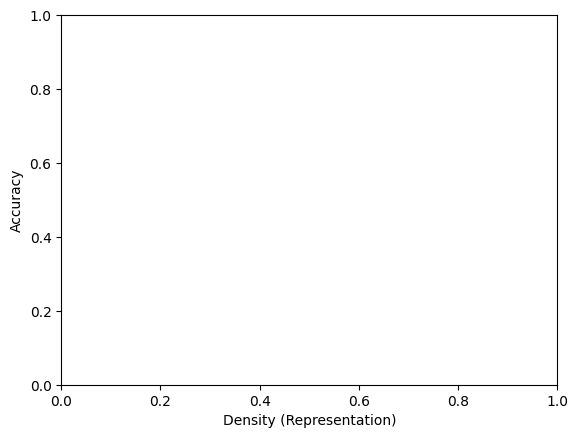

In [7]:
# Plot the representation density vs. the accuracy
plt.xlabel("Density (Representation)")
plt.ylabel("Accuracy")
averaged_imgs = mdl.lab3.plot_accuracy_vs_risk(sorted_images, sorted_biases, sorted_preds, "Bias vs. Accuracy")

These representations scores relate back to data examples, so we can visualize what the average face looks like for a given *percentile* of representation density:

NameError: ignored

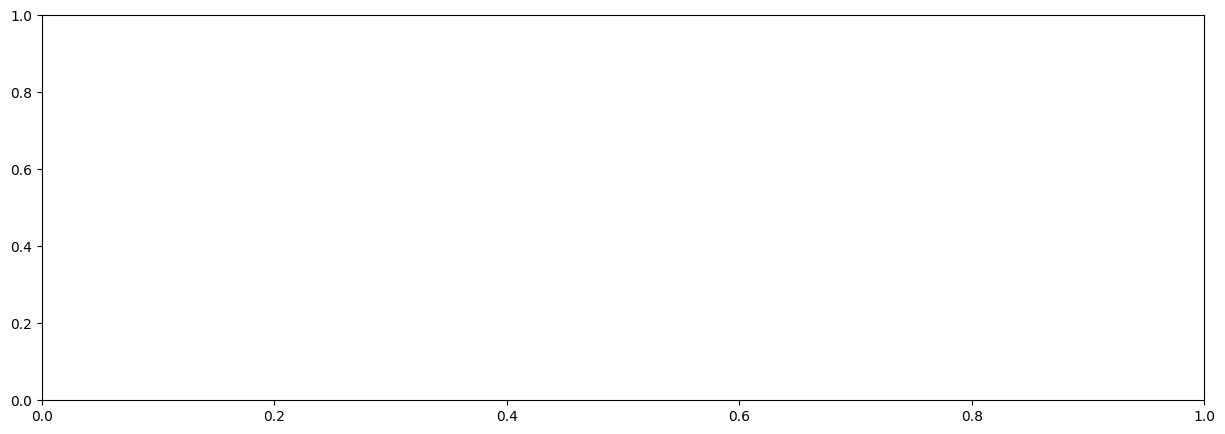

In [8]:
fig, ax = plt.subplots(figsize=(15,5))
ax.imshow(mdl.util.create_grid_of_images(averaged_imgs, (1,10)))

#### **TODO: Scoring representation densities with Capsa**

Write short answers to the questions below to complete the `TODO`s:

1. How does accuracy relate to the representation score? From this relationship, what can you determine about the bias underlying the dataset?
2. What does the average face in the 10th percentile of representation density look like (i.e., the face for which 10% of the data have lower probability of occuring)? What about the 90th percentile? What changes across these faces?
3. What could be potential limitations of the `HistogramVAEWrapper` approach as it is implemented now?

# 3.4 Analyzing epistemic uncertainty with Capsa

Recall that *epistemic* uncertainty, or a model's uncertainty in its prediction, can arise from out-of-distribution data, missing data, or samples that are harder to learn. This does not necessarily correlate with representation bias! Imagine the scenario of training an object detector for self-driving cars: even if the model is presented with many cluttered scenes, these samples still may be harder to learn than scenes with very few objects in them.

We will now use our VAE-wrapped facial detection classifier to analyze and estimate the epistemic uncertainty of the model trained on the facial detection task.

While most methods of estimating epistemic uncertainty are *sampling-based*, we can also use ***reconstruction-based*** methods -- like using VAEs -- to estimate epistemic uncertainty. If a model is unable to provide a good reconstruction for a given data point, it has not learned that area of the underlying data distribution well, and therefore has high epistemic uncertainty.



Since we've already used the `HistogramVAEWrapper` to calculate the histograms for representation bias quantification, we can use the exact same VAE wrapper to shed insight into epistemic uncertainty! Capsa helps us do exactly that. When we called the model, we returned the classification prediction, uncertainty, and bias for every sample:
`predictions, uncertainty, bias = wrapped_model.predict(test_imgs, batch_size=512)`.

Let's analyze these estimated uncertainties:

In [ ]:
### Analyzing epistemic uncertainty estimates ###

# Sort according to epistemic uncertainty estimates
epistemic_indices = np.argsort(uncertainty, axis=None) # sort the uncertainty values
epistemic_images = test_imgs[epistemic_indices] # sort images from lowest to highest uncertainty
sorted_epistemic = uncertainty[epistemic_indices] # order the uncertainty scores
sorted_epistemic_preds = predictions[epistemic_indices] # order the prediction values


# Visualize the 20 images with the LEAST and MOST epistemic uncertainty
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(mdl.util.create_grid_of_images(epistemic_images[:20], (4, 5)))
ax[0].set_title("Least Uncertain");

ax[1].imshow(mdl.util.create_grid_of_images(epistemic_images[-20:], (4, 5)))
ax[1].set_title("Most Uncertain");

We quantify how the epistemic uncertainty relates to the classification accuracy by plotting the two against each other:

In [ ]:
# Plot epistemic uncertainty vs. classification accuracy
plt.xlabel("Epistemic Uncertainty")
plt.ylabel("Accuracy")
_ = mdl.lab3.plot_accuracy_vs_risk(epistemic_images, sorted_epistemic, sorted_epistemic_preds, "Epistemic Uncertainty vs. Accuracy")

#### **TODO: Estimating epistemic uncertainties with Capsa**

Write short answers to the questions below to complete the `TODO`s:

1. How does accuracy relate to the epistemic uncertainty?
2. How do the results for epistemic uncertainty compare to the results for representation bias? Was this expected or unexpted? Why?
3. What may be instances in the facial detection task that could have high representation density but also high uncertainty? 

# 3.4 Resampling based on risk metrics

Finally, we will use the risk metrics just computed to actually *mitigate* the issues of bias and uncertainty in the facial detection classifier.

Specifically, we will use the latent variables learned via the VAE to adaptively re-sample the face (CelebA) data during training, following the approach of [recent work](http://introtodeeplearning.com/AAAI_MitigatingAlgorithmicBias.pdf). We will alter the probability that a given image is used during training based on how often its latent features appear in the dataset. So, faces with rarer features (like dark skin, sunglasses, or hats) should become more likely to be sampled during training, while the sampling probability for faces with features that are over-represented in the training dataset should decrease (relative to uniform random sampling across the training data).

Note that we want to debias and amplify only the *positive* samples in the dataset -- the faces -- so we are going to only adjust probabilities and calculate scores for these samples. We focus on using the representation bias scores to implement this adaptive resampling to achieve model debiasing.

We re-define the wrapped model with `HistogramVAEWrapper`, and then define the adaptive resampling operation for training. At each training epoch, we compute the predictions, uncertainties, and representation bias scores, then recompute the data sampling probabilities according to the *inverse* of the representation bias score. That is, samples with higher representation densities will end up with lower re-sampling probabilities; samples with lower representations will end up with higher re-sampling probabilities.

Let's do all this below!

In [ ]:
### Define the standard CNN classifier and wrap with HistogramVAE ###

classifier = make_standard_classifier()
# Wrap with HistogramVAE
wrapper = capsa.HistogramVAEWrapper(classifier, latent_dim=32, num_bins=5, 
                          queue_size=2000, decoder=make_face_decoder_network())

# Build the wrapped model for the classification task
wrapper.compile(optimizer=tf.keras.optimizers.Adam(5e-4),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=[tf.keras.metrics.BinaryAccuracy()])

# Load training data
train_imgs = train_loader.get_all_faces()

In [ ]:
### Debiasing via resampling based on risk metrics ###

# The training loop -- outer loop iterates over the number of epochs
num_epochs = 6
for i in range(num_epochs):
  print("Starting epoch {}/{}".format(i+1, num_epochs))
  
  # Get a batch of training data and compute the training step
  for step, data in enumerate(train_loader):
    metrics = wrapper.train_step(data)
    if step % 100 == 0:
        print(step)

  # After the epoch is done, recompute data sampling proabilities 
  #  according to the inverse of the bias
  pred, unc, bias = wrapper(train_imgs)

  # Increase the probability of sampling under-represented datapoints by setting 
  #   the probability to the **inverse** of the biases
  inverse_bias = 1.0 / (bias.numpy() + 1e-7)

  # Normalize the inverse biases in order to convert them to probabilities
  p_faces = inverse_bias / np.sum(inverse_bias)

  # Update the training data loader to sample according to this new distribution
  train_loader.p_pos = p_faces

That's it! We should have a debiased model (we hope!). Let's see how the model does.

### Evaluation

Let's run the same analyses as before, and plot the classification accuracy vs. the representation bias and classification accuracy vs. epistemic uncertainty. We want the model to do better across the data samples, achieving higher accuracies on the under-represented and more uncertain samples compared to previously.


In [ ]:
### Evaluation of debiased model ###

# Get classification predictions, uncertainties, and representation bias scores
pred, unc, bias = wrapper.predict(test_imgs)

# Sort according to lowest to highest representation scores
indices = np.argsort(bias, axis=None)
bias_images = test_imgs[indices] # sort the images
sorted_bias = bias[indices] # sort the representation bias scores
sorted_bias_preds = pred[indices] # sort the predictions

# Plot the representation bias vs. the accuracy
plt.xlabel("Density (Representation)")
plt.ylabel("Accuracy")
_ = mdl.lab3.plot_accuracy_vs_risk(bias_images, sorted_bias, sorted_bias_preds, "Bias vs. Accuracy")

# 3.5 Competition!

Now, you are well equipped to submit to the competition to dig in deeper into deep learning models, uncover their deficiencies with Capsa, address those deficiencies, and submit your findings!

**Below are some potential areas to start investigating -- the goal of the competition is to develop creative and innovative solutions to address bias and uncertainty, and to improve the overall performance of deep learning models.**

We encourage you to identify other questions that could be solved with Capsa and use those as the basis of your submission. But, to help get you started, here are some interesting questions that you might look into solving with these new tools and knowledge that you've built up: 

1. In this lab, you learned how to build a wrapper that can estimate the bias within the training data, and take the results from this wrapper to adaptively re-sample during training to encourage learning on under-represented data. 
  * Can we apply a similar approach to mitigate epistemic uncertainty in the model? 
  * Can this approach be combined with your original bias mitigation approach to achieve robustness across both bias *and* uncertainty? 

2. In this lab, you focused on the `HistogramVAEWrapper`. 
  * How can you use other methods of uncertainty in Capsa to strengthen your uncertainty estimates? Checkout [Capsa documentation](https://themisai.io/capsa/api_documentation/index.html) for a list of all wrappers, and ask for help if you run into trouble applying them to your model!
  * Can you combine uncertainty estimates from different wrappers to achieve greater robustness in your estimates? 

3. So far in this part of the lab, we focused only on bias and epistemic uncertainty. What about aleatoric uncetainty? 
  * We've curated a dataset (available at [this URL](https://www.dropbox.com/s/wsdyma8a340k8lw/train_face_2023_perturbed_large.h5?dl=0)) of faces with greater amounts of aleatoric uncertainty -- can you use Capsa to wrap your model, estimate aleatoric uncertainty, and remove it from the dataset? 
  * Does removing aleatoric uncertainty help improve your training accuracy on this new dataset? 
  * Can you develop an approach to incorporate this aleatoric uncertainty estimation into the predictive training pipeline in order to improve accuracy? You may find some surprising results!!

4. How can the performance of the classifier above be improved even further? We purposely did not optimize hyperparameters to leave this up to you!

5. Are there other applications that you think Capsa and bias/uncertainty estimation would be helpful in? 
  * Try integrating Capsa into another domain or dataset and submit your findings!
  * Are there applications where you may *not* want to debias your model? 


**To enter the competition, please upload the following to the [lab submission site](https://www.dropbox.com/request/TTYz3Ikx5wIgOITmm5i2):**

* Written short-answer responses to `TODO`s from Lab 2, Part 2 on Facial Detection.
* Description of the wrappers, algorithms, and approach you used. What was your strategy? What wrappers did you implement? What debiasing or mitigation strategies did you try? How and why did these modifications affect performance? Describe *any* modifications or implementations you made to the template code, and what their effects were. Written text, visual diagram, and plots welcome!
* Jupyter notebook with the code you used to generate your results (along with all plots/visuals generated).

**Name your file in the following format: `[FirstName]_[LastName]_Face`, followed by the file format (.zip, .ipynb, .pdf, etc).** ZIP files are preferred over individual files. If you submit individual files, you must name the individual files according to the above nomenclature (e.g., `[FirstName]_[LastName]_Face_TODO.pdf`, `[FirstName]_[LastName]_Face_Report.pdf`, etc.). **Submit your files [here](https://www.dropbox.com/request/TTYz3Ikx5wIgOITmm5i2).**

We encourage you to think about and maybe even address some questions raised by this lab and dig into any questions that you may have about the risks inherrent to neural networks and their data. 

<img src="https://i.ibb.co/BjLSRMM/ezgif-2-253dfd3f9097.gif" />